# *Scientific Progress Goes Boink!* - Training a Generative Adversarial Network on a Cartoon Dataset

by Brennan McFarland

![alt text](intro_img.png "Logo Title Text 1")

Let's transmogify some noise

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math

import sys
import csv
import re
import random
from skimage.transform import downscale_local_mean
from skimage import io
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Multiply, Input, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import initializers

Using TensorFlow backend.


In [2]:
data_root = 'E:/ML/keras/data/cartoons/'
output_root = 'E:/ML/keras/cartoons/'
random.seed()

In [3]:
# TODO: these two helper functions were copied directly from the example,
# look at them closer when you get the chance
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [4]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

In [5]:
# TODO: may want to try using the ImageDataGenerator class, but the problem is that it would
# have to be able to work with one batch at a time loaded with its respective metadata from
# files
# could write a quick script to rename all the images with ids and make that the first value in
# each csv row, then use flow_from_directory and use that id to get the metadata, but I'm too
# lazy to do that right now
class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # TODO: obviously we'll need to find the optimal batch size
    
    def __init__(self, metadata):
        self.metadata = metadata
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # TODO: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 150, 450
        batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        for i in range(batch_size):
            datum_indices = np.random.randint(0, len(metadata), size=2)
            img_scaled = None
            j = 0
            while img_scaled is None:
                img_scaled = self.get_image(metadata, (datum_indices[0] + j) % len(metadata))
                metadatum = metadata[datum_indices[0]]
                j += 1
                #datum_indices[0] = (datum_indices[0] + 1) % len(metadata)
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            # TODO: was maximum, but maybe manuallly setting to 1 will make ti work better for now
            batch_x[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'constant', constant_values=1)

            img_scaled = None
            j = 0
            while img_scaled is None:
                img_scaled = self.get_image(metadata, (datum_indices[1] + j) % len(metadata))
                metadatum = metadata[datum_indices[1]]
                j += 1
                #datum_indices[1] = (datum_indices[1] + 1) % len(metadata)
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_x[i] /= 255.0
            batch_y[i] /= 255.0
            batch_x = self.convert_to_sample(batch_y)
            #batch_y[i][class_to_id[metadatum[0]]] = 1
        #return np.expand_dims(batch_x, axis=3), batch_y
        return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)
        # TODO: need to have it differentiate different strip sizes, ie sunday vs weekday strips

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            #print('image oustide acceptable dimensions, ', image.shape)
            return None
        elif(initial_y > target_y):
            #print('shrinking to fit target dimensions')
            return image[:target_y]
        else: # initial_y <= target_y
            #print('growing to fit target dimensions')
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        # TODO: we'll need to make it color for some strips later
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        # print('raw image: ', img_raw.shape)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled


    # 1 is white, 0 is black, remember
    def convert_to_sample(self, img):
        p_black = .2
        sample = np.random.choice((0.0, 1.0), size=img.shape, p=(p_black, 1.0-p_black)) # p is probability of each option
        # element-wise max
        return np.maximum(sample, img)

In [558]:
# TODO: condense these repeated layer patterns into "super layers"?
latent_dim = 2 # TODO: this will probably need to be upped a lot (or does it, since it's not one-hot but just regular vectors?

class PixelCNN(Conv2D):
    ''' Start w/ simple PixelCNN and then make it better once it works '''

    # TODO: get it to infer n_channels from the input shape, then get rid of it
    def __init__(self, filters, *args, mask_current=True, n_channels=1, mono=False, **kwargs):
        self.mask_current = mask_current
        self.mask = None
        self.num_filters = filters
        self.num_channels = n_channels
        super(PixelCNN, self).__init__(filters, *args, **kwargs)


    # this is where you will define your weights. This method must set
    # self.built = True at the end, which can be done by calling
    # super([Layer], self).build()
    def build(self, input_shape):
        # (filter width, filter height, input dimensions/channels/filters, output filters)
        kernel_shape = self.kernel_size + (input_shape[-1], self.num_filters)
        # the initializer here is NOT what keras normally uses, keras uses golorot uniform, but that just resulted in
        # initially black images and made it harder for the network to start learning.  using this distribution instead
        # results in noisy initial outputs that convey information for the network to learn off of
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=initializers.RandomUniform(minval=-5, maxval=5), 
                                      trainable=True)
        
        # normally, keras initializes the biases to 0, but the random uniform works better here.  If the initializers are
        # not carefully tuned, the initial images will tend to be all black or white and start the network with little
        # infoormation to learn on
        self.bias = self.add_weight(name='bias',
                                shape=kernel_shape,
                                initializer=initializers.RandomUniform(minval=-50, maxval=40),
                                trainable=True)
        self.mask = np.zeros(self.kernel.shape) # W_shape must be inherit from Conv2D or layer
        assert self.mask.shape[0] == self.mask.shape[1] # assert that mask height = width
        filter_size = self.mask.shape[0]
        filter_center = filter_size/2

        # unmask everything before the center
        self.mask[:math.floor(filter_center)] = 1 # unmask rows above
        self.mask[:math.ceil(filter_center), :math.floor(filter_center)] = 1 # unmask cols to the left in same row

        if not self.mask_current:
            self.mask[math.ceil(filter_center), math.ceil(filter_center)] = 1

        self.mask = K.variable(self.mask)
        print("mask shape: ", self.mask.shape)

        self.built = True

    # this is where the layer's logic lives. Unless you want your layer to
    # support masking, you only have to care about the first argument
    # passed to call: the input tensor
    def call(self, x, mask=None):
        ''' calculate gated activation maps given input maps '''
        # TODO: I did this just to make everything masked white, but can we do this when
        # precalculating the mask instead?
        print(self.data_format)
        print("x: ", x.shape)
        output = K.conv2d(x, self.kernel * self.mask + (-self.mask + 1) + self.bias,
                          strides=self.strides,
                          padding=self.padding,
                          data_format=self.data_format)
        print("output: ", output.shape)
        output = self.activation(output)
        return output

    def get_config(self):
        return dict(list(super().get_config().items()) + list({'mask': self.mask_current}.items()))
    # in case your layer modifies the shape of its input, you should
    # specify here the shape transformation logic. This allows Keras to
    # do automatic shape inference
    # implemented in base ok i think
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + tuple([self.num_filters])
        #return super(PixelCNN, self).compute_output_shape(input_shape)


In [559]:
def report_epoch_progress(epoch, logs, gen_model, data_test):
    print('epoch progress report:')
    for i in range(num_classes):
        example = data_test.__getitem__(3)
        latent = example[0]
        #latent = np.expand_dims(latent, axis=0)
        print('LATENT: ', latent.shape)
        img = gen_model.predict(latent)
        print(img.shape)
        img = np.squeeze(img, axis=(0,3))
        img *= 255.0
        img = img.astype(int)
        print('image shape:', img.shape)
        #filename = 'epoch-output/latest-' + str(i) + '-predicted.png'
        #io.imsave(filename, img)
        
        actual = example[1]
        actual = np.squeeze(actual, axis=(0,3))
        actual *= 255.0
        actual = actual.astype(int)
        #filename2 = 'epoch-output/latest-' + str(i) + '-actual.png'
        #io.imsave(filename2, actual)

        latent = np.squeeze(latent, axis=(0,3))
        latent *= 255.0
        latent = latent.astype(int)
        #filename3 = 'epoch-output/latest-' + str(i) + '-input.png'
        #io.imsave(filename3, latent)
        
        io.imshow(latent, cmap='gray')
        io.show()
        io.imshow(img, cmap='gray')
        io.show()
        io.imshow(actual, cmap='gray')
        io.show()

In [560]:
class GANModel():
    
    def __init__(self, g, d):
        self.generator = g
        self.discriminator = d
        
        gan_inputs = Input(shape=(150, 450, 1))
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=[gan_images, gan_output])

    def compile(self):
        g_optimizer = Adam(lr=.0001)
        d_optimizer = Adam(lr=.0001)
        gan_optimizer = Adam(lr=.0001)

        # TODO: not sure why setting trainable
        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=d_optimizer, loss='mse')
        self.discriminator.trainable = False
        loss = ['binary_crossentropy', 'mse']
        loss_weights = [100, 1] # TODO: play with
        self.gan.compile(optimizer=gan_optimizer, loss=loss, loss_weights=loss_weights)
        self.discriminator.trainable = True
        
        progress_callback = LambdaCallback(on_epoch_end=report_epoch_progress)
        checkpoint_callback = ModelCheckpoint('./model-checkpoint.ckpt')
        tensorboard_callback = TensorBoard(log_dir='../logs/tensorboard-logs', write_images=True)
        # TODO: get other callbacks working
        # callbacks = [progress_callback, checkpoint_callback, tensorboard_callback]
        self.callbacks = [progress_callback]
        self.gan.summary()

    def train(self, epochs, data_train, data_test):
        self.data_train = data_train
        self.data_test = data_test
        steps_per_epoch = num_data//self.data_train.batch_size
        discriminator_updates = 1
        report_epoch_progress(None, None, self.generator, self.data_test)
        
        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)

        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                current_batch = self.data_train.__getitem__(0)
                # generate "fake" images
                generator_inputs = current_batch[0]
                generated_images = self.generator.predict(generator_inputs, batch_size=1)
                # train discriminator on "real" images from the dataset and "fake" ones that were generated
                true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                for _ in range(discriminator_updates):
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                # halt training on the discriminator
                self.discriminator.trainable = False
                # train generator to try to fool the discriminator
                g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True
                print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')


In [561]:
d_input = Input(shape=(150, 450, 1), name='discriminator_input')
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('sigmoid')(layer)
d_output = Dense(1)(layer)

discriminator = Model(d_input, d_output, name='discriminator')

In [562]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
output = Activation('sigmoid')(layer)

generator = Model(input, output, name='generator')

mask shape:  (7, 7, 1, 8)
channels_last
x:  (?, 150, 450, 1)
output:  (?, 150, 450, 8)
mask shape:  (7, 7, 8, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)


In [569]:
def test_gan(g, d):
    gan_model = GANModel(g, d)
    gan_model.compile()
    # TODO: add validation data (split the training data)
    data_train = DataProvider(metadata_train)
    data_test = DataProvider(metadata_test)
    gan_model.train(3, data_train, data_test)

channels_last
x:  (?, 150, 450, 1)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       2716977   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,717,041
Trainable params: 2,716,929
Non-trainable params: 112
_________________________________________________________________
epoch progress report:
LATENT:  (1, 150, 450, 1)


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


(1, 150, 450, 1)
image shape: (150, 450)


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


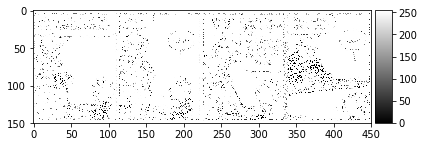

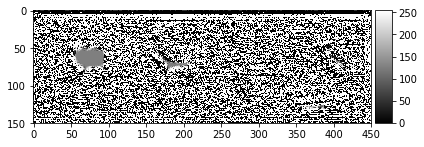

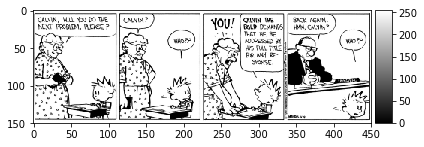

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


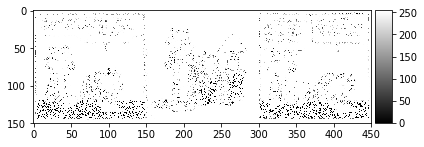

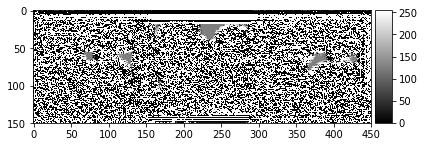

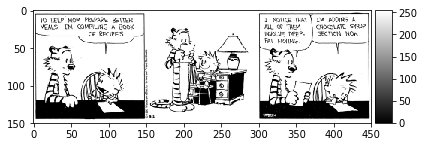

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


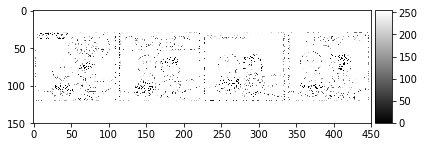

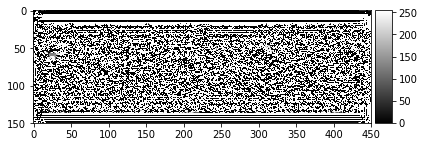

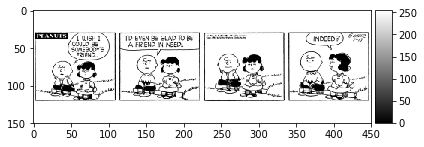

KeyboardInterrupt: 

In [570]:
test_gan(generator, discriminator)

In [13]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
output = Activation('sigmoid')(layer)

g_transposed_conv = Model(input, output, name='transposed_convolution_generator')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
transposed_convolution_gener (None, 150, 450, 1)       2713529   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,713,593
Trainable params: 2,713,449
Non-trainable params: 144
_________________________________________________________________
epoch progress report:
LATENT:  (1, 150, 450, 1)


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


(1, 150, 450, 1)
image shape: (150, 450)


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


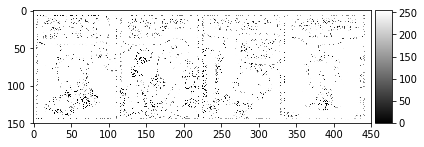

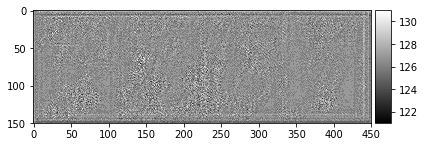

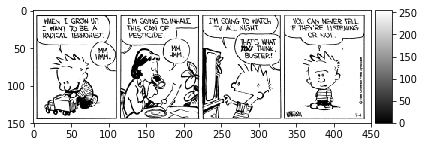

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


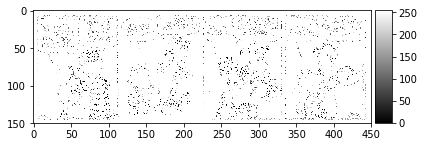

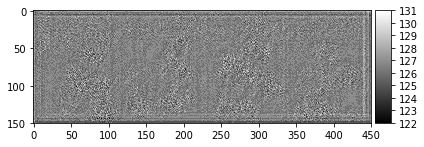

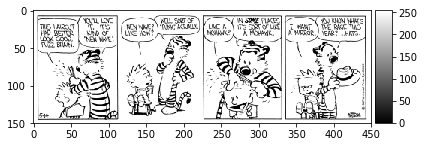

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


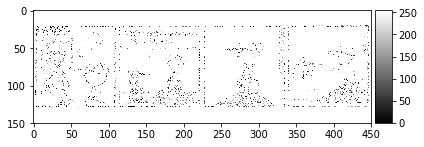

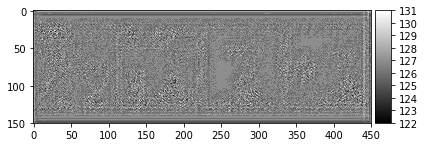

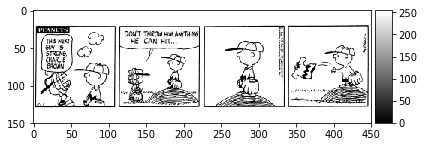

step  0 / 7367 d_loss:  0.028515933081507683 g_loss:  [74.82097, 0.74820966, 7.8725645e-07]
step  1 / 7367 d_loss:  0.49727708101272583 g_loss:  [72.79176, 0.72791713, 5.1325478e-05]
step  2 / 7367 d_loss:  0.49159857630729675 g_loss:  [76.12566, 0.7612552, 0.0001428499]
step  3 / 7367 d_loss:  0.4907982647418976 g_loss:  [72.01532, 0.7201507, 0.0002518353]
step  4 / 7367 d_loss:  0.4789026081562042 g_loss:  [70.91168, 0.7091095, 0.00073310366]
step  5 / 7367 d_loss:  0.46784985065460205 g_loss:  [71.09798, 0.71096563, 0.001410766]
step  6 / 7367 d_loss:  0.46045809984207153 g_loss:  [68.881905, 0.68880033, 0.001867184]
step  7 / 7367 d_loss:  0.45419639348983765 g_loss:  [68.98056, 0.68977904, 0.0026548745]
step  8 / 7367 d_loss:  0.44715026021003723 g_loss:  [67.06146, 0.6705792, 0.0035381839]
step  9 / 7367 d_loss:  0.43969008326530457 g_loss:  [67.08569, 0.6708078, 0.004909617]
step  10 / 7367 d_loss:  0.43461599946022034 g_loss:  [65.902245, 0.6589664, 0.0055982615]
step  11 / 736

step  93 / 7367 d_loss:  0.03621523082256317 g_loss:  [38.1879, 0.37442467, 0.74543464]
step  94 / 7367 d_loss:  0.04017084836959839 g_loss:  [36.14126, 0.35644555, 0.49670482]
step  95 / 7367 d_loss:  0.08251400291919708 g_loss:  [43.701454, 0.43008697, 0.6927567]
step  96 / 7367 d_loss:  0.12566184997558594 g_loss:  [38.018883, 0.37314734, 0.70414776]
step  97 / 7367 d_loss:  0.02393529750406742 g_loss:  [43.24681, 0.4203031, 1.2164986]
step  98 / 7367 d_loss:  0.02767099440097809 g_loss:  [37.54091, 0.3673939, 0.80151606]
step  99 / 7367 d_loss:  0.038589973002672195 g_loss:  [37.96202, 0.36338657, 1.623362]
step  100 / 7367 d_loss:  0.028104236349463463 g_loss:  [40.211178, 0.39100057, 1.1111203]
step  101 / 7367 d_loss:  0.03079340048134327 g_loss:  [44.249607, 0.43153754, 1.0958524]
step  102 / 7367 d_loss:  0.020095372572541237 g_loss:  [45.720745, 0.44317308, 1.4034381]
step  103 / 7367 d_loss:  0.0247802734375 g_loss:  [38.050217, 0.370299, 1.0203153]
step  104 / 7367 d_loss: 

step  186 / 7367 d_loss:  0.058468833565711975 g_loss:  [30.97901, 0.2979319, 1.1858205]
step  187 / 7367 d_loss:  0.01184367761015892 g_loss:  [40.424187, 0.38800424, 1.6237624]
step  188 / 7367 d_loss:  0.13223539292812347 g_loss:  [28.27553, 0.2683438, 1.4411485]
step  189 / 7367 d_loss:  0.061812520027160645 g_loss:  [26.57389, 0.25863132, 0.71075755]
step  190 / 7367 d_loss:  0.3904802203178406 g_loss:  [192.8657, 1.9278376, 0.08194056]
step  191 / 7367 d_loss:  0.04359802231192589 g_loss:  [31.919092, 0.31551388, 0.3677042]
step  192 / 7367 d_loss:  0.02309916354715824 g_loss:  [35.03785, 0.34490696, 0.54715234]
step  193 / 7367 d_loss:  0.005699873901903629 g_loss:  [30.521914, 0.30095354, 0.42655972]
step  194 / 7367 d_loss:  0.023866064846515656 g_loss:  [28.07896, 0.27752572, 0.32638693]
step  195 / 7367 d_loss:  0.05074235796928406 g_loss:  [29.49497, 0.29112357, 0.3826142]
step  196 / 7367 d_loss:  0.05935274809598923 g_loss:  [33.879692, 0.334133, 0.46639183]
step  197 / 7

step  277 / 7367 d_loss:  0.011363547295331955 g_loss:  [34.017654, 0.32885742, 1.1319128]
step  278 / 7367 d_loss:  0.0032010783907026052 g_loss:  [29.559797, 0.28961018, 0.59877974]
step  279 / 7367 d_loss:  0.09970906376838684 g_loss:  [32.387398, 0.32067838, 0.31956252]
step  280 / 7367 d_loss:  0.08548779785633087 g_loss:  [38.47525, 0.37490785, 0.9844656]
step  281 / 7367 d_loss:  0.010677588172256947 g_loss:  [34.500614, 0.33596262, 0.9043514]
step  282 / 7367 d_loss:  0.0014447493012994528 g_loss:  [39.1788, 0.37770498, 1.4083024]
step  283 / 7367 d_loss:  0.0021059606224298477 g_loss:  [31.540878, 0.3025735, 1.2835281]
step  284 / 7367 d_loss:  0.009592250920832157 g_loss:  [34.65333, 0.3344757, 1.2057623]
step  285 / 7367 d_loss:  0.042597465217113495 g_loss:  [31.834688, 0.30538604, 1.296085]
step  286 / 7367 d_loss:  0.02118101716041565 g_loss:  [29.438595, 0.27983546, 1.4550472]
step  287 / 7367 d_loss:  0.017150819301605225 g_loss:  [30.130745, 0.2957999, 0.5507547]
step 

step  368 / 7367 d_loss:  0.09812990576028824 g_loss:  [22.737274, 0.22133018, 0.60425514]
step  369 / 7367 d_loss:  0.011126959696412086 g_loss:  [26.78188, 0.26362115, 0.41976428]
step  370 / 7367 d_loss:  0.09208352118730545 g_loss:  [41.816723, 0.4090559, 0.9111341]
step  371 / 7367 d_loss:  0.007332353852689266 g_loss:  [35.03873, 0.3400398, 1.0347501]
step  372 / 7367 d_loss:  0.0018457251135259867 g_loss:  [40.204426, 0.38947436, 1.2569891]
step  373 / 7367 d_loss:  0.00925587397068739 g_loss:  [36.319546, 0.35137564, 1.1819804]
step  374 / 7367 d_loss:  0.09731936454772949 g_loss:  [21.63754, 0.20751455, 0.8860853]
step  375 / 7367 d_loss:  0.0007400279282592237 g_loss:  [30.036894, 0.28885505, 1.1513901]
step  376 / 7367 d_loss:  0.009792296215891838 g_loss:  [41.566956, 0.4051713, 1.0498228]
step  377 / 7367 d_loss:  0.0002505545853637159 g_loss:  [39.418743, 0.38088748, 1.3299941]
step  378 / 7367 d_loss:  0.006878824904561043 g_loss:  [35.54754, 0.34534425, 1.013113]
step  

step  459 / 7367 d_loss:  0.01984470523893833 g_loss:  [25.97306, 0.2549326, 0.47979897]
step  460 / 7367 d_loss:  0.006084559950977564 g_loss:  [31.099382, 0.2996111, 1.1382741]
step  461 / 7367 d_loss:  0.006668602116405964 g_loss:  [32.85693, 0.31745476, 1.1114551]
step  462 / 7367 d_loss:  0.0024920827709138393 g_loss:  [34.21941, 0.32687593, 1.5318189]
step  463 / 7367 d_loss:  0.019355591386556625 g_loss:  [28.080116, 0.26876122, 1.2039952]
step  464 / 7367 d_loss:  0.006812285631895065 g_loss:  [33.521175, 0.3237761, 1.143566]
step  465 / 7367 d_loss:  0.08579947799444199 g_loss:  [35.728218, 0.34077308, 1.6509081]
step  466 / 7367 d_loss:  0.0012397448299452662 g_loss:  [34.413353, 0.3302771, 1.3856434]
step  467 / 7367 d_loss:  0.012775858864188194 g_loss:  [29.062586, 0.27893066, 1.1695186]
step  468 / 7367 d_loss:  0.004323461093008518 g_loss:  [25.949944, 0.24900272, 1.0496703]
step  469 / 7367 d_loss:  0.019564522430300713 g_loss:  [26.632666, 0.2618015, 0.45251444]
step  

step  551 / 7367 d_loss:  0.008914901874959469 g_loss:  [24.535969, 0.23478833, 1.0571373]
step  552 / 7367 d_loss:  0.06280418485403061 g_loss:  [38.714397, 0.37814096, 0.9003045]
step  553 / 7367 d_loss:  0.042358770966529846 g_loss:  [26.158516, 0.25157768, 1.0007471]
step  554 / 7367 d_loss:  0.016388114541769028 g_loss:  [30.28649, 0.2917954, 1.1069489]
step  555 / 7367 d_loss:  0.00666895741596818 g_loss:  [25.28494, 0.2416243, 1.1225114]
step  556 / 7367 d_loss:  0.007563222199678421 g_loss:  [25.525871, 0.24595602, 0.930269]
step  557 / 7367 d_loss:  0.002567654475569725 g_loss:  [25.461733, 0.24517561, 0.9441721]
step  558 / 7367 d_loss:  0.004798715002834797 g_loss:  [27.485832, 0.26477426, 1.0084057]
step  559 / 7367 d_loss:  0.0019581643864512444 g_loss:  [31.901787, 0.3072143, 1.180357]
step  560 / 7367 d_loss:  0.002977469004690647 g_loss:  [34.270416, 0.3313731, 1.1331054]
step  561 / 7367 d_loss:  0.007788400165736675 g_loss:  [43.237705, 0.42162582, 1.0751221]
step  56

step  644 / 7367 d_loss:  0.005944214295595884 g_loss:  [20.163372, 0.19336835, 0.8265388]
step  645 / 7367 d_loss:  0.0032115252688527107 g_loss:  [26.75181, 0.25589642, 1.1621687]
step  646 / 7367 d_loss:  0.00028603922692127526 g_loss:  [28.172318, 0.2702487, 1.1474463]
step  647 / 7367 d_loss:  0.027456287294626236 g_loss:  [43.545376, 0.42530626, 1.0147532]
step  648 / 7367 d_loss:  0.0004698876873590052 g_loss:  [21.831802, 0.21085526, 0.74627656]
step  649 / 7367 d_loss:  0.041975636035203934 g_loss:  [18.718473, 0.17785132, 0.9333418]
step  650 / 7367 d_loss:  0.029597207903862 g_loss:  [27.107729, 0.26463878, 0.64385074]
step  651 / 7367 d_loss:  0.0033183367922902107 g_loss:  [39.085846, 0.37871313, 1.214529]
step  652 / 7367 d_loss:  0.0020590771455317736 g_loss:  [25.978865, 0.24913102, 1.0657619]
step  653 / 7367 d_loss:  0.0024754730984568596 g_loss:  [23.497854, 0.22670875, 0.8269795]
step  654 / 7367 d_loss:  0.04452384263277054 g_loss:  [19.776447, 0.18895577, 0.880870

step  736 / 7367 d_loss:  0.0024537662975490093 g_loss:  [26.199179, 0.25135285, 1.0638951]
step  737 / 7367 d_loss:  0.009038391523063183 g_loss:  [18.876196, 0.17930223, 0.94597286]
step  738 / 7367 d_loss:  0.0016058936016634107 g_loss:  [32.287422, 0.31312463, 0.97496074]
step  739 / 7367 d_loss:  0.019311880692839622 g_loss:  [36.28417, 0.34954587, 1.3295822]
step  740 / 7367 d_loss:  0.0023376059252768755 g_loss:  [25.668493, 0.24747708, 0.9207849]
step  741 / 7367 d_loss:  0.007427299860864878 g_loss:  [24.427185, 0.23713838, 0.7133475]
step  742 / 7367 d_loss:  0.015697361901402473 g_loss:  [29.700031, 0.29069784, 0.6302464]
step  743 / 7367 d_loss:  0.0010420674225315452 g_loss:  [32.99904, 0.3206201, 0.9370325]
step  744 / 7367 d_loss:  0.006592218764126301 g_loss:  [30.849207, 0.29636347, 1.2128599]
step  745 / 7367 d_loss:  0.0010429795365780592 g_loss:  [25.31975, 0.24570689, 0.74906236]
step  746 / 7367 d_loss:  0.001972768921405077 g_loss:  [30.589516, 0.29455942, 1.1335

step  827 / 7367 d_loss:  0.0028610359877347946 g_loss:  [36.666615, 0.3557497, 1.0916427]
step  828 / 7367 d_loss:  0.0010897335596382618 g_loss:  [24.541784, 0.23499355, 1.0424298]
step  829 / 7367 d_loss:  0.0005929766921326518 g_loss:  [22.149265, 0.21261749, 0.88751554]
step  830 / 7367 d_loss:  0.0010646735318005085 g_loss:  [21.254848, 0.20622942, 0.631906]
step  831 / 7367 d_loss:  0.002562903333455324 g_loss:  [26.255413, 0.25311574, 0.9438377]
step  832 / 7367 d_loss:  0.005351788364350796 g_loss:  [30.655602, 0.29437542, 1.2180588]
step  833 / 7367 d_loss:  0.0015798236709088087 g_loss:  [28.73204, 0.27599415, 1.1326252]
step  834 / 7367 d_loss:  0.0009383800206705928 g_loss:  [18.727236, 0.18114574, 0.61266214]
step  835 / 7367 d_loss:  0.0026575340889394283 g_loss:  [33.25187, 0.32088184, 1.1636859]
step  836 / 7367 d_loss:  0.0037413553800433874 g_loss:  [29.533932, 0.28647402, 0.8865307]
step  837 / 7367 d_loss:  0.0007527598645538092 g_loss:  [24.852884, 0.2383136, 1.02

step  917 / 7367 d_loss:  0.0009133166167885065 g_loss:  [34.15312, 0.3308872, 1.0644004]
step  918 / 7367 d_loss:  0.001115625724196434 g_loss:  [31.823902, 0.3083163, 0.9922728]
step  919 / 7367 d_loss:  0.0009531629038974643 g_loss:  [47.096275, 0.45892662, 1.2036124]
step  920 / 7367 d_loss:  0.005718999542295933 g_loss:  [29.646545, 0.28748918, 0.8976295]
step  921 / 7367 d_loss:  0.001224716892465949 g_loss:  [31.269232, 0.3016382, 1.1054133]
step  922 / 7367 d_loss:  0.00042481417767703533 g_loss:  [32.742466, 0.31694663, 1.047804]
step  923 / 7367 d_loss:  0.001020008814521134 g_loss:  [33.894115, 0.32743263, 1.1508514]
step  924 / 7367 d_loss:  0.0030895653180778027 g_loss:  [26.836218, 0.25765288, 1.0709313]
step  925 / 7367 d_loss:  0.000669475004542619 g_loss:  [27.93549, 0.26917684, 1.0178043]
step  926 / 7367 d_loss:  0.0005600839504040778 g_loss:  [32.44031, 0.31355512, 1.0847987]
step  927 / 7367 d_loss:  0.002556088613346219 g_loss:  [34.43191, 0.33320904, 1.1110076]
s

step  1007 / 7367 d_loss:  0.0012911015655845404 g_loss:  [19.441618, 0.1872685, 0.71476924]
step  1008 / 7367 d_loss:  3.633377855294384e-05 g_loss:  [22.66919, 0.2162316, 1.0460293]
step  1009 / 7367 d_loss:  0.0005325085949152708 g_loss:  [28.715792, 0.27613208, 1.1025842]
step  1010 / 7367 d_loss:  0.000731040199752897 g_loss:  [31.214851, 0.30233535, 0.98131585]
step  1011 / 7367 d_loss:  0.0010808862280100584 g_loss:  [22.899096, 0.22037843, 0.8612514]
step  1012 / 7367 d_loss:  0.0003268069413024932 g_loss:  [32.497635, 0.31432876, 1.0647564]
step  1013 / 7367 d_loss:  0.00017295207362622023 g_loss:  [25.367043, 0.24403153, 0.9638908]
step  1014 / 7367 d_loss:  0.0015914230607450008 g_loss:  [20.044703, 0.19099736, 0.9449679]
step  1015 / 7367 d_loss:  0.00038784468779340386 g_loss:  [36.666008, 0.35609704, 1.0563031]
step  1016 / 7367 d_loss:  0.00017909120651893318 g_loss:  [37.349827, 0.36289692, 1.0601356]
step  1017 / 7367 d_loss:  0.00044240380520932376 g_loss:  [30.160275

step  1097 / 7367 d_loss:  0.00035885151010006666 g_loss:  [25.483273, 0.24474144, 1.0091276]
step  1098 / 7367 d_loss:  0.00026079878443852067 g_loss:  [25.24681, 0.2420177, 1.04504]
step  1099 / 7367 d_loss:  4.787050420418382e-05 g_loss:  [31.895267, 0.3090422, 0.9910488]
step  1100 / 7367 d_loss:  0.0009866090258583426 g_loss:  [38.557926, 0.3755684, 1.0010879]
step  1101 / 7367 d_loss:  0.006850578356534243 g_loss:  [16.02647, 0.1534856, 0.67791164]
step  1102 / 7367 d_loss:  0.00020547928579617292 g_loss:  [23.275465, 0.22320333, 0.95513237]
step  1103 / 7367 d_loss:  0.00010736332478700206 g_loss:  [25.571922, 0.24575533, 0.9963891]
step  1104 / 7367 d_loss:  8.291407721117139e-05 g_loss:  [32.969067, 0.3197287, 0.9961973]
step  1105 / 7367 d_loss:  0.0008440919918939471 g_loss:  [24.724096, 0.23865579, 0.85851663]
step  1106 / 7367 d_loss:  0.00012335466453805566 g_loss:  [27.901056, 0.26869172, 1.0318843]
step  1107 / 7367 d_loss:  7.19228555681184e-05 g_loss:  [29.212221, 0.2

step  1186 / 7367 d_loss:  0.00013581881648860872 g_loss:  [33.133453, 0.32076073, 1.0573789]
step  1187 / 7367 d_loss:  0.0005625351914204657 g_loss:  [24.774063, 0.23710738, 1.0633266]
step  1188 / 7367 d_loss:  0.0006875585531815886 g_loss:  [26.048117, 0.2506938, 0.9787366]
step  1189 / 7367 d_loss:  0.003227896522730589 g_loss:  [16.07576, 0.1548667, 0.58909035]
step  1190 / 7367 d_loss:  0.0015880311839282513 g_loss:  [23.912722, 0.22916305, 0.99641526]
step  1191 / 7367 d_loss:  0.00032737600849941373 g_loss:  [29.064009, 0.27989152, 1.0748562]
step  1192 / 7367 d_loss:  0.02523731254041195 g_loss:  [16.8281, 0.16056241, 0.7718587]
step  1193 / 7367 d_loss:  0.00017418937932234257 g_loss:  [18.227455, 0.17457221, 0.77023304]
step  1194 / 7367 d_loss:  9.239870269084349e-05 g_loss:  [25.99697, 0.24947593, 1.049378]
step  1195 / 7367 d_loss:  0.00039082541479729116 g_loss:  [30.070555, 0.2908577, 0.9847851]
step  1196 / 7367 d_loss:  3.562879282981157e-05 g_loss:  [28.444899, 0.27

step  1276 / 7367 d_loss:  3.1061073968885466e-05 g_loss:  [28.375456, 0.27336204, 1.039251]
step  1277 / 7367 d_loss:  0.0006469885120168328 g_loss:  [32.84623, 0.3173547, 1.110759]
step  1278 / 7367 d_loss:  9.927360224537551e-05 g_loss:  [32.075726, 0.3097239, 1.1033342]
step  1279 / 7367 d_loss:  0.0011583537561818957 g_loss:  [37.12192, 0.36000264, 1.1216565]
step  1280 / 7367 d_loss:  0.0004941743100062013 g_loss:  [34.05759, 0.32984528, 1.0730646]
step  1281 / 7367 d_loss:  0.0003174498851876706 g_loss:  [24.324566, 0.2337936, 0.9452048]
step  1282 / 7367 d_loss:  0.000414721027482301 g_loss:  [25.862335, 0.24808177, 1.0541575]
step  1283 / 7367 d_loss:  5.371287988964468e-05 g_loss:  [35.437084, 0.3445301, 0.98407376]
step  1284 / 7367 d_loss:  0.0006017590058036149 g_loss:  [20.063057, 0.191237, 0.93935585]
step  1285 / 7367 d_loss:  0.000589356932323426 g_loss:  [35.79366, 0.34736553, 1.0571048]
step  1286 / 7367 d_loss:  0.00013291597133502364 g_loss:  [28.971888, 0.28001538

step  1366 / 7367 d_loss:  7.633764471393079e-05 g_loss:  [37.157898, 0.36130556, 1.0273383]
step  1367 / 7367 d_loss:  0.0031078262254595757 g_loss:  [21.399612, 0.2049583, 0.90378183]
step  1368 / 7367 d_loss:  0.0001853272842708975 g_loss:  [26.570585, 0.25516048, 1.0545365]
step  1369 / 7367 d_loss:  0.0003117408778052777 g_loss:  [24.594553, 0.23630527, 0.9640248]
step  1370 / 7367 d_loss:  6.778081296943128e-05 g_loss:  [31.338518, 0.30296353, 1.0421665]
step  1371 / 7367 d_loss:  0.0009936682181432843 g_loss:  [22.742704, 0.21808745, 0.9339604]
step  1372 / 7367 d_loss:  0.00028225008281879127 g_loss:  [39.77468, 0.3870436, 1.0703195]
step  1373 / 7367 d_loss:  0.005000971723347902 g_loss:  [38.953823, 0.38023666, 0.93015665]
step  1374 / 7367 d_loss:  0.0010410700924694538 g_loss:  [27.12816, 0.26031467, 1.0966939]
step  1375 / 7367 d_loss:  0.0017254879930987954 g_loss:  [34.88678, 0.33734986, 1.1517938]
step  1376 / 7367 d_loss:  0.00021387106971815228 g_loss:  [23.145044, 0.

step  1456 / 7367 d_loss:  0.0007564427796751261 g_loss:  [24.625177, 0.2366391, 0.961268]
step  1457 / 7367 d_loss:  0.0011452175676822662 g_loss:  [26.096277, 0.25007716, 1.0885618]
step  1458 / 7367 d_loss:  8.049086318351328e-05 g_loss:  [21.35701, 0.20412758, 0.94425106]
step  1459 / 7367 d_loss:  0.001330845756456256 g_loss:  [30.4152, 0.29332262, 1.0829376]
step  1460 / 7367 d_loss:  0.00010546787962084636 g_loss:  [33.80821, 0.32796547, 1.0116625]
step  1461 / 7367 d_loss:  5.68104769627098e-05 g_loss:  [41.064205, 0.39975464, 1.0887414]
step  1462 / 7367 d_loss:  2.6452604288351722e-05 g_loss:  [31.904133, 0.30879924, 1.0242106]
step  1463 / 7367 d_loss:  0.0004377167788334191 g_loss:  [36.498627, 0.35436204, 1.0624255]
step  1464 / 7367 d_loss:  0.0005243002087809145 g_loss:  [17.743288, 0.16889259, 0.85402906]
step  1465 / 7367 d_loss:  8.628181967651471e-05 g_loss:  [29.399933, 0.28363705, 1.0362275]
step  1466 / 7367 d_loss:  8.315960440086201e-05 g_loss:  [22.939016, 0.22

step  1546 / 7367 d_loss:  0.00010357725841458887 g_loss:  [28.48092, 0.27487326, 0.9935953]
step  1547 / 7367 d_loss:  0.0006714198971167207 g_loss:  [33.63691, 0.32680365, 0.95654434]
step  1548 / 7367 d_loss:  9.564287756802514e-05 g_loss:  [33.17559, 0.32138294, 1.0372977]
step  1549 / 7367 d_loss:  0.00024634148576296866 g_loss:  [33.453907, 0.3236113, 1.092778]
step  1550 / 7367 d_loss:  0.000746309757232666 g_loss:  [42.678112, 0.4174382, 0.9342917]
step  1551 / 7367 d_loss:  0.0008950880146585405 g_loss:  [19.661129, 0.18746841, 0.91428834]
step  1552 / 7367 d_loss:  0.0003836529213003814 g_loss:  [28.20861, 0.27162868, 1.0457418]
step  1553 / 7367 d_loss:  3.6044116313860286e-06 g_loss:  [28.806393, 0.27742407, 1.0639865]
step  1554 / 7367 d_loss:  2.8648286388488486e-05 g_loss:  [22.158758, 0.2113471, 1.0240486]
step  1555 / 7367 d_loss:  4.785851706401445e-05 g_loss:  [25.743048, 0.24712177, 1.0308702]
step  1556 / 7367 d_loss:  4.300250293454155e-05 g_loss:  [19.215649, 0.1

step  1637 / 7367 d_loss:  4.0137085306923836e-05 g_loss:  [29.316547, 0.2829073, 1.0258157]
step  1638 / 7367 d_loss:  0.000926848326344043 g_loss:  [24.73728, 0.23728326, 1.0089539]
step  1639 / 7367 d_loss:  0.0014589218189939857 g_loss:  [26.787886, 0.25750184, 1.037703]
step  1640 / 7367 d_loss:  8.954774239100516e-05 g_loss:  [31.45535, 0.30465636, 0.98971534]
step  1641 / 7367 d_loss:  0.00042861278052441776 g_loss:  [32.2196, 0.31204775, 1.0148258]
step  1642 / 7367 d_loss:  3.316394838748238e-07 g_loss:  [45.70538, 0.44668505, 1.036875]
step  1643 / 7367 d_loss:  7.663568248972297e-05 g_loss:  [18.411638, 0.17498298, 0.9133399]
step  1644 / 7367 d_loss:  0.00014905697025824338 g_loss:  [23.645584, 0.22620666, 1.0249174]
step  1645 / 7367 d_loss:  0.0005386988632380962 g_loss:  [37.03826, 0.36065283, 0.9729765]
step  1646 / 7367 d_loss:  0.00017271374235861003 g_loss:  [22.906734, 0.21884038, 1.0226974]
step  1647 / 7367 d_loss:  0.00039354508044198155 g_loss:  [28.025248, 0.27

step  1727 / 7367 d_loss:  0.00026585126761347055 g_loss:  [28.058254, 0.27055028, 1.0032253]
step  1728 / 7367 d_loss:  8.381267252843827e-05 g_loss:  [28.41734, 0.27424353, 0.9929858]
step  1729 / 7367 d_loss:  0.0006025285110808909 g_loss:  [23.185907, 0.22218496, 0.9674112]
step  1730 / 7367 d_loss:  5.6067110563162714e-05 g_loss:  [38.14279, 0.371288, 1.0139918]
step  1731 / 7367 d_loss:  0.00038982307887636125 g_loss:  [18.476894, 0.17564045, 0.9128496]
step  1732 / 7367 d_loss:  7.603808853673399e-07 g_loss:  [30.497795, 0.29468194, 1.0296019]
step  1733 / 7367 d_loss:  0.0004410311521496624 g_loss:  [25.336063, 0.2422393, 1.1121329]
step  1734 / 7367 d_loss:  0.0008407068089582026 g_loss:  [24.940346, 0.23881675, 1.0586691]
step  1735 / 7367 d_loss:  0.0001579352538101375 g_loss:  [17.670048, 0.16762045, 0.9080025]
step  1736 / 7367 d_loss:  0.00030448814504779875 g_loss:  [28.10526, 0.2704978, 1.055481]
step  1737 / 7367 d_loss:  0.0010658660903573036 g_loss:  [24.072807, 0.23

step  1817 / 7367 d_loss:  0.00032621747232042253 g_loss:  [28.168251, 0.27169716, 0.99853474]
step  1818 / 7367 d_loss:  9.521260579958835e-08 g_loss:  [33.459312, 0.32416272, 1.0430429]
step  1819 / 7367 d_loss:  0.00047166942385956645 g_loss:  [32.371006, 0.31271297, 1.0997074]
step  1820 / 7367 d_loss:  0.00027378209051676095 g_loss:  [28.954044, 0.2791305, 1.0409944]
step  1821 / 7367 d_loss:  3.003081701535848e-06 g_loss:  [21.486372, 0.20525712, 0.96066153]
step  1822 / 7367 d_loss:  0.00011825500405393541 g_loss:  [32.936592, 0.3190131, 1.035284]
step  1823 / 7367 d_loss:  9.235546895070001e-05 g_loss:  [29.892422, 0.28894854, 0.99756855]
step  1824 / 7367 d_loss:  2.352676892769523e-05 g_loss:  [25.866302, 0.24887599, 0.9787031]
step  1825 / 7367 d_loss:  9.439373570785392e-06 g_loss:  [21.552141, 0.20674802, 0.87733877]
step  1826 / 7367 d_loss:  5.417727152234875e-05 g_loss:  [25.591238, 0.245879, 1.0033375]
step  1827 / 7367 d_loss:  0.00019855050777550787 g_loss:  [22.0046

step  1906 / 7367 d_loss:  0.0007569555309601128 g_loss:  [27.392284, 0.26354453, 1.0378325]
step  1907 / 7367 d_loss:  0.00039778550853952765 g_loss:  [20.875916, 0.19846724, 1.0291914]
step  1908 / 7367 d_loss:  0.00015315577911678702 g_loss:  [19.318008, 0.18298657, 1.0193524]
step  1909 / 7367 d_loss:  9.611877612769604e-05 g_loss:  [24.599365, 0.23603332, 0.99603295]
step  1910 / 7367 d_loss:  0.00019509965204633772 g_loss:  [32.583904, 0.31613317, 0.9705849]
step  1911 / 7367 d_loss:  0.00030507068731822073 g_loss:  [36.474266, 0.35501963, 0.9723012]
step  1912 / 7367 d_loss:  0.00834137573838234 g_loss:  [298.26422, 2.9728186, 0.9823649]
step  1913 / 7367 d_loss:  0.00016993959434330463 g_loss:  [30.448797, 0.29427618, 1.0211793]
step  1914 / 7367 d_loss:  0.0010122862877324224 g_loss:  [26.861889, 0.25789717, 1.0721712]
step  1915 / 7367 d_loss:  4.270003773854114e-05 g_loss:  [35.990856, 0.34970036, 1.0208194]
step  1916 / 7367 d_loss:  0.0002521631249692291 g_loss:  [25.23115

step  1997 / 7367 d_loss:  0.0005048729362897575 g_loss:  [17.884275, 0.16929959, 0.95431787]
step  1998 / 7367 d_loss:  0.0005738404579460621 g_loss:  [27.02343, 0.2590886, 1.1145695]
step  1999 / 7367 d_loss:  0.00024810509057715535 g_loss:  [22.721506, 0.21688917, 1.032589]
step  2000 / 7367 d_loss:  0.001397293177433312 g_loss:  [27.204466, 0.26155832, 1.0486337]
step  2001 / 7367 d_loss:  4.158752926741727e-05 g_loss:  [21.640383, 0.2071565, 0.92473465]
step  2002 / 7367 d_loss:  5.311261702445336e-05 g_loss:  [20.757204, 0.19862843, 0.8943618]
step  2003 / 7367 d_loss:  0.00014826616097707301 g_loss:  [26.981922, 0.25947767, 1.0341558]
step  2004 / 7367 d_loss:  0.00015724217519164085 g_loss:  [45.897076, 0.4489761, 0.9994661]
step  2005 / 7367 d_loss:  1.3057320757070556e-05 g_loss:  [26.863008, 0.25844935, 1.0180749]
step  2006 / 7367 d_loss:  0.0002621330786496401 g_loss:  [33.325607, 0.32287616, 1.0379887]
step  2007 / 7367 d_loss:  0.00020247328211553395 g_loss:  [22.910322,

step  2088 / 7367 d_loss:  0.00024365691933780909 g_loss:  [25.24615, 0.24304947, 0.94120294]
step  2089 / 7367 d_loss:  2.0168903574813157e-05 g_loss:  [30.430277, 0.29419208, 1.0110675]
step  2090 / 7367 d_loss:  0.0005660956376232207 g_loss:  [26.158007, 0.2522504, 0.93296695]
step  2091 / 7367 d_loss:  0.0001439644256606698 g_loss:  [21.233278, 0.20273589, 0.9596908]
step  2092 / 7367 d_loss:  0.0002708958927541971 g_loss:  [31.731668, 0.3067298, 1.0586883]
step  2093 / 7367 d_loss:  0.00017431934247724712 g_loss:  [17.717354, 0.16791496, 0.9258582]
step  2094 / 7367 d_loss:  0.0007685097516514361 g_loss:  [17.71416, 0.16739734, 0.9744282]
step  2095 / 7367 d_loss:  2.8988186386413872e-05 g_loss:  [21.976177, 0.20953146, 1.0230305]
step  2096 / 7367 d_loss:  7.020896737230942e-05 g_loss:  [31.310226, 0.30281687, 1.0285404]
step  2097 / 7367 d_loss:  7.26160651538521e-05 g_loss:  [26.978716, 0.2593916, 1.0395553]
step  2098 / 7367 d_loss:  0.00016893558495212346 g_loss:  [28.849232,

step  2177 / 7367 d_loss:  0.0003253327449783683 g_loss:  [27.38646, 0.26316032, 1.0704261]
step  2178 / 7367 d_loss:  0.00022992808953858912 g_loss:  [25.973663, 0.24945286, 1.0283774]
step  2179 / 7367 d_loss:  9.861275611910969e-05 g_loss:  [37.921055, 0.3690286, 1.0181949]
step  2180 / 7367 d_loss:  2.3543001589132473e-05 g_loss:  [33.67233, 0.32708013, 0.9643173]
step  2181 / 7367 d_loss:  0.011442226357758045 g_loss:  [37.92107, 0.3687856, 1.0425124]
step  2182 / 7367 d_loss:  2.138144373020623e-05 g_loss:  [29.942701, 0.28933987, 1.0087153]
step  2183 / 7367 d_loss:  0.00015297025674954057 g_loss:  [26.402416, 0.2540312, 0.9992945]
step  2184 / 7367 d_loss:  3.379062400199473e-05 g_loss:  [25.378876, 0.24333516, 1.0453601]
step  2185 / 7367 d_loss:  7.229520997498184e-05 g_loss:  [23.92629, 0.22913143, 1.0131476]
step  2186 / 7367 d_loss:  0.0006346459267660975 g_loss:  [16.595142, 0.15622628, 0.972516]
step  2187 / 7367 d_loss:  0.0002893597702495754 g_loss:  [22.451025, 0.2144

step  2268 / 7367 d_loss:  4.8907440941547975e-05 g_loss:  [27.353523, 0.26352778, 1.0007449]
step  2269 / 7367 d_loss:  0.00015469914069399238 g_loss:  [28.14588, 0.27178618, 0.9672631]
step  2270 / 7367 d_loss:  0.0009045799379236996 g_loss:  [19.509832, 0.18569383, 0.94044924]
step  2271 / 7367 d_loss:  4.821255060960539e-05 g_loss:  [30.238071, 0.29248533, 0.98953736]
step  2272 / 7367 d_loss:  4.60406081401743e-05 g_loss:  [25.791712, 0.24803819, 0.9878921]
step  2273 / 7367 d_loss:  0.000294591358397156 g_loss:  [17.261877, 0.16336502, 0.9253757]
step  2274 / 7367 d_loss:  0.0003249915025662631 g_loss:  [31.227144, 0.3025517, 0.97197455]
step  2275 / 7367 d_loss:  0.00010963345266645774 g_loss:  [24.50386, 0.23521183, 0.9826765]
step  2276 / 7367 d_loss:  0.00033447836176492274 g_loss:  [25.833761, 0.24786662, 1.0470998]
step  2277 / 7367 d_loss:  0.0001617206580704078 g_loss:  [22.560522, 0.21540329, 1.0201927]
step  2278 / 7367 d_loss:  0.0011549035552889109 g_loss:  [20.348238

step  2357 / 7367 d_loss:  0.0001853657595347613 g_loss:  [34.468678, 0.33474287, 0.994388]
step  2358 / 7367 d_loss:  4.1271018744737376e-06 g_loss:  [23.456589, 0.22469689, 0.98690104]
step  2359 / 7367 d_loss:  0.00024960600421763957 g_loss:  [22.001608, 0.20982382, 1.0192263]
step  2360 / 7367 d_loss:  4.9858426791615784e-05 g_loss:  [26.903904, 0.25896776, 1.0071275]
step  2361 / 7367 d_loss:  7.887156243668869e-06 g_loss:  [21.789268, 0.20790504, 0.9987637]
step  2362 / 7367 d_loss:  0.00034444982884451747 g_loss:  [23.443003, 0.22405156, 1.0378458]
step  2363 / 7367 d_loss:  6.374856980073673e-07 g_loss:  [26.63499, 0.2563008, 1.0049102]
step  2364 / 7367 d_loss:  7.431751146214083e-05 g_loss:  [30.315865, 0.29291627, 1.0242387]
step  2365 / 7367 d_loss:  8.032319601625204e-05 g_loss:  [25.729712, 0.2476076, 0.96894956]
step  2366 / 7367 d_loss:  0.0004962875391356647 g_loss:  [25.893744, 0.2494978, 0.9439646]
step  2367 / 7367 d_loss:  3.7455331039382145e-05 g_loss:  [30.85271,

step  2446 / 7367 d_loss:  0.0003673019527923316 g_loss:  [27.544672, 0.26528126, 1.0165466]
step  2447 / 7367 d_loss:  4.0090490074362606e-05 g_loss:  [33.651794, 0.32593518, 1.0582759]
step  2448 / 7367 d_loss:  0.00031909075914882123 g_loss:  [23.32844, 0.22327775, 1.0006653]
step  2449 / 7367 d_loss:  0.0009919187286868691 g_loss:  [27.943539, 0.26870435, 1.0731021]
step  2450 / 7367 d_loss:  7.840050966478884e-05 g_loss:  [21.857374, 0.2085699, 1.0003829]
step  2451 / 7367 d_loss:  2.7247001526120584e-06 g_loss:  [24.724806, 0.237533, 0.97150666]
step  2452 / 7367 d_loss:  4.658977104554651e-06 g_loss:  [29.21096, 0.2821322, 0.9977403]
step  2453 / 7367 d_loss:  8.080858970060945e-05 g_loss:  [22.629787, 0.21631253, 0.9985344]
step  2454 / 7367 d_loss:  4.963496030541137e-05 g_loss:  [30.855938, 0.2992702, 0.9289161]
step  2455 / 7367 d_loss:  0.000535716419108212 g_loss:  [24.691736, 0.23760442, 0.9312941]
step  2456 / 7367 d_loss:  1.613536596778431e-06 g_loss:  [27.711878, 0.26

step  2535 / 7367 d_loss:  2.1554098566411994e-05 g_loss:  [26.175413, 0.25170243, 1.0051708]
step  2536 / 7367 d_loss:  0.0008640955202281475 g_loss:  [26.509718, 0.25500268, 1.0094502]
step  2537 / 7367 d_loss:  2.70046211880981e-06 g_loss:  [24.143576, 0.23164374, 0.979202]
step  2538 / 7367 d_loss:  0.0022245345171540976 g_loss:  [18.08272, 0.17218083, 0.86463815]
step  2539 / 7367 d_loss:  4.087066918145865e-05 g_loss:  [40.650692, 0.39648318, 1.0023732]
step  2540 / 7367 d_loss:  0.00010551260493230075 g_loss:  [27.126375, 0.2618552, 0.9408529]
step  2541 / 7367 d_loss:  1.852515561040491e-05 g_loss:  [30.04752, 0.29076585, 0.9709339]
step  2542 / 7367 d_loss:  0.000298262108117342 g_loss:  [24.076996, 0.231438, 0.9331965]
step  2543 / 7367 d_loss:  2.22144735744223e-05 g_loss:  [38.60373, 0.37557203, 1.046527]
step  2544 / 7367 d_loss:  0.0006962588522583246 g_loss:  [18.47688, 0.17536013, 0.94086665]
step  2545 / 7367 d_loss:  0.00019113390590064228 g_loss:  [17.454128, 0.16469

step  2626 / 7367 d_loss:  0.00011499685206217691 g_loss:  [27.529837, 0.2654194, 0.9878986]
step  2627 / 7367 d_loss:  0.0001611612387932837 g_loss:  [28.14011, 0.27112162, 1.0279484]
step  2628 / 7367 d_loss:  7.344312325585634e-05 g_loss:  [24.922365, 0.23911774, 1.0105908]
step  2629 / 7367 d_loss:  0.0005451730103231966 g_loss:  [36.189182, 0.3510647, 1.0827105]
step  2630 / 7367 d_loss:  2.623813270474784e-05 g_loss:  [25.855265, 0.24862228, 0.9930357]
step  2631 / 7367 d_loss:  0.00025320984423160553 g_loss:  [18.89227, 0.17986225, 0.90604305]
step  2632 / 7367 d_loss:  0.00037375936517491937 g_loss:  [30.133999, 0.29165158, 0.96884114]
step  2633 / 7367 d_loss:  0.00039444523281417787 g_loss:  [30.081514, 0.291152, 0.9663151]
step  2634 / 7367 d_loss:  3.7030092698842054e-06 g_loss:  [34.08694, 0.33068368, 1.0185736]
step  2635 / 7367 d_loss:  1.3505464266927447e-05 g_loss:  [28.47168, 0.2746265, 1.0090301]
step  2636 / 7367 d_loss:  2.379919715167489e-05 g_loss:  [36.029373, 0

step  2716 / 7367 d_loss:  0.00040157168405130506 g_loss:  [23.959242, 0.22974154, 0.9850875]
step  2717 / 7367 d_loss:  0.0008598032873123884 g_loss:  [21.258532, 0.2030329, 0.9552419]
step  2718 / 7367 d_loss:  0.00020573993970174342 g_loss:  [23.264997, 0.22314797, 0.9502011]
step  2719 / 7367 d_loss:  0.0003227668348699808 g_loss:  [22.412647, 0.2147219, 0.9404572]
step  2720 / 7367 d_loss:  0.000937843753490597 g_loss:  [17.312616, 0.16399203, 0.9134138]
step  2721 / 7367 d_loss:  0.0004317513376008719 g_loss:  [35.590195, 0.3463812, 0.952076]
step  2722 / 7367 d_loss:  1.5602352505084127e-05 g_loss:  [27.135082, 0.26166475, 0.9686073]
step  2723 / 7367 d_loss:  0.00030701590003445745 g_loss:  [19.080915, 0.1817624, 0.9046773]
step  2724 / 7367 d_loss:  0.00019836117280647159 g_loss:  [19.693356, 0.18729097, 0.96425724]
step  2725 / 7367 d_loss:  0.0005039408570155501 g_loss:  [25.38912, 0.24342997, 1.0461234]
step  2726 / 7367 d_loss:  0.0006287231808528304 g_loss:  [30.92797, 0.

step  2807 / 7367 d_loss:  0.0013483928050845861 g_loss:  [29.107504, 0.27988935, 1.1185697]
step  2808 / 7367 d_loss:  0.0021627559326589108 g_loss:  [26.579515, 0.25455102, 1.1244121]
step  2809 / 7367 d_loss:  0.0017416909104213119 g_loss:  [26.234213, 0.2521266, 1.021553]
step  2810 / 7367 d_loss:  0.0005564725724980235 g_loss:  [23.420761, 0.22440203, 0.98055905]
step  2811 / 7367 d_loss:  0.00016751105431467295 g_loss:  [32.621716, 0.3164159, 0.980124]
step  2812 / 7367 d_loss:  0.0008108547190204263 g_loss:  [27.98201, 0.2704874, 0.9332697]
step  2813 / 7367 d_loss:  0.006004678551107645 g_loss:  [25.170805, 0.24364711, 0.8060938]
step  2814 / 7367 d_loss:  0.002393672475591302 g_loss:  [24.507751, 0.23505081, 1.0026699]
step  2815 / 7367 d_loss:  0.0007475230377167463 g_loss:  [28.507603, 0.27551782, 0.95582104]
step  2816 / 7367 d_loss:  0.004445623606443405 g_loss:  [24.437704, 0.23303108, 1.1345959]
step  2817 / 7367 d_loss:  0.014191157184541225 g_loss:  [22.482819, 0.21542

step  2897 / 7367 d_loss:  0.0034891837276518345 g_loss:  [19.676813, 0.18957251, 0.719563]
step  2898 / 7367 d_loss:  0.0010004360228776932 g_loss:  [29.928291, 0.28989422, 0.93886995]
step  2899 / 7367 d_loss:  0.0009970997925847769 g_loss:  [36.219666, 0.35207978, 1.0116872]
step  2900 / 7367 d_loss:  7.306390762096271e-05 g_loss:  [24.214256, 0.23245472, 0.9687836]
step  2901 / 7367 d_loss:  0.00034298375248908997 g_loss:  [24.763178, 0.23700474, 1.062704]
step  2902 / 7367 d_loss:  9.218126797350124e-05 g_loss:  [20.103384, 0.19137153, 0.9662304]
step  2903 / 7367 d_loss:  0.0001992395700654015 g_loss:  [25.460747, 0.24455859, 1.0048876]
step  2904 / 7367 d_loss:  0.000165608202223666 g_loss:  [22.049856, 0.21010466, 1.0393909]
step  2905 / 7367 d_loss:  0.00047447948600165546 g_loss:  [24.713455, 0.2365122, 1.062234]
step  2906 / 7367 d_loss:  0.0001559560769237578 g_loss:  [36.825466, 0.35771787, 1.0536822]
step  2907 / 7367 d_loss:  4.598365194397047e-05 g_loss:  [33.26347, 0.3

step  2988 / 7367 d_loss:  0.0007426590891554952 g_loss:  [24.171686, 0.23081477, 1.0902091]
step  2989 / 7367 d_loss:  5.515175507753156e-05 g_loss:  [26.992796, 0.25989404, 1.0033915]
step  2990 / 7367 d_loss:  0.0019218059023842216 g_loss:  [20.219267, 0.19100943, 1.1183244]
step  2991 / 7367 d_loss:  0.0009583467617630959 g_loss:  [25.760498, 0.2469685, 1.0636474]
step  2992 / 7367 d_loss:  0.0004149711749050766 g_loss:  [21.100157, 0.20099126, 1.0010312]
step  2993 / 7367 d_loss:  0.0010002657072618604 g_loss:  [25.735558, 0.24831598, 0.903959]
step  2994 / 7367 d_loss:  0.0010882822098210454 g_loss:  [18.735065, 0.17787726, 0.9473399]
step  2995 / 7367 d_loss:  0.00016307213809341192 g_loss:  [28.040724, 0.27114058, 0.9266663]
step  2996 / 7367 d_loss:  2.420196142338682e-05 g_loss:  [26.033012, 0.25019336, 1.013675]
step  2997 / 7367 d_loss:  0.0002503835712559521 g_loss:  [37.119812, 0.36154455, 0.9653605]
step  2998 / 7367 d_loss:  0.00023526254517491907 g_loss:  [21.88017, 0.

step  3077 / 7367 d_loss:  4.325454483478097e-06 g_loss:  [30.499151, 0.29492164, 1.0069873]
step  3078 / 7367 d_loss:  0.01519338320940733 g_loss:  [16.675524, 0.16013439, 0.6620853]
step  3079 / 7367 d_loss:  5.518259058590047e-06 g_loss:  [21.138363, 0.20101546, 1.0368173]
step  3080 / 7367 d_loss:  0.00347200152464211 g_loss:  [30.952602, 0.29816237, 1.1363666]
step  3081 / 7367 d_loss:  0.00047200178960338235 g_loss:  [27.19495, 0.26142648, 1.0523018]
step  3082 / 7367 d_loss:  0.0031051733531057835 g_loss:  [25.769732, 0.24675527, 1.0942045]
step  3083 / 7367 d_loss:  0.0009428182383999228 g_loss:  [18.699497, 0.17576542, 1.1229547]
step  3084 / 7367 d_loss:  0.0003265987033955753 g_loss:  [26.092155, 0.25101334, 0.99082214]
step  3085 / 7367 d_loss:  0.0003254596667829901 g_loss:  [20.552017, 0.19570066, 0.9819506]
step  3086 / 7367 d_loss:  2.5017870939336717e-05 g_loss:  [24.9674, 0.24103305, 0.8640948]
step  3087 / 7367 d_loss:  0.0040563070215284824 g_loss:  [28.91202, 0.281

step  3167 / 7367 d_loss:  9.19937010621652e-05 g_loss:  [25.244017, 0.24253348, 0.9906692]
step  3168 / 7367 d_loss:  4.114874536753632e-05 g_loss:  [31.057295, 0.300544, 1.0028949]
step  3169 / 7367 d_loss:  2.7568037694436498e-05 g_loss:  [24.618126, 0.236127, 1.0054266]
step  3170 / 7367 d_loss:  3.1615087209502235e-05 g_loss:  [18.68933, 0.17708394, 0.9809362]
step  3171 / 7367 d_loss:  0.0001473800657549873 g_loss:  [28.209446, 0.27190048, 1.0193977]
step  3172 / 7367 d_loss:  3.883142653648974e-06 g_loss:  [27.194296, 0.2619805, 0.9962469]
step  3173 / 7367 d_loss:  0.0005576219991780818 g_loss:  [22.677746, 0.21647172, 1.0305747]
step  3174 / 7367 d_loss:  0.0005563591839745641 g_loss:  [28.96434, 0.28037417, 0.92692435]
step  3175 / 7367 d_loss:  0.00010162845865124837 g_loss:  [32.28778, 0.3131732, 0.9704606]
step  3176 / 7367 d_loss:  5.221910396357998e-05 g_loss:  [27.318712, 0.2635602, 0.96269304]
step  3177 / 7367 d_loss:  8.216958667617291e-05 g_loss:  [21.42727, 0.20471

step  3256 / 7367 d_loss:  0.0007749283686280251 g_loss:  [15.955655, 0.14940813, 1.0148422]
step  3257 / 7367 d_loss:  0.0006686132401227951 g_loss:  [23.42501, 0.2238755, 1.0374631]
step  3258 / 7367 d_loss:  3.9213886338984594e-05 g_loss:  [23.027729, 0.22054023, 0.9737072]
step  3259 / 7367 d_loss:  0.0002721102791838348 g_loss:  [19.996626, 0.18993215, 1.0034106]
step  3260 / 7367 d_loss:  0.0002425325074000284 g_loss:  [21.392845, 0.20414776, 0.9780694]
step  3261 / 7367 d_loss:  0.0010297278640791774 g_loss:  [23.27606, 0.22218616, 1.0574441]
step  3262 / 7367 d_loss:  0.00021029442723374814 g_loss:  [23.403711, 0.22448951, 0.95475906]
step  3263 / 7367 d_loss:  0.0004168960440438241 g_loss:  [33.99279, 0.32914522, 1.0782645]
step  3264 / 7367 d_loss:  0.0003812632930930704 g_loss:  [26.268044, 0.25237316, 1.0307264]
step  3265 / 7367 d_loss:  0.00012406721361912787 g_loss:  [21.374783, 0.20456499, 0.9182831]
step  3266 / 7367 d_loss:  0.00010413526615593582 g_loss:  [29.807558,

step  3346 / 7367 d_loss:  0.0002737048489507288 g_loss:  [28.124191, 0.2709817, 1.0260222]
step  3347 / 7367 d_loss:  0.0002215669519500807 g_loss:  [17.21093, 0.16279285, 0.9316447]
step  3348 / 7367 d_loss:  0.0001188809983432293 g_loss:  [32.255566, 0.31297877, 0.95768553]
step  3349 / 7367 d_loss:  9.819628030527383e-05 g_loss:  [33.90856, 0.32971725, 0.93683743]
step  3350 / 7367 d_loss:  0.00013834638230036944 g_loss:  [25.651295, 0.24672662, 0.9786333]
step  3351 / 7367 d_loss:  4.8078418330987915e-05 g_loss:  [20.880991, 0.19891357, 0.98963374]
step  3352 / 7367 d_loss:  3.294214820925845e-06 g_loss:  [27.852734, 0.26837832, 1.0149031]
step  3353 / 7367 d_loss:  0.0006721299141645432 g_loss:  [17.387825, 0.1646541, 0.92241484]
step  3354 / 7367 d_loss:  0.0006374723161570728 g_loss:  [26.837168, 0.25884226, 0.9529423]
step  3355 / 7367 d_loss:  3.334197754156776e-05 g_loss:  [31.419575, 0.30378875, 1.0406994]
step  3356 / 7367 d_loss:  1.5977931980160065e-05 g_loss:  [27.25114

step  3436 / 7367 d_loss:  0.0003728471347130835 g_loss:  [27.854622, 0.26947692, 0.90692914]
step  3437 / 7367 d_loss:  7.283214017661521e-06 g_loss:  [30.373732, 0.29420444, 0.95328635]
step  3438 / 7367 d_loss:  0.00015511373931076378 g_loss:  [33.111694, 0.32126737, 0.9849601]
step  3439 / 7367 d_loss:  0.00026783678913488984 g_loss:  [29.30692, 0.28380308, 0.9266107]
step  3440 / 7367 d_loss:  0.0012531692627817392 g_loss:  [22.36411, 0.21458134, 0.90597737]
step  3441 / 7367 d_loss:  0.00034138598130084574 g_loss:  [30.960384, 0.2993281, 1.0275756]
step  3442 / 7367 d_loss:  6.579589808097808e-06 g_loss:  [27.114346, 0.2610582, 1.0085247]
step  3443 / 7367 d_loss:  2.5512623324175365e-05 g_loss:  [23.860197, 0.2286964, 0.99055755]
step  3444 / 7367 d_loss:  0.00020960831898264587 g_loss:  [25.577991, 0.24599983, 0.97800785]
step  3445 / 7367 d_loss:  0.00014813081361353397 g_loss:  [32.382416, 0.3132911, 1.0533043]
step  3446 / 7367 d_loss:  0.001571939792484045 g_loss:  [30.0160

step  3526 / 7367 d_loss:  0.0005392429302446544 g_loss:  [19.868238, 0.18830827, 1.0374112]
step  3527 / 7367 d_loss:  0.0006427128682844341 g_loss:  [21.889952, 0.20842528, 1.0474224]
step  3528 / 7367 d_loss:  2.1323978216969408e-05 g_loss:  [22.008835, 0.21025147, 0.98368853]
step  3529 / 7367 d_loss:  9.077626600628719e-05 g_loss:  [23.976215, 0.22958198, 1.0180176]
step  3530 / 7367 d_loss:  4.5693865104112774e-05 g_loss:  [29.839699, 0.28807217, 1.0324813]
step  3531 / 7367 d_loss:  0.00022207248548511416 g_loss:  [27.596725, 0.26639113, 0.9576136]
step  3532 / 7367 d_loss:  0.0003958939341828227 g_loss:  [25.663544, 0.24696632, 0.96691203]
step  3533 / 7367 d_loss:  0.00019124645041301847 g_loss:  [23.307314, 0.22330141, 0.97717327]
step  3534 / 7367 d_loss:  4.1790641262196004e-05 g_loss:  [25.278824, 0.2426377, 1.0150537]
step  3535 / 7367 d_loss:  1.0955160405501374e-06 g_loss:  [21.300373, 0.2029594, 1.0044333]
step  3536 / 7367 d_loss:  3.781069608521648e-05 g_loss:  [25.9

step  3617 / 7367 d_loss:  0.00013845761714037508 g_loss:  [33.058884, 0.3202064, 1.0382442]
step  3618 / 7367 d_loss:  1.137624349212274e-05 g_loss:  [14.65852, 0.13707405, 0.95111465]
step  3619 / 7367 d_loss:  9.454454993829131e-05 g_loss:  [35.931774, 0.3488142, 1.0503538]
step  3620 / 7367 d_loss:  7.076111069181934e-05 g_loss:  [27.954578, 0.26976418, 0.9781607]
step  3621 / 7367 d_loss:  0.00021681893849745393 g_loss:  [22.489523, 0.21541345, 0.94817823]
step  3622 / 7367 d_loss:  0.00040067845839075744 g_loss:  [28.097454, 0.27124614, 0.97284096]
step  3623 / 7367 d_loss:  1.6803247717689374e-06 g_loss:  [21.174791, 0.20166326, 1.0084674]
step  3624 / 7367 d_loss:  0.00011808332783402875 g_loss:  [28.644855, 0.27604768, 1.0400892]
step  3625 / 7367 d_loss:  7.460613414878026e-05 g_loss:  [23.284248, 0.2225161, 1.0326395]
step  3626 / 7367 d_loss:  0.00021962357277516276 g_loss:  [22.193724, 0.21186663, 1.0070608]
step  3627 / 7367 d_loss:  0.00039004278369247913 g_loss:  [20.90

step  3708 / 7367 d_loss:  0.0005512539064511657 g_loss:  [22.198996, 0.21157214, 1.0417823]
step  3709 / 7367 d_loss:  0.0008164101745933294 g_loss:  [36.95668, 0.35989368, 0.9673112]
step  3710 / 7367 d_loss:  0.0014905075076967478 g_loss:  [15.794875, 0.14897564, 0.8973113]
step  3711 / 7367 d_loss:  0.00265013100579381 g_loss:  [29.738283, 0.28824008, 0.9142758]
step  3712 / 7367 d_loss:  0.0007390851387754083 g_loss:  [21.591587, 0.20623301, 0.96828747]
step  3713 / 7367 d_loss:  0.002057568868622184 g_loss:  [36.848785, 0.35907647, 0.94114023]
step  3714 / 7367 d_loss:  3.855414252029732e-05 g_loss:  [32.696022, 0.31674504, 1.0215174]
step  3715 / 7367 d_loss:  0.0005878249648958445 g_loss:  [26.14456, 0.2513645, 1.0081092]
step  3716 / 7367 d_loss:  0.0018610086990520358 g_loss:  [19.987646, 0.18969458, 1.018188]
step  3717 / 7367 d_loss:  2.5911518605425954e-05 g_loss:  [28.587864, 0.27600673, 0.987191]
step  3718 / 7367 d_loss:  0.0002782193187158555 g_loss:  [28.551165, 0.276

step  3797 / 7367 d_loss:  0.00026393996085971594 g_loss:  [27.375767, 0.26337007, 1.0387601]
step  3798 / 7367 d_loss:  1.3298249257331918e-07 g_loss:  [32.124817, 0.31126025, 0.99879014]
step  3799 / 7367 d_loss:  3.998249212600058e-06 g_loss:  [25.232033, 0.24252705, 0.9793275]
step  3800 / 7367 d_loss:  5.3391513574752025e-06 g_loss:  [23.768198, 0.22772591, 0.9956072]
step  3801 / 7367 d_loss:  0.0006605295347981155 g_loss:  [32.579742, 0.3161248, 0.9672619]
step  3802 / 7367 d_loss:  0.00013798564032185823 g_loss:  [26.10568, 0.25090203, 1.0154785]
step  3803 / 7367 d_loss:  6.585725350305438e-05 g_loss:  [24.23927, 0.23204057, 1.0352114]
step  3804 / 7367 d_loss:  0.00013803664478473365 g_loss:  [17.302938, 0.16360782, 0.94215614]
step  3805 / 7367 d_loss:  3.113788989139721e-05 g_loss:  [31.847345, 0.30830294, 1.0170516]
step  3806 / 7367 d_loss:  0.002330509712919593 g_loss:  [22.288824, 0.21237262, 1.0515639]
step  3807 / 7367 d_loss:  2.0478564692893997e-05 g_loss:  [23.3892

step  3886 / 7367 d_loss:  4.239327972754836e-05 g_loss:  [23.198153, 0.22183214, 1.0149379]
step  3887 / 7367 d_loss:  0.0009160626213997602 g_loss:  [23.366682, 0.22338371, 1.02831]
step  3888 / 7367 d_loss:  0.00015973954577930272 g_loss:  [27.156464, 0.26128215, 1.0282505]
step  3889 / 7367 d_loss:  0.00018005972378887236 g_loss:  [31.586573, 0.3061221, 0.97436243]
step  3890 / 7367 d_loss:  6.16438192082569e-05 g_loss:  [25.281525, 0.24265237, 1.0162864]
step  3891 / 7367 d_loss:  2.711116030695848e-05 g_loss:  [26.85503, 0.25843084, 1.0119467]
step  3892 / 7367 d_loss:  0.0003875874972436577 g_loss:  [20.085293, 0.19130833, 0.9544599]
step  3893 / 7367 d_loss:  8.290996629511937e-05 g_loss:  [28.095907, 0.27070847, 1.025061]
step  3894 / 7367 d_loss:  2.3208223865367472e-05 g_loss:  [16.827341, 0.15863107, 0.9642349]
step  3895 / 7367 d_loss:  2.106395004375372e-05 g_loss:  [31.224514, 0.30208433, 1.0160799]
step  3896 / 7367 d_loss:  0.000446273508714512 g_loss:  [22.902723, 0.2

step  3977 / 7367 d_loss:  0.0005693146376870573 g_loss:  [19.990475, 0.1897595, 1.014526]
step  3978 / 7367 d_loss:  7.440939953085035e-06 g_loss:  [27.546741, 0.26549235, 0.99750686]
step  3979 / 7367 d_loss:  5.872644760529511e-05 g_loss:  [27.205004, 0.26205665, 0.999339]
step  3980 / 7367 d_loss:  7.751052180537954e-05 g_loss:  [27.80501, 0.26817486, 0.9875235]
step  3981 / 7367 d_loss:  0.0007484439993277192 g_loss:  [31.206846, 0.30261186, 0.9456602]
step  3982 / 7367 d_loss:  4.6991386625450104e-05 g_loss:  [26.248217, 0.25253037, 0.99518025]
step  3983 / 7367 d_loss:  8.58880375744775e-05 g_loss:  [34.034798, 0.32988232, 1.0465661]
step  3984 / 7367 d_loss:  3.261567690060474e-05 g_loss:  [23.819492, 0.22809659, 1.0098333]
step  3985 / 7367 d_loss:  0.00023650142247788608 g_loss:  [18.927063, 0.1789826, 1.0288032]
step  3986 / 7367 d_loss:  5.7846032177621964e-06 g_loss:  [26.513151, 0.255136, 0.99955076]
step  3987 / 7367 d_loss:  6.014870450599119e-05 g_loss:  [25.914284, 0.

step  4066 / 7367 d_loss:  4.458762123249471e-05 g_loss:  [25.164701, 0.24147868, 1.016832]
step  4067 / 7367 d_loss:  0.00030885060550644994 g_loss:  [16.437996, 0.15438557, 0.9994398]
step  4068 / 7367 d_loss:  1.9496716049616225e-05 g_loss:  [23.654978, 0.22698472, 0.95650506]
step  4069 / 7367 d_loss:  0.00020912947366014123 g_loss:  [27.849463, 0.2684264, 1.0068246]
step  4070 / 7367 d_loss:  0.00012032032827846706 g_loss:  [30.977509, 0.29980308, 0.99719936]
step  4071 / 7367 d_loss:  0.0006929804221726954 g_loss:  [30.860893, 0.2992172, 0.9391741]
step  4072 / 7367 d_loss:  0.0003851447254419327 g_loss:  [20.19458, 0.19216235, 0.9783454]
step  4073 / 7367 d_loss:  1.3743897397944238e-05 g_loss:  [29.529373, 0.28498855, 1.0305176]
step  4074 / 7367 d_loss:  1.1983942158622085e-06 g_loss:  [37.021214, 0.3595506, 1.0661533]
step  4075 / 7367 d_loss:  1.8232605725643225e-05 g_loss:  [36.13264, 0.35102883, 1.0297573]
step  4076 / 7367 d_loss:  0.00039291533175855875 g_loss:  [29.7456

step  4156 / 7367 d_loss:  4.40437434008345e-05 g_loss:  [21.869797, 0.20907295, 0.9625011]
step  4157 / 7367 d_loss:  0.0001288056228077039 g_loss:  [31.258404, 0.3025622, 1.0021839]
step  4158 / 7367 d_loss:  1.5293489923351444e-05 g_loss:  [20.765524, 0.19850256, 0.91526854]
step  4159 / 7367 d_loss:  0.00010304304305464029 g_loss:  [27.061142, 0.2604638, 1.0147607]
step  4160 / 7367 d_loss:  0.00020908024453092366 g_loss:  [35.60835, 0.34629878, 0.97846866]
step  4161 / 7367 d_loss:  0.0005416724598035216 g_loss:  [31.298006, 0.3034644, 0.9515652]
step  4162 / 7367 d_loss:  6.348025635816157e-06 g_loss:  [31.740246, 0.30723605, 1.0166414]
step  4163 / 7367 d_loss:  2.6268724468536675e-05 g_loss:  [32.444565, 0.31417963, 1.0266033]
step  4164 / 7367 d_loss:  6.4520013438595925e-06 g_loss:  [28.798857, 0.27790272, 1.008585]
step  4165 / 7367 d_loss:  0.00019339234859216958 g_loss:  [25.577963, 0.24552709, 1.0252539]
step  4166 / 7367 d_loss:  7.606623512401711e-06 g_loss:  [34.279064

step  4245 / 7367 d_loss:  3.667082273750566e-05 g_loss:  [27.320278, 0.26318985, 1.001293]
step  4246 / 7367 d_loss:  0.0001638202666072175 g_loss:  [26.781305, 0.25812858, 0.96844643]
step  4247 / 7367 d_loss:  1.4834748071734793e-05 g_loss:  [29.10294, 0.28103465, 0.99947506]
step  4248 / 7367 d_loss:  0.0004472034052014351 g_loss:  [36.62631, 0.3562813, 0.9981772]
step  4249 / 7367 d_loss:  8.131648428388871e-06 g_loss:  [22.988832, 0.22017705, 0.9711274]
step  4250 / 7367 d_loss:  4.402294962346787e-06 g_loss:  [22.549456, 0.21556121, 0.99333364]
step  4251 / 7367 d_loss:  0.00018763811385724694 g_loss:  [27.673962, 0.26666856, 1.0071058]
step  4252 / 7367 d_loss:  8.819956747174729e-06 g_loss:  [33.701366, 0.32701603, 0.99976313]
step  4253 / 7367 d_loss:  0.0001833175920182839 g_loss:  [30.062315, 0.29025808, 1.0365063]
step  4254 / 7367 d_loss:  3.4775224776240066e-05 g_loss:  [22.426687, 0.21474181, 0.95250726]
step  4255 / 7367 d_loss:  1.8520624507800676e-05 g_loss:  [36.860

step  4334 / 7367 d_loss:  0.0001167486552731134 g_loss:  [20.914482, 0.19954547, 0.9599342]
step  4335 / 7367 d_loss:  0.0002081498532788828 g_loss:  [20.02322, 0.19014095, 1.0091257]
step  4336 / 7367 d_loss:  1.550652814330533e-05 g_loss:  [17.916737, 0.16941397, 0.9753402]
step  4337 / 7367 d_loss:  0.0006571704871021211 g_loss:  [22.589415, 0.21525246, 1.0641693]
step  4338 / 7367 d_loss:  0.00010170847963308915 g_loss:  [15.151899, 0.14187855, 0.96404445]
step  4339 / 7367 d_loss:  0.0001790056558093056 g_loss:  [27.368872, 0.26393697, 0.97517556]
step  4340 / 7367 d_loss:  1.6344129107892513e-05 g_loss:  [34.548534, 0.33529538, 1.0189955]
step  4341 / 7367 d_loss:  7.16843317150051e-07 g_loss:  [25.137238, 0.24159916, 0.9773208]
step  4342 / 7367 d_loss:  6.924503395566717e-05 g_loss:  [26.409067, 0.2538112, 1.0279459]
step  4343 / 7367 d_loss:  0.00035105220740661025 g_loss:  [26.95289, 0.25990087, 0.9628025]
step  4344 / 7367 d_loss:  0.0001649726473260671 g_loss:  [20.18299, 

step  4424 / 7367 d_loss:  4.4734497350873426e-05 g_loss:  [22.838446, 0.21867865, 0.9705812]
step  4425 / 7367 d_loss:  0.0001952398451976478 g_loss:  [40.90641, 0.39926785, 0.97962505]
step  4426 / 7367 d_loss:  1.90137484423758e-06 g_loss:  [26.270882, 0.25270978, 0.9999045]
step  4427 / 7367 d_loss:  0.0003068325750064105 g_loss:  [19.92365, 0.18955946, 0.967704]
step  4428 / 7367 d_loss:  0.0001703806483419612 g_loss:  [21.423286, 0.20450833, 0.9724512]
step  4429 / 7367 d_loss:  6.278775981627405e-05 g_loss:  [25.00217, 0.23955382, 1.0467868]
step  4430 / 7367 d_loss:  0.00011020129750249907 g_loss:  [17.334545, 0.16322602, 1.0119427]
step  4431 / 7367 d_loss:  6.883839432703098e-06 g_loss:  [19.720163, 0.18717343, 1.0028218]
step  4432 / 7367 d_loss:  0.00017032766481861472 g_loss:  [22.029125, 0.21009068, 1.0200583]
step  4433 / 7367 d_loss:  5.6735403632046655e-05 g_loss:  [29.10602, 0.28097165, 1.0088558]
step  4434 / 7367 d_loss:  9.104033961193636e-05 g_loss:  [19.286634, 0

step  4513 / 7367 d_loss:  4.526258976511599e-07 g_loss:  [24.472286, 0.23472418, 0.99986744]
step  4514 / 7367 d_loss:  0.0019325115717947483 g_loss:  [28.613947, 0.2768453, 0.9294158]
step  4515 / 7367 d_loss:  3.675513289636001e-05 g_loss:  [23.419239, 0.22390874, 1.0283654]
step  4516 / 7367 d_loss:  1.5897772755124606e-05 g_loss:  [19.460993, 0.18479481, 0.98151284]
step  4517 / 7367 d_loss:  3.1935443985275924e-05 g_loss:  [33.62451, 0.32598767, 1.0257472]
step  4518 / 7367 d_loss:  3.3311847801087424e-05 g_loss:  [20.309181, 0.19315194, 0.9939877]
step  4519 / 7367 d_loss:  7.845967775210738e-05 g_loss:  [17.867388, 0.16889828, 0.9775597]
step  4520 / 7367 d_loss:  0.0002020860556513071 g_loss:  [19.375065, 0.18360998, 1.0140676]
step  4521 / 7367 d_loss:  0.0002586600312497467 g_loss:  [38.700546, 0.37685174, 1.0153751]
step  4522 / 7367 d_loss:  0.00013074645539745688 g_loss:  [28.808117, 0.27847287, 0.9608301]
step  4523 / 7367 d_loss:  8.096866076812148e-05 g_loss:  [31.2423

step  4602 / 7367 d_loss:  9.467788186157122e-05 g_loss:  [23.628244, 0.22606881, 1.021365]
step  4603 / 7367 d_loss:  4.821456241188571e-05 g_loss:  [29.839088, 0.28850994, 0.9880947]
step  4604 / 7367 d_loss:  6.786594894947484e-06 g_loss:  [22.931498, 0.21940047, 0.9914515]
step  4605 / 7367 d_loss:  0.00025096762692555785 g_loss:  [19.91808, 0.18913652, 1.0044261]
step  4606 / 7367 d_loss:  4.6115928853396326e-07 g_loss:  [21.059282, 0.20065142, 0.99414134]
step  4607 / 7367 d_loss:  0.0003360440896358341 g_loss:  [23.747046, 0.22794504, 0.95254064]
step  4608 / 7367 d_loss:  0.00031104861409403384 g_loss:  [20.592003, 0.19653547, 0.9384551]
step  4609 / 7367 d_loss:  4.031814023619518e-05 g_loss:  [27.232527, 0.26222715, 1.0098108]
step  4610 / 7367 d_loss:  1.1311810339975636e-05 g_loss:  [18.992596, 0.18007928, 0.9846661]
step  4611 / 7367 d_loss:  0.00015327398432418704 g_loss:  [28.19433, 0.27139384, 1.0549463]
step  4612 / 7367 d_loss:  9.198211773764342e-05 g_loss:  [25.1766

step  4692 / 7367 d_loss:  4.8573474487056956e-05 g_loss:  [16.41507, 0.15513481, 0.90158904]
step  4693 / 7367 d_loss:  3.1246636353898793e-05 g_loss:  [22.794855, 0.21805558, 0.98929864]
step  4694 / 7367 d_loss:  0.0015379207907244563 g_loss:  [35.814003, 0.34876475, 0.93752617]
step  4695 / 7367 d_loss:  2.2597654606215656e-05 g_loss:  [27.937681, 0.2692739, 1.0102895]
step  4696 / 7367 d_loss:  0.0003113928542006761 g_loss:  [23.282188, 0.22240138, 1.0420485]
step  4697 / 7367 d_loss:  0.0006019184947945178 g_loss:  [33.893246, 0.32817334, 1.0759137]
step  4698 / 7367 d_loss:  0.00024420960107818246 g_loss:  [35.76444, 0.3472544, 1.0389985]
step  4699 / 7367 d_loss:  2.790666258079e-06 g_loss:  [30.917572, 0.29918292, 0.9992782]
step  4700 / 7367 d_loss:  3.104570714640431e-05 g_loss:  [21.806156, 0.20863387, 0.94277066]
step  4701 / 7367 d_loss:  0.00021870028285775334 g_loss:  [24.444036, 0.2348446, 0.95957774]
step  4702 / 7367 d_loss:  0.0003473656252026558 g_loss:  [18.572159

step  4781 / 7367 d_loss:  0.0002478772075846791 g_loss:  [36.174496, 0.35175997, 0.9984959]
step  4782 / 7367 d_loss:  0.000142583652632311 g_loss:  [24.29746, 0.2328654, 1.0109206]
step  4783 / 7367 d_loss:  4.684100713348016e-05 g_loss:  [22.88152, 0.21883163, 0.9983552]
step  4784 / 7367 d_loss:  0.00048725915257818997 g_loss:  [25.524067, 0.24466991, 1.0570747]
step  4785 / 7367 d_loss:  0.00016465093358419836 g_loss:  [23.317202, 0.22363782, 0.95341986]
step  4786 / 7367 d_loss:  6.675563054159284e-05 g_loss:  [31.247572, 0.302622, 0.98537254]
step  4787 / 7367 d_loss:  1.6377729480154812e-05 g_loss:  [27.039192, 0.26064184, 0.9750077]
step  4788 / 7367 d_loss:  1.638719368202146e-05 g_loss:  [22.57528, 0.2160114, 0.9741378]
step  4789 / 7367 d_loss:  0.00013318905257619917 g_loss:  [19.738848, 0.18745281, 0.9935659]
step  4790 / 7367 d_loss:  0.00031931011471897364 g_loss:  [18.169744, 0.17137371, 1.0323733]
step  4791 / 7367 d_loss:  0.00025362856104038656 g_loss:  [27.12255, 0

step  4870 / 7367 d_loss:  1.1329237167956308e-05 g_loss:  [27.32311, 0.263257, 0.99741125]
step  4871 / 7367 d_loss:  0.000821843626908958 g_loss:  [34.212368, 0.33239248, 0.9731172]
step  4872 / 7367 d_loss:  0.00016763570602051914 g_loss:  [24.803257, 0.23778361, 1.0248971]
step  4873 / 7367 d_loss:  9.81829271040624e-06 g_loss:  [31.474499, 0.30426562, 1.0479375]
step  4874 / 7367 d_loss:  0.00029747074586339295 g_loss:  [26.64239, 0.2555049, 1.0918986]
step  4875 / 7367 d_loss:  1.7759917682269588e-05 g_loss:  [22.59931, 0.21525252, 1.0740587]
step  4876 / 7367 d_loss:  0.00020874480833299458 g_loss:  [25.528461, 0.24460457, 1.0680051]
step  4877 / 7367 d_loss:  2.4396915250690654e-05 g_loss:  [27.873379, 0.2683678, 1.0365978]
step  4878 / 7367 d_loss:  0.0006665091495960951 g_loss:  [20.204855, 0.19124201, 1.080655]
step  4879 / 7367 d_loss:  9.305160347139463e-06 g_loss:  [37.99513, 0.36987635, 1.0074917]
step  4880 / 7367 d_loss:  7.482532964786515e-05 g_loss:  [16.990343, 0.16

step  4961 / 7367 d_loss:  0.0005605812766589224 g_loss:  [23.140211, 0.2207489, 1.0653208]
step  4962 / 7367 d_loss:  0.010903514921665192 g_loss:  [32.52347, 0.31601307, 0.9221649]
step  4963 / 7367 d_loss:  0.002204268705099821 g_loss:  [27.861586, 0.2677216, 1.0894256]
step  4964 / 7367 d_loss:  9.188822878059e-05 g_loss:  [20.494104, 0.19474493, 1.0196112]
step  4965 / 7367 d_loss:  0.0002380182995693758 g_loss:  [22.724483, 0.217468, 0.97768486]
step  4966 / 7367 d_loss:  0.00031453947303816676 g_loss:  [32.611515, 0.3166752, 0.943998]
step  4967 / 7367 d_loss:  0.0002011155738728121 g_loss:  [29.84731, 0.28911495, 0.9358148]
step  4968 / 7367 d_loss:  0.0013929569395259023 g_loss:  [23.609102, 0.22744848, 0.8642538]
step  4969 / 7367 d_loss:  0.004823795519769192 g_loss:  [20.33677, 0.19172665, 1.1641036]
step  4970 / 7367 d_loss:  0.0014795607421547174 g_loss:  [27.49279, 0.26581824, 0.9109664]
step  4971 / 7367 d_loss:  0.0002607838250696659 g_loss:  [24.809305, 0.23835443, 0.

step  5050 / 7367 d_loss:  0.00021218409528955817 g_loss:  [22.225674, 0.21266681, 0.9589929]
step  5051 / 7367 d_loss:  0.0002553967642597854 g_loss:  [25.868938, 0.24908178, 0.96075964]
step  5052 / 7367 d_loss:  0.0002783889358397573 g_loss:  [15.769295, 0.14734815, 1.0344802]
step  5053 / 7367 d_loss:  1.437639753021358e-06 g_loss:  [24.89755, 0.2392327, 0.9742791]
step  5054 / 7367 d_loss:  6.939747254364192e-05 g_loss:  [22.12319, 0.21168837, 0.9543527]
step  5055 / 7367 d_loss:  8.586968647250615e-07 g_loss:  [23.679762, 0.2268584, 0.993921]
step  5056 / 7367 d_loss:  0.0005334872403182089 g_loss:  [32.596783, 0.31629142, 0.9676394]
step  5057 / 7367 d_loss:  0.0001940461661433801 g_loss:  [18.024426, 0.17023316, 1.0011092]
step  5058 / 7367 d_loss:  1.1866670320159756e-05 g_loss:  [28.14946, 0.27182963, 0.96649605]
step  5059 / 7367 d_loss:  0.000354997901013121 g_loss:  [30.706608, 0.2979992, 0.90668595]
step  5060 / 7367 d_loss:  6.203934026416391e-05 g_loss:  [23.717323, 0.2

step  5141 / 7367 d_loss:  0.0004783914773724973 g_loss:  [19.178741, 0.1825885, 0.9198909]
step  5142 / 7367 d_loss:  0.0002885017020162195 g_loss:  [27.373636, 0.26390773, 0.9828626]
step  5143 / 7367 d_loss:  0.00015694345347583294 g_loss:  [24.02897, 0.23057613, 0.97135776]
step  5144 / 7367 d_loss:  5.881819902242569e-07 g_loss:  [20.635513, 0.19631322, 1.0041922]
step  5145 / 7367 d_loss:  0.0001844767393777147 g_loss:  [25.960472, 0.24942437, 1.0180368]
step  5146 / 7367 d_loss:  0.0001850900735007599 g_loss:  [30.995268, 0.3000898, 0.98628736]
step  5147 / 7367 d_loss:  6.784375727875158e-05 g_loss:  [32.694496, 0.3164446, 1.0500354]
step  5148 / 7367 d_loss:  0.00015655865718144923 g_loss:  [15.978997, 0.14972372, 1.0066252]
step  5149 / 7367 d_loss:  4.357100260676816e-05 g_loss:  [19.463379, 0.18503426, 0.9599536]
step  5150 / 7367 d_loss:  0.00010655739606590942 g_loss:  [21.338074, 0.20314355, 1.0237181]
step  5151 / 7367 d_loss:  2.6036084818770178e-05 g_loss:  [30.87844,

step  5230 / 7367 d_loss:  9.311411849921569e-05 g_loss:  [28.68915, 0.27678362, 1.0107886]
step  5231 / 7367 d_loss:  0.00029259678558446467 g_loss:  [26.147808, 0.25118423, 1.0293847]
step  5232 / 7367 d_loss:  1.3061187928542495e-05 g_loss:  [31.564676, 0.30594155, 0.970522]
step  5233 / 7367 d_loss:  5.7487908634357154e-05 g_loss:  [27.986176, 0.2698397, 1.0022056]
step  5234 / 7367 d_loss:  2.9156715754652396e-05 g_loss:  [13.664936, 0.1267356, 0.9913755]
step  5235 / 7367 d_loss:  0.0004885226371698081 g_loss:  [35.821545, 0.34885234, 0.9363093]
step  5236 / 7367 d_loss:  0.00013728677004110068 g_loss:  [21.316841, 0.20302153, 1.0146891]
step  5237 / 7367 d_loss:  2.437624971207697e-05 g_loss:  [27.058208, 0.26077315, 0.98089457]
step  5238 / 7367 d_loss:  1.3824945199303329e-05 g_loss:  [23.091082, 0.22094505, 0.9965766]
step  5239 / 7367 d_loss:  0.0001436480088159442 g_loss:  [35.13183, 0.3416904, 0.9627859]
step  5240 / 7367 d_loss:  9.763944945007097e-06 g_loss:  [26.508818,

step  5320 / 7367 d_loss:  3.0085482649155892e-05 g_loss:  [19.49742, 0.18519184, 0.9782354]
step  5321 / 7367 d_loss:  1.3412216503638774e-05 g_loss:  [28.216305, 0.27195615, 1.0206915]
step  5322 / 7367 d_loss:  0.00010550009028520435 g_loss:  [23.183184, 0.2212887, 1.0543144]
step  5323 / 7367 d_loss:  0.0002264763752464205 g_loss:  [17.616325, 0.16620187, 0.9961385]
step  5324 / 7367 d_loss:  0.00010502669465495273 g_loss:  [29.778868, 0.28747025, 1.0318435]
step  5325 / 7367 d_loss:  0.00014562720025423914 g_loss:  [18.845703, 0.1789814, 0.947563]
step  5326 / 7367 d_loss:  4.5372646127361804e-05 g_loss:  [28.542084, 0.27519438, 1.0226458]
step  5327 / 7367 d_loss:  7.5761736297863536e-06 g_loss:  [25.825224, 0.24844456, 0.9807677]
step  5328 / 7367 d_loss:  4.2603762267390266e-05 g_loss:  [24.04481, 0.2303383, 1.0109788]
step  5329 / 7367 d_loss:  7.524907414335757e-05 g_loss:  [19.272917, 0.18277031, 0.9958852]
step  5330 / 7367 d_loss:  0.0005244160420261323 g_loss:  [13.989234

step  5410 / 7367 d_loss:  0.0002160125004593283 g_loss:  [27.934872, 0.26880017, 1.0548562]
step  5411 / 7367 d_loss:  0.00015890301438048482 g_loss:  [27.17835, 0.26164895, 1.0134553]
step  5412 / 7367 d_loss:  1.5285721133295738e-07 g_loss:  [20.021292, 0.1905354, 0.9677523]
step  5413 / 7367 d_loss:  1.5051300579216331e-05 g_loss:  [22.317942, 0.21354331, 0.9636096]
step  5414 / 7367 d_loss:  7.355263733188622e-06 g_loss:  [23.308422, 0.22299497, 1.0089245]
step  5415 / 7367 d_loss:  0.00040705781430006027 g_loss:  [16.249884, 0.15228632, 1.0212508]
step  5416 / 7367 d_loss:  0.0006205587997101247 g_loss:  [23.62901, 0.22684555, 0.94445324]
step  5417 / 7367 d_loss:  0.0001087421114789322 g_loss:  [29.678972, 0.28677917, 1.001054]
step  5418 / 7367 d_loss:  0.00023395157768391073 g_loss:  [13.314097, 0.12269122, 1.0449756]
step  5419 / 7367 d_loss:  1.3668457540916279e-05 g_loss:  [27.155598, 0.26137018, 1.0185789]
step  5420 / 7367 d_loss:  0.00011558394908206537 g_loss:  [30.3855

step  5500 / 7367 d_loss:  0.0001640022819628939 g_loss:  [37.765205, 0.3678547, 0.9797337]
step  5501 / 7367 d_loss:  0.00016457715537399054 g_loss:  [25.793447, 0.2483342, 0.9600281]
step  5502 / 7367 d_loss:  5.9038298786617815e-05 g_loss:  [23.54478, 0.22543901, 1.0008788]
step  5503 / 7367 d_loss:  0.00027318918728269637 g_loss:  [27.665031, 0.26622698, 1.0423344]
step  5504 / 7367 d_loss:  5.323989535099827e-05 g_loss:  [22.431221, 0.21448395, 0.98282564]
step  5505 / 7367 d_loss:  2.1414713046397083e-05 g_loss:  [29.2617, 0.28248128, 1.0135708]
step  5506 / 7367 d_loss:  0.0001183676504297182 g_loss:  [14.125898, 0.1311118, 1.0147177]
step  5507 / 7367 d_loss:  0.0002351746807107702 g_loss:  [20.127008, 0.190752, 1.05181]
step  5508 / 7367 d_loss:  2.4827915694913827e-05 g_loss:  [27.28562, 0.26268512, 1.0171074]
step  5509 / 7367 d_loss:  2.211843639088329e-05 g_loss:  [25.606726, 0.24610342, 0.9963836]
step  5510 / 7367 d_loss:  1.2658020750677679e-05 g_loss:  [24.469015, 0.23

step  5589 / 7367 d_loss:  1.4759956684429199e-05 g_loss:  [36.264023, 0.35260808, 1.0032175]
step  5590 / 7367 d_loss:  0.0004185387515462935 g_loss:  [22.711472, 0.21702474, 1.0089964]
step  5591 / 7367 d_loss:  5.522897117771208e-05 g_loss:  [32.7601, 0.31739274, 1.020829]
step  5592 / 7367 d_loss:  0.0003501070896163583 g_loss:  [24.017574, 0.23059247, 0.9583273]
step  5593 / 7367 d_loss:  0.00012779931421391666 g_loss:  [23.928802, 0.22962765, 0.96603787]
step  5594 / 7367 d_loss:  3.278901203884743e-05 g_loss:  [28.976807, 0.279901, 0.986707]
step  5595 / 7367 d_loss:  2.6817315301741473e-06 g_loss:  [18.013546, 0.17038514, 0.9750329]
step  5596 / 7367 d_loss:  1.9458164388197474e-05 g_loss:  [27.025394, 0.26004183, 1.0212109]
step  5597 / 7367 d_loss:  0.0001957789936568588 g_loss:  [23.534384, 0.22494698, 1.0396856]
step  5598 / 7367 d_loss:  3.875391121255234e-05 g_loss:  [23.998966, 0.23009504, 0.98946214]
step  5599 / 7367 d_loss:  6.242645213205833e-06 g_loss:  [28.038046, 

step  5678 / 7367 d_loss:  5.738902109442279e-05 g_loss:  [20.12759, 0.19122732, 1.0048577]
step  5679 / 7367 d_loss:  2.3321856133406982e-05 g_loss:  [23.738531, 0.22741267, 0.99726576]
step  5680 / 7367 d_loss:  8.05375020718202e-05 g_loss:  [29.149523, 0.2814921, 1.0003107]
step  5681 / 7367 d_loss:  7.58774986024946e-05 g_loss:  [26.237343, 0.25231314, 1.0060289]
step  5682 / 7367 d_loss:  0.00010444896179251373 g_loss:  [23.17345, 0.22203402, 0.97004974]
step  5683 / 7367 d_loss:  2.781261173367966e-05 g_loss:  [33.47101, 0.32466313, 1.0046945]
step  5684 / 7367 d_loss:  1.7467098132328829e-06 g_loss:  [19.61245, 0.18648374, 0.9640755]
step  5685 / 7367 d_loss:  0.00026261614402756095 g_loss:  [31.208626, 0.30248427, 0.9601978]
step  5686 / 7367 d_loss:  8.952931239036843e-05 g_loss:  [24.858501, 0.23884007, 0.97449434]
step  5687 / 7367 d_loss:  7.537009423685959e-06 g_loss:  [32.52435, 0.3151937, 1.0049787]
step  5688 / 7367 d_loss:  1.787103246897459e-05 g_loss:  [17.920435, 0.

step  5768 / 7367 d_loss:  0.0005801061051897705 g_loss:  [19.271618, 0.18261445, 1.0101728]
step  5769 / 7367 d_loss:  5.937579771853052e-06 g_loss:  [33.861755, 0.3287367, 0.98808485]
step  5770 / 7367 d_loss:  3.67762113455683e-05 g_loss:  [24.643503, 0.23691685, 0.9518185]
step  5771 / 7367 d_loss:  0.00022197532234713435 g_loss:  [34.341896, 0.3339921, 0.9426893]
step  5772 / 7367 d_loss:  5.775351382908411e-06 g_loss:  [34.56554, 0.3356865, 0.9968912]
step  5773 / 7367 d_loss:  5.6662262068130076e-05 g_loss:  [20.294098, 0.19313677, 0.9804206]
step  5774 / 7367 d_loss:  3.087975346716121e-05 g_loss:  [22.46357, 0.21447693, 1.0158768]
step  5775 / 7367 d_loss:  5.531508122658124e-07 g_loss:  [30.541119, 0.29540852, 1.0002675]
step  5776 / 7367 d_loss:  1.472630742682668e-06 g_loss:  [28.029987, 0.27020746, 1.0092411]
step  5777 / 7367 d_loss:  3.4513732316554524e-07 g_loss:  [21.500849, 0.20502688, 0.9981607]
step  5778 / 7367 d_loss:  6.072310952731641e-06 g_loss:  [34.765076, 0.

step  5858 / 7367 d_loss:  4.639244798454456e-05 g_loss:  [25.065624, 0.24073374, 0.9922506]
step  5859 / 7367 d_loss:  4.4922497181687504e-05 g_loss:  [23.169477, 0.22175288, 0.99418795]
step  5860 / 7367 d_loss:  3.21204679494258e-05 g_loss:  [28.09175, 0.27058598, 1.033152]
step  5861 / 7367 d_loss:  4.234219522913918e-05 g_loss:  [20.195782, 0.19221322, 0.9744582]
step  5862 / 7367 d_loss:  1.1635828514044988e-06 g_loss:  [32.19562, 0.3118759, 1.008031]
step  5863 / 7367 d_loss:  0.00016370051889680326 g_loss:  [18.934528, 0.17954059, 0.9804678]
step  5864 / 7367 d_loss:  2.372992867094581e-06 g_loss:  [20.567984, 0.1957511, 0.9928745]
step  5865 / 7367 d_loss:  0.0001921529183164239 g_loss:  [34.339508, 0.3334893, 0.99057615]
step  5866 / 7367 d_loss:  1.8807622836902738e-05 g_loss:  [30.122755, 0.29111376, 1.0113785]
step  5867 / 7367 d_loss:  1.2041770787618589e-05 g_loss:  [24.321802, 0.23333077, 0.9887253]
step  5868 / 7367 d_loss:  0.0007930509746074677 g_loss:  [23.390324, 0

step  5949 / 7367 d_loss:  5.156667612027377e-05 g_loss:  [19.94596, 0.1894367, 1.0022892]
step  5950 / 7367 d_loss:  0.001032933359965682 g_loss:  [15.863838, 0.14871936, 0.9919028]
step  5951 / 7367 d_loss:  0.0007073437445797026 g_loss:  [12.658988, 0.11730028, 0.92895955]
step  5952 / 7367 d_loss:  0.0002981696161441505 g_loss:  [38.640102, 0.37681025, 0.9590742]
step  5953 / 7367 d_loss:  7.222594285849482e-05 g_loss:  [18.709126, 0.1771475, 0.99437624]
step  5954 / 7367 d_loss:  7.279154942807509e-06 g_loss:  [32.951977, 0.31952867, 0.9991079]
step  5955 / 7367 d_loss:  0.00020175760437268764 g_loss:  [31.481346, 0.30452126, 1.0292197]
step  5956 / 7367 d_loss:  0.00037658665678463876 g_loss:  [26.164091, 0.25148416, 1.0156761]
step  5957 / 7367 d_loss:  4.284284841560293e-06 g_loss:  [23.359156, 0.22382492, 0.9766641]
step  5958 / 7367 d_loss:  5.034334208176006e-06 g_loss:  [23.00445, 0.22018035, 0.9864159]
step  5959 / 7367 d_loss:  0.00018200949125457555 g_loss:  [30.448313, 

step  6038 / 7367 d_loss:  1.7440595911466517e-05 g_loss:  [24.634054, 0.23647897, 0.98615575]
step  6039 / 7367 d_loss:  0.0009792166529223323 g_loss:  [25.543686, 0.24602969, 0.9407168]
step  6040 / 7367 d_loss:  0.00044520574738271534 g_loss:  [14.291592, 0.13300037, 0.9915545]
step  6041 / 7367 d_loss:  0.00016979726206045598 g_loss:  [23.852238, 0.22803278, 1.04896]
step  6042 / 7367 d_loss:  3.6081852158531547e-05 g_loss:  [14.514728, 0.13461776, 1.052952]
step  6043 / 7367 d_loss:  3.530313551891595e-05 g_loss:  [20.27843, 0.1927403, 1.0044004]
step  6044 / 7367 d_loss:  2.7637304810923524e-05 g_loss:  [23.77078, 0.22752668, 1.0181117]
step  6045 / 7367 d_loss:  0.0002202772011514753 g_loss:  [29.09605, 0.28068626, 1.0274248]
step  6046 / 7367 d_loss:  3.474375989753753e-05 g_loss:  [21.089554, 0.2009141, 0.9981437]
step  6047 / 7367 d_loss:  0.00018012334476225078 g_loss:  [36.0483, 0.3500906, 1.0392423]
step  6048 / 7367 d_loss:  6.857273547211662e-05 g_loss:  [24.049292, 0.23

step  6128 / 7367 d_loss:  0.00010651567572494969 g_loss:  [26.67258, 0.2565921, 1.0133696]
step  6129 / 7367 d_loss:  0.0013059384655207396 g_loss:  [25.715332, 0.24668652, 1.0466805]
step  6130 / 7367 d_loss:  0.0005418926011770964 g_loss:  [19.461292, 0.18454383, 1.0069079]
step  6131 / 7367 d_loss:  5.362721276469529e-05 g_loss:  [18.464777, 0.17542993, 0.92178595]
step  6132 / 7367 d_loss:  0.0001472249859943986 g_loss:  [20.677242, 0.197369, 0.94034153]
step  6133 / 7367 d_loss:  9.123146810452454e-06 g_loss:  [19.234612, 0.18301246, 0.933366]
step  6134 / 7367 d_loss:  0.0009354119538329542 g_loss:  [27.967875, 0.2701874, 0.94913256]
step  6135 / 7367 d_loss:  0.001906766789034009 g_loss:  [25.573975, 0.24679352, 0.89462334]
step  6136 / 7367 d_loss:  1.858228824858088e-05 g_loss:  [20.213799, 0.19204582, 1.009216]
step  6137 / 7367 d_loss:  0.00093238236149773 g_loss:  [27.775402, 0.26686046, 1.0893576]
step  6138 / 7367 d_loss:  5.080137634649873e-05 g_loss:  [31.075233, 0.300

step  6217 / 7367 d_loss:  0.0005313107976689935 g_loss:  [22.377674, 0.21278843, 1.0988305]
step  6218 / 7367 d_loss:  0.000440611329395324 g_loss:  [18.893103, 0.1785411, 1.0389938]
step  6219 / 7367 d_loss:  0.0003339547256473452 g_loss:  [26.959145, 0.25918075, 1.0410695]
step  6220 / 7367 d_loss:  0.0010734830284491181 g_loss:  [31.120977, 0.30069026, 1.0519503]
step  6221 / 7367 d_loss:  0.0001625972508918494 g_loss:  [31.367956, 0.30348918, 1.0190395]
step  6222 / 7367 d_loss:  9.077010327018797e-05 g_loss:  [26.1672, 0.25201875, 0.965325]
step  6223 / 7367 d_loss:  8.915756916394457e-05 g_loss:  [25.292593, 0.2431594, 0.9766533]
step  6224 / 7367 d_loss:  4.80203925690148e-05 g_loss:  [26.320045, 0.25322375, 0.9976708]
step  6225 / 7367 d_loss:  0.00035327786463312805 g_loss:  [23.453623, 0.22511053, 0.94257045]
step  6226 / 7367 d_loss:  0.00014759435725864023 g_loss:  [30.353487, 0.29364958, 0.9885301]
step  6227 / 7367 d_loss:  0.0002987406332977116 g_loss:  [35.21157, 0.341

step  6308 / 7367 d_loss:  1.0421622391731944e-05 g_loss:  [21.216665, 0.20216243, 1.000422]
step  6309 / 7367 d_loss:  8.501546108163893e-05 g_loss:  [26.244267, 0.25266713, 0.9775544]
step  6310 / 7367 d_loss:  1.1634553629846778e-05 g_loss:  [27.912907, 0.26888832, 1.0240742]
step  6311 / 7367 d_loss:  0.00012673782475758344 g_loss:  [26.14542, 0.25137764, 1.0076563]
step  6312 / 7367 d_loss:  0.000424488156568259 g_loss:  [30.968824, 0.29932147, 1.0366764]
step  6313 / 7367 d_loss:  6.353143544401973e-05 g_loss:  [27.133354, 0.26125392, 1.0079615]
step  6314 / 7367 d_loss:  1.6983931345748715e-06 g_loss:  [27.52856, 0.2653963, 0.98893183]
step  6315 / 7367 d_loss:  3.898305294569582e-05 g_loss:  [35.239586, 0.3423076, 1.008829]
step  6316 / 7367 d_loss:  7.9185605272869e-07 g_loss:  [27.280539, 0.2628717, 0.99336773]
step  6317 / 7367 d_loss:  6.539469177369028e-05 g_loss:  [21.48327, 0.2051171, 0.97156024]
step  6318 / 7367 d_loss:  0.000246310664806515 g_loss:  [26.570988, 0.2561

step  6398 / 7367 d_loss:  3.060857125092298e-05 g_loss:  [35.202435, 0.34190434, 1.0120006]
step  6399 / 7367 d_loss:  0.00012272103049326688 g_loss:  [24.02015, 0.23001173, 1.0189764]
step  6400 / 7367 d_loss:  1.613647873455193e-05 g_loss:  [27.015808, 0.26018375, 0.9974325]
step  6401 / 7367 d_loss:  8.420710946666077e-05 g_loss:  [30.514994, 0.29522914, 0.99208117]
step  6402 / 7367 d_loss:  4.389980676933192e-05 g_loss:  [32.94186, 0.3193832, 1.0035388]
step  6403 / 7367 d_loss:  8.582486771047115e-05 g_loss:  [26.66632, 0.2568361, 0.982712]
step  6404 / 7367 d_loss:  3.374746302142739e-05 g_loss:  [21.004112, 0.1999549, 1.0086232]
step  6405 / 7367 d_loss:  1.6445352230221033e-05 g_loss:  [29.753809, 0.28743812, 1.0099972]
step  6406 / 7367 d_loss:  8.490891923429444e-05 g_loss:  [23.397776, 0.22378772, 1.0190034]
step  6407 / 7367 d_loss:  7.322915917029604e-05 g_loss:  [25.613026, 0.2462834, 0.9846862]
step  6408 / 7367 d_loss:  1.9128467101836577e-05 g_loss:  [20.126377, 0.19

step  6488 / 7367 d_loss:  7.369589729933068e-05 g_loss:  [19.343136, 0.18333343, 1.0097926]
step  6489 / 7367 d_loss:  0.00029072651523165405 g_loss:  [33.333443, 0.32368246, 0.9651974]
step  6490 / 7367 d_loss:  8.254691238107625e-06 g_loss:  [29.392467, 0.28370604, 1.0218639]
step  6491 / 7367 d_loss:  4.908522532787174e-05 g_loss:  [29.511269, 0.28515673, 0.9955962]
step  6492 / 7367 d_loss:  3.8946418499108404e-05 g_loss:  [23.569849, 0.22575122, 0.99472576]
step  6493 / 7367 d_loss:  1.7286036381847225e-05 g_loss:  [25.478495, 0.24456942, 1.0215538]
step  6494 / 7367 d_loss:  0.0001915796019602567 g_loss:  [36.836113, 0.35785317, 1.0507965]
step  6495 / 7367 d_loss:  0.00015698245260864496 g_loss:  [23.499779, 0.22483228, 1.0165493]
step  6496 / 7367 d_loss:  2.2680580514133908e-05 g_loss:  [15.645922, 0.14654183, 0.9917379]
step  6497 / 7367 d_loss:  0.0004364655469544232 g_loss:  [23.039957, 0.22096099, 0.9438565]
step  6498 / 7367 d_loss:  0.00023462725221179426 g_loss:  [26.3

step  6577 / 7367 d_loss:  0.00015926042397040874 g_loss:  [25.715878, 0.24677433, 1.0384437]
step  6578 / 7367 d_loss:  1.0993524028890533e-06 g_loss:  [23.331675, 0.22343756, 0.987919]
step  6579 / 7367 d_loss:  7.598612137371674e-05 g_loss:  [28.720587, 0.2774329, 0.97729826]
step  6580 / 7367 d_loss:  1.0638479579938576e-05 g_loss:  [25.071787, 0.24079196, 0.9925907]
step  6581 / 7367 d_loss:  0.00019061668717768043 g_loss:  [28.893694, 0.2791295, 0.9807439]
step  6582 / 7367 d_loss:  0.00012090503878425807 g_loss:  [30.00928, 0.2897266, 1.0366216]
step  6583 / 7367 d_loss:  0.00020825966203119606 g_loss:  [24.479177, 0.2344465, 1.0345285]
step  6584 / 7367 d_loss:  0.00010156308417208493 g_loss:  [17.706888, 0.16724214, 0.98267305]
step  6585 / 7367 d_loss:  1.4361064131662715e-05 g_loss:  [34.883022, 0.33879936, 1.0030844]
step  6586 / 7367 d_loss:  2.013599214478745e-06 g_loss:  [30.113285, 0.2913523, 0.9780533]
step  6587 / 7367 d_loss:  0.00020053867774549872 g_loss:  [18.2911

step  6666 / 7367 d_loss:  0.0009702257229946554 g_loss:  [18.049047, 0.1708609, 0.9629576]
step  6667 / 7367 d_loss:  5.155188276262379e-08 g_loss:  [22.044264, 0.210418, 1.0024649]
step  6668 / 7367 d_loss:  8.103581421892159e-06 g_loss:  [24.41171, 0.2338417, 1.027541]
step  6669 / 7367 d_loss:  4.827036718779709e-06 g_loss:  [19.99398, 0.18988678, 1.0053016]
step  6670 / 7367 d_loss:  8.072095806710422e-05 g_loss:  [26.351763, 0.25303623, 1.0481393]
step  6671 / 7367 d_loss:  7.704702147748321e-05 g_loss:  [36.245754, 0.35197315, 1.0484401]
step  6672 / 7367 d_loss:  8.900970715330914e-05 g_loss:  [34.211323, 0.3321151, 0.99981487]
step  6673 / 7367 d_loss:  0.00015599411563016474 g_loss:  [22.210957, 0.21227488, 0.98346806]
step  6674 / 7367 d_loss:  7.079885835992172e-05 g_loss:  [27.661043, 0.26657122, 1.0039222]
step  6675 / 7367 d_loss:  6.638402396674792e-07 g_loss:  [34.121693, 0.33082753, 1.0389398]
step  6676 / 7367 d_loss:  2.8155727704870515e-05 g_loss:  [18.994715, 0.18

step  6756 / 7367 d_loss:  1.8087484932038933e-05 g_loss:  [29.345093, 0.28325805, 1.0192877]
step  6757 / 7367 d_loss:  2.2728287149220705e-05 g_loss:  [28.340258, 0.2733114, 1.0091178]
step  6758 / 7367 d_loss:  0.00018738822836894542 g_loss:  [27.931356, 0.26900005, 1.0313506]
step  6759 / 7367 d_loss:  0.0002093870280077681 g_loss:  [27.28449, 0.26263928, 1.0205638]
step  6760 / 7367 d_loss:  0.0001877936301752925 g_loss:  [23.68277, 0.22737977, 0.9447943]
step  6761 / 7367 d_loss:  0.0003654260654002428 g_loss:  [22.027859, 0.21096224, 0.9316352]
step  6762 / 7367 d_loss:  0.00017740603652782738 g_loss:  [16.337769, 0.15364668, 0.97310114]
step  6763 / 7367 d_loss:  5.772557415184565e-06 g_loss:  [24.299093, 0.2329218, 1.0069134]
step  6764 / 7367 d_loss:  8.855032319843303e-06 g_loss:  [18.224894, 0.1722261, 1.0022835]
step  6765 / 7367 d_loss:  0.0005242017796263099 g_loss:  [25.868732, 0.24816947, 1.051787]
step  6766 / 7367 d_loss:  2.7773621695814654e-05 g_loss:  [27.959259, 

step  6845 / 7367 d_loss:  0.00018798906239680946 g_loss:  [29.667616, 0.28676125, 0.99149173]
step  6846 / 7367 d_loss:  1.4021403330843896e-05 g_loss:  [30.80136, 0.29768223, 1.033136]
step  6847 / 7367 d_loss:  7.65863514970988e-05 g_loss:  [20.75227, 0.19735602, 1.0166686]
step  6848 / 7367 d_loss:  0.0003522858605720103 g_loss:  [18.49259, 0.1745499, 1.0376]
step  6849 / 7367 d_loss:  4.884273948846385e-05 g_loss:  [32.28667, 0.31256822, 1.029848]
step  6850 / 7367 d_loss:  8.152888767654076e-05 g_loss:  [31.493507, 0.30504352, 0.9891554]
step  6851 / 7367 d_loss:  0.0001127964278566651 g_loss:  [18.552235, 0.1759706, 0.9551748]
step  6852 / 7367 d_loss:  6.632473059653421e-07 g_loss:  [30.385681, 0.29383773, 1.0019095]
step  6853 / 7367 d_loss:  9.34476702241227e-05 g_loss:  [29.682068, 0.28683612, 0.9984567]
step  6854 / 7367 d_loss:  8.188443985090998e-07 g_loss:  [27.678007, 0.26652256, 1.0257503]
step  6855 / 7367 d_loss:  0.0008103710133582354 g_loss:  [37.828724, 0.36829045

step  6935 / 7367 d_loss:  0.00024460387066937983 g_loss:  [26.561928, 0.25502446, 1.0594803]
step  6936 / 7367 d_loss:  0.0002969051420222968 g_loss:  [25.77151, 0.24732627, 1.038882]
step  6937 / 7367 d_loss:  1.5887466361164115e-05 g_loss:  [23.025068, 0.2202423, 1.0008374]
step  6938 / 7367 d_loss:  6.993462193349842e-06 g_loss:  [27.172312, 0.261719, 1.0004132]
step  6939 / 7367 d_loss:  0.0004375913995318115 g_loss:  [23.418251, 0.22389768, 1.0284816]
step  6940 / 7367 d_loss:  0.00044343818444758654 g_loss:  [22.557524, 0.21620904, 0.93662083]
step  6941 / 7367 d_loss:  0.0004404095816425979 g_loss:  [19.069698, 0.18123457, 0.94624084]
step  6942 / 7367 d_loss:  0.00017067055159714073 g_loss:  [27.453865, 0.26485977, 0.9678887]
step  6943 / 7367 d_loss:  1.2328398042882327e-05 g_loss:  [30.998428, 0.2999309, 1.0053391]
step  6944 / 7367 d_loss:  7.71704435464926e-06 g_loss:  [30.990347, 0.29970875, 1.0194721]
step  6945 / 7367 d_loss:  0.000335166318109259 g_loss:  [28.971367, 0

step  7024 / 7367 d_loss:  5.157506529940292e-05 g_loss:  [17.764654, 0.16803513, 0.9611409]
step  7025 / 7367 d_loss:  0.00023528042947873473 g_loss:  [28.70365, 0.27724507, 0.97914135]
step  7026 / 7367 d_loss:  9.573161150910892e-06 g_loss:  [27.185596, 0.26163274, 1.0223213]
step  7027 / 7367 d_loss:  8.445265120826662e-05 g_loss:  [23.181381, 0.22161733, 1.0196497]
step  7028 / 7367 d_loss:  9.799621329875663e-05 g_loss:  [18.80471, 0.17825903, 0.9788084]
step  7029 / 7367 d_loss:  0.00027840802795253694 g_loss:  [30.202879, 0.29187888, 1.0149922]
step  7030 / 7367 d_loss:  9.170433622784913e-05 g_loss:  [23.164314, 0.22203387, 0.9609269]
step  7031 / 7367 d_loss:  0.00024405313888564706 g_loss:  [34.964108, 0.3396921, 0.9948986]
step  7032 / 7367 d_loss:  8.165595772879897e-07 g_loss:  [24.047075, 0.23055644, 0.9914301]
step  7033 / 7367 d_loss:  1.2084969057468697e-05 g_loss:  [29.07299, 0.28080192, 0.9927982]
step  7034 / 7367 d_loss:  5.278701792121865e-06 g_loss:  [31.994446,

step  7114 / 7367 d_loss:  0.00010347860370529816 g_loss:  [32.16897, 0.31169555, 0.99941534]
step  7115 / 7367 d_loss:  1.9583396806410747e-06 g_loss:  [21.871021, 0.20878983, 0.9920381]
step  7116 / 7367 d_loss:  3.2064747301774332e-06 g_loss:  [22.511152, 0.21527676, 0.9834762]
step  7117 / 7367 d_loss:  0.0001627393503440544 g_loss:  [30.893442, 0.29925153, 0.9682901]
step  7118 / 7367 d_loss:  0.0001838734169723466 g_loss:  [17.724215, 0.16761562, 0.96265197]
step  7119 / 7367 d_loss:  3.5151088013662957e-06 g_loss:  [17.485258, 0.16497768, 0.9874894]
step  7120 / 7367 d_loss:  2.5941231797332875e-05 g_loss:  [16.173813, 0.15198547, 0.9752662]
step  7121 / 7367 d_loss:  8.64956746227108e-05 g_loss:  [27.062517, 0.2604374, 1.0187784]
step  7122 / 7367 d_loss:  1.4545393014486763e-06 g_loss:  [17.805689, 0.16804945, 1.000743]
step  7123 / 7367 d_loss:  0.000162954704137519 g_loss:  [30.755836, 0.29732287, 1.0235498]
step  7124 / 7367 d_loss:  5.220379534875974e-05 g_loss:  [25.93660

step  7202 / 7367 d_loss:  4.879459993389901e-06 g_loss:  [26.504955, 0.2554744, 0.9575159]
step  7203 / 7367 d_loss:  9.90425469353795e-05 g_loss:  [24.264885, 0.23335472, 0.92941344]
step  7204 / 7367 d_loss:  0.0003203378291800618 g_loss:  [33.845406, 0.3289301, 0.9523979]
step  7205 / 7367 d_loss:  8.155084651662037e-05 g_loss:  [22.65718, 0.21679719, 0.9774626]
step  7206 / 7367 d_loss:  8.241181058110669e-05 g_loss:  [26.856373, 0.25883588, 0.9727843]
step  7207 / 7367 d_loss:  4.749538675241638e-06 g_loss:  [26.335842, 0.25369805, 0.9660381]
step  7208 / 7367 d_loss:  0.00013176497304812074 g_loss:  [29.286951, 0.28288922, 0.99803054]
step  7209 / 7367 d_loss:  4.9956383008975536e-05 g_loss:  [24.111128, 0.2311892, 0.99220717]
step  7210 / 7367 d_loss:  2.824759212671779e-05 g_loss:  [29.574207, 0.2857071, 1.0034981]
step  7211 / 7367 d_loss:  0.00010146466956939548 g_loss:  [22.225964, 0.21245308, 0.9806549]
step  7212 / 7367 d_loss:  9.031191439135e-05 g_loss:  [22.7657, 0.217

step  7292 / 7367 d_loss:  2.2761621949030086e-05 g_loss:  [18.968498, 0.1796482, 1.0036769]
step  7293 / 7367 d_loss:  5.0017151806969196e-06 g_loss:  [33.37921, 0.32377112, 1.0020965]
step  7294 / 7367 d_loss:  2.526247590139974e-05 g_loss:  [21.747404, 0.20759527, 0.98787737]
step  7295 / 7367 d_loss:  0.0002205923810834065 g_loss:  [35.238327, 0.34262928, 0.9753995]
step  7296 / 7367 d_loss:  5.443803092930466e-05 g_loss:  [27.103687, 0.26080385, 1.0233023]
step  7297 / 7367 d_loss:  8.472685294691473e-06 g_loss:  [27.573502, 0.265621, 1.0114001]
step  7298 / 7367 d_loss:  0.00011427774006733671 g_loss:  [24.550518, 0.23559615, 0.9909043]
step  7299 / 7367 d_loss:  6.851120997453108e-05 g_loss:  [20.119028, 0.19101298, 1.0177301]
step  7300 / 7367 d_loss:  1.7996669612330152e-06 g_loss:  [21.323023, 0.20320125, 1.0028965]
step  7301 / 7367 d_loss:  5.7749119150685146e-05 g_loss:  [23.70346, 0.22694504, 1.0089574]
step  7302 / 7367 d_loss:  0.00017673373804427683 g_loss:  [19.909542

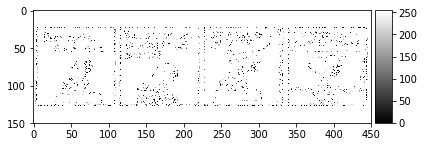

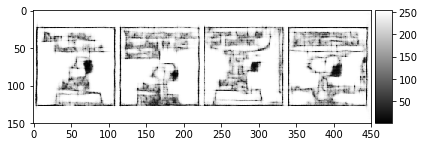

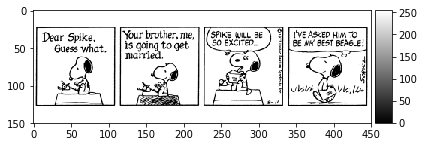

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


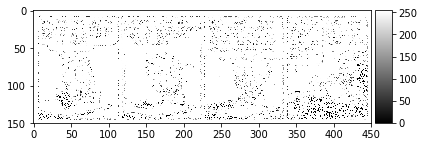

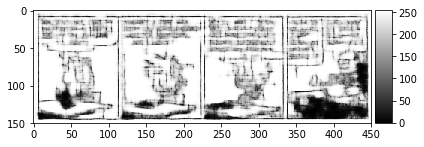

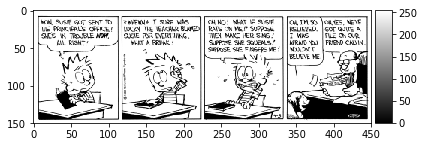

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


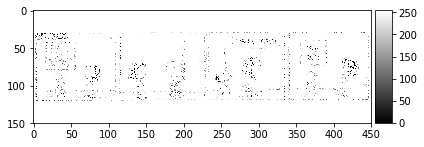

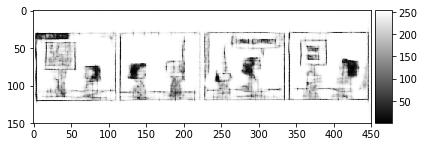

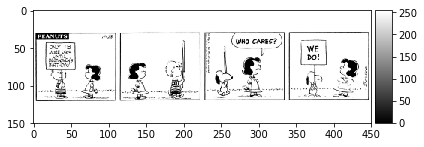

step  0 / 7367 d_loss:  6.061805470380932e-05 g_loss:  [17.86602, 0.16849394, 1.016627]
step  1 / 7367 d_loss:  0.00017719368042889982 g_loss:  [21.138214, 0.20103839, 1.0343738]
step  2 / 7367 d_loss:  6.82545169183868e-06 g_loss:  [26.94145, 0.25921667, 1.0197824]
step  3 / 7367 d_loss:  9.079481969820336e-05 g_loss:  [30.99287, 0.29994577, 0.9982922]
step  4 / 7367 d_loss:  0.00012397157843224704 g_loss:  [15.685, 0.1470732, 0.9776816]
step  5 / 7367 d_loss:  1.2360530490695965e-05 g_loss:  [34.566723, 0.33527112, 1.0396124]
step  6 / 7367 d_loss:  0.0002622577885631472 g_loss:  [18.42341, 0.17384806, 1.0386056]
step  7 / 7367 d_loss:  3.6363206163514405e-05 g_loss:  [29.636871, 0.28621286, 1.0155855]
step  8 / 7367 d_loss:  0.00012138816964579746 g_loss:  [22.496143, 0.21503527, 0.9926166]
step  9 / 7367 d_loss:  5.258182227407815e-06 g_loss:  [30.422235, 0.29433256, 0.9889797]
step  10 / 7367 d_loss:  6.488500366685912e-05 g_loss:  [32.964016, 0.31956065, 1.0079515]
step  11 / 736

step  91 / 7367 d_loss:  0.00019906899251509458 g_loss:  [22.059872, 0.21041462, 1.01841]
step  92 / 7367 d_loss:  8.68891438585706e-05 g_loss:  [21.844793, 0.20850037, 0.99475634]
step  93 / 7367 d_loss:  6.50822403258644e-05 g_loss:  [29.001078, 0.280247, 0.9763782]
step  94 / 7367 d_loss:  0.00047928461572155356 g_loss:  [28.803745, 0.27851802, 0.95194274]
step  95 / 7367 d_loss:  0.00017030630260705948 g_loss:  [33.5103, 0.32520214, 0.99008524]
step  96 / 7367 d_loss:  0.00014854440814815462 g_loss:  [23.768991, 0.22775652, 0.99333984]
step  97 / 7367 d_loss:  0.0002135967370122671 g_loss:  [23.900858, 0.22864856, 1.036001]
step  98 / 7367 d_loss:  0.0007326609338633716 g_loss:  [17.98039, 0.16918916, 1.0614754]
step  99 / 7367 d_loss:  7.709131023148075e-05 g_loss:  [32.147053, 0.31129727, 1.0173271]
step  100 / 7367 d_loss:  4.821677066502161e-05 g_loss:  [22.537096, 0.21582793, 0.9543035]
step  101 / 7367 d_loss:  4.353372423793189e-05 g_loss:  [33.991806, 0.33005428, 0.986379]


step  181 / 7367 d_loss:  6.997212494752603e-06 g_loss:  [30.262497, 0.29264814, 0.9976831]
step  182 / 7367 d_loss:  0.00012172344577265903 g_loss:  [16.688421, 0.15707158, 0.98126435]
step  183 / 7367 d_loss:  1.91950657608686e-05 g_loss:  [33.129856, 0.32137632, 0.9922213]
step  184 / 7367 d_loss:  0.00014516091323457658 g_loss:  [30.91006, 0.29935813, 0.9742476]
step  185 / 7367 d_loss:  3.855107934214175e-05 g_loss:  [22.515776, 0.21523927, 0.99184763]
step  186 / 7367 d_loss:  0.0003795445372816175 g_loss:  [19.926056, 0.18903454, 1.0226024]
step  187 / 7367 d_loss:  1.9264218281023204e-05 g_loss:  [25.89367, 0.24901025, 0.99264276]
step  188 / 7367 d_loss:  0.00011051901674363762 g_loss:  [28.191204, 0.27216443, 0.9747592]
step  189 / 7367 d_loss:  0.00028765277238562703 g_loss:  [15.452112, 0.14434129, 1.0179837]
step  190 / 7367 d_loss:  3.177494727424346e-05 g_loss:  [33.117405, 0.32123536, 0.99386954]
step  191 / 7367 d_loss:  2.2555052055395208e-05 g_loss:  [22.39771, 0.214

step  271 / 7367 d_loss:  0.0003051614621654153 g_loss:  [16.070997, 0.1504952, 1.0214759]
step  272 / 7367 d_loss:  0.000155611865920946 g_loss:  [19.662739, 0.18645833, 1.0169046]
step  273 / 7367 d_loss:  0.00039455815567635 g_loss:  [15.741165, 0.1468091, 1.0602547]
step  274 / 7367 d_loss:  0.0003147530369460583 g_loss:  [21.68039, 0.2067055, 1.0098393]
step  275 / 7367 d_loss:  0.00010284694144502282 g_loss:  [23.130547, 0.22060545, 1.0700011]
step  276 / 7367 d_loss:  0.0013222001725807786 g_loss:  [30.071777, 0.28966963, 1.104815]
step  277 / 7367 d_loss:  9.79296601144597e-05 g_loss:  [21.794167, 0.20753336, 1.04083]
step  278 / 7367 d_loss:  0.00041760047315619886 g_loss:  [23.78527, 0.22753747, 1.0315242]
step  279 / 7367 d_loss:  0.0004929109127260745 g_loss:  [19.888294, 0.18870421, 1.0178747]
step  280 / 7367 d_loss:  0.001174804288893938 g_loss:  [16.258883, 0.15357922, 0.9009616]
step  281 / 7367 d_loss:  7.5175215897616e-05 g_loss:  [22.967394, 0.2198002, 0.9873734]
st

step  363 / 7367 d_loss:  2.5978022677008994e-05 g_loss:  [26.31324, 0.25324473, 0.9887676]
step  364 / 7367 d_loss:  3.633744199760258e-06 g_loss:  [27.460966, 0.26463413, 0.9975526]
step  365 / 7367 d_loss:  3.887577349814819e-06 g_loss:  [25.832588, 0.248213, 1.0112894]
step  366 / 7367 d_loss:  1.2068808246112894e-05 g_loss:  [24.814436, 0.23820905, 0.9935298]
step  367 / 7367 d_loss:  0.0002452452899888158 g_loss:  [17.927156, 0.16964176, 0.96298057]
step  368 / 7367 d_loss:  3.921642473869724e-06 g_loss:  [23.455332, 0.22447202, 1.0081303]
step  369 / 7367 d_loss:  7.526772969868034e-05 g_loss:  [28.223476, 0.27201718, 1.0217581]
step  370 / 7367 d_loss:  4.64869081042707e-05 g_loss:  [22.577482, 0.21589214, 0.98826736]
step  371 / 7367 d_loss:  2.3603191948495805e-05 g_loss:  [17.95152, 0.16974607, 0.9769143]
step  372 / 7367 d_loss:  3.0211833291104995e-05 g_loss:  [29.484337, 0.28488293, 0.9960438]
step  373 / 7367 d_loss:  2.0323419448686764e-05 g_loss:  [19.338743, 0.1834211

step  453 / 7367 d_loss:  1.5054011782922316e-05 g_loss:  [35.56665, 0.3453354, 1.0331116]
step  454 / 7367 d_loss:  2.1233377992757596e-05 g_loss:  [16.109282, 0.15124272, 0.98500955]
step  455 / 7367 d_loss:  0.0003236861084587872 g_loss:  [26.119713, 0.25071475, 1.048239]
step  456 / 7367 d_loss:  2.002589826588519e-05 g_loss:  [30.208605, 0.29217103, 0.9915]
step  457 / 7367 d_loss:  1.8589715182315558e-05 g_loss:  [23.321705, 0.22308554, 1.0131507]
step  458 / 7367 d_loss:  0.0002764338569249958 g_loss:  [20.358702, 0.19389525, 0.96917707]
step  459 / 7367 d_loss:  5.403139948612079e-05 g_loss:  [18.35207, 0.17352718, 0.99935067]
step  460 / 7367 d_loss:  1.5682215234846808e-05 g_loss:  [33.58383, 0.32574084, 1.009747]
step  461 / 7367 d_loss:  0.0002749850391410291 g_loss:  [22.64649, 0.21647315, 0.9991762]
step  462 / 7367 d_loss:  1.9745122699532658e-05 g_loss:  [31.280674, 0.30296916, 0.9837598]
step  463 / 7367 d_loss:  0.00010811071842908859 g_loss:  [27.339293, 0.263533, 0.

step  544 / 7367 d_loss:  9.052496898220852e-05 g_loss:  [28.469872, 0.27434492, 1.0353801]
step  545 / 7367 d_loss:  3.098582601523958e-05 g_loss:  [26.212276, 0.25179094, 1.0331815]
step  546 / 7367 d_loss:  0.00036050117341801524 g_loss:  [30.813255, 0.2977012, 1.0431342]
step  547 / 7367 d_loss:  3.143345020362176e-05 g_loss:  [21.35746, 0.20367865, 0.98959506]
step  548 / 7367 d_loss:  6.0399317590054125e-05 g_loss:  [20.210335, 0.19236359, 0.9739764]
step  549 / 7367 d_loss:  0.0002463938435539603 g_loss:  [28.977694, 0.27975613, 1.0020803]
step  550 / 7367 d_loss:  1.861799682956189e-05 g_loss:  [30.000679, 0.28988233, 1.0124458]
step  551 / 7367 d_loss:  5.534275624086149e-05 g_loss:  [29.467253, 0.28444418, 1.0228344]
step  552 / 7367 d_loss:  0.0003261248057242483 g_loss:  [22.90766, 0.2187597, 1.0316883]
step  553 / 7367 d_loss:  9.493492143519688e-06 g_loss:  [22.590527, 0.2159758, 0.99294597]
step  554 / 7367 d_loss:  3.572149216779508e-05 g_loss:  [31.732433, 0.30742684, 

step  634 / 7367 d_loss:  0.0001805211213650182 g_loss:  [24.807014, 0.23820452, 0.98656297]
step  635 / 7367 d_loss:  0.00015184408403001726 g_loss:  [18.710646, 0.17773797, 0.9368488]
step  636 / 7367 d_loss:  3.739151725312695e-05 g_loss:  [26.066853, 0.25105295, 0.96155745]
step  637 / 7367 d_loss:  8.751245331950486e-05 g_loss:  [22.061005, 0.21159874, 0.90112996]
step  638 / 7367 d_loss:  0.000891890493221581 g_loss:  [24.212273, 0.23296162, 0.9161115]
step  639 / 7367 d_loss:  0.0007289809291251004 g_loss:  [20.686285, 0.19748278, 0.9380067]
step  640 / 7367 d_loss:  1.9561466615414247e-05 g_loss:  [25.429077, 0.2444422, 0.9848576]
step  641 / 7367 d_loss:  6.389039481291547e-05 g_loss:  [18.799047, 0.17841806, 0.95724076]
step  642 / 7367 d_loss:  1.5023335436126217e-05 g_loss:  [31.542984, 0.3053799, 1.0049927]
step  643 / 7367 d_loss:  2.2542030819749925e-06 g_loss:  [23.28288, 0.22315939, 0.9669427]
step  644 / 7367 d_loss:  0.0007242127903737128 g_loss:  [17.102987, 0.16142

step  725 / 7367 d_loss:  1.013305791275343e-05 g_loss:  [24.120275, 0.23109707, 1.010568]
step  726 / 7367 d_loss:  3.8357044104486704e-05 g_loss:  [24.419891, 0.23408325, 1.0115653]
step  727 / 7367 d_loss:  6.31012735539116e-05 g_loss:  [25.6392, 0.2465415, 0.9850498]
step  728 / 7367 d_loss:  8.468951273243874e-05 g_loss:  [32.014614, 0.30989963, 1.02465]
step  729 / 7367 d_loss:  3.417295010876842e-05 g_loss:  [33.57153, 0.32587805, 0.98372304]
step  730 / 7367 d_loss:  0.0001463589578634128 g_loss:  [19.624718, 0.1858393, 1.0407879]
step  731 / 7367 d_loss:  8.130198693834245e-06 g_loss:  [24.903053, 0.23908272, 0.9947821]
step  732 / 7367 d_loss:  9.198751627081947e-07 g_loss:  [28.254932, 0.27256933, 0.9979995]
step  733 / 7367 d_loss:  2.8905715225846507e-06 g_loss:  [25.753998, 0.24759734, 0.99426556]
step  734 / 7367 d_loss:  5.2927549404557794e-05 g_loss:  [23.675732, 0.22681591, 0.994141]
step  735 / 7367 d_loss:  0.0003156086604576558 g_loss:  [25.376348, 0.24415289, 0.96

step  816 / 7367 d_loss:  0.00023049613810144365 g_loss:  [24.186035, 0.23239966, 0.94607013]
step  817 / 7367 d_loss:  1.2088693438272458e-05 g_loss:  [20.198895, 0.19210877, 0.9880184]
step  818 / 7367 d_loss:  7.297172851394862e-05 g_loss:  [21.95926, 0.20964551, 0.99471045]
step  819 / 7367 d_loss:  0.001273716101422906 g_loss:  [23.528038, 0.22585686, 0.9423527]
step  820 / 7367 d_loss:  8.822661766316742e-05 g_loss:  [16.95833, 0.15926434, 1.0318961]
step  821 / 7367 d_loss:  9.010106441564858e-05 g_loss:  [35.651432, 0.34645224, 1.0062062]
step  822 / 7367 d_loss:  0.0005011647008359432 g_loss:  [21.29893, 0.202511, 1.0478284]
step  823 / 7367 d_loss:  0.0002190635132137686 g_loss:  [24.184317, 0.23155692, 1.0286236]
step  824 / 7367 d_loss:  0.0012360535329207778 g_loss:  [20.774284, 0.19707927, 1.0663562]
step  825 / 7367 d_loss:  1.727554808894638e-05 g_loss:  [23.070293, 0.2208893, 0.98136264]
step  826 / 7367 d_loss:  0.00013860009494237602 g_loss:  [19.499456, 0.18540628, 

step  906 / 7367 d_loss:  3.975803792855004e-06 g_loss:  [28.266338, 0.2727547, 0.9908667]
step  907 / 7367 d_loss:  2.4159389795386232e-05 g_loss:  [22.791838, 0.21828249, 0.9635887]
step  908 / 7367 d_loss:  5.019983291276731e-06 g_loss:  [23.98562, 0.22988547, 0.9970728]
step  909 / 7367 d_loss:  0.00022650831670034677 g_loss:  [60.449535, 0.5948267, 0.96686536]
step  910 / 7367 d_loss:  0.00027471501380205154 g_loss:  [26.229687, 0.25244102, 0.9855846]
step  911 / 7367 d_loss:  4.536045162240043e-05 g_loss:  [29.99952, 0.2899293, 1.00659]
step  912 / 7367 d_loss:  4.315123806009069e-05 g_loss:  [12.585709, 0.11573212, 1.0124974]
step  913 / 7367 d_loss:  0.00030303176026791334 g_loss:  [21.101326, 0.20074151, 1.027173]
step  914 / 7367 d_loss:  0.00014074071077629924 g_loss:  [27.538483, 0.26525706, 1.0127764]
step  915 / 7367 d_loss:  1.0380854291724972e-05 g_loss:  [34.70301, 0.3372253, 0.98048186]
step  916 / 7367 d_loss:  5.675038664776366e-06 g_loss:  [22.246197, 0.21266346, 0

step  996 / 7367 d_loss:  0.00011729064863175154 g_loss:  [21.049059, 0.20053536, 0.99552405]
step  997 / 7367 d_loss:  0.00012508936924859881 g_loss:  [26.15216, 0.2511411, 1.0380492]
step  998 / 7367 d_loss:  0.00019264938600827008 g_loss:  [28.876108, 0.2787217, 1.0039389]
step  999 / 7367 d_loss:  0.00017303653294220567 g_loss:  [20.109266, 0.1907768, 1.0315871]
step  1000 / 7367 d_loss:  8.765763777773827e-05 g_loss:  [36.3556, 0.35375395, 0.9802006]
step  1001 / 7367 d_loss:  0.000314137403620407 g_loss:  [31.057356, 0.3000423, 1.053125]
step  1002 / 7367 d_loss:  9.303558908868581e-05 g_loss:  [26.799242, 0.25780034, 1.0192089]
step  1003 / 7367 d_loss:  0.0003992613055743277 g_loss:  [19.35449, 0.18319418, 1.0350717]
step  1004 / 7367 d_loss:  4.4287036871537566e-05 g_loss:  [21.999807, 0.21019149, 0.980658]
step  1005 / 7367 d_loss:  0.00022958015324547887 g_loss:  [18.554981, 0.17537144, 1.0178372]
step  1006 / 7367 d_loss:  0.00027889834018424153 g_loss:  [18.939974, 0.17977

step  1086 / 7367 d_loss:  0.001353260944597423 g_loss:  [21.092434, 0.2018298, 0.90945196]
step  1087 / 7367 d_loss:  0.0003376622626092285 g_loss:  [31.22926, 0.30257818, 0.9714417]
step  1088 / 7367 d_loss:  0.0008859713561832905 g_loss:  [15.978147, 0.14927539, 1.0506076]
step  1089 / 7367 d_loss:  5.172038800083101e-05 g_loss:  [26.40555, 0.25394446, 1.0111042]
step  1090 / 7367 d_loss:  8.71616939548403e-05 g_loss:  [27.004398, 0.25991598, 1.0127994]
step  1091 / 7367 d_loss:  0.0001662472786847502 g_loss:  [17.89883, 0.16912934, 0.9858972]
step  1092 / 7367 d_loss:  0.0001618273090571165 g_loss:  [27.240316, 0.26237458, 1.0028597]
step  1093 / 7367 d_loss:  0.00032414274755865335 g_loss:  [26.183266, 0.25236863, 0.9464032]
step  1094 / 7367 d_loss:  0.00027612250414676964 g_loss:  [28.865688, 0.27836034, 1.0296551]
step  1095 / 7367 d_loss:  7.14817870175466e-05 g_loss:  [21.20948, 0.20197289, 1.0121925]
step  1096 / 7367 d_loss:  9.966013749362901e-05 g_loss:  [15.464718, 0.144

step  1176 / 7367 d_loss:  0.0005132344085723162 g_loss:  [22.188543, 0.2124445, 0.94409364]
step  1177 / 7367 d_loss:  1.108888227463467e-06 g_loss:  [35.096203, 0.3407614, 1.0200641]
step  1178 / 7367 d_loss:  2.0966621377738193e-05 g_loss:  [25.614513, 0.24620982, 0.99353147]
step  1179 / 7367 d_loss:  0.0005777521291747689 g_loss:  [16.029116, 0.14980635, 1.0484809]
step  1180 / 7367 d_loss:  0.0002825781994033605 g_loss:  [28.7355, 0.27700838, 1.0346631]
step  1181 / 7367 d_loss:  4.627511589205824e-05 g_loss:  [25.278687, 0.24305336, 0.9733512]
step  1182 / 7367 d_loss:  5.3698917326983064e-05 g_loss:  [22.303616, 0.21285291, 1.0183241]
step  1183 / 7367 d_loss:  0.00010409684909973294 g_loss:  [24.916721, 0.2393983, 0.97688985]
step  1184 / 7367 d_loss:  3.593641667976044e-05 g_loss:  [20.167988, 0.19178724, 0.98926365]
step  1185 / 7367 d_loss:  0.00012326333671808243 g_loss:  [28.85939, 0.27885538, 0.97385204]
step  1186 / 7367 d_loss:  3.159427433274686e-05 g_loss:  [25.02741

step  1266 / 7367 d_loss:  8.008437362150289e-06 g_loss:  [16.115206, 0.15148886, 0.9663198]
step  1267 / 7367 d_loss:  3.0450599297182634e-05 g_loss:  [20.376835, 0.19388495, 0.98834074]
step  1268 / 7367 d_loss:  0.0001714534155325964 g_loss:  [32.922157, 0.31887987, 1.0341711]
step  1269 / 7367 d_loss:  5.862105354026426e-06 g_loss:  [29.783632, 0.2878434, 0.99929297]
step  1270 / 7367 d_loss:  6.407695991583751e-07 g_loss:  [27.272104, 0.26278967, 0.99313736]
step  1271 / 7367 d_loss:  0.0002743969962466508 g_loss:  [28.607225, 0.2764724, 0.9599864]
step  1272 / 7367 d_loss:  2.64099116975558e-06 g_loss:  [21.384172, 0.20387636, 0.9965354]
step  1273 / 7367 d_loss:  1.0949865099973977e-05 g_loss:  [27.432983, 0.26421124, 1.0118603]
step  1274 / 7367 d_loss:  0.0003009344800375402 g_loss:  [17.195349, 0.16166675, 1.0286739]
step  1275 / 7367 d_loss:  4.457535851543071e-06 g_loss:  [26.910059, 0.25906935, 1.0031238]
step  1276 / 7367 d_loss:  3.904875484295189e-06 g_loss:  [22.47769,

step  1357 / 7367 d_loss:  1.2845092896895949e-05 g_loss:  [27.381342, 0.26369596, 1.0117466]
step  1358 / 7367 d_loss:  0.000412493827752769 g_loss:  [16.155207, 0.15197664, 0.95754206]
step  1359 / 7367 d_loss:  0.00024692987790331244 g_loss:  [26.204432, 0.25169274, 1.0351574]
step  1360 / 7367 d_loss:  5.524449989025015e-06 g_loss:  [20.314655, 0.19324376, 0.99028003]
step  1361 / 7367 d_loss:  0.0002180134179070592 g_loss:  [25.696266, 0.24691409, 1.0048586]
step  1362 / 7367 d_loss:  6.697466596961021e-05 g_loss:  [15.108437, 0.14141178, 0.96725875]
step  1363 / 7367 d_loss:  0.000827999145258218 g_loss:  [26.588999, 0.2564001, 0.94898784]
step  1364 / 7367 d_loss:  0.0003181208739988506 g_loss:  [27.609276, 0.26654583, 0.9546933]
step  1365 / 7367 d_loss:  0.0001359300222247839 g_loss:  [27.85392, 0.26882967, 0.97095245]
step  1366 / 7367 d_loss:  1.960970985237509e-05 g_loss:  [20.56081, 0.19567885, 0.99292654]
step  1367 / 7367 d_loss:  6.932338874321431e-05 g_loss:  [15.23644

step  1447 / 7367 d_loss:  1.908444346554461e-06 g_loss:  [23.355663, 0.22353004, 1.0026597]
step  1448 / 7367 d_loss:  0.00022796685516368598 g_loss:  [22.84697, 0.21810657, 1.0363119]
step  1449 / 7367 d_loss:  1.2015839274681639e-05 g_loss:  [20.063269, 0.19069299, 0.9939689]
step  1450 / 7367 d_loss:  0.0004927834961563349 g_loss:  [25.43811, 0.24487387, 0.9507244]
step  1451 / 7367 d_loss:  1.7196030967170373e-05 g_loss:  [16.622341, 0.15611707, 1.0106349]
step  1452 / 7367 d_loss:  2.7551914172363468e-05 g_loss:  [18.930702, 0.1793158, 0.9991233]
step  1453 / 7367 d_loss:  0.0002842581598088145 g_loss:  [18.573425, 0.17598467, 0.97495794]
step  1454 / 7367 d_loss:  9.065719495993108e-06 g_loss:  [26.232534, 0.25234482, 0.99805284]
step  1455 / 7367 d_loss:  6.643921369686723e-05 g_loss:  [32.373825, 0.31338784, 1.0350424]
step  1456 / 7367 d_loss:  7.810625538695604e-05 g_loss:  [21.57634, 0.2060046, 0.9758798]
step  1457 / 7367 d_loss:  5.303641955833882e-05 g_loss:  [23.960386,

step  1537 / 7367 d_loss:  2.461320491420338e-06 g_loss:  [28.40728, 0.2741101, 0.99626845]
step  1538 / 7367 d_loss:  0.00013596592179965228 g_loss:  [29.948364, 0.28919613, 1.0287522]
step  1539 / 7367 d_loss:  7.364838529611006e-05 g_loss:  [17.672693, 0.16655697, 1.0169955]
step  1540 / 7367 d_loss:  4.22947050537914e-06 g_loss:  [34.022842, 0.33027652, 0.9951907]
step  1541 / 7367 d_loss:  4.8190327106567565e-06 g_loss:  [28.697483, 0.27686727, 1.0107547]
step  1542 / 7367 d_loss:  2.1407491658465005e-05 g_loss:  [30.019777, 0.29032606, 0.98717195]
step  1543 / 7367 d_loss:  0.0005056297522969544 g_loss:  [29.529043, 0.2857334, 0.95570326]
step  1544 / 7367 d_loss:  0.0001714186364552006 g_loss:  [15.326111, 0.14346132, 0.97997963]
step  1545 / 7367 d_loss:  4.0124132283381186e-07 g_loss:  [31.730045, 0.30713028, 1.0170174]
step  1546 / 7367 d_loss:  1.9160312149324454e-05 g_loss:  [22.482847, 0.21476594, 1.0062542]
step  1547 / 7367 d_loss:  7.16851936886087e-05 g_loss:  [21.0334

step  1628 / 7367 d_loss:  7.239421393023804e-05 g_loss:  [24.371557, 0.23385946, 0.98561066]
step  1629 / 7367 d_loss:  1.7566076166986022e-06 g_loss:  [23.418793, 0.22434622, 0.98417026]
step  1630 / 7367 d_loss:  0.00045008043525740504 g_loss:  [23.298042, 0.22367945, 0.93009734]
step  1631 / 7367 d_loss:  0.0002626915811561048 g_loss:  [29.989656, 0.29036164, 0.9534922]
step  1632 / 7367 d_loss:  5.3375835705082864e-05 g_loss:  [29.569723, 0.28581032, 0.9886916]
step  1633 / 7367 d_loss:  2.4117607608786784e-05 g_loss:  [25.626324, 0.24647333, 0.978991]
step  1634 / 7367 d_loss:  0.00013559497892856598 g_loss:  [19.780151, 0.18805715, 0.9744356]
step  1635 / 7367 d_loss:  2.7541864255908877e-05 g_loss:  [23.249063, 0.22254734, 0.9943301]
step  1636 / 7367 d_loss:  0.0008500305702909827 g_loss:  [27.075613, 0.2600868, 1.0669318]
step  1637 / 7367 d_loss:  0.000814864004496485 g_loss:  [22.408726, 0.21361093, 1.0476327]
step  1638 / 7367 d_loss:  0.0003470862575341016 g_loss:  [28.13

step  1719 / 7367 d_loss:  1.0522524462430738e-05 g_loss:  [15.66945, 0.14677966, 0.99148446]
step  1720 / 7367 d_loss:  1.6643850813125027e-06 g_loss:  [21.646889, 0.20654471, 0.99241734]
step  1721 / 7367 d_loss:  3.76538337150123e-05 g_loss:  [25.50337, 0.24516186, 0.98718375]
step  1722 / 7367 d_loss:  5.616516887130274e-07 g_loss:  [27.485949, 0.26478183, 1.007765]
step  1723 / 7367 d_loss:  2.3129470719140954e-05 g_loss:  [34.76064, 0.33743784, 1.016858]
step  1724 / 7367 d_loss:  1.0485694474482443e-05 g_loss:  [28.63418, 0.276438, 0.9903821]
step  1725 / 7367 d_loss:  2.7830106773762964e-05 g_loss:  [23.595734, 0.22590758, 1.0049772]
step  1726 / 7367 d_loss:  0.00010182547703152522 g_loss:  [31.744123, 0.30771247, 0.97287726]
step  1727 / 7367 d_loss:  0.00017068385204765946 g_loss:  [31.50404, 0.30531433, 0.97260624]
step  1728 / 7367 d_loss:  5.385009444580646e-06 g_loss:  [32.252724, 0.31253392, 0.9993316]
step  1729 / 7367 d_loss:  0.00010077520710183308 g_loss:  [32.15382

step  1809 / 7367 d_loss:  0.0004263285081833601 g_loss:  [22.858953, 0.21821597, 1.0373546]
step  1810 / 7367 d_loss:  2.80091580862063e-06 g_loss:  [31.040157, 0.30055332, 0.9848259]
step  1811 / 7367 d_loss:  5.308353865984827e-05 g_loss:  [24.981379, 0.24014387, 0.96699196]
step  1812 / 7367 d_loss:  5.746086571889464e-06 g_loss:  [33.418636, 0.32423955, 0.99468154]
step  1813 / 7367 d_loss:  1.1096954949607607e-05 g_loss:  [31.357697, 0.30379206, 0.9784915]
step  1814 / 7367 d_loss:  0.00025004695635288954 g_loss:  [17.66761, 0.16711293, 0.95631844]
step  1815 / 7367 d_loss:  0.00010159197699977085 g_loss:  [19.323246, 0.1835472, 0.96852714]
step  1816 / 7367 d_loss:  0.0001322337193414569 g_loss:  [27.492184, 0.26524922, 0.9672614]
step  1817 / 7367 d_loss:  1.7538113752380013e-06 g_loss:  [23.026457, 0.2201916, 1.0072981]
step  1818 / 7367 d_loss:  0.00012999767204746604 g_loss:  [30.938934, 0.2991826, 1.0206751]
step  1819 / 7367 d_loss:  0.00010641399421729147 g_loss:  [29.933

step  1897 / 7367 d_loss:  4.177775281277718e-06 g_loss:  [19.036419, 0.18036386, 1.0000315]
step  1898 / 7367 d_loss:  4.17954615841154e-05 g_loss:  [18.63458, 0.17627454, 1.0071275]
step  1899 / 7367 d_loss:  8.232304389821365e-05 g_loss:  [28.020756, 0.27039486, 0.9812698]
step  1900 / 7367 d_loss:  8.723411156097427e-05 g_loss:  [20.483482, 0.1948999, 0.99349225]
step  1901 / 7367 d_loss:  1.7428355931770056e-05 g_loss:  [23.669685, 0.22647408, 1.0222775]
step  1902 / 7367 d_loss:  3.4488825804146472e-06 g_loss:  [30.877928, 0.2988065, 0.9972785]
step  1903 / 7367 d_loss:  6.674911219306523e-07 g_loss:  [25.945318, 0.24944422, 1.0008967]
step  1904 / 7367 d_loss:  6.419003511837218e-06 g_loss:  [23.511621, 0.22515792, 0.9958311]
step  1905 / 7367 d_loss:  2.3499593226006255e-05 g_loss:  [29.900639, 0.28896758, 1.0038822]
step  1906 / 7367 d_loss:  1.3096518159727566e-05 g_loss:  [23.493578, 0.22504826, 0.98875296]
step  1907 / 7367 d_loss:  1.2655998943955638e-05 g_loss:  [26.44424

step  1986 / 7367 d_loss:  1.8924052938018576e-06 g_loss:  [26.400953, 0.25404787, 0.99616694]
step  1987 / 7367 d_loss:  7.58901223889552e-05 g_loss:  [24.785086, 0.2378158, 1.0035062]
step  1988 / 7367 d_loss:  4.966686537954956e-05 g_loss:  [17.427286, 0.16429327, 0.9979599]
step  1989 / 7367 d_loss:  7.463219662895426e-05 g_loss:  [34.848698, 0.33871, 0.97769666]
step  1990 / 7367 d_loss:  1.3723971278523095e-05 g_loss:  [25.143135, 0.24153724, 0.98941]
step  1991 / 7367 d_loss:  1.2545161553134676e-05 g_loss:  [24.044344, 0.23045987, 0.9983569]
step  1992 / 7367 d_loss:  2.068684125333675e-06 g_loss:  [22.031208, 0.21040778, 0.9904306]
step  1993 / 7367 d_loss:  5.87457066103525e-07 g_loss:  [30.793827, 0.29800013, 0.99381536]
step  1994 / 7367 d_loss:  0.00012534935376606882 g_loss:  [35.710663, 0.34688467, 1.0221989]
step  1995 / 7367 d_loss:  5.909762990086165e-07 g_loss:  [32.73394, 0.31738704, 0.9952339]
step  1996 / 7367 d_loss:  8.163739039446227e-06 g_loss:  [29.442472, 0.

step  2075 / 7367 d_loss:  6.327503069769591e-05 g_loss:  [18.388016, 0.1739572, 0.9922955]
step  2076 / 7367 d_loss:  2.6482488465262577e-05 g_loss:  [23.09784, 0.22105862, 0.99197716]
step  2077 / 7367 d_loss:  1.2482767488108948e-05 g_loss:  [34.095833, 0.33102152, 0.9936838]
step  2078 / 7367 d_loss:  9.913437679642811e-06 g_loss:  [31.66227, 0.30646306, 1.0159636]
step  2079 / 7367 d_loss:  6.281985406531021e-05 g_loss:  [20.579998, 0.19561078, 1.0189204]
step  2080 / 7367 d_loss:  1.192588661069749e-05 g_loss:  [26.874136, 0.25880918, 0.9932169]
step  2081 / 7367 d_loss:  2.0709130694740452e-05 g_loss:  [24.886656, 0.23899357, 0.9872981]
step  2082 / 7367 d_loss:  9.48819342738716e-06 g_loss:  [20.353752, 0.19356695, 0.99705625]
step  2083 / 7367 d_loss:  1.1130918210255913e-05 g_loss:  [17.657707, 0.16665286, 0.9924215]
step  2084 / 7367 d_loss:  5.388738281908445e-05 g_loss:  [30.076614, 0.29086122, 0.99049157]
step  2085 / 7367 d_loss:  7.882012141635641e-06 g_loss:  [21.04347

step  2165 / 7367 d_loss:  1.939809635587153e-06 g_loss:  [21.334415, 0.20342378, 0.99203604]
step  2166 / 7367 d_loss:  2.0834700990235433e-05 g_loss:  [26.563986, 0.25575408, 0.98857737]
step  2167 / 7367 d_loss:  0.00015773848281241953 g_loss:  [29.166876, 0.28195447, 0.97143036]
step  2168 / 7367 d_loss:  2.5667062800494023e-05 g_loss:  [16.765778, 0.1577856, 0.98721814]
step  2169 / 7367 d_loss:  9.582902471549914e-09 g_loss:  [28.963572, 0.27959096, 1.0044746]
step  2170 / 7367 d_loss:  1.4177593584463466e-05 g_loss:  [33.676266, 0.32674277, 1.0019865]
step  2171 / 7367 d_loss:  0.0001339074515271932 g_loss:  [29.689175, 0.28658304, 1.0308695]
step  2172 / 7367 d_loss:  0.00024665266391821206 g_loss:  [19.01058, 0.17977548, 1.033034]
step  2173 / 7367 d_loss:  1.6281634316328564e-06 g_loss:  [26.40965, 0.2542232, 0.9873319]
step  2174 / 7367 d_loss:  6.74033144605346e-05 g_loss:  [27.163168, 0.2618711, 0.9760562]
step  2175 / 7367 d_loss:  1.7508156815893017e-05 g_loss:  [19.9175

step  2254 / 7367 d_loss:  9.351121661893558e-06 g_loss:  [33.885765, 0.32858676, 1.0270882]
step  2255 / 7367 d_loss:  9.340632823295891e-05 g_loss:  [18.03831, 0.1701863, 1.0196807]
step  2256 / 7367 d_loss:  2.602666199891246e-06 g_loss:  [19.628002, 0.18629895, 0.9981082]
step  2257 / 7367 d_loss:  5.603592398983892e-06 g_loss:  [22.478214, 0.21482779, 0.9954361]
step  2258 / 7367 d_loss:  0.0005313047440722585 g_loss:  [23.302536, 0.22316143, 0.9863926]
step  2259 / 7367 d_loss:  0.00033498916309326887 g_loss:  [20.161207, 0.19117089, 1.0441186]
step  2260 / 7367 d_loss:  1.8559949239715934e-05 g_loss:  [19.669022, 0.18674098, 0.9949242]
step  2261 / 7367 d_loss:  0.00016656065417919308 g_loss:  [19.31019, 0.18304157, 1.0060322]
step  2262 / 7367 d_loss:  4.527915734797716e-05 g_loss:  [19.091267, 0.18117295, 0.97397214]
step  2263 / 7367 d_loss:  0.00016692618373781443 g_loss:  [33.588013, 0.32616064, 0.97194904]
step  2264 / 7367 d_loss:  6.745473228875198e-07 g_loss:  [21.03444

step  2345 / 7367 d_loss:  9.372897329740226e-05 g_loss:  [15.845619, 0.14836863, 1.0087564]
step  2346 / 7367 d_loss:  1.1717258530552499e-05 g_loss:  [31.559147, 0.30562744, 0.99640274]
step  2347 / 7367 d_loss:  2.752600994426757e-05 g_loss:  [21.0551, 0.20074852, 0.9802477]
step  2348 / 7367 d_loss:  4.706721938418923e-06 g_loss:  [19.667946, 0.18675758, 0.99218756]
step  2349 / 7367 d_loss:  8.328342119057197e-06 g_loss:  [20.725182, 0.19738784, 0.9863973]
step  2350 / 7367 d_loss:  0.00016054269508458674 g_loss:  [15.329091, 0.1432987, 0.9992209]
step  2351 / 7367 d_loss:  5.4921823902986944e-05 g_loss:  [29.76472, 0.28782532, 0.98218966]
step  2352 / 7367 d_loss:  1.901801078929566e-05 g_loss:  [33.614147, 0.3260643, 1.0077174]
step  2353 / 7367 d_loss:  3.9101454603951424e-05 g_loss:  [26.117413, 0.25132072, 0.98534083]
step  2354 / 7367 d_loss:  3.635293251136318e-05 g_loss:  [26.43996, 0.2544503, 0.9949331]
step  2355 / 7367 d_loss:  3.6444380384637043e-06 g_loss:  [27.076939

step  2433 / 7367 d_loss:  2.1421279598143883e-05 g_loss:  [28.665895, 0.2766859, 0.99730706]
step  2434 / 7367 d_loss:  4.39669493061956e-05 g_loss:  [27.442585, 0.2645173, 0.990855]
step  2435 / 7367 d_loss:  8.23560549179092e-05 g_loss:  [25.670929, 0.2464191, 1.0290176]
step  2436 / 7367 d_loss:  1.9024759239982814e-05 g_loss:  [27.957884, 0.26944503, 1.0133802]
step  2437 / 7367 d_loss:  3.3349286240991205e-05 g_loss:  [23.460562, 0.22456425, 1.0041378]
step  2438 / 7367 d_loss:  4.108972916583298e-06 g_loss:  [27.01949, 0.26009852, 1.0096385]
step  2439 / 7367 d_loss:  3.254063631175086e-05 g_loss:  [29.86383, 0.2886873, 0.9951013]
step  2440 / 7367 d_loss:  0.0009848237968981266 g_loss:  [12.785659, 0.118007556, 0.98490363]
step  2441 / 7367 d_loss:  0.0004192639025859535 g_loss:  [22.990063, 0.22038446, 0.95161664]
step  2442 / 7367 d_loss:  0.00030761107336729765 g_loss:  [22.932085, 0.21962048, 0.97003657]
step  2443 / 7367 d_loss:  0.00010097274207510054 g_loss:  [30.713902,

step  2523 / 7367 d_loss:  0.010841082781553268 g_loss:  [15.788456, 0.14787272, 1.0011848]
step  2524 / 7367 d_loss:  8.139655983541161e-05 g_loss:  [18.154417, 0.17103805, 1.050612]
step  2525 / 7367 d_loss:  1.7175061657326296e-05 g_loss:  [21.31745, 0.20288463, 1.0289863]
step  2526 / 7367 d_loss:  0.0004229139012750238 g_loss:  [25.586689, 0.24536215, 1.0504737]
step  2527 / 7367 d_loss:  0.0001917548943310976 g_loss:  [18.066132, 0.16984434, 1.0816976]
step  2528 / 7367 d_loss:  0.0002231477410532534 g_loss:  [30.425621, 0.29460648, 0.9649725]
step  2529 / 7367 d_loss:  0.0003762398555409163 g_loss:  [29.46849, 0.28496504, 0.9719868]
step  2530 / 7367 d_loss:  0.0010832308325916529 g_loss:  [22.470139, 0.2136819, 1.101948]
step  2531 / 7367 d_loss:  5.348879494704306e-05 g_loss:  [23.38786, 0.22370182, 1.0176783]
step  2532 / 7367 d_loss:  0.00017015186313074082 g_loss:  [28.77204, 0.27785274, 0.98676515]
step  2533 / 7367 d_loss:  1.8568825908005238e-05 g_loss:  [26.881418, 0.25

step  2614 / 7367 d_loss:  0.010072510689496994 g_loss:  [17.748783, 0.17012367, 0.736416]
step  2615 / 7367 d_loss:  0.0005773801822215319 g_loss:  [22.475111, 0.2153089, 0.9442189]
step  2616 / 7367 d_loss:  5.934038199484348e-05 g_loss:  [32.906254, 0.31856638, 1.0496167]
step  2617 / 7367 d_loss:  3.2357311283703893e-05 g_loss:  [27.413185, 0.26415765, 0.9974191]
step  2618 / 7367 d_loss:  0.002414617920294404 g_loss:  [22.944183, 0.21806605, 1.137578]
step  2619 / 7367 d_loss:  7.241927232826129e-05 g_loss:  [24.494171, 0.23483883, 1.0102879]
step  2620 / 7367 d_loss:  0.0006935868295840919 g_loss:  [19.146471, 0.18220821, 0.9256494]
step  2621 / 7367 d_loss:  7.904144149506465e-05 g_loss:  [20.248022, 0.19268513, 0.9795101]
step  2622 / 7367 d_loss:  0.0005034944624640048 g_loss:  [26.140104, 0.25063315, 1.0767905]
step  2623 / 7367 d_loss:  2.9997969249961898e-05 g_loss:  [23.381094, 0.22372808, 1.0082854]
step  2624 / 7367 d_loss:  0.005033253226429224 g_loss:  [28.183372, 0.27

step  2703 / 7367 d_loss:  0.0007954504690133035 g_loss:  [17.821152, 0.16881034, 0.9401197]
step  2704 / 7367 d_loss:  1.1263766282354482e-05 g_loss:  [30.599226, 0.29568145, 1.0310816]
step  2705 / 7367 d_loss:  6.553206912940368e-05 g_loss:  [19.156473, 0.1814603, 1.0104427]
step  2706 / 7367 d_loss:  0.00021320045925676823 g_loss:  [31.29084, 0.30299932, 0.9909085]
step  2707 / 7367 d_loss:  0.000664514722302556 g_loss:  [17.415699, 0.16490741, 0.92495716]
step  2708 / 7367 d_loss:  0.0010205289581790566 g_loss:  [23.546392, 0.22614361, 0.93203074]
step  2709 / 7367 d_loss:  0.000772106577642262 g_loss:  [30.097567, 0.28987992, 1.1095753]
step  2710 / 7367 d_loss:  0.00020737817976623774 g_loss:  [31.380785, 0.3033329, 1.0474946]
step  2711 / 7367 d_loss:  0.00026693198014982045 g_loss:  [17.929777, 0.16898277, 1.0314995]
step  2712 / 7367 d_loss:  5.193680772208609e-05 g_loss:  [22.880379, 0.21883307, 0.99707186]
step  2713 / 7367 d_loss:  0.0003689374716486782 g_loss:  [21.961956

step  2792 / 7367 d_loss:  0.00048663627239875495 g_loss:  [19.850992, 0.18849039, 1.0019536]
step  2793 / 7367 d_loss:  0.00028128837584517896 g_loss:  [26.403881, 0.253562, 1.0476791]
step  2794 / 7367 d_loss:  0.00012512145622167736 g_loss:  [22.213419, 0.21245721, 0.9676978]
step  2795 / 7367 d_loss:  3.674535946629476e-06 g_loss:  [21.766457, 0.20778614, 0.98784196]
step  2796 / 7367 d_loss:  0.00017626291082706302 g_loss:  [32.065086, 0.3108804, 0.9770454]
step  2797 / 7367 d_loss:  0.0007557149510830641 g_loss:  [16.390162, 0.15289505, 1.1006559]
step  2798 / 7367 d_loss:  0.0002102051512338221 g_loss:  [14.151941, 0.13149549, 1.002392]
step  2799 / 7367 d_loss:  0.0003422832814976573 g_loss:  [34.621876, 0.33629218, 0.9926576]
step  2800 / 7367 d_loss:  0.0006129750399850309 g_loss:  [24.272675, 0.23347975, 0.92470014]
step  2801 / 7367 d_loss:  0.0006419927813112736 g_loss:  [17.790892, 0.16762431, 1.0284616]
step  2802 / 7367 d_loss:  3.5616019886219874e-05 g_loss:  [30.31521

step  2883 / 7367 d_loss:  2.7802188924397342e-05 g_loss:  [26.87642, 0.2590256, 0.97385836]
step  2884 / 7367 d_loss:  5.108597633807221e-07 g_loss:  [25.579033, 0.24589577, 0.98945636]
step  2885 / 7367 d_loss:  0.00044161075493320823 g_loss:  [15.217668, 0.14132051, 1.0856161]
step  2886 / 7367 d_loss:  2.7397873054724187e-05 g_loss:  [18.318483, 0.17340705, 0.97778]
step  2887 / 7367 d_loss:  2.4620312615297735e-05 g_loss:  [27.125721, 0.2611358, 1.0121428]
step  2888 / 7367 d_loss:  0.0007706600008532405 g_loss:  [23.368767, 0.22446565, 0.92220074]
step  2889 / 7367 d_loss:  0.0010545150144025683 g_loss:  [35.08614, 0.3416184, 0.92430216]
step  2890 / 7367 d_loss:  0.0002547567419242114 g_loss:  [18.596203, 0.17560315, 1.0358882]
step  2891 / 7367 d_loss:  0.00042122360900975764 g_loss:  [28.536144, 0.2748967, 1.0464731]
step  2892 / 7367 d_loss:  2.620683517307043e-05 g_loss:  [25.317528, 0.2432281, 0.99471897]
step  2893 / 7367 d_loss:  2.6768288989842404e-06 g_loss:  [22.624153

step  2972 / 7367 d_loss:  0.0001165038556791842 g_loss:  [28.078892, 0.2711328, 0.9656115]
step  2973 / 7367 d_loss:  0.000219655194086954 g_loss:  [33.964157, 0.3299738, 0.96677816]
step  2974 / 7367 d_loss:  8.750068809604272e-05 g_loss:  [21.220919, 0.20183763, 1.0371555]
step  2975 / 7367 d_loss:  7.487176480935887e-05 g_loss:  [35.048378, 0.340621, 0.9862767]
step  2976 / 7367 d_loss:  0.00528727425262332 g_loss:  [14.958967, 0.14028493, 0.9304747]
step  2977 / 7367 d_loss:  1.3538921848521568e-05 g_loss:  [29.112463, 0.28112766, 0.9996959]
step  2978 / 7367 d_loss:  2.354710886720568e-05 g_loss:  [25.411121, 0.24419467, 0.991654]
step  2979 / 7367 d_loss:  8.536609675502405e-05 g_loss:  [23.600485, 0.22628707, 0.9717787]
step  2980 / 7367 d_loss:  0.0007643443532288074 g_loss:  [22.359491, 0.21430849, 0.928642]
step  2981 / 7367 d_loss:  0.0002921786217484623 g_loss:  [24.284866, 0.23309878, 0.97498804]
step  2982 / 7367 d_loss:  5.0299004215048626e-05 g_loss:  [26.101257, 0.251

step  3062 / 7367 d_loss:  0.00026527291629463434 g_loss:  [22.696482, 0.21739148, 0.9573344]
step  3063 / 7367 d_loss:  3.6437936046240793e-07 g_loss:  [19.97295, 0.18976718, 0.99623096]
step  3064 / 7367 d_loss:  5.642251926474273e-05 g_loss:  [18.653116, 0.17646946, 1.0061703]
step  3065 / 7367 d_loss:  9.389138540427666e-06 g_loss:  [20.615267, 0.19622844, 0.99242234]
step  3066 / 7367 d_loss:  0.00022264348808676004 g_loss:  [25.005985, 0.23978464, 1.0275203]
step  3067 / 7367 d_loss:  3.54565454472322e-05 g_loss:  [21.504694, 0.20528334, 0.97635984]
step  3068 / 7367 d_loss:  8.619830623501912e-06 g_loss:  [20.982496, 0.19988836, 0.9936593]
step  3069 / 7367 d_loss:  0.00020376217435114086 g_loss:  [19.537128, 0.18512645, 1.0244827]
step  3070 / 7367 d_loss:  1.2352700650808401e-05 g_loss:  [24.087572, 0.2311469, 0.97288126]
step  3071 / 7367 d_loss:  0.00036586233181878924 g_loss:  [22.590025, 0.215479, 1.0421249]
step  3072 / 7367 d_loss:  4.454673398868181e-05 g_loss:  [23.044

step  3150 / 7367 d_loss:  0.00023620126012247056 g_loss:  [31.867958, 0.3081696, 1.0509996]
step  3151 / 7367 d_loss:  5.050846084486693e-06 g_loss:  [28.675732, 0.2767028, 1.0054536]
step  3152 / 7367 d_loss:  1.2540957868623082e-05 g_loss:  [20.68523, 0.1971399, 0.97123826]
step  3153 / 7367 d_loss:  5.4399570217356086e-05 g_loss:  [24.647984, 0.23642196, 1.0057862]
step  3154 / 7367 d_loss:  0.0005093181389383972 g_loss:  [28.518532, 0.27460238, 1.058294]
step  3155 / 7367 d_loss:  3.4596683690324426e-05 g_loss:  [20.28061, 0.19316508, 0.96410215]
step  3156 / 7367 d_loss:  0.0005342281656339765 g_loss:  [29.218975, 0.2827593, 0.94304514]
step  3157 / 7367 d_loss:  7.218445716716815e-07 g_loss:  [23.038677, 0.22034766, 1.0039122]
step  3158 / 7367 d_loss:  2.594945726741571e-06 g_loss:  [30.764322, 0.29751933, 1.0123904]
step  3159 / 7367 d_loss:  9.98679934127722e-06 g_loss:  [20.072412, 0.19074059, 0.9983539]
step  3160 / 7367 d_loss:  3.37390010827221e-05 g_loss:  [24.682596, 0.

step  3238 / 7367 d_loss:  0.00015444689779542387 g_loss:  [24.21984, 0.23196693, 1.0231458]
step  3239 / 7367 d_loss:  1.5574200006085448e-05 g_loss:  [29.61898, 0.28634015, 0.98496693]
step  3240 / 7367 d_loss:  1.0664814453775762e-06 g_loss:  [21.256527, 0.20257631, 0.998895]
step  3241 / 7367 d_loss:  2.622435886223684e-06 g_loss:  [24.707335, 0.23712096, 0.9952387]
step  3242 / 7367 d_loss:  1.4101608030614443e-05 g_loss:  [27.545544, 0.26558647, 0.98689574]
step  3243 / 7367 d_loss:  0.000585624948143959 g_loss:  [23.970495, 0.23004173, 0.96632224]
step  3244 / 7367 d_loss:  5.257908924249932e-05 g_loss:  [29.143534, 0.28178248, 0.9652864]
step  3245 / 7367 d_loss:  3.6694505979539827e-05 g_loss:  [23.269377, 0.22265041, 1.0043346]
step  3246 / 7367 d_loss:  3.838667180389166e-05 g_loss:  [17.591875, 0.16598354, 0.9935203]
step  3247 / 7367 d_loss:  7.455479499185458e-05 g_loss:  [33.376537, 0.32381082, 0.99545485]
step  3248 / 7367 d_loss:  2.3251135644386522e-05 g_loss:  [18.52

step  3327 / 7367 d_loss:  3.2444761473016115e-06 g_loss:  [22.382622, 0.2139775, 0.98487145]
step  3328 / 7367 d_loss:  0.00013794191181659698 g_loss:  [25.29624, 0.24342182, 0.95405746]
step  3329 / 7367 d_loss:  0.0001150356765720062 g_loss:  [18.252253, 0.17304064, 0.9481891]
step  3330 / 7367 d_loss:  0.00038533302722498775 g_loss:  [28.914618, 0.27980754, 0.9338654]
step  3331 / 7367 d_loss:  3.4919790778076276e-05 g_loss:  [23.601767, 0.22598442, 1.0033253]
step  3332 / 7367 d_loss:  0.00017490702157374471 g_loss:  [24.960585, 0.2395976, 1.0008248]
step  3333 / 7367 d_loss:  0.0001124729824368842 g_loss:  [26.954273, 0.25946045, 1.0082282]
step  3334 / 7367 d_loss:  1.8796614313032478e-05 g_loss:  [27.475534, 0.26493853, 0.9816818]
step  3335 / 7367 d_loss:  0.0012795176589861512 g_loss:  [54.488667, 0.53527516, 0.9611502]
step  3336 / 7367 d_loss:  0.0006974080461077392 g_loss:  [22.145838, 0.21112083, 1.0337543]
step  3337 / 7367 d_loss:  9.84531993708515e-07 g_loss:  [25.5233

step  3415 / 7367 d_loss:  3.2779148568806704e-06 g_loss:  [29.20814, 0.2821489, 0.99324906]
step  3416 / 7367 d_loss:  0.0003303653502371162 g_loss:  [30.511703, 0.2956374, 0.9479643]
step  3417 / 7367 d_loss:  4.154625639785081e-05 g_loss:  [30.703644, 0.29708982, 0.9946624]
step  3418 / 7367 d_loss:  2.1406944142654538e-05 g_loss:  [28.857914, 0.27852413, 1.0055002]
step  3419 / 7367 d_loss:  0.0005838256911374629 g_loss:  [18.855001, 0.17811239, 1.0437621]
step  3420 / 7367 d_loss:  8.500382682541385e-05 g_loss:  [26.918354, 0.25901777, 1.0165765]
step  3421 / 7367 d_loss:  3.5902761737816036e-05 g_loss:  [30.29309, 0.29276058, 1.0170323]
step  3422 / 7367 d_loss:  9.068031067727134e-05 g_loss:  [30.231028, 0.29202715, 1.0283124]
step  3423 / 7367 d_loss:  6.630984717048705e-05 g_loss:  [34.29782, 0.33307195, 0.9906287]
step  3424 / 7367 d_loss:  4.279000495444052e-05 g_loss:  [32.449596, 0.31425232, 1.0243652]
step  3425 / 7367 d_loss:  9.22586059459718e-06 g_loss:  [19.357254, 0.

step  3505 / 7367 d_loss:  6.793633474444505e-06 g_loss:  [19.916996, 0.18920572, 0.9964235]
step  3506 / 7367 d_loss:  0.00011683462071232498 g_loss:  [16.893053, 0.1586295, 1.0301032]
step  3507 / 7367 d_loss:  4.009440090158023e-06 g_loss:  [26.38695, 0.2538316, 1.0037899]
step  3508 / 7367 d_loss:  2.724381374719087e-06 g_loss:  [17.641281, 0.16686603, 0.95467854]
step  3509 / 7367 d_loss:  1.598426479176851e-06 g_loss:  [26.212126, 0.25214577, 0.99754995]
step  3510 / 7367 d_loss:  3.728470255737193e-05 g_loss:  [20.859602, 0.1985037, 1.009232]
step  3511 / 7367 d_loss:  0.000279492000117898 g_loss:  [19.5678, 0.18540354, 1.0274476]
step  3512 / 7367 d_loss:  0.000193713596672751 g_loss:  [30.008183, 0.29040885, 0.9672969]
step  3513 / 7367 d_loss:  4.950115908286534e-05 g_loss:  [21.803928, 0.2085361, 0.9503182]
step  3514 / 7367 d_loss:  1.0159928024222609e-05 g_loss:  [26.103542, 0.2511915, 0.984393]
step  3515 / 7367 d_loss:  7.446738550243026e-07 g_loss:  [22.072052, 0.210840

step  3595 / 7367 d_loss:  1.4399236079043476e-06 g_loss:  [31.31646, 0.30316147, 1.0003128]
step  3596 / 7367 d_loss:  0.00010614952043397352 g_loss:  [23.948845, 0.22944863, 1.0039822]
step  3597 / 7367 d_loss:  0.00021414313232526183 g_loss:  [16.482998, 0.15586554, 0.8964448]
step  3598 / 7367 d_loss:  0.00018347639706917107 g_loss:  [25.26928, 0.24295487, 0.9737932]
step  3599 / 7367 d_loss:  0.0004062478255946189 g_loss:  [18.83964, 0.17907722, 0.9319169]
step  3600 / 7367 d_loss:  3.8984282582532614e-05 g_loss:  [28.113354, 0.27125987, 0.9873662]
step  3601 / 7367 d_loss:  1.326499113929458e-05 g_loss:  [21.495771, 0.20498423, 0.9973483]
step  3602 / 7367 d_loss:  0.0003063430485781282 g_loss:  [19.104176, 0.18190941, 0.91323555]
step  3603 / 7367 d_loss:  0.00018160755280405283 g_loss:  [20.343914, 0.19355816, 0.98809814]
step  3604 / 7367 d_loss:  5.8962170442100614e-05 g_loss:  [21.348837, 0.20299, 1.0498365]
step  3605 / 7367 d_loss:  0.00013927332474850118 g_loss:  [17.0634

step  3683 / 7367 d_loss:  0.001285544945858419 g_loss:  [22.622618, 0.21764806, 0.85781074]
step  3684 / 7367 d_loss:  4.807323784916662e-05 g_loss:  [22.328741, 0.21339218, 0.9895235]
step  3685 / 7367 d_loss:  3.325480793137103e-05 g_loss:  [24.443308, 0.23422067, 1.0212407]
step  3686 / 7367 d_loss:  8.50120050017722e-05 g_loss:  [25.749905, 0.24724013, 1.025892]
step  3687 / 7367 d_loss:  0.00018662343791220337 g_loss:  [22.83723, 0.21800226, 1.0370054]
step  3688 / 7367 d_loss:  4.723440724774264e-06 g_loss:  [14.20718, 0.13229223, 0.9779578]
step  3689 / 7367 d_loss:  5.248088200460188e-06 g_loss:  [23.10557, 0.22097714, 1.0078555]
step  3690 / 7367 d_loss:  0.00012742933176923543 g_loss:  [28.583212, 0.27544925, 1.0382882]
step  3691 / 7367 d_loss:  2.9076905775582418e-05 g_loss:  [22.306677, 0.21298209, 1.0084691]
step  3692 / 7367 d_loss:  6.776009286113549e-06 g_loss:  [26.73615, 0.25725016, 1.0111343]
step  3693 / 7367 d_loss:  3.089681558776647e-05 g_loss:  [31.700926, 0.3

step  3772 / 7367 d_loss:  0.0002956113894470036 g_loss:  [18.05566, 0.17089117, 0.9665434]
step  3773 / 7367 d_loss:  5.699008033843711e-05 g_loss:  [20.232386, 0.1919926, 1.0331273]
step  3774 / 7367 d_loss:  2.7046131435781717e-05 g_loss:  [21.862814, 0.20835698, 1.027116]
step  3775 / 7367 d_loss:  0.00018589838873595 g_loss:  [25.981306, 0.24937986, 1.0433201]
step  3776 / 7367 d_loss:  9.583678911440074e-05 g_loss:  [24.200182, 0.23173289, 1.0268933]
step  3777 / 7367 d_loss:  5.2039056754438207e-05 g_loss:  [21.846523, 0.20829356, 1.0171679]
step  3778 / 7367 d_loss:  1.3297178611537674e-06 g_loss:  [19.37164, 0.1836104, 1.0105994]
step  3779 / 7367 d_loss:  0.0001895213790703565 g_loss:  [31.438375, 0.3046321, 0.97516686]
step  3780 / 7367 d_loss:  1.4954309790482512e-06 g_loss:  [20.277725, 0.1928072, 0.99700594]
step  3781 / 7367 d_loss:  0.00018991723482031375 g_loss:  [14.918526, 0.13937506, 0.9810198]
step  3782 / 7367 d_loss:  0.00011565153545234352 g_loss:  [15.131228, 0

step  3862 / 7367 d_loss:  2.3046637579682283e-05 g_loss:  [25.551495, 0.24561666, 0.9898274]
step  3863 / 7367 d_loss:  8.421721577178687e-05 g_loss:  [31.739174, 0.30757245, 0.9819288]
step  3864 / 7367 d_loss:  8.31645229482092e-05 g_loss:  [27.629223, 0.2660104, 1.0281829]
step  3865 / 7367 d_loss:  5.9837337175849825e-05 g_loss:  [21.228119, 0.20209196, 1.0189235]
step  3866 / 7367 d_loss:  0.00011459822417236865 g_loss:  [14.252874, 0.1326739, 0.98548365]
step  3867 / 7367 d_loss:  7.193174678832293e-05 g_loss:  [17.310648, 0.16319647, 0.9910019]
step  3868 / 7367 d_loss:  0.0001333718391833827 g_loss:  [28.878046, 0.27902964, 0.97508246]
step  3869 / 7367 d_loss:  0.00035861582728102803 g_loss:  [17.326511, 0.16352376, 0.9741352]
step  3870 / 7367 d_loss:  0.00011432992323534563 g_loss:  [18.973671, 0.1798075, 0.9929213]
step  3871 / 7367 d_loss:  2.3637383492314257e-05 g_loss:  [22.825277, 0.21811137, 1.0141411]
step  3872 / 7367 d_loss:  5.46161118109012e-06 g_loss:  [24.89986

step  3951 / 7367 d_loss:  8.925909241952468e-06 g_loss:  [33.316013, 0.32291037, 1.0249751]
step  3952 / 7367 d_loss:  2.4332397515536286e-05 g_loss:  [20.16745, 0.19170333, 0.99711555]
step  3953 / 7367 d_loss:  7.996500062290579e-05 g_loss:  [20.23147, 0.19216387, 1.0150828]
step  3954 / 7367 d_loss:  0.0002024410350713879 g_loss:  [16.350199, 0.15335011, 1.0151873]
step  3955 / 7367 d_loss:  2.3011363737168722e-05 g_loss:  [23.056007, 0.22078535, 0.97747177]
step  3956 / 7367 d_loss:  0.000235364495893009 g_loss:  [30.734055, 0.297562, 0.97785294]
step  3957 / 7367 d_loss:  0.00011743063078029081 g_loss:  [32.308983, 0.3132778, 0.98120105]
step  3958 / 7367 d_loss:  3.036880116269458e-06 g_loss:  [19.955608, 0.1898113, 0.97447854]
step  3959 / 7367 d_loss:  2.413021427116746e-08 g_loss:  [24.96908, 0.23962593, 1.0064874]
step  3960 / 7367 d_loss:  0.00024129552184604108 g_loss:  [20.92187, 0.19868176, 1.0536929]
step  3961 / 7367 d_loss:  3.580332122510299e-05 g_loss:  [15.29402, 0

step  4040 / 7367 d_loss:  6.231212864804547e-06 g_loss:  [25.297709, 0.24304184, 0.99352443]
step  4041 / 7367 d_loss:  0.000563278270419687 g_loss:  [32.87449, 0.31926286, 0.9482027]
step  4042 / 7367 d_loss:  2.6865633117267862e-05 g_loss:  [21.543861, 0.20533822, 1.0100389]
step  4043 / 7367 d_loss:  5.668316021001374e-07 g_loss:  [35.75863, 0.3474786, 1.010767]
step  4044 / 7367 d_loss:  6.07317233516369e-05 g_loss:  [23.885925, 0.228699, 1.0160251]
step  4045 / 7367 d_loss:  2.559848508099094e-05 g_loss:  [21.677649, 0.20676288, 1.0013597]
step  4046 / 7367 d_loss:  2.7958374630543403e-05 g_loss:  [20.563532, 0.19556065, 1.007467]
step  4047 / 7367 d_loss:  0.0007500318461097777 g_loss:  [25.607216, 0.24540614, 1.0666028]
step  4048 / 7367 d_loss:  5.540913844015449e-05 g_loss:  [14.984513, 0.14027134, 0.95737934]
step  4049 / 7367 d_loss:  0.00033179440652020276 g_loss:  [32.959545, 0.3200519, 0.95435417]
step  4050 / 7367 d_loss:  5.098298061056994e-05 g_loss:  [19.726194, 0.18

step  4131 / 7367 d_loss:  0.0003407164185773581 g_loss:  [23.31693, 0.22354472, 0.962459]
step  4132 / 7367 d_loss:  1.8826576706487685e-06 g_loss:  [30.542997, 0.29523778, 1.0192195]
step  4133 / 7367 d_loss:  2.7241667339694686e-05 g_loss:  [15.49207, 0.14486033, 1.0060375]
step  4134 / 7367 d_loss:  3.1085506634553894e-05 g_loss:  [24.875751, 0.2386117, 1.0145811]
step  4135 / 7367 d_loss:  0.00023992847127374262 g_loss:  [28.788628, 0.27738354, 1.0502743]
step  4136 / 7367 d_loss:  0.00019245318253524601 g_loss:  [24.43541, 0.2340043, 1.0349786]
step  4137 / 7367 d_loss:  0.00041884169331751764 g_loss:  [33.231934, 0.32186076, 1.0458574]
step  4138 / 7367 d_loss:  3.993153222836554e-05 g_loss:  [22.136997, 0.21138215, 0.99878216]
step  4139 / 7367 d_loss:  7.909428677521646e-05 g_loss:  [28.289145, 0.27323952, 0.96519256]
step  4140 / 7367 d_loss:  0.00032213475788012147 g_loss:  [12.563793, 0.116175786, 0.94621474]
step  4141 / 7367 d_loss:  0.00017085985746234655 g_loss:  [13.22

step  4221 / 7367 d_loss:  1.0482376637810376e-05 g_loss:  [25.936195, 0.24936207, 0.99998796]
step  4222 / 7367 d_loss:  8.47940391395241e-05 g_loss:  [20.600985, 0.1961611, 0.98487383]
step  4223 / 7367 d_loss:  3.459135041339323e-05 g_loss:  [27.1903, 0.26166603, 1.0236967]
step  4224 / 7367 d_loss:  7.494200417568209e-06 g_loss:  [29.261326, 0.28262767, 0.99855787]
step  4225 / 7367 d_loss:  6.994305863372574e-07 g_loss:  [30.210682, 0.29204774, 1.0059086]
step  4226 / 7367 d_loss:  0.00014756646123714745 g_loss:  [20.52234, 0.19492581, 1.029758]
step  4227 / 7367 d_loss:  1.1810064961537137e-06 g_loss:  [24.757559, 0.23760001, 0.9975566]
step  4228 / 7367 d_loss:  7.870601984905079e-05 g_loss:  [20.463175, 0.19446635, 1.0165395]
step  4229 / 7367 d_loss:  0.00023050029994919896 g_loss:  [16.404984, 0.1543185, 0.973135]
step  4230 / 7367 d_loss:  2.9575119697256014e-05 g_loss:  [33.6203, 0.32629022, 0.9912813]
step  4231 / 7367 d_loss:  0.00015797725063748658 g_loss:  [29.69816, 0.

step  4310 / 7367 d_loss:  0.00017467518046032637 g_loss:  [27.262196, 0.26292557, 0.9696394]
step  4311 / 7367 d_loss:  1.9553817764972337e-06 g_loss:  [25.139982, 0.24136317, 1.0036666]
step  4312 / 7367 d_loss:  1.9382545360713266e-05 g_loss:  [14.880302, 0.13913567, 0.96673524]
step  4313 / 7367 d_loss:  7.275350526469992e-07 g_loss:  [30.537569, 0.29533616, 1.0039548]
step  4314 / 7367 d_loss:  2.6867639462579973e-05 g_loss:  [21.45426, 0.20456119, 0.99814004]
step  4315 / 7367 d_loss:  8.680190148879774e-07 g_loss:  [28.755733, 0.27745268, 1.0104654]
step  4316 / 7367 d_loss:  1.1957439710386097e-05 g_loss:  [16.161608, 0.15163632, 0.99797696]
step  4317 / 7367 d_loss:  1.2458454875741154e-05 g_loss:  [24.305748, 0.23311459, 0.99428993]
step  4318 / 7367 d_loss:  1.1114808557977085e-06 g_loss:  [24.441849, 0.23442858, 0.9989908]
step  4319 / 7367 d_loss:  3.3776868804125115e-05 g_loss:  [30.614855, 0.2963564, 0.97921365]
step  4320 / 7367 d_loss:  7.883459329605103e-05 g_loss:  [

step  4398 / 7367 d_loss:  7.612391345901415e-05 g_loss:  [16.031992, 0.15058786, 0.9732059]
step  4399 / 7367 d_loss:  0.00024032866349443793 g_loss:  [13.793039, 0.1281855, 0.9744906]
step  4400 / 7367 d_loss:  6.40175276203081e-05 g_loss:  [18.594877, 0.17587197, 1.0076805]
step  4401 / 7367 d_loss:  3.811911301454529e-05 g_loss:  [29.818672, 0.28834537, 0.9841341]
step  4402 / 7367 d_loss:  6.527623190777376e-05 g_loss:  [18.80413, 0.17835444, 0.9686879]
step  4403 / 7367 d_loss:  6.86714265611954e-05 g_loss:  [18.956278, 0.17981423, 0.97485375]
step  4404 / 7367 d_loss:  1.5115218957362231e-05 g_loss:  [32.829994, 0.31819746, 1.0102488]
step  4405 / 7367 d_loss:  2.4314544134540483e-05 g_loss:  [16.90322, 0.15888892, 1.0143274]
step  4406 / 7367 d_loss:  6.144942744867876e-05 g_loss:  [29.793251, 0.28754514, 1.0387365]
step  4407 / 7367 d_loss:  6.504777411464602e-05 g_loss:  [27.49094, 0.26465502, 1.025439]
step  4408 / 7367 d_loss:  6.440228844439844e-06 g_loss:  [30.1129, 0.291

step  4488 / 7367 d_loss:  9.191664503305219e-06 g_loss:  [30.237305, 0.29248732, 0.9885735]
step  4489 / 7367 d_loss:  1.989317155448589e-07 g_loss:  [29.645811, 0.286581, 0.9877115]
step  4490 / 7367 d_loss:  7.42824067856418e-06 g_loss:  [25.417372, 0.244357, 0.9816705]
step  4491 / 7367 d_loss:  0.00012426730245351791 g_loss:  [29.233677, 0.28256816, 0.97686136]
step  4492 / 7367 d_loss:  0.00020413666788954288 g_loss:  [33.84374, 0.3283985, 1.0038857]
step  4493 / 7367 d_loss:  3.7986050301697105e-05 g_loss:  [21.652433, 0.20658857, 0.9935764]
step  4494 / 7367 d_loss:  2.0088702513021417e-05 g_loss:  [28.644087, 0.27616706, 1.0273808]
step  4495 / 7367 d_loss:  8.781668293522671e-05 g_loss:  [23.002665, 0.21976727, 1.0259374]
step  4496 / 7367 d_loss:  0.00011663903569569811 g_loss:  [29.814741, 0.28786802, 1.027939]
step  4497 / 7367 d_loss:  0.00021617652964778244 g_loss:  [26.592829, 0.255609, 1.0319288]
step  4498 / 7367 d_loss:  1.0374018529546447e-05 g_loss:  [29.530006, 0.

step  4579 / 7367 d_loss:  8.949524271884002e-06 g_loss:  [28.755077, 0.27758676, 0.9964012]
step  4580 / 7367 d_loss:  3.2660602300893515e-05 g_loss:  [17.495428, 0.16491105, 1.0043234]
step  4581 / 7367 d_loss:  1.3755189911535126e-06 g_loss:  [25.16872, 0.24173164, 0.99555594]
step  4582 / 7367 d_loss:  1.660178168094717e-05 g_loss:  [19.696838, 0.186751, 1.021739]
step  4583 / 7367 d_loss:  0.0001762108877301216 g_loss:  [33.0528, 0.32048193, 1.0046086]
step  4584 / 7367 d_loss:  0.00037795299431309104 g_loss:  [14.044571, 0.13017118, 1.0274523]
step  4585 / 7367 d_loss:  4.895729034615215e-06 g_loss:  [24.89719, 0.23872504, 1.0246861]
step  4586 / 7367 d_loss:  1.6258813047898002e-05 g_loss:  [22.515049, 0.21513632, 1.0014174]
step  4587 / 7367 d_loss:  0.00010561977978795767 g_loss:  [20.570854, 0.19524778, 1.0460764]
step  4588 / 7367 d_loss:  2.9086790164001286e-05 g_loss:  [19.076977, 0.18062925, 1.0140523]
step  4589 / 7367 d_loss:  3.776169614866376e-05 g_loss:  [28.322544, 

step  4669 / 7367 d_loss:  7.661007839487866e-05 g_loss:  [23.88404, 0.22866125, 1.0179154]
step  4670 / 7367 d_loss:  1.1793952126026852e-07 g_loss:  [27.92386, 0.26918906, 1.0049559]
step  4671 / 7367 d_loss:  0.00015590655675623566 g_loss:  [30.525171, 0.29558015, 0.9671576]
step  4672 / 7367 d_loss:  1.3631490219268017e-05 g_loss:  [28.383228, 0.27384213, 0.9990151]
step  4673 / 7367 d_loss:  2.7325099836161826e-06 g_loss:  [28.969501, 0.2795882, 1.0106823]
step  4674 / 7367 d_loss:  6.503804615931585e-05 g_loss:  [24.654018, 0.2364254, 1.0114783]
step  4675 / 7367 d_loss:  4.174127025180496e-05 g_loss:  [29.82933, 0.28846654, 0.9826753]
step  4676 / 7367 d_loss:  5.242929546511732e-05 g_loss:  [21.545834, 0.20541252, 1.0045815]
step  4677 / 7367 d_loss:  0.00011108648322988302 g_loss:  [25.580698, 0.24573417, 1.0072807]
step  4678 / 7367 d_loss:  1.5040448488434777e-05 g_loss:  [28.348747, 0.27357587, 0.99115926]
step  4679 / 7367 d_loss:  0.00017364720406476408 g_loss:  [22.77142

step  4758 / 7367 d_loss:  1.5790421912242891e-06 g_loss:  [28.422697, 0.2742106, 1.0016358]
step  4759 / 7367 d_loss:  0.00016181383398361504 g_loss:  [14.13949, 0.13160099, 0.9793916]
step  4760 / 7367 d_loss:  0.00016497212345711887 g_loss:  [19.509232, 0.18480627, 1.028605]
step  4761 / 7367 d_loss:  0.00028603695682249963 g_loss:  [29.153921, 0.28106666, 1.0472553]
step  4762 / 7367 d_loss:  0.0006503996555693448 g_loss:  [20.607676, 0.19550966, 1.05671]
step  4763 / 7367 d_loss:  1.587513725098688e-05 g_loss:  [25.021631, 0.24035682, 0.9859483]
step  4764 / 7367 d_loss:  0.00024492587544955313 g_loss:  [35.605957, 0.346351, 0.9708539]
step  4765 / 7367 d_loss:  0.0002029298193519935 g_loss:  [13.681414, 0.12766536, 0.9148778]
step  4766 / 7367 d_loss:  0.00011263932537985966 g_loss:  [22.772675, 0.21787773, 0.98490083]
step  4767 / 7367 d_loss:  1.5883486412349157e-05 g_loss:  [35.4351, 0.3440659, 1.0285128]
step  4768 / 7367 d_loss:  0.00014312777784653008 g_loss:  [27.530518, 0

step  4847 / 7367 d_loss:  0.00011383288074284792 g_loss:  [28.697283, 0.2773507, 0.9622139]
step  4848 / 7367 d_loss:  0.0007294380338862538 g_loss:  [18.50591, 0.1755551, 0.9504004]
step  4849 / 7367 d_loss:  0.00041498965583741665 g_loss:  [30.379414, 0.29426757, 0.95265746]
step  4850 / 7367 d_loss:  0.00021973451657686383 g_loss:  [18.567265, 0.17522003, 1.0452621]
step  4851 / 7367 d_loss:  0.0003797897952608764 g_loss:  [26.071972, 0.25057414, 1.0145563]
step  4852 / 7367 d_loss:  5.9097405028296635e-05 g_loss:  [30.948246, 0.2999783, 0.95041734]
step  4853 / 7367 d_loss:  0.00010969439608743414 g_loss:  [27.426615, 0.26449513, 0.9771021]
step  4854 / 7367 d_loss:  9.582557140674908e-06 g_loss:  [21.14221, 0.20168126, 0.974084]
step  4855 / 7367 d_loss:  0.0002719515759963542 g_loss:  [24.954865, 0.23978472, 0.9763918]
step  4856 / 7367 d_loss:  0.0030990452505648136 g_loss:  [25.551512, 0.24550264, 1.0012466]
step  4857 / 7367 d_loss:  5.760816202382557e-05 g_loss:  [25.112452,

step  4937 / 7367 d_loss:  7.431911944877356e-05 g_loss:  [13.966768, 0.12992707, 0.9740613]
step  4938 / 7367 d_loss:  7.7645672718063e-06 g_loss:  [20.057774, 0.19060124, 0.99764806]
step  4939 / 7367 d_loss:  9.87409021036001e-06 g_loss:  [20.933826, 0.19950147, 0.9836783]
step  4940 / 7367 d_loss:  4.969072324456647e-05 g_loss:  [22.922766, 0.21930607, 0.9921592]
step  4941 / 7367 d_loss:  0.00017286886577494442 g_loss:  [20.268234, 0.19261768, 1.0064665]
step  4942 / 7367 d_loss:  8.195991540560499e-06 g_loss:  [33.987335, 0.33009154, 0.97818094]
step  4943 / 7367 d_loss:  2.5809316866798326e-05 g_loss:  [13.776397, 0.12800762, 0.9756349]
step  4944 / 7367 d_loss:  1.9874780264217407e-05 g_loss:  [23.180582, 0.22217532, 0.9630504]
step  4945 / 7367 d_loss:  6.285742529144045e-06 g_loss:  [20.643286, 0.19649325, 0.9939621]
step  4946 / 7367 d_loss:  1.406529736414086e-05 g_loss:  [35.026104, 0.34055924, 0.9701788]
step  4947 / 7367 d_loss:  7.018270116532221e-05 g_loss:  [26.50622,

step  5027 / 7367 d_loss:  0.0003249164146836847 g_loss:  [22.609955, 0.21664175, 0.9457794]
step  5028 / 7367 d_loss:  0.0001364482450298965 g_loss:  [19.27193, 0.18317887, 0.95404375]
step  5029 / 7367 d_loss:  1.3852712072548456e-05 g_loss:  [22.283478, 0.21291539, 0.9919405]
step  5030 / 7367 d_loss:  0.0002438560186419636 g_loss:  [31.278696, 0.30301943, 0.9767532]
step  5031 / 7367 d_loss:  1.464589422539575e-05 g_loss:  [13.1777525, 0.12214726, 0.96302617]
step  5032 / 7367 d_loss:  0.00012403272558003664 g_loss:  [23.461117, 0.22428568, 1.0325489]
step  5033 / 7367 d_loss:  0.0008829286671243608 g_loss:  [25.879974, 0.24817865, 1.062109]
step  5034 / 7367 d_loss:  0.0001067764314939268 g_loss:  [26.420555, 0.254046, 1.0159559]
step  5035 / 7367 d_loss:  8.937493112171069e-05 g_loss:  [18.594952, 0.17606212, 0.9887393]
step  5036 / 7367 d_loss:  0.00019618422084022313 g_loss:  [24.397226, 0.23437482, 0.959743]
step  5037 / 7367 d_loss:  0.00023706514912191778 g_loss:  [29.27622,

step  5117 / 7367 d_loss:  0.00011946057202294469 g_loss:  [20.459974, 0.19486609, 0.9733658]
step  5118 / 7367 d_loss:  4.007766619906761e-05 g_loss:  [19.036982, 0.18026523, 1.0104582]
step  5119 / 7367 d_loss:  1.8671572661332902e-06 g_loss:  [32.304764, 0.31285977, 1.0187887]
step  5120 / 7367 d_loss:  3.264334736741148e-05 g_loss:  [25.792492, 0.24775672, 1.0168192]
step  5121 / 7367 d_loss:  0.0002963280421681702 g_loss:  [13.845782, 0.128247, 1.0210829]
step  5122 / 7367 d_loss:  3.570546687114984e-05 g_loss:  [18.910585, 0.17937775, 0.9728109]
step  5123 / 7367 d_loss:  6.756297807442024e-05 g_loss:  [31.586115, 0.3057243, 1.0136847]
step  5124 / 7367 d_loss:  8.473972229694482e-06 g_loss:  [20.542112, 0.19566317, 0.97579664]
step  5125 / 7367 d_loss:  3.597982504288666e-05 g_loss:  [30.004297, 0.29036984, 0.96731377]
step  5126 / 7367 d_loss:  2.3157988380262395e-06 g_loss:  [28.596188, 0.27615517, 0.9806708]
step  5127 / 7367 d_loss:  8.384713146369904e-05 g_loss:  [17.448467

step  5207 / 7367 d_loss:  2.0537681848509237e-05 g_loss:  [31.807537, 0.30813822, 0.9937149]
step  5208 / 7367 d_loss:  4.024463487439789e-05 g_loss:  [33.007874, 0.32014647, 0.99322444]
step  5209 / 7367 d_loss:  6.245871873034048e-07 g_loss:  [30.103556, 0.29101992, 1.0015637]
step  5210 / 7367 d_loss:  3.688580136440578e-06 g_loss:  [18.934074, 0.17927386, 1.0066898]
step  5211 / 7367 d_loss:  3.385496893315576e-05 g_loss:  [28.262924, 0.27248743, 1.0141813]
step  5212 / 7367 d_loss:  6.435230898205191e-05 g_loss:  [19.370592, 0.18365292, 1.0053006]
step  5213 / 7367 d_loss:  7.316235496546142e-06 g_loss:  [23.816612, 0.22830617, 0.98599505]
step  5214 / 7367 d_loss:  2.8281856430112384e-06 g_loss:  [28.243757, 0.27247906, 0.9958507]
step  5215 / 7367 d_loss:  6.718336953781545e-05 g_loss:  [16.191103, 0.15216316, 0.97478724]
step  5216 / 7367 d_loss:  3.448924690019339e-05 g_loss:  [23.375439, 0.22392814, 0.98262346]
step  5217 / 7367 d_loss:  7.320628014895192e-08 g_loss:  [24.33

step  5297 / 7367 d_loss:  0.0001959643414011225 g_loss:  [17.352987, 0.16324256, 1.0287305]
step  5298 / 7367 d_loss:  2.4468328774673864e-05 g_loss:  [39.374275, 0.38371226, 1.0030471]
step  5299 / 7367 d_loss:  1.9676650708788657e-07 g_loss:  [22.479443, 0.2151224, 0.96720237]
step  5300 / 7367 d_loss:  2.4884549929993227e-05 g_loss:  [26.455849, 0.2548277, 0.9730772]
step  5301 / 7367 d_loss:  2.5440199351578485e-06 g_loss:  [25.276615, 0.2429684, 0.9797769]
step  5302 / 7367 d_loss:  1.889523218778777e-06 g_loss:  [22.423983, 0.21433116, 0.99086535]
step  5303 / 7367 d_loss:  8.960369450505823e-05 g_loss:  [13.846712, 0.12878397, 0.9683147]
step  5304 / 7367 d_loss:  8.31468787509948e-06 g_loss:  [22.94232, 0.21941933, 1.0003877]
step  5305 / 7367 d_loss:  4.3874777475139126e-05 g_loss:  [22.08301, 0.21113415, 0.9695941]
step  5306 / 7367 d_loss:  1.0675138582882937e-05 g_loss:  [25.513004, 0.24509722, 1.0032822]
step  5307 / 7367 d_loss:  0.00011114063090644777 g_loss:  [30.60119

step  5387 / 7367 d_loss:  0.000491226208396256 g_loss:  [12.440617, 0.11504726, 0.93589044]
step  5388 / 7367 d_loss:  9.104034688789397e-05 g_loss:  [22.70118, 0.21672712, 1.0284669]
step  5389 / 7367 d_loss:  0.00012834412336815149 g_loss:  [19.32261, 0.18298823, 1.0237893]
step  5390 / 7367 d_loss:  0.00018081010784953833 g_loss:  [24.543367, 0.2351671, 1.0266563]
step  5391 / 7367 d_loss:  1.6414178389823064e-05 g_loss:  [31.307291, 0.3031004, 0.9972501]
step  5392 / 7367 d_loss:  2.4779576051514596e-05 g_loss:  [20.266714, 0.19286935, 0.97977775]
step  5393 / 7367 d_loss:  2.42131864069961e-05 g_loss:  [26.172249, 0.25207496, 0.9647525]
step  5394 / 7367 d_loss:  3.3385390452167485e-06 g_loss:  [19.93675, 0.18941742, 0.99500924]
step  5395 / 7367 d_loss:  0.0001538542128400877 g_loss:  [24.998508, 0.24031536, 0.9669727]
step  5396 / 7367 d_loss:  1.924025491462089e-05 g_loss:  [18.532219, 0.17530774, 1.0014448]
step  5397 / 7367 d_loss:  4.482775693759322e-05 g_loss:  [23.961864,

step  5478 / 7367 d_loss:  3.660367292468436e-05 g_loss:  [19.570858, 0.18554202, 1.016657]
step  5479 / 7367 d_loss:  6.441774894483387e-05 g_loss:  [38.584244, 0.3759882, 0.9854232]
step  5480 / 7367 d_loss:  1.2953994882991537e-05 g_loss:  [18.767601, 0.17779951, 0.9876492]
step  5481 / 7367 d_loss:  2.022679609581246e-06 g_loss:  [25.23852, 0.24243428, 0.99509305]
step  5482 / 7367 d_loss:  2.019053226831602e-06 g_loss:  [34.630665, 0.3362927, 1.0013909]
step  5483 / 7367 d_loss:  2.8697314746750635e-07 g_loss:  [27.002226, 0.2600669, 0.9955363]
step  5484 / 7367 d_loss:  0.0002647268120199442 g_loss:  [28.306847, 0.27303025, 1.0038215]
step  5485 / 7367 d_loss:  2.960325582535006e-05 g_loss:  [24.715979, 0.23733567, 0.98241323]
step  5486 / 7367 d_loss:  1.308891296503134e-05 g_loss:  [16.21633, 0.15261534, 0.95479584]
step  5487 / 7367 d_loss:  9.928125655278563e-05 g_loss:  [23.375338, 0.22404218, 0.9711206]
step  5488 / 7367 d_loss:  3.0322897146106698e-05 g_loss:  [29.401997, 

step  5567 / 7367 d_loss:  9.039369615493342e-05 g_loss:  [14.55262, 0.13607685, 0.9449348]
step  5568 / 7367 d_loss:  2.0536613192234654e-06 g_loss:  [24.76702, 0.23753652, 1.013366]
step  5569 / 7367 d_loss:  9.72376437857747e-06 g_loss:  [18.667864, 0.1766364, 1.0042254]
step  5570 / 7367 d_loss:  9.659052011556923e-06 g_loss:  [27.482655, 0.26476595, 1.0060605]
step  5571 / 7367 d_loss:  2.238528941234108e-05 g_loss:  [32.757614, 0.31746808, 1.0108073]
step  5572 / 7367 d_loss:  4.558403816190548e-05 g_loss:  [19.995625, 0.18986706, 1.0089185]
step  5573 / 7367 d_loss:  0.00020446866983547807 g_loss:  [17.75744, 0.16797751, 0.95968926]
step  5574 / 7367 d_loss:  0.00014070763427298516 g_loss:  [33.34032, 0.32359648, 0.9806697]
step  5575 / 7367 d_loss:  5.784974928246811e-05 g_loss:  [20.058994, 0.19066153, 0.9928422]
step  5576 / 7367 d_loss:  1.966693344002124e-05 g_loss:  [22.30011, 0.21291035, 1.0090761]
step  5577 / 7367 d_loss:  0.00011640381853794679 g_loss:  [24.725948, 0.2

step  5658 / 7367 d_loss:  1.3608521840069443e-05 g_loss:  [24.846565, 0.23834272, 1.0122937]
step  5659 / 7367 d_loss:  9.101152500079479e-06 g_loss:  [20.874142, 0.19888116, 0.98602575]
step  5660 / 7367 d_loss:  0.00012529607920441777 g_loss:  [18.570267, 0.17548627, 1.0216398]
step  5661 / 7367 d_loss:  6.250049045775086e-05 g_loss:  [18.327866, 0.17321612, 1.0062549]
step  5662 / 7367 d_loss:  2.203685653512366e-05 g_loss:  [32.08417, 0.31092933, 0.991236]
step  5663 / 7367 d_loss:  1.4919149180059321e-05 g_loss:  [26.476479, 0.25477305, 0.99917406]
step  5664 / 7367 d_loss:  2.35302941291593e-05 g_loss:  [23.678673, 0.22689813, 0.9888596]
step  5665 / 7367 d_loss:  0.0001792873372323811 g_loss:  [21.71396, 0.20753352, 0.9606081]
step  5666 / 7367 d_loss:  9.874686838884372e-06 g_loss:  [16.773546, 0.1577687, 0.9966762]
step  5667 / 7367 d_loss:  1.056733526638709e-05 g_loss:  [20.893003, 0.19883606, 1.0093968]
step  5668 / 7367 d_loss:  1.2925919691042509e-05 g_loss:  [24.024363,

step  5748 / 7367 d_loss:  1.930836333485786e-05 g_loss:  [32.54423, 0.31529155, 1.0150744]
step  5749 / 7367 d_loss:  6.840602145530283e-05 g_loss:  [33.084923, 0.32053116, 1.0318068]
step  5750 / 7367 d_loss:  3.062928590225056e-05 g_loss:  [32.662373, 0.3165289, 1.0094831]
step  5751 / 7367 d_loss:  2.8237272999831475e-05 g_loss:  [22.381552, 0.2140086, 0.98069245]
step  5752 / 7367 d_loss:  7.832127448637038e-05 g_loss:  [27.085154, 0.26068994, 1.0161589]
step  5753 / 7367 d_loss:  5.5561733461217955e-05 g_loss:  [25.18182, 0.24201348, 0.98047006]
step  5754 / 7367 d_loss:  5.2091847464907914e-05 g_loss:  [16.418768, 0.15439083, 0.97968537]
step  5755 / 7367 d_loss:  0.00013911683345213532 g_loss:  [26.075155, 0.25097558, 0.9775987]
step  5756 / 7367 d_loss:  6.55692201689817e-05 g_loss:  [15.385408, 0.14425102, 0.96030587]
step  5757 / 7367 d_loss:  0.000258960819337517 g_loss:  [21.191723, 0.20158449, 1.0332735]
step  5758 / 7367 d_loss:  0.00019534313469193876 g_loss:  [21.83301

step  5837 / 7367 d_loss:  5.495426194102038e-06 g_loss:  [23.846317, 0.22838937, 1.0073807]
step  5838 / 7367 d_loss:  0.000274433201411739 g_loss:  [34.902832, 0.33852386, 1.0504448]
step  5839 / 7367 d_loss:  1.0739742720033973e-05 g_loss:  [22.258434, 0.21261188, 0.99724555]
step  5840 / 7367 d_loss:  0.0001599071256350726 g_loss:  [20.693779, 0.19726768, 0.96701115]
step  5841 / 7367 d_loss:  2.1972304239170626e-05 g_loss:  [29.682646, 0.286857, 0.99694365]
step  5842 / 7367 d_loss:  7.66058947192505e-05 g_loss:  [15.64468, 0.14657412, 0.98726726]
step  5843 / 7367 d_loss:  1.785958193067927e-05 g_loss:  [25.654423, 0.24635492, 1.0189302]
step  5844 / 7367 d_loss:  1.316956968366867e-05 g_loss:  [26.023108, 0.25009623, 1.0134846]
step  5845 / 7367 d_loss:  6.777258386136964e-05 g_loss:  [31.25767, 0.3023456, 1.0231098]
step  5846 / 7367 d_loss:  2.066366323560942e-05 g_loss:  [23.346512, 0.2234292, 1.003591]
step  5847 / 7367 d_loss:  5.218685600993922e-06 g_loss:  [19.547173, 0.1

step  5926 / 7367 d_loss:  6.796829256927595e-05 g_loss:  [26.464943, 0.25530478, 0.93446547]
step  5927 / 7367 d_loss:  0.002827873220667243 g_loss:  [19.82562, 0.18807605, 1.0180146]
step  5928 / 7367 d_loss:  0.0005797334015369415 g_loss:  [20.050064, 0.19140182, 0.90988195]
step  5929 / 7367 d_loss:  0.0006666330154985189 g_loss:  [23.33946, 0.22387785, 0.95167476]
step  5930 / 7367 d_loss:  1.8875767636927776e-05 g_loss:  [20.00901, 0.19060984, 0.94802666]
step  5931 / 7367 d_loss:  0.0006057546706870198 g_loss:  [22.279451, 0.21399574, 0.8798774]
step  5932 / 7367 d_loss:  0.000710679218173027 g_loss:  [20.524569, 0.19525306, 0.99926114]
step  5933 / 7367 d_loss:  0.0017357512842863798 g_loss:  [16.19775, 0.15229529, 0.96822107]
step  5934 / 7367 d_loss:  0.0005066413432359695 g_loss:  [29.980984, 0.2909915, 0.8818355]
step  5935 / 7367 d_loss:  0.0009862100705504417 g_loss:  [37.651814, 0.36771128, 0.8806862]
step  5936 / 7367 d_loss:  0.0025346295442432165 g_loss:  [28.855267, 

step  6016 / 7367 d_loss:  4.164491838309914e-05 g_loss:  [27.725788, 0.2672429, 1.0014976]
step  6017 / 7367 d_loss:  0.0004380423342809081 g_loss:  [28.316738, 0.27341348, 0.9753902]
step  6018 / 7367 d_loss:  0.0003178396727889776 g_loss:  [29.253765, 0.28302836, 0.95092845]
step  6019 / 7367 d_loss:  0.000918246922083199 g_loss:  [17.122849, 0.16093385, 1.0294623]
step  6020 / 7367 d_loss:  1.4544498299073894e-05 g_loss:  [34.04098, 0.33051106, 0.98987615]
step  6021 / 7367 d_loss:  0.0009662164957262576 g_loss:  [27.348398, 0.2641905, 0.9293477]
step  6022 / 7367 d_loss:  0.00020193224190734327 g_loss:  [26.576195, 0.25594485, 0.98171043]
step  6023 / 7367 d_loss:  0.00036553910467773676 g_loss:  [30.662918, 0.2970331, 0.9596079]
step  6024 / 7367 d_loss:  3.180006751790643e-05 g_loss:  [24.89165, 0.23893186, 0.99846303]
step  6025 / 7367 d_loss:  0.00036606931826099753 g_loss:  [30.631947, 0.2957826, 1.0536855]
step  6026 / 7367 d_loss:  0.00031365209724754095 g_loss:  [22.99876,

step  6106 / 7367 d_loss:  7.422748603858054e-05 g_loss:  [18.112434, 0.17148209, 0.96422505]
step  6107 / 7367 d_loss:  0.00011749984696507454 g_loss:  [21.186014, 0.20243858, 0.9421552]
step  6108 / 7367 d_loss:  2.9890255973441526e-05 g_loss:  [23.102943, 0.22133292, 0.9696509]
step  6109 / 7367 d_loss:  7.017332245595753e-05 g_loss:  [23.61459, 0.22655244, 0.95934564]
step  6110 / 7367 d_loss:  0.0005776667967438698 g_loss:  [27.361876, 0.26426718, 0.93515784]
step  6111 / 7367 d_loss:  0.0007128865108825266 g_loss:  [30.635784, 0.29582182, 1.0536014]
step  6112 / 7367 d_loss:  3.6751313018612564e-05 g_loss:  [19.945732, 0.18942961, 1.0027711]
step  6113 / 7367 d_loss:  0.0006072599207982421 g_loss:  [27.254309, 0.26201656, 1.0526528]
step  6114 / 7367 d_loss:  8.917972081690095e-06 g_loss:  [26.937025, 0.25953442, 0.9835826]
step  6115 / 7367 d_loss:  0.00018391432240605354 g_loss:  [17.190283, 0.16207293, 0.98299074]
step  6116 / 7367 d_loss:  0.0006626519607380033 g_loss:  [14.8

step  6195 / 7367 d_loss:  0.00011524039291543886 g_loss:  [22.768518, 0.21745352, 1.0231668]
step  6196 / 7367 d_loss:  0.0009848662884905934 g_loss:  [17.020311, 0.15940742, 1.0795689]
step  6197 / 7367 d_loss:  0.0011589749483391643 g_loss:  [31.962772, 0.3101691, 0.9458612]
step  6198 / 7367 d_loss:  2.8161941372673027e-05 g_loss:  [35.452778, 0.3445789, 0.99488926]
step  6199 / 7367 d_loss:  0.0004168962186668068 g_loss:  [27.73369, 0.2679189, 0.94179934]
step  6200 / 7367 d_loss:  3.695015766425058e-05 g_loss:  [28.502693, 0.2749559, 1.0071033]
step  6201 / 7367 d_loss:  0.00022729449847247452 g_loss:  [25.251335, 0.24208307, 1.043027]
step  6202 / 7367 d_loss:  0.00016567783313803375 g_loss:  [15.60299, 0.14592665, 1.0103242]
step  6203 / 7367 d_loss:  0.0007025189115665853 g_loss:  [28.266016, 0.27309802, 0.95621294]
step  6204 / 7367 d_loss:  0.00018973313854075968 g_loss:  [28.853018, 0.2781967, 1.0333488]
step  6205 / 7367 d_loss:  1.740817242534831e-05 g_loss:  [18.353415, 

step  6284 / 7367 d_loss:  0.0010037339525297284 g_loss:  [25.329327, 0.24424407, 0.90492094]
step  6285 / 7367 d_loss:  6.506538193207234e-05 g_loss:  [31.44636, 0.30446765, 0.99959546]
step  6286 / 7367 d_loss:  3.92008587368764e-06 g_loss:  [21.927485, 0.20909199, 1.0182866]
step  6287 / 7367 d_loss:  4.5752294681733474e-05 g_loss:  [21.094576, 0.20102824, 0.9917508]
step  6288 / 7367 d_loss:  0.000173021006048657 g_loss:  [22.384861, 0.21351403, 1.0334591]
step  6289 / 7367 d_loss:  6.5740232457756065e-06 g_loss:  [25.732895, 0.2474276, 0.99013567]
step  6290 / 7367 d_loss:  6.389877853507642e-06 g_loss:  [22.27216, 0.212826, 0.98955977]
step  6291 / 7367 d_loss:  0.00021440732234623283 g_loss:  [20.012476, 0.18975231, 1.0372446]
step  6292 / 7367 d_loss:  0.00017326505621895194 g_loss:  [28.882387, 0.27888784, 0.9936025]
step  6293 / 7367 d_loss:  9.230736759491265e-05 g_loss:  [17.482864, 0.16461976, 1.0208893]
step  6294 / 7367 d_loss:  0.00016593278269283473 g_loss:  [27.123772

step  6375 / 7367 d_loss:  2.8647859835473355e-06 g_loss:  [26.352646, 0.25363472, 0.9891733]
step  6376 / 7367 d_loss:  0.00018776571960188448 g_loss:  [30.694782, 0.2967313, 1.021653]
step  6377 / 7367 d_loss:  1.5102453971849172e-06 g_loss:  [30.778545, 0.2979504, 0.9835073]
step  6378 / 7367 d_loss:  0.00035991749609820545 g_loss:  [13.88035, 0.1285259, 1.02776]
step  6379 / 7367 d_loss:  1.1990133330641584e-08 g_loss:  [21.402493, 0.2042022, 0.98227155]
step  6380 / 7367 d_loss:  3.803459185292013e-05 g_loss:  [28.907293, 0.27933797, 0.97349536]
step  6381 / 7367 d_loss:  2.9116941732354462e-05 g_loss:  [25.61135, 0.24637625, 0.9737246]
step  6382 / 7367 d_loss:  0.00010566374839982018 g_loss:  [25.475693, 0.2445277, 1.0229219]
step  6383 / 7367 d_loss:  9.580593314240105e-07 g_loss:  [25.681452, 0.2468581, 0.9956418]
step  6384 / 7367 d_loss:  4.124990482523572e-06 g_loss:  [24.60284, 0.23602009, 1.0008315]
step  6385 / 7367 d_loss:  2.0654722902690992e-05 g_loss:  [19.342709, 0.

step  6465 / 7367 d_loss:  8.940264524426311e-05 g_loss:  [22.132248, 0.21200493, 0.931756]
step  6466 / 7367 d_loss:  0.0008734771981835365 g_loss:  [30.631266, 0.29720065, 0.9112007]
step  6467 / 7367 d_loss:  0.00019407705985940993 g_loss:  [29.403004, 0.28459278, 0.9437249]
step  6468 / 7367 d_loss:  0.0001634197833482176 g_loss:  [23.338863, 0.22385642, 0.953222]
step  6469 / 7367 d_loss:  0.00010295827814843506 g_loss:  [34.94205, 0.3398971, 0.95234346]
step  6470 / 7367 d_loss:  7.652261410839856e-05 g_loss:  [33.77255, 0.32804748, 0.9677998]
step  6471 / 7367 d_loss:  7.657355126866605e-06 g_loss:  [29.996168, 0.29022464, 0.9737033]
step  6472 / 7367 d_loss:  0.00030258341575972736 g_loss:  [27.52054, 0.26519358, 1.0011817]
step  6473 / 7367 d_loss:  3.6682959034806117e-06 g_loss:  [23.640558, 0.2266139, 0.97916836]
step  6474 / 7367 d_loss:  5.457546285470016e-05 g_loss:  [26.111729, 0.25113884, 0.99784523]
step  6475 / 7367 d_loss:  1.5506000636378303e-05 g_loss:  [24.693699,

step  6555 / 7367 d_loss:  6.765076977899298e-05 g_loss:  [29.677927, 0.2871009, 0.96783566]
step  6556 / 7367 d_loss:  0.00040894877747632563 g_loss:  [15.280327, 0.14296858, 0.98346865]
step  6557 / 7367 d_loss:  7.09072919562459e-05 g_loss:  [19.108307, 0.18138704, 0.96960187]
step  6558 / 7367 d_loss:  8.117785182548687e-05 g_loss:  [22.29077, 0.21307883, 0.98288685]
step  6559 / 7367 d_loss:  2.068363392027095e-05 g_loss:  [23.846508, 0.2287901, 0.9674962]
step  6560 / 7367 d_loss:  0.00014326743257697672 g_loss:  [28.148907, 0.2717664, 0.97226804]
step  6561 / 7367 d_loss:  5.857034557266161e-05 g_loss:  [22.20837, 0.2119258, 1.0157882]
step  6562 / 7367 d_loss:  9.897680865833536e-05 g_loss:  [15.275624, 0.14305075, 0.97054917]
step  6563 / 7367 d_loss:  2.1202486095717177e-05 g_loss:  [22.243855, 0.2124836, 0.99549526]
step  6564 / 7367 d_loss:  4.2094419768545777e-05 g_loss:  [21.493952, 0.20486233, 1.0077183]
step  6565 / 7367 d_loss:  0.0002465906145516783 g_loss:  [24.45293

step  6644 / 7367 d_loss:  0.00013497154577635229 g_loss:  [17.08347, 0.16113342, 0.9701266]
step  6645 / 7367 d_loss:  1.4238927178666927e-05 g_loss:  [19.435108, 0.18423542, 1.0115663]
step  6646 / 7367 d_loss:  4.350518429419026e-05 g_loss:  [24.967173, 0.23947456, 1.0197154]
step  6647 / 7367 d_loss:  2.4390215003222693e-06 g_loss:  [24.993526, 0.23995586, 0.9979403]
step  6648 / 7367 d_loss:  5.522418359760195e-05 g_loss:  [29.595396, 0.28573048, 1.0223489]
step  6649 / 7367 d_loss:  0.00014498144446406513 g_loss:  [23.028896, 0.22004826, 1.0240699]
step  6650 / 7367 d_loss:  0.0003629440616350621 g_loss:  [24.187855, 0.23185807, 1.0020465]
step  6651 / 7367 d_loss:  4.403621642268263e-05 g_loss:  [25.514017, 0.24508773, 1.0052454]
step  6652 / 7367 d_loss:  0.00023447754210792482 g_loss:  [24.071207, 0.23107101, 0.96410626]
step  6653 / 7367 d_loss:  3.387672040844336e-05 g_loss:  [30.91446, 0.29926035, 0.988424]
step  6654 / 7367 d_loss:  0.00011374016321497038 g_loss:  [24.6483

step  6733 / 7367 d_loss:  2.5152652597171254e-05 g_loss:  [29.182732, 0.2820877, 0.97396076]
step  6734 / 7367 d_loss:  0.0010010449914261699 g_loss:  [24.34999, 0.23431571, 0.91842103]
step  6735 / 7367 d_loss:  0.000159554198035039 g_loss:  [19.063738, 0.18119244, 0.9444939]
step  6736 / 7367 d_loss:  4.7378052840940654e-06 g_loss:  [18.006994, 0.17036353, 0.97064215]
step  6737 / 7367 d_loss:  0.00013063928054179996 g_loss:  [30.08854, 0.29129973, 0.95856595]
step  6738 / 7367 d_loss:  0.0007765148766338825 g_loss:  [28.536587, 0.27591947, 0.94463927]
step  6739 / 7367 d_loss:  9.550567483529449e-06 g_loss:  [30.972027, 0.29970384, 1.0016446]
step  6740 / 7367 d_loss:  1.2232769222464412e-05 g_loss:  [19.225626, 0.18223871, 1.001755]
step  6741 / 7367 d_loss:  0.00012632641301024705 g_loss:  [21.512306, 0.20490015, 1.022292]
step  6742 / 7367 d_loss:  0.00022795231780037284 g_loss:  [25.375639, 0.2434309, 1.0325491]
step  6743 / 7367 d_loss:  0.00031755544478073716 g_loss:  [18.950

step  6824 / 7367 d_loss:  7.139115950849373e-06 g_loss:  [27.959225, 0.26963118, 0.9961072]
step  6825 / 7367 d_loss:  2.0503581254160963e-05 g_loss:  [31.353643, 0.3035519, 0.9984523]
step  6826 / 7367 d_loss:  1.7869448129204102e-05 g_loss:  [25.339314, 0.24347208, 0.99210536]
step  6827 / 7367 d_loss:  5.402794704423286e-05 g_loss:  [23.193913, 0.22174288, 1.0196245]
step  6828 / 7367 d_loss:  7.080106297507882e-05 g_loss:  [32.85611, 0.31847805, 1.0083046]
step  6829 / 7367 d_loss:  9.304284321842715e-05 g_loss:  [23.350122, 0.22337702, 1.0124198]
step  6830 / 7367 d_loss:  0.00010704751184675843 g_loss:  [28.332487, 0.27335626, 0.9968614]
step  6831 / 7367 d_loss:  7.882720638008323e-06 g_loss:  [20.081062, 0.19092543, 0.9885206]
step  6832 / 7367 d_loss:  0.00014027842553332448 g_loss:  [27.067362, 0.26111308, 0.9560544]
step  6833 / 7367 d_loss:  6.553791899932548e-05 g_loss:  [21.1429, 0.20181727, 0.9611719]
step  6834 / 7367 d_loss:  0.0005359930219128728 g_loss:  [26.430231,

step  6912 / 7367 d_loss:  0.0003996152081526816 g_loss:  [21.862574, 0.20823482, 1.0390908]
step  6913 / 7367 d_loss:  0.000314174045342952 g_loss:  [23.270443, 0.22321887, 0.94855404]
step  6914 / 7367 d_loss:  9.880163997877389e-05 g_loss:  [24.321379, 0.23347324, 0.9740543]
step  6915 / 7367 d_loss:  3.261657411712804e-06 g_loss:  [29.788025, 0.28799495, 0.98852855]
step  6916 / 7367 d_loss:  2.039141872955952e-05 g_loss:  [26.314692, 0.2529761, 1.0170819]
step  6917 / 7367 d_loss:  4.900272756458435e-07 g_loss:  [30.466665, 0.2946165, 1.0050167]
step  6918 / 7367 d_loss:  8.279433677671477e-05 g_loss:  [13.951249, 0.12998067, 0.9531818]
step  6919 / 7367 d_loss:  4.2210518586216494e-05 g_loss:  [28.588205, 0.2757523, 1.0129756]
step  6920 / 7367 d_loss:  7.751956445645192e-07 g_loss:  [25.283527, 0.24274178, 1.0093496]
step  6921 / 7367 d_loss:  5.74273713027651e-07 g_loss:  [31.556223, 0.30545184, 1.0110402]
step  6922 / 7367 d_loss:  0.00010717392433434725 g_loss:  [20.512877, 0

step  7001 / 7367 d_loss:  1.6419904568465427e-05 g_loss:  [23.122076, 0.22100858, 1.0212181]
step  7002 / 7367 d_loss:  1.9045681256102398e-05 g_loss:  [23.54789, 0.22532281, 1.0156077]
step  7003 / 7367 d_loss:  0.00034968304680660367 g_loss:  [19.670916, 0.1867485, 0.9960645]
step  7004 / 7367 d_loss:  3.8208236219361424e-05 g_loss:  [17.480223, 0.1647145, 1.0087711]
step  7005 / 7367 d_loss:  0.0002863707486540079 g_loss:  [26.62261, 0.25577593, 1.0450176]
step  7006 / 7367 d_loss:  7.36852371119312e-06 g_loss:  [18.595156, 0.17596543, 0.99861336]
step  7007 / 7367 d_loss:  0.00037867826176807284 g_loss:  [29.17003, 0.28145334, 1.0246968]
step  7008 / 7367 d_loss:  0.00012664149107877165 g_loss:  [24.659529, 0.23664124, 0.99540526]
step  7009 / 7367 d_loss:  3.3030693884938955e-05 g_loss:  [21.729095, 0.20747961, 0.9811347]
step  7010 / 7367 d_loss:  6.189536179590505e-06 g_loss:  [30.993649, 0.300225, 0.97115016]
step  7011 / 7367 d_loss:  0.0004105654952581972 g_loss:  [32.627285

step  7091 / 7367 d_loss:  0.000792691542301327 g_loss:  [14.136294, 0.13134104, 1.0021908]
step  7092 / 7367 d_loss:  7.458976324414834e-05 g_loss:  [29.637173, 0.28637597, 0.999577]
step  7093 / 7367 d_loss:  6.415240204660222e-05 g_loss:  [21.68038, 0.20694242, 0.98613787]
step  7094 / 7367 d_loss:  9.036659321282059e-05 g_loss:  [23.709467, 0.22732787, 0.9766815]
step  7095 / 7367 d_loss:  2.139224307029508e-05 g_loss:  [20.353264, 0.19342893, 1.0103695]
step  7096 / 7367 d_loss:  9.068414510693401e-05 g_loss:  [19.200806, 0.18190023, 1.0107826]
step  7097 / 7367 d_loss:  0.00012066720228176564 g_loss:  [16.862873, 0.15854347, 1.0085256]
step  7098 / 7367 d_loss:  0.0001383348717354238 g_loss:  [15.239572, 0.1424695, 0.99262244]
step  7099 / 7367 d_loss:  0.0001254957023775205 g_loss:  [22.02378, 0.2106612, 0.9576615]
step  7100 / 7367 d_loss:  0.00011191379599040374 g_loss:  [24.60136, 0.23636736, 0.96462417]
step  7101 / 7367 d_loss:  0.00012581633927766234 g_loss:  [31.60081, 0.

step  7181 / 7367 d_loss:  0.00025979720521718264 g_loss:  [13.299047, 0.12273416, 1.0256324]
step  7182 / 7367 d_loss:  0.00017257197760045528 g_loss:  [20.914366, 0.19888943, 1.0254223]
step  7183 / 7367 d_loss:  2.229811070719734e-05 g_loss:  [29.830725, 0.28841135, 0.9895893]
step  7184 / 7367 d_loss:  1.8131491742678918e-05 g_loss:  [19.38645, 0.18403175, 0.9832751]
step  7185 / 7367 d_loss:  9.812811185838655e-05 g_loss:  [29.33504, 0.28351045, 0.98399526]
step  7186 / 7367 d_loss:  3.5960816603619605e-05 g_loss:  [29.834745, 0.28835398, 0.99934757]
step  7187 / 7367 d_loss:  1.3220317669038195e-05 g_loss:  [17.480465, 0.16496688, 0.9837752]
step  7188 / 7367 d_loss:  3.0430577680817805e-05 g_loss:  [26.928528, 0.259153, 1.0132265]
step  7189 / 7367 d_loss:  5.225986024015583e-05 g_loss:  [21.811111, 0.20803085, 1.0080267]
step  7190 / 7367 d_loss:  2.6670222723623738e-05 g_loss:  [29.239635, 0.2825018, 0.98945636]
step  7191 / 7367 d_loss:  2.7177086394658545e-06 g_loss:  [20.20

step  7270 / 7367 d_loss:  1.0528005986998323e-06 g_loss:  [20.533117, 0.1952904, 1.0040778]
step  7271 / 7367 d_loss:  1.0119496437255293e-05 g_loss:  [24.416397, 0.23407795, 1.0086014]
step  7272 / 7367 d_loss:  5.643037366098724e-05 g_loss:  [28.210968, 0.27193612, 1.0173576]
step  7273 / 7367 d_loss:  0.00016745987522881478 g_loss:  [16.274313, 0.152727, 1.0016137]
step  7274 / 7367 d_loss:  0.0001915607281262055 g_loss:  [19.01793, 0.18000104, 1.017826]
step  7275 / 7367 d_loss:  6.473336543422192e-05 g_loss:  [15.540961, 0.1458482, 0.9561415]
step  7276 / 7367 d_loss:  8.67013877723366e-05 g_loss:  [20.048262, 0.19081055, 0.9672067]
step  7277 / 7367 d_loss:  0.00012513480032794178 g_loss:  [20.486471, 0.19513185, 0.9732859]
step  7278 / 7367 d_loss:  1.921598368426203e-06 g_loss:  [19.809706, 0.1881564, 0.994066]
step  7279 / 7367 d_loss:  0.0001219350888277404 g_loss:  [30.67942, 0.29697597, 0.9818222]
step  7280 / 7367 d_loss:  3.0132829124340788e-05 g_loss:  [26.18874, 0.2519

step  7359 / 7367 d_loss:  8.853380677464884e-07 g_loss:  [22.746582, 0.21748096, 0.9984859]
step  7360 / 7367 d_loss:  1.9346392946317792e-05 g_loss:  [24.452421, 0.23443034, 1.0093865]
step  7361 / 7367 d_loss:  6.4900639699772e-05 g_loss:  [28.461332, 0.2746684, 0.994493]
step  7362 / 7367 d_loss:  0.00010708461195463315 g_loss:  [25.833443, 0.24856621, 0.9768214]
step  7363 / 7367 d_loss:  6.212704192876117e-06 g_loss:  [23.787064, 0.22766618, 1.0204453]
step  7364 / 7367 d_loss:  4.747340426547453e-05 g_loss:  [13.743603, 0.12725961, 1.0176407]
step  7365 / 7367 d_loss:  2.7889489501831122e-05 g_loss:  [29.074726, 0.2805489, 1.0198368]
step  7366 / 7367 d_loss:  2.1690882931579836e-05 g_loss:  [22.465755, 0.21447207, 1.0185491]
epoch progress report:
LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


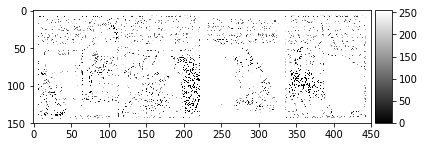

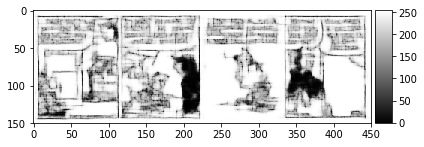

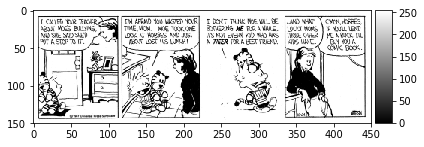

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


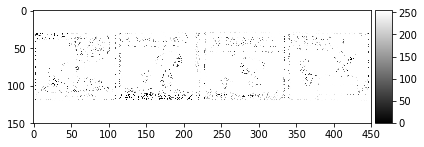

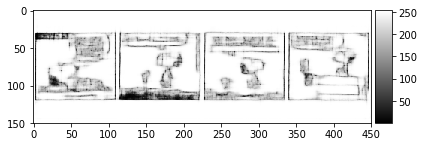

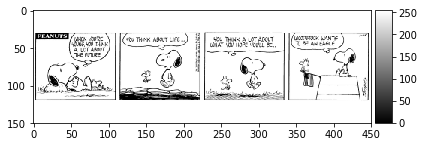

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


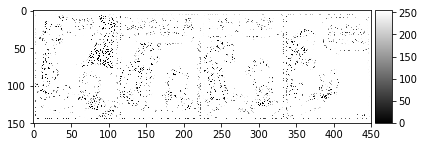

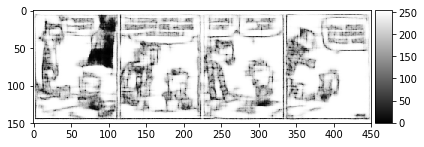

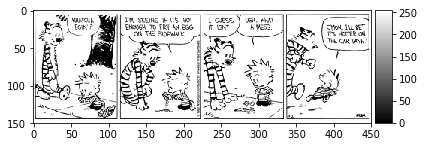

step  0 / 7367 d_loss:  1.8514979274186771e-06 g_loss:  [20.385885, 0.19382821, 1.0030649]
step  1 / 7367 d_loss:  6.609020056203008e-05 g_loss:  [18.637663, 0.17662431, 0.97523147]
step  2 / 7367 d_loss:  9.49590412346879e-06 g_loss:  [29.782536, 0.2877053, 1.0120039]
step  3 / 7367 d_loss:  2.574260361143388e-05 g_loss:  [23.242147, 0.22255628, 0.9865189]
step  4 / 7367 d_loss:  5.413979579316219e-06 g_loss:  [15.999651, 0.14991513, 1.0081377]
step  5 / 7367 d_loss:  0.00019452987180557102 g_loss:  [24.409239, 0.23379616, 1.0296233]
step  6 / 7367 d_loss:  4.656596388485923e-07 g_loss:  [28.448957, 0.27451158, 0.99780166]
step  7 / 7367 d_loss:  0.0001041721916408278 g_loss:  [25.97317, 0.24999097, 0.9740717]
step  8 / 7367 d_loss:  7.882030331529677e-05 g_loss:  [28.165333, 0.27145895, 1.0194379]
step  9 / 7367 d_loss:  0.0001244187878910452 g_loss:  [27.965933, 0.26988, 0.9779348]
step  10 / 7367 d_loss:  3.8601992855547e-06 g_loss:  [16.8576, 0.1585131, 1.0062903]
step  11 / 7367 

step  92 / 7367 d_loss:  1.573896770423744e-05 g_loss:  [28.944527, 0.27951106, 0.99341977]
step  93 / 7367 d_loss:  0.0001627911115065217 g_loss:  [23.680103, 0.22658505, 1.0215998]
step  94 / 7367 d_loss:  6.969000878598308e-06 g_loss:  [20.166954, 0.19167747, 0.9992061]
step  95 / 7367 d_loss:  1.2171843991382048e-05 g_loss:  [17.763311, 0.1678349, 0.9798214]
step  96 / 7367 d_loss:  2.2535106836585328e-05 g_loss:  [27.37696, 0.2638565, 0.9913101]
step  97 / 7367 d_loss:  1.5692829038016498e-05 g_loss:  [24.51865, 0.23514529, 1.0041225]
step  98 / 7367 d_loss:  5.205164598010015e-06 g_loss:  [22.795252, 0.21794868, 1.0003839]
step  99 / 7367 d_loss:  7.325065234908834e-05 g_loss:  [24.26934, 0.23268901, 1.0004413]
step  100 / 7367 d_loss:  5.8232744777342305e-05 g_loss:  [30.563278, 0.2958588, 0.977397]
step  101 / 7367 d_loss:  1.4720638318976853e-05 g_loss:  [13.0794735, 0.12100232, 0.9792423]
step  102 / 7367 d_loss:  0.00010031189594883472 g_loss:  [16.833483, 0.1585864, 0.97484

step  182 / 7367 d_loss:  7.839576028345618e-06 g_loss:  [31.315556, 0.30298743, 1.0168142]
step  183 / 7367 d_loss:  6.86053026583977e-05 g_loss:  [16.614008, 0.15599337, 1.0146701]
step  184 / 7367 d_loss:  5.240479367785156e-05 g_loss:  [28.893724, 0.2786977, 1.0239538]
step  185 / 7367 d_loss:  5.597042331828561e-07 g_loss:  [24.785988, 0.2379213, 0.99385744]
step  186 / 7367 d_loss:  2.6023335522040725e-06 g_loss:  [20.960499, 0.1996838, 0.99211836]
step  187 / 7367 d_loss:  1.4778783224755898e-05 g_loss:  [23.005058, 0.22016679, 0.98837984]
step  188 / 7367 d_loss:  9.473685167904478e-06 g_loss:  [30.466532, 0.29469588, 0.9969428]
step  189 / 7367 d_loss:  4.069407805218361e-05 g_loss:  [14.72744, 0.13736998, 0.9904422]
step  190 / 7367 d_loss:  2.1186685899010627e-06 g_loss:  [20.620731, 0.1962599, 0.9947423]
step  191 / 7367 d_loss:  2.0846900952165015e-05 g_loss:  [27.6944, 0.2667734, 1.0170621]
step  192 / 7367 d_loss:  2.410972047073301e-05 g_loss:  [24.647182, 0.23635533, 1

step  274 / 7367 d_loss:  3.749421739485115e-05 g_loss:  [28.797903, 0.27786633, 1.0112706]
step  275 / 7367 d_loss:  0.00011765421368181705 g_loss:  [31.831797, 0.30795497, 1.0363007]
step  276 / 7367 d_loss:  0.00021752477914560586 g_loss:  [14.386178, 0.13392302, 0.9938754]
step  277 / 7367 d_loss:  5.2797317039221525e-05 g_loss:  [23.728283, 0.22778136, 0.9501473]
step  278 / 7367 d_loss:  5.087578756501898e-05 g_loss:  [19.509384, 0.18490772, 1.0186114]
step  279 / 7367 d_loss:  1.7449972347094445e-06 g_loss:  [20.497553, 0.19517688, 0.9798646]
step  280 / 7367 d_loss:  0.00010303786984877661 g_loss:  [24.452827, 0.23466273, 0.9865555]
step  281 / 7367 d_loss:  2.3840357243898325e-05 g_loss:  [24.763636, 0.23727971, 1.0356635]
step  282 / 7367 d_loss:  2.267478521389421e-06 g_loss:  [29.347, 0.28350374, 0.9966252]
step  283 / 7367 d_loss:  2.2833086404716596e-05 g_loss:  [34.487976, 0.3347761, 1.0103664]
step  284 / 7367 d_loss:  2.7784456051449524e-06 g_loss:  [24.040977, 0.23046

step  366 / 7367 d_loss:  8.10754718258977e-05 g_loss:  [28.396034, 0.2741844, 0.97759426]
step  367 / 7367 d_loss:  4.659075057134032e-05 g_loss:  [27.654348, 0.26657262, 0.9970856]
step  368 / 7367 d_loss:  9.119713467953261e-06 g_loss:  [26.965168, 0.2596683, 0.99833846]
step  369 / 7367 d_loss:  9.008591405290645e-06 g_loss:  [23.404354, 0.2240099, 1.0033636]
step  370 / 7367 d_loss:  0.0001713499950710684 g_loss:  [27.658506, 0.2662733, 1.0311779]
step  371 / 7367 d_loss:  9.504488843958825e-06 g_loss:  [14.671298, 0.13690656, 0.98064154]
step  372 / 7367 d_loss:  2.3436306946678087e-05 g_loss:  [28.508255, 0.27502695, 1.0055603]
step  373 / 7367 d_loss:  6.582440050806326e-07 g_loss:  [23.07275, 0.22084543, 0.9882062]
step  374 / 7367 d_loss:  6.55882540741004e-05 g_loss:  [32.200253, 0.31219223, 0.9810282]
step  375 / 7367 d_loss:  1.1208181604160927e-05 g_loss:  [22.603905, 0.21617483, 0.98642236]
step  376 / 7367 d_loss:  3.683394425024744e-06 g_loss:  [28.996801, 0.28003958, 

step  456 / 7367 d_loss:  7.708838893449865e-06 g_loss:  [20.766998, 0.19777535, 0.9894643]
step  457 / 7367 d_loss:  5.271946292850771e-07 g_loss:  [22.178196, 0.21180756, 0.9974408]
step  458 / 7367 d_loss:  1.9127728592138737e-05 g_loss:  [22.546339, 0.21557094, 0.98924434]
step  459 / 7367 d_loss:  1.8931063095806167e-05 g_loss:  [26.27386, 0.25264966, 1.0088938]
step  460 / 7367 d_loss:  1.4896152606524993e-05 g_loss:  [22.255592, 0.21249333, 1.0062597]
step  461 / 7367 d_loss:  2.7795947971753776e-05 g_loss:  [17.196737, 0.1619666, 1.0000768]
step  462 / 7367 d_loss:  0.0002382575476076454 g_loss:  [27.291391, 0.2630364, 0.98775154]
step  463 / 7367 d_loss:  0.0003126520605292171 g_loss:  [25.572989, 0.2462093, 0.95205855]
step  464 / 7367 d_loss:  0.00019591802265495062 g_loss:  [15.772736, 0.14807983, 0.9647531]
step  465 / 7367 d_loss:  7.586752417410025e-06 g_loss:  [20.353523, 0.1935978, 0.9937443]
step  466 / 7367 d_loss:  2.2590042135561816e-05 g_loss:  [30.110975, 0.29107

step  546 / 7367 d_loss:  4.159332092967816e-06 g_loss:  [23.898098, 0.2290032, 0.9977785]
step  547 / 7367 d_loss:  5.348425133888668e-07 g_loss:  [28.702478, 0.27690664, 1.011815]
step  548 / 7367 d_loss:  5.6795956879795995e-06 g_loss:  [22.741066, 0.2173349, 1.0075765]
step  549 / 7367 d_loss:  2.5612886020098813e-05 g_loss:  [18.67973, 0.17671007, 1.0087229]
step  550 / 7367 d_loss:  4.997588257538155e-05 g_loss:  [29.038778, 0.28021643, 1.017135]
step  551 / 7367 d_loss:  2.6717276341514662e-05 g_loss:  [24.4285, 0.23421267, 1.0072318]
step  552 / 7367 d_loss:  2.4637733986310195e-06 g_loss:  [30.32402, 0.29326358, 0.9976607]
step  553 / 7367 d_loss:  4.0092136259772815e-06 g_loss:  [17.046253, 0.16052444, 0.99380845]
step  554 / 7367 d_loss:  1.5237618754326832e-05 g_loss:  [30.05562, 0.290621, 0.993519]
step  555 / 7367 d_loss:  0.0002154624817194417 g_loss:  [24.813791, 0.23845951, 0.96784025]
step  556 / 7367 d_loss:  3.3120927582785953e-06 g_loss:  [23.089977, 0.22077063, 1.

step  636 / 7367 d_loss:  5.21292895427905e-05 g_loss:  [26.823076, 0.25806218, 1.016857]
step  637 / 7367 d_loss:  4.5375345507636666e-05 g_loss:  [13.835315, 0.12833698, 1.0016168]
step  638 / 7367 d_loss:  1.3495192433765624e-05 g_loss:  [33.880856, 0.32884607, 0.9962501]
step  639 / 7367 d_loss:  3.525780266500078e-05 g_loss:  [32.622322, 0.31612253, 1.0100689]
step  640 / 7367 d_loss:  1.5876898032729514e-05 g_loss:  [17.958712, 0.16984884, 0.9738265]
step  641 / 7367 d_loss:  2.5286013624281622e-05 g_loss:  [17.631695, 0.16662607, 0.96908814]
step  642 / 7367 d_loss:  2.6109015379915945e-05 g_loss:  [17.803062, 0.16815642, 0.98742163]
step  643 / 7367 d_loss:  5.272248381515965e-05 g_loss:  [14.632903, 0.13645309, 0.987594]
step  644 / 7367 d_loss:  1.0147879947908223e-05 g_loss:  [34.758434, 0.3375445, 1.0039817]
step  645 / 7367 d_loss:  5.6824341299943626e-05 g_loss:  [24.69342, 0.23685715, 1.0077059]
step  646 / 7367 d_loss:  2.860557651729323e-05 g_loss:  [28.459068, 0.27456

step  728 / 7367 d_loss:  3.923031181329861e-05 g_loss:  [27.476934, 0.26486474, 0.9904598]
step  729 / 7367 d_loss:  4.087886554771103e-05 g_loss:  [27.194391, 0.26174787, 1.019604]
step  730 / 7367 d_loss:  6.570119808202435e-07 g_loss:  [30.259598, 0.29254282, 1.0053157]
step  731 / 7367 d_loss:  2.9700304366997443e-05 g_loss:  [22.749203, 0.21760745, 0.9884573]
step  732 / 7367 d_loss:  8.076170161075424e-06 g_loss:  [27.852573, 0.26857877, 0.9946966]
step  733 / 7367 d_loss:  6.397115157597e-06 g_loss:  [28.7389, 0.2772202, 1.0168802]
step  734 / 7367 d_loss:  8.768213888288301e-07 g_loss:  [22.394918, 0.21393183, 1.0017354]
step  735 / 7367 d_loss:  0.00011290978000033647 g_loss:  [24.298506, 0.23282781, 1.015725]
step  736 / 7367 d_loss:  1.6508383851032704e-06 g_loss:  [18.257622, 0.17264111, 0.9935104]
step  737 / 7367 d_loss:  0.00028158602071926 g_loss:  [13.435846, 0.12441646, 0.99419963]
step  738 / 7367 d_loss:  1.254470225831028e-05 g_loss:  [24.488335, 0.2349569, 0.9926

step  820 / 7367 d_loss:  0.00021510606165975332 g_loss:  [34.17797, 0.33226064, 0.9519091]
step  821 / 7367 d_loss:  0.00028983407537452877 g_loss:  [21.866215, 0.2090525, 0.960965]
step  822 / 7367 d_loss:  0.00010943609959213063 g_loss:  [21.835518, 0.20812957, 1.0225595]
step  823 / 7367 d_loss:  0.00010499836935196072 g_loss:  [22.117828, 0.21152204, 0.96562374]
step  824 / 7367 d_loss:  5.197470454731956e-05 g_loss:  [26.031261, 0.25036746, 0.99451464]
step  825 / 7367 d_loss:  0.0004154859052505344 g_loss:  [13.701132, 0.12636493, 1.0646391]
step  826 / 7367 d_loss:  1.847534440457821e-05 g_loss:  [21.783142, 0.20803882, 0.97925967]
step  827 / 7367 d_loss:  7.349804945988581e-06 g_loss:  [21.577347, 0.20586844, 0.99050283]
step  828 / 7367 d_loss:  3.974092396674678e-05 g_loss:  [31.876196, 0.30881903, 0.9942929]
step  829 / 7367 d_loss:  0.0001300830626860261 g_loss:  [14.150124, 0.13141675, 1.0084487]
step  830 / 7367 d_loss:  0.00023629286442883313 g_loss:  [35.481213, 0.344

step  910 / 7367 d_loss:  0.00019264333241153508 g_loss:  [20.389103, 0.19354351, 1.0347519]
step  911 / 7367 d_loss:  7.449283293681219e-05 g_loss:  [13.043606, 0.120135516, 1.0300546]
step  912 / 7367 d_loss:  1.7749629478203133e-05 g_loss:  [23.083498, 0.22076024, 1.0074738]
step  913 / 7367 d_loss:  5.7856410421663895e-05 g_loss:  [22.822456, 0.21830565, 0.9918913]
step  914 / 7367 d_loss:  9.270294685848057e-05 g_loss:  [13.705034, 0.12698099, 1.0069355]
step  915 / 7367 d_loss:  3.0359986340044998e-05 g_loss:  [29.613594, 0.286203, 0.9932931]
step  916 / 7367 d_loss:  2.537056843721075e-06 g_loss:  [19.641571, 0.18643852, 0.99771845]
step  917 / 7367 d_loss:  8.995996176963672e-05 g_loss:  [28.914673, 0.27891818, 1.0228566]
step  918 / 7367 d_loss:  2.039576827428391e-07 g_loss:  [24.274578, 0.23277996, 0.99658257]
step  919 / 7367 d_loss:  3.210464637959376e-05 g_loss:  [26.847322, 0.2583313, 1.0141929]
step  920 / 7367 d_loss:  8.621424058219418e-06 g_loss:  [30.405727, 0.29402

step  999 / 7367 d_loss:  2.9736105489064357e-07 g_loss:  [21.821411, 0.20824048, 0.9973648]
step  1000 / 7367 d_loss:  1.0050525816041045e-05 g_loss:  [20.05069, 0.19057842, 0.9928481]
step  1001 / 7367 d_loss:  2.0508583475020714e-05 g_loss:  [23.520153, 0.22510743, 1.009411]
step  1002 / 7367 d_loss:  8.681591907588881e-07 g_loss:  [29.774666, 0.28771293, 1.0033722]
step  1003 / 7367 d_loss:  2.3933803277031984e-06 g_loss:  [23.454882, 0.22460705, 0.9941762]
step  1004 / 7367 d_loss:  5.279548349790275e-05 g_loss:  [25.250273, 0.24265218, 0.9850558]
step  1005 / 7367 d_loss:  9.811591007746756e-05 g_loss:  [30.212349, 0.29202178, 1.0101707]
step  1006 / 7367 d_loss:  5.488342503667809e-05 g_loss:  [27.992298, 0.2698331, 1.0089885]
step  1007 / 7367 d_loss:  4.453309429663932e-06 g_loss:  [22.549604, 0.21571201, 0.978403]
step  1008 / 7367 d_loss:  9.621590288588777e-05 g_loss:  [17.775076, 0.16800746, 0.974329]
step  1009 / 7367 d_loss:  1.152320010078256e-06 g_loss:  [24.046036, 0.

step  1088 / 7367 d_loss:  1.752637035679072e-05 g_loss:  [28.849997, 0.2785275, 0.9972484]
step  1089 / 7367 d_loss:  7.285462925210595e-05 g_loss:  [29.167288, 0.28175926, 0.99136186]
step  1090 / 7367 d_loss:  5.672648694599047e-05 g_loss:  [21.187155, 0.20208146, 0.9790096]
step  1091 / 7367 d_loss:  9.182229405269027e-05 g_loss:  [23.748358, 0.2273035, 1.0180073]
step  1092 / 7367 d_loss:  2.819055771396961e-05 g_loss:  [24.060612, 0.23063293, 0.99731874]
step  1093 / 7367 d_loss:  1.4985759662522469e-05 g_loss:  [20.083967, 0.19094674, 0.98929244]
step  1094 / 7367 d_loss:  4.121633537579328e-06 g_loss:  [20.469837, 0.19468361, 1.0014764]
step  1095 / 7367 d_loss:  3.2770232792245224e-05 g_loss:  [27.427235, 0.2643958, 0.9876531]
step  1096 / 7367 d_loss:  3.710602686624043e-05 g_loss:  [24.916498, 0.23903337, 1.0131606]
step  1097 / 7367 d_loss:  2.7869351470144466e-05 g_loss:  [25.7963, 0.24791783, 1.0045177]
step  1098 / 7367 d_loss:  2.8396847483236343e-05 g_loss:  [26.331627

step  1177 / 7367 d_loss:  3.259058576077223e-05 g_loss:  [20.674232, 0.19666278, 1.0079544]
step  1178 / 7367 d_loss:  0.0001381141773890704 g_loss:  [15.351972, 0.14382811, 0.9691607]
step  1179 / 7367 d_loss:  0.00011616419214988127 g_loss:  [25.252619, 0.24260814, 0.99180466]
step  1180 / 7367 d_loss:  8.07986180006992e-06 g_loss:  [24.130882, 0.23112902, 1.0179813]
step  1181 / 7367 d_loss:  9.71740792010678e-06 g_loss:  [31.437614, 0.30420473, 1.0171419]
step  1182 / 7367 d_loss:  6.50527435936965e-05 g_loss:  [27.540451, 0.2651909, 1.0213608]
step  1183 / 7367 d_loss:  4.4402982894098386e-05 g_loss:  [26.085938, 0.25060004, 1.0259348]
step  1184 / 7367 d_loss:  5.601817065326031e-06 g_loss:  [24.188292, 0.2320217, 0.9861208]
step  1185 / 7367 d_loss:  5.94149278185796e-05 g_loss:  [27.759163, 0.2677877, 0.9803928]
step  1186 / 7367 d_loss:  1.6893300198717043e-05 g_loss:  [21.972122, 0.20990899, 0.98122233]
step  1187 / 7367 d_loss:  0.0001092103702831082 g_loss:  [24.015001, 0.

step  1266 / 7367 d_loss:  9.316491969002527e-07 g_loss:  [21.466599, 0.20477606, 0.98899204]
step  1267 / 7367 d_loss:  4.7211992182383256e-07 g_loss:  [25.860859, 0.24863541, 0.9973184]
step  1268 / 7367 d_loss:  3.367751560290344e-06 g_loss:  [26.672823, 0.25672305, 1.0005196]
step  1269 / 7367 d_loss:  4.582230758387595e-06 g_loss:  [36.147575, 0.3514505, 1.0025254]
step  1270 / 7367 d_loss:  3.132968777208589e-05 g_loss:  [33.17434, 0.32156518, 1.0178218]
step  1271 / 7367 d_loss:  6.12171133980155e-05 g_loss:  [24.81413, 0.23833619, 0.9805132]
step  1272 / 7367 d_loss:  4.794579581357539e-05 g_loss:  [22.737114, 0.21750341, 0.9867727]
step  1273 / 7367 d_loss:  7.028000254649669e-06 g_loss:  [20.725182, 0.19718347, 1.0068347]
step  1274 / 7367 d_loss:  6.978649707889417e-06 g_loss:  [24.833704, 0.2384051, 0.99319535]
step  1275 / 7367 d_loss:  4.695716415881179e-05 g_loss:  [33.426525, 0.3240824, 1.018282]
step  1276 / 7367 d_loss:  1.2740953025058843e-05 g_loss:  [22.177614, 0.2

step  1357 / 7367 d_loss:  1.9156239432049915e-05 g_loss:  [27.791456, 0.26772904, 1.0185536]
step  1358 / 7367 d_loss:  1.4434212971536908e-05 g_loss:  [27.957413, 0.26947406, 1.0100054]
step  1359 / 7367 d_loss:  1.0943134839180857e-05 g_loss:  [16.121374, 0.15121572, 0.9998026]
step  1360 / 7367 d_loss:  4.0504590288037434e-05 g_loss:  [29.48665, 0.28498802, 0.98784834]
step  1361 / 7367 d_loss:  1.5906081898720004e-05 g_loss:  [27.940268, 0.26930153, 1.0101146]
step  1362 / 7367 d_loss:  4.5432128104039293e-07 g_loss:  [27.34091, 0.26340777, 1.000134]
step  1363 / 7367 d_loss:  5.319530828273855e-06 g_loss:  [29.993172, 0.2898467, 1.0085036]
step  1364 / 7367 d_loss:  6.709631634294055e-06 g_loss:  [17.855068, 0.16861482, 0.99358517]
step  1365 / 7367 d_loss:  5.636567948386073e-05 g_loss:  [20.735636, 0.19752486, 0.98314995]
step  1366 / 7367 d_loss:  1.9649685327749467e-06 g_loss:  [26.65184, 0.2565084, 1.0009997]
step  1367 / 7367 d_loss:  8.831815648591146e-05 g_loss:  [17.4497

step  1445 / 7367 d_loss:  0.00038432059227488935 g_loss:  [24.974253, 0.23921005, 1.0532478]
step  1446 / 7367 d_loss:  0.0011336265597492456 g_loss:  [24.668642, 0.2359064, 1.0780007]
step  1447 / 7367 d_loss:  1.2518418088802719e-06 g_loss:  [21.623934, 0.20668276, 0.955658]
step  1448 / 7367 d_loss:  0.000310189847368747 g_loss:  [23.506947, 0.22582337, 0.9246096]
step  1449 / 7367 d_loss:  5.564084494835697e-05 g_loss:  [16.970507, 0.16032904, 0.93760335]
step  1450 / 7367 d_loss:  0.00031427841167896986 g_loss:  [23.068316, 0.22141267, 0.9270474]
step  1451 / 7367 d_loss:  5.8963669289369136e-05 g_loss:  [18.05613, 0.17122574, 0.9335551]
step  1452 / 7367 d_loss:  0.0002964671002700925 g_loss:  [23.842813, 0.22886363, 0.956452]
step  1453 / 7367 d_loss:  2.2288582840701565e-05 g_loss:  [28.950546, 0.27920908, 1.0296382]
step  1454 / 7367 d_loss:  0.00014820092474110425 g_loss:  [20.411436, 0.19377677, 1.0337577]
step  1455 / 7367 d_loss:  0.0004643273714464158 g_loss:  [27.696823

step  1535 / 7367 d_loss:  0.017800305038690567 g_loss:  [25.772211, 0.24362263, 1.4099487]
step  1536 / 7367 d_loss:  0.015942173078656197 g_loss:  [23.167301, 0.21821757, 1.3455454]
step  1537 / 7367 d_loss:  0.012881701812148094 g_loss:  [16.08389, 0.1485352, 1.2303702]
step  1538 / 7367 d_loss:  0.006240418180823326 g_loss:  [28.078077, 0.26933947, 1.1441299]
step  1539 / 7367 d_loss:  0.013917102478444576 g_loss:  [13.644181, 0.12554143, 1.0900384]
step  1540 / 7367 d_loss:  0.0022652558982372284 g_loss:  [28.337765, 0.27306914, 1.0308499]
step  1541 / 7367 d_loss:  0.0007912111468613148 g_loss:  [19.056326, 0.18240139, 0.8161877]
step  1542 / 7367 d_loss:  0.07558111846446991 g_loss:  [25.840298, 0.24811152, 1.0291452]
step  1543 / 7367 d_loss:  0.0039464617148041725 g_loss:  [29.023453, 0.28197116, 0.82633793]
step  1544 / 7367 d_loss:  0.0013057120377197862 g_loss:  [19.145145, 0.18177745, 0.96740067]
step  1545 / 7367 d_loss:  0.0036420091055333614 g_loss:  [24.479504, 0.23622

step  1624 / 7367 d_loss:  3.857081537717022e-05 g_loss:  [31.949669, 0.3096392, 0.98574996]
step  1625 / 7367 d_loss:  0.0005124389426782727 g_loss:  [16.795727, 0.15867548, 0.9281786]
step  1626 / 7367 d_loss:  0.0003251825110055506 g_loss:  [15.852441, 0.14809753, 1.0426877]
step  1627 / 7367 d_loss:  0.00020152541401330382 g_loss:  [18.143808, 0.17162009, 0.9817995]
step  1628 / 7367 d_loss:  0.0001367580989608541 g_loss:  [24.002953, 0.23018314, 0.9846374]
step  1629 / 7367 d_loss:  6.663416570518166e-05 g_loss:  [23.913208, 0.22888689, 1.0245181]
step  1630 / 7367 d_loss:  0.0009125794167630374 g_loss:  [25.089605, 0.24008366, 1.081239]
step  1631 / 7367 d_loss:  0.006725408136844635 g_loss:  [13.839633, 0.12812579, 1.0270544]
step  1632 / 7367 d_loss:  2.4051192667684518e-05 g_loss:  [22.561295, 0.21557575, 1.0037187]
step  1633 / 7367 d_loss:  0.000392872461816296 g_loss:  [21.371174, 0.2042377, 0.9474022]
step  1634 / 7367 d_loss:  4.788980004377663e-05 g_loss:  [25.739391, 0.

step  1714 / 7367 d_loss:  0.00014930576435290277 g_loss:  [19.10202, 0.18065605, 1.036415]
step  1715 / 7367 d_loss:  2.658903213159647e-05 g_loss:  [33.52779, 0.32535326, 0.99246055]
step  1716 / 7367 d_loss:  6.3597626649425365e-06 g_loss:  [30.225927, 0.29226947, 0.99897873]
step  1717 / 7367 d_loss:  8.704751962795854e-05 g_loss:  [19.148548, 0.18175927, 0.97262144]
step  1718 / 7367 d_loss:  9.7861075118999e-06 g_loss:  [35.15123, 0.34142765, 1.0084655]
step  1719 / 7367 d_loss:  7.416133303195238e-05 g_loss:  [23.985323, 0.22962652, 1.02267]
step  1720 / 7367 d_loss:  0.00013757329725194722 g_loss:  [30.336214, 0.2931, 1.0262147]
step  1721 / 7367 d_loss:  9.437808330403641e-05 g_loss:  [29.306187, 0.28340283, 0.9659048]
step  1722 / 7367 d_loss:  8.571943908464164e-05 g_loss:  [28.094181, 0.27084088, 1.0100929]
step  1723 / 7367 d_loss:  2.9090369935147464e-06 g_loss:  [33.69749, 0.32710367, 0.98712337]
step  1724 / 7367 d_loss:  0.0006233127205632627 g_loss:  [16.310034, 0.152

step  1804 / 7367 d_loss:  5.871612302144058e-06 g_loss:  [12.462231, 0.114508495, 1.0113814]
step  1805 / 7367 d_loss:  0.00010367477807449177 g_loss:  [20.18082, 0.19206262, 0.97455895]
step  1806 / 7367 d_loss:  7.619696407346055e-05 g_loss:  [25.117695, 0.24092148, 1.0255473]
step  1807 / 7367 d_loss:  0.00023586858878843486 g_loss:  [35.76563, 0.34783277, 0.98235476]
step  1808 / 7367 d_loss:  1.918317866511643e-05 g_loss:  [26.477938, 0.2548704, 0.9908959]
step  1809 / 7367 d_loss:  0.00015058819553814828 g_loss:  [27.352736, 0.26373953, 0.978783]
step  1810 / 7367 d_loss:  7.038543844828382e-05 g_loss:  [27.71294, 0.26720828, 0.9921129]
step  1811 / 7367 d_loss:  0.00019459686882328242 g_loss:  [28.556252, 0.27516583, 1.0396688]
step  1812 / 7367 d_loss:  0.00013013645366299897 g_loss:  [25.17864, 0.24205963, 0.9726773]
step  1813 / 7367 d_loss:  0.00024336465867236257 g_loss:  [20.104065, 0.1905551, 1.0485563]
step  1814 / 7367 d_loss:  0.00034718477400019765 g_loss:  [22.30653

step  1894 / 7367 d_loss:  0.0003156094462610781 g_loss:  [18.166391, 0.1723116, 0.93523055]
step  1895 / 7367 d_loss:  0.00010637845116434619 g_loss:  [27.415146, 0.26429513, 0.985631]
step  1896 / 7367 d_loss:  5.503307329490781e-05 g_loss:  [31.283968, 0.30249485, 1.0344827]
step  1897 / 7367 d_loss:  1.4286074474512134e-05 g_loss:  [25.469913, 0.24465348, 1.0045671]
step  1898 / 7367 d_loss:  6.048304931027815e-05 g_loss:  [32.841316, 0.31798446, 1.0428686]
step  1899 / 7367 d_loss:  1.1356254617567174e-05 g_loss:  [26.319061, 0.2531949, 0.9995701]
step  1900 / 7367 d_loss:  0.0001159174062195234 g_loss:  [21.57681, 0.20565562, 1.0112493]
step  1901 / 7367 d_loss:  0.00033721927320584655 g_loss:  [13.773345, 0.12761672, 1.0116732]
step  1902 / 7367 d_loss:  1.0845843462448101e-05 g_loss:  [30.643951, 0.29646367, 0.9975848]
step  1903 / 7367 d_loss:  2.776535984594375e-05 g_loss:  [17.13231, 0.16149111, 0.9832002]
step  1904 / 7367 d_loss:  3.7152363802306354e-05 g_loss:  [20.357258

step  1984 / 7367 d_loss:  5.895869617233984e-05 g_loss:  [16.175285, 0.15278696, 0.89659005]
step  1985 / 7367 d_loss:  0.00047154896310530603 g_loss:  [13.0576105, 0.12064012, 0.993598]
step  1986 / 7367 d_loss:  3.7396332572825486e-06 g_loss:  [22.909117, 0.21913923, 0.99519295]
step  1987 / 7367 d_loss:  9.613048314349726e-05 g_loss:  [19.60961, 0.18586381, 1.0232297]
step  1988 / 7367 d_loss:  0.0002934631484095007 g_loss:  [32.751247, 0.31793755, 0.9574932]
step  1989 / 7367 d_loss:  1.909991624415852e-05 g_loss:  [25.835121, 0.24832068, 1.0030539]
step  1990 / 7367 d_loss:  0.000152502630953677 g_loss:  [17.468029, 0.1651406, 0.95397085]
step  1991 / 7367 d_loss:  5.2692117606056854e-05 g_loss:  [28.704006, 0.2771735, 0.986658]
step  1992 / 7367 d_loss:  9.916091948980466e-05 g_loss:  [18.488916, 0.17501256, 0.98766047]
step  1993 / 7367 d_loss:  6.918379222042859e-05 g_loss:  [23.160686, 0.22142226, 1.0184608]
step  1994 / 7367 d_loss:  0.000820068409666419 g_loss:  [19.654503,

step  2075 / 7367 d_loss:  0.00022952693689148873 g_loss:  [15.953312, 0.149345, 1.0188125]
step  2076 / 7367 d_loss:  5.339846757124178e-05 g_loss:  [21.183374, 0.20213255, 0.97011936]
step  2077 / 7367 d_loss:  0.0001309265207964927 g_loss:  [16.08949, 0.15149535, 0.9399556]
step  2078 / 7367 d_loss:  4.7840903789619915e-06 g_loss:  [29.25168, 0.28274173, 0.977509]
step  2079 / 7367 d_loss:  4.490452556638047e-05 g_loss:  [30.67733, 0.297055, 0.9718293]
step  2080 / 7367 d_loss:  2.7983322070213035e-05 g_loss:  [21.07492, 0.20091595, 0.9833263]
step  2081 / 7367 d_loss:  0.0040662349201738834 g_loss:  [18.30113, 0.17400792, 0.9003364]
step  2082 / 7367 d_loss:  6.107396620791405e-05 g_loss:  [18.12889, 0.1713082, 0.99806786]
step  2083 / 7367 d_loss:  0.00028039870085194707 g_loss:  [24.502222, 0.23445737, 1.056484]
step  2084 / 7367 d_loss:  0.00021107515203766525 g_loss:  [21.99801, 0.2096342, 1.0345904]
step  2085 / 7367 d_loss:  0.0003387421602383256 g_loss:  [23.926952, 0.228873

step  2165 / 7367 d_loss:  2.3006165065453388e-05 g_loss:  [27.232008, 0.26243573, 0.9884336]
step  2166 / 7367 d_loss:  3.2731240935390815e-05 g_loss:  [23.092575, 0.22086059, 1.0065168]
step  2167 / 7367 d_loss:  5.8323072153143585e-05 g_loss:  [13.479498, 0.124931075, 0.9863905]
step  2168 / 7367 d_loss:  2.4493954697391018e-05 g_loss:  [24.958818, 0.23971711, 0.98710763]
step  2169 / 7367 d_loss:  7.1057211243896745e-06 g_loss:  [19.624666, 0.18637986, 0.9866789]
step  2170 / 7367 d_loss:  6.126350854174234e-06 g_loss:  [32.061836, 0.31063974, 0.99786156]
step  2171 / 7367 d_loss:  5.65473128517624e-05 g_loss:  [27.68705, 0.2666526, 1.021788]
step  2172 / 7367 d_loss:  3.6780224945687223e-06 g_loss:  [30.761929, 0.29768717, 0.9932127]
step  2173 / 7367 d_loss:  2.674604365893174e-05 g_loss:  [26.648397, 0.25636107, 1.0122904]
step  2174 / 7367 d_loss:  3.977130108978599e-05 g_loss:  [21.736729, 0.20759664, 0.9770651]
step  2175 / 7367 d_loss:  2.795172349578934e-06 g_loss:  [29.597

step  2253 / 7367 d_loss:  0.0001369220408378169 g_loss:  [29.188187, 0.28210163, 0.9780227]
step  2254 / 7367 d_loss:  0.0001440786145394668 g_loss:  [15.388663, 0.14376765, 1.0118979]
step  2255 / 7367 d_loss:  9.367537131765857e-05 g_loss:  [21.555841, 0.20560245, 0.9955958]
step  2256 / 7367 d_loss:  5.41169720236212e-05 g_loss:  [20.107452, 0.19133973, 0.9734811]
step  2257 / 7367 d_loss:  2.2651589461020194e-05 g_loss:  [23.869257, 0.22876999, 0.9922582]
step  2258 / 7367 d_loss:  2.2883465135237202e-05 g_loss:  [21.363756, 0.2035439, 1.0093676]
step  2259 / 7367 d_loss:  7.054390152916312e-05 g_loss:  [19.742512, 0.18761133, 0.98137903]
step  2260 / 7367 d_loss:  0.0001528292486909777 g_loss:  [26.988987, 0.25955874, 1.0331135]
step  2261 / 7367 d_loss:  0.00022344861645251513 g_loss:  [26.050673, 0.25013682, 1.0369918]
step  2262 / 7367 d_loss:  9.348795720143244e-05 g_loss:  [21.256294, 0.20237882, 1.0184109]
step  2263 / 7367 d_loss:  6.480224328697659e-06 g_loss:  [31.378489

step  2342 / 7367 d_loss:  1.1604947758314665e-05 g_loss:  [22.574812, 0.21580447, 0.9943645]
step  2343 / 7367 d_loss:  7.651469059055671e-05 g_loss:  [28.722233, 0.2768981, 1.0324249]
step  2344 / 7367 d_loss:  0.0010986767010763288 g_loss:  [18.769718, 0.17753664, 1.0160544]
step  2345 / 7367 d_loss:  5.1208422519266605e-05 g_loss:  [23.451626, 0.22431228, 1.0203981]
step  2346 / 7367 d_loss:  0.00012789627362508327 g_loss:  [29.70362, 0.28691888, 1.0117339]
step  2347 / 7367 d_loss:  8.939071449276526e-06 g_loss:  [26.195387, 0.25202706, 0.9926803]
step  2348 / 7367 d_loss:  7.196050137281418e-05 g_loss:  [27.754345, 0.26750335, 1.0040102]
step  2349 / 7367 d_loss:  4.4054533645976335e-05 g_loss:  [24.096973, 0.231184, 0.9785737]
step  2350 / 7367 d_loss:  4.3604959500953555e-05 g_loss:  [19.21156, 0.18212476, 0.99908245]
step  2351 / 7367 d_loss:  0.0002918094687629491 g_loss:  [23.919079, 0.22975217, 0.9438629]
step  2352 / 7367 d_loss:  4.941195948049426e-05 g_loss:  [19.45867, 

step  2432 / 7367 d_loss:  1.3517987099476159e-05 g_loss:  [41.229874, 0.40215996, 1.0138766]
step  2433 / 7367 d_loss:  0.0007031055865809321 g_loss:  [37.935143, 0.37012193, 0.9229511]
step  2434 / 7367 d_loss:  0.00015982125478331 g_loss:  [24.144466, 0.23180495, 0.9639729]
step  2435 / 7367 d_loss:  1.2357935702311806e-05 g_loss:  [18.988876, 0.17994922, 0.9939544]
step  2436 / 7367 d_loss:  3.49274529298782e-07 g_loss:  [19.299833, 0.18294555, 1.0052781]
step  2437 / 7367 d_loss:  0.00031791251967661083 g_loss:  [27.845743, 0.26813588, 1.032156]
step  2438 / 7367 d_loss:  5.904389126953902e-06 g_loss:  [23.52741, 0.2254325, 0.98416144]
step  2439 / 7367 d_loss:  0.00013382319593802094 g_loss:  [23.585861, 0.2256664, 1.0192212]
step  2440 / 7367 d_loss:  4.489574712351896e-05 g_loss:  [24.614887, 0.2360461, 1.0102777]
step  2441 / 7367 d_loss:  4.547388925857376e-06 g_loss:  [18.966837, 0.17969307, 0.9975302]
step  2442 / 7367 d_loss:  8.23635048163851e-07 g_loss:  [19.65868, 0.186

step  2523 / 7367 d_loss:  7.365311466855928e-05 g_loss:  [32.46383, 0.31474793, 0.98903733]
step  2524 / 7367 d_loss:  0.0002978492120746523 g_loss:  [24.595007, 0.2361756, 0.97744715]
step  2525 / 7367 d_loss:  1.0317489795852453e-05 g_loss:  [23.996864, 0.2299651, 1.0003524]
step  2526 / 7367 d_loss:  2.360634971410036e-05 g_loss:  [25.154888, 0.2415798, 0.99690866]
step  2527 / 7367 d_loss:  6.660410889480772e-08 g_loss:  [26.767742, 0.2576419, 1.003551]
step  2528 / 7367 d_loss:  4.0875565900933e-05 g_loss:  [19.581806, 0.18589902, 0.99190545]
step  2529 / 7367 d_loss:  0.00036515964893624187 g_loss:  [35.266552, 0.3421066, 1.0558873]
step  2530 / 7367 d_loss:  5.791523290099576e-05 g_loss:  [28.749336, 0.2776412, 0.98521566]
step  2531 / 7367 d_loss:  1.2295788110350259e-05 g_loss:  [16.042706, 0.1501202, 1.0306853]
step  2532 / 7367 d_loss:  0.00014489536988548934 g_loss:  [21.829973, 0.2080967, 1.0203032]
step  2533 / 7367 d_loss:  5.979525212751469e-06 g_loss:  [24.637323, 0.2

step  2612 / 7367 d_loss:  1.6872028936631978e-05 g_loss:  [20.08755, 0.1907296, 1.0145892]
step  2613 / 7367 d_loss:  2.8877695513074286e-05 g_loss:  [23.589043, 0.22596742, 0.9922991]
step  2614 / 7367 d_loss:  5.7122008001897484e-05 g_loss:  [26.820745, 0.2579799, 1.0227554]
step  2615 / 7367 d_loss:  0.00016468300600536168 g_loss:  [34.96582, 0.33923864, 1.0419552]
step  2616 / 7367 d_loss:  7.235885277623311e-06 g_loss:  [13.500396, 0.124910384, 1.0093578]
step  2617 / 7367 d_loss:  0.00012948072981089354 g_loss:  [22.069887, 0.21038866, 1.0310217]
step  2618 / 7367 d_loss:  0.00043429655488580465 g_loss:  [19.358051, 0.18285918, 1.0721313]
step  2619 / 7367 d_loss:  1.532063470222056e-05 g_loss:  [21.71581, 0.2071993, 0.9958798]
step  2620 / 7367 d_loss:  0.00025245093274861574 g_loss:  [19.27125, 0.18315205, 0.95604575]
step  2621 / 7367 d_loss:  1.746009729686193e-05 g_loss:  [28.010551, 0.27027127, 0.983426]
step  2622 / 7367 d_loss:  0.0002391932939644903 g_loss:  [24.318077,

step  2701 / 7367 d_loss:  5.993109425617149e-06 g_loss:  [25.024359, 0.24038182, 0.9861768]
step  2702 / 7367 d_loss:  1.632828116271412e-06 g_loss:  [31.463274, 0.3046521, 0.99806476]
step  2703 / 7367 d_loss:  5.31170508111245e-06 g_loss:  [25.490553, 0.24502333, 0.98822063]
step  2704 / 7367 d_loss:  5.936032539466396e-05 g_loss:  [16.912085, 0.15940715, 0.9713694]
step  2705 / 7367 d_loss:  2.2395099222194403e-05 g_loss:  [25.21939, 0.24208234, 1.0111556]
step  2706 / 7367 d_loss:  6.938415936019737e-06 g_loss:  [15.497781, 0.14505032, 0.99274904]
step  2707 / 7367 d_loss:  1.290324348701688e-06 g_loss:  [18.976685, 0.17986485, 0.9902007]
step  2708 / 7367 d_loss:  4.5153261453378946e-05 g_loss:  [28.93477, 0.27926874, 1.0078971]
step  2709 / 7367 d_loss:  4.708802589448169e-05 g_loss:  [23.2001, 0.2222433, 0.9757711]
step  2710 / 7367 d_loss:  1.7982551980821881e-06 g_loss:  [22.18988, 0.2119423, 0.9956512]
step  2711 / 7367 d_loss:  3.098315937677398e-05 g_loss:  [21.313843, 0.2

step  2792 / 7367 d_loss:  0.0001394469873048365 g_loss:  [31.434095, 0.30472517, 0.96157765]
step  2793 / 7367 d_loss:  0.0001082841627066955 g_loss:  [20.84897, 0.19877133, 0.9718379]
step  2794 / 7367 d_loss:  9.884976179819205e-07 g_loss:  [17.731733, 0.16759755, 0.97197986]
step  2795 / 7367 d_loss:  1.3058222521067364e-06 g_loss:  [23.741375, 0.22757842, 0.98353463]
step  2796 / 7367 d_loss:  0.00010576761997072026 g_loss:  [28.26937, 0.27292922, 0.97644573]
step  2797 / 7367 d_loss:  1.4342676877276972e-05 g_loss:  [22.150547, 0.21164256, 0.9862895]
step  2798 / 7367 d_loss:  1.699355198070407e-05 g_loss:  [30.35864, 0.29361707, 0.99693227]
step  2799 / 7367 d_loss:  7.275493408087641e-05 g_loss:  [24.787916, 0.23776394, 1.0115222]
step  2800 / 7367 d_loss:  0.00019366432388778776 g_loss:  [15.529559, 0.14559393, 0.97016644]
step  2801 / 7367 d_loss:  8.695552969584242e-05 g_loss:  [17.579159, 0.16592066, 0.98709315]
step  2802 / 7367 d_loss:  2.2198993974598125e-05 g_loss:  [19

step  2880 / 7367 d_loss:  5.484417124534957e-05 g_loss:  [15.119374, 0.14140134, 0.9792405]
step  2881 / 7367 d_loss:  6.602319444937166e-06 g_loss:  [16.838467, 0.15836473, 1.0019937]
step  2882 / 7367 d_loss:  1.4067100892134476e-05 g_loss:  [22.88654, 0.21882337, 1.0042015]
step  2883 / 7367 d_loss:  6.768389721401036e-05 g_loss:  [27.223856, 0.2621214, 1.0117157]
step  2884 / 7367 d_loss:  5.979617344564758e-05 g_loss:  [26.636316, 0.2565775, 0.97856665]
step  2885 / 7367 d_loss:  3.1975682759366464e-06 g_loss:  [18.494959, 0.17496458, 0.99850124]
step  2886 / 7367 d_loss:  2.99899165838724e-05 g_loss:  [18.648272, 0.17646118, 1.0021529]
step  2887 / 7367 d_loss:  1.3578647667600308e-05 g_loss:  [25.502558, 0.24493918, 1.008641]
step  2888 / 7367 d_loss:  1.166760398518818e-06 g_loss:  [43.74418, 0.42739773, 1.0044047]
step  2889 / 7367 d_loss:  9.993385901907459e-06 g_loss:  [32.71505, 0.31729862, 0.9851884]
step  2890 / 7367 d_loss:  9.096087524085306e-06 g_loss:  [15.220488, 0.

step  2970 / 7367 d_loss:  2.636660610733088e-05 g_loss:  [18.28603, 0.1727884, 1.0071917]
step  2971 / 7367 d_loss:  5.862245598109439e-05 g_loss:  [22.74574, 0.21734083, 1.0116583]
step  2972 / 7367 d_loss:  0.00042230807594023645 g_loss:  [32.06115, 0.31105328, 0.9558206]
step  2973 / 7367 d_loss:  4.726206952909706e-06 g_loss:  [16.553434, 0.1554532, 1.008113]
step  2974 / 7367 d_loss:  2.1921430743532255e-05 g_loss:  [26.64657, 0.2564152, 1.0050505]
step  2975 / 7367 d_loss:  2.6746545700007118e-05 g_loss:  [20.91036, 0.19908041, 1.0023199]
step  2976 / 7367 d_loss:  1.9654646166600287e-05 g_loss:  [22.47296, 0.21456887, 1.0160729]
step  2977 / 7367 d_loss:  5.870725362910889e-05 g_loss:  [18.268394, 0.1725357, 1.0148246]
step  2978 / 7367 d_loss:  1.0520123396418057e-05 g_loss:  [18.912037, 0.17905995, 1.0060434]
step  2979 / 7367 d_loss:  3.008813837368507e-05 g_loss:  [20.009905, 0.18989138, 1.0207678]
step  2980 / 7367 d_loss:  1.6737576515879482e-06 g_loss:  [18.524464, 0.175

step  3060 / 7367 d_loss:  1.9031742795050377e-06 g_loss:  [19.317402, 0.18320365, 0.99703556]
step  3061 / 7367 d_loss:  3.110877514700405e-05 g_loss:  [19.871096, 0.18885884, 0.98521173]
step  3062 / 7367 d_loss:  4.725383405457251e-05 g_loss:  [21.786701, 0.20765367, 1.0213342]
step  3063 / 7367 d_loss:  2.614431195979705e-06 g_loss:  [23.678354, 0.22681814, 0.9965395]
step  3064 / 7367 d_loss:  5.77133396291174e-05 g_loss:  [19.234161, 0.18257591, 0.97656965]
step  3065 / 7367 d_loss:  6.21058688921039e-06 g_loss:  [16.682806, 0.15676603, 1.0062032]
step  3066 / 7367 d_loss:  2.075262045764248e-06 g_loss:  [21.422646, 0.20425151, 0.99749327]
step  3067 / 7367 d_loss:  1.414261987520149e-06 g_loss:  [27.86393, 0.26860034, 1.0038939]
step  3068 / 7367 d_loss:  5.702945031771378e-07 g_loss:  [19.078615, 0.18080471, 0.9981433]
step  3069 / 7367 d_loss:  0.00030264287488535047 g_loss:  [13.047171, 0.12049368, 0.99780285]
step  3070 / 7367 d_loss:  7.39903625799343e-05 g_loss:  [33.71750

step  3150 / 7367 d_loss:  0.00012033186794724315 g_loss:  [16.338226, 0.15305226, 1.0330018]
step  3151 / 7367 d_loss:  3.0560102459276095e-05 g_loss:  [24.037333, 0.23024856, 1.0124785]
step  3152 / 7367 d_loss:  0.00011701943731168285 g_loss:  [24.87839, 0.23901658, 0.9767328]
step  3153 / 7367 d_loss:  6.340696927509271e-06 g_loss:  [33.521164, 0.32519925, 1.0012392]
step  3154 / 7367 d_loss:  2.1286875835357932e-06 g_loss:  [28.999361, 0.27998397, 1.0009658]
step  3155 / 7367 d_loss:  9.900686563923955e-06 g_loss:  [27.218727, 0.262112, 1.0075278]
step  3156 / 7367 d_loss:  2.265932380396407e-06 g_loss:  [35.55294, 0.34553283, 0.9996582]
step  3157 / 7367 d_loss:  0.00012724580301437527 g_loss:  [24.444351, 0.2341757, 1.0267808]
step  3158 / 7367 d_loss:  6.768573075532913e-05 g_loss:  [20.096022, 0.19086418, 1.0096035]
step  3159 / 7367 d_loss:  3.275243579992093e-05 g_loss:  [35.105965, 0.34117088, 0.9888762]
step  3160 / 7367 d_loss:  7.882289537519682e-06 g_loss:  [21.057451, 

step  3240 / 7367 d_loss:  6.65300467517227e-05 g_loss:  [23.543234, 0.22558023, 0.9852097]
step  3241 / 7367 d_loss:  0.0001124286136473529 g_loss:  [25.694117, 0.24712774, 0.9813427]
step  3242 / 7367 d_loss:  6.360060797305778e-05 g_loss:  [16.72187, 0.15732662, 0.98920864]
step  3243 / 7367 d_loss:  8.624525435152464e-06 g_loss:  [24.452276, 0.23447621, 1.0046567]
step  3244 / 7367 d_loss:  6.682577804895118e-05 g_loss:  [28.976395, 0.27948248, 1.0281467]
step  3245 / 7367 d_loss:  7.708983321208507e-05 g_loss:  [18.415756, 0.173948, 1.0209562]
step  3246 / 7367 d_loss:  0.0005538385012187064 g_loss:  [112.26647, 1.111634, 1.103076]
step  3247 / 7367 d_loss:  4.676860771724023e-05 g_loss:  [31.406403, 0.30433595, 0.9728079]
step  3248 / 7367 d_loss:  8.888456068234518e-05 g_loss:  [20.14474, 0.19181126, 0.96361434]
step  3249 / 7367 d_loss:  2.2878084564581513e-06 g_loss:  [15.669728, 0.1466868, 1.0010471]
step  3250 / 7367 d_loss:  1.2739235899061896e-05 g_loss:  [25.278183, 0.242

step  3331 / 7367 d_loss:  7.678720066905953e-06 g_loss:  [18.613764, 0.17644809, 0.96895355]
step  3332 / 7367 d_loss:  1.2313445040490478e-05 g_loss:  [27.238367, 0.26268578, 0.9697893]
step  3333 / 7367 d_loss:  3.097760054515675e-05 g_loss:  [25.803926, 0.2483189, 0.9720371]
step  3334 / 7367 d_loss:  0.00019429498934186995 g_loss:  [35.214558, 0.34222, 0.9925583]
step  3335 / 7367 d_loss:  8.45889953779988e-05 g_loss:  [32.523872, 0.3155006, 0.9738133]
step  3336 / 7367 d_loss:  8.295728184748441e-05 g_loss:  [21.634756, 0.2063283, 1.001926]
step  3337 / 7367 d_loss:  0.0001938651839736849 g_loss:  [25.553997, 0.2453658, 1.0174185]
step  3338 / 7367 d_loss:  0.00017293132259510458 g_loss:  [28.494865, 0.27483028, 1.0118377]
step  3339 / 7367 d_loss:  7.150948476919439e-06 g_loss:  [35.104885, 0.34123895, 0.9809929]
step  3340 / 7367 d_loss:  6.426922482205555e-06 g_loss:  [31.002708, 0.30023414, 0.9792946]
step  3341 / 7367 d_loss:  9.1115252871532e-06 g_loss:  [19.27043, 0.183428

step  3420 / 7367 d_loss:  2.0105276234971825e-06 g_loss:  [20.75509, 0.19754453, 1.0006362]
step  3421 / 7367 d_loss:  2.1356452634790912e-05 g_loss:  [15.857131, 0.14853105, 1.0040267]
step  3422 / 7367 d_loss:  3.099701416431344e-06 g_loss:  [27.499218, 0.2649524, 1.0039793]
step  3423 / 7367 d_loss:  1.2275502740521915e-05 g_loss:  [22.77568, 0.21772283, 1.003398]
step  3424 / 7367 d_loss:  1.9449896626611007e-07 g_loss:  [21.201534, 0.20208675, 0.99285835]
step  3425 / 7367 d_loss:  2.0250786292308476e-06 g_loss:  [23.469511, 0.22475168, 0.994342]
step  3426 / 7367 d_loss:  2.9738801458734088e-05 g_loss:  [27.47138, 0.26478142, 0.9932382]
step  3427 / 7367 d_loss:  5.5423271987820044e-05 g_loss:  [21.68434, 0.20683496, 1.0008439]
step  3428 / 7367 d_loss:  8.959681872511283e-05 g_loss:  [28.60541, 0.27621555, 0.9838551]
step  3429 / 7367 d_loss:  6.377366389642702e-06 g_loss:  [22.716883, 0.21718234, 0.9986496]
step  3430 / 7367 d_loss:  1.44196910696337e-05 g_loss:  [26.631014, 0

step  3509 / 7367 d_loss:  3.0278090434876503e-06 g_loss:  [37.249672, 0.36247176, 1.002493]
step  3510 / 7367 d_loss:  1.3666005543200299e-05 g_loss:  [32.182205, 0.31183547, 0.99865866]
step  3511 / 7367 d_loss:  1.7282549379160628e-05 g_loss:  [23.369482, 0.22365122, 1.0043609]
step  3512 / 7367 d_loss:  5.881413380848244e-05 g_loss:  [30.651741, 0.29638496, 1.013245]
step  3513 / 7367 d_loss:  9.69390839600237e-07 g_loss:  [31.925486, 0.30929053, 0.99643236]
step  3514 / 7367 d_loss:  9.646686294217943e-07 g_loss:  [33.72491, 0.32717443, 1.0074703]
step  3515 / 7367 d_loss:  6.0052356275264174e-05 g_loss:  [23.07238, 0.221018, 0.97057825]
step  3516 / 7367 d_loss:  3.265548457420664e-06 g_loss:  [27.720245, 0.2671806, 1.0021868]
step  3517 / 7367 d_loss:  4.3167055991943926e-05 g_loss:  [24.983425, 0.23994882, 0.98854315]
step  3518 / 7367 d_loss:  3.7077502383908723e-06 g_loss:  [21.77577, 0.207731, 1.0026704]
step  3519 / 7367 d_loss:  1.058687485055998e-05 g_loss:  [17.97731, 0.

step  3599 / 7367 d_loss:  1.5965204511303455e-05 g_loss:  [21.441313, 0.20431054, 1.0102599]
step  3600 / 7367 d_loss:  1.2286084711377043e-05 g_loss:  [21.806324, 0.20813857, 0.9924671]
step  3601 / 7367 d_loss:  2.350054455746431e-05 g_loss:  [20.894413, 0.19904937, 0.98947495]
step  3602 / 7367 d_loss:  2.411767127341591e-06 g_loss:  [20.967676, 0.1997579, 0.9918867]
step  3603 / 7367 d_loss:  4.134328628424555e-05 g_loss:  [19.39349, 0.18393652, 0.9998387]
step  3604 / 7367 d_loss:  2.9780629120068625e-05 g_loss:  [23.274673, 0.22262101, 1.0125742]
step  3605 / 7367 d_loss:  1.5800944311195053e-05 g_loss:  [27.405394, 0.26399437, 1.0059566]
step  3606 / 7367 d_loss:  4.086752232979052e-05 g_loss:  [13.986247, 0.12991834, 0.9944133]
step  3607 / 7367 d_loss:  1.2892261111119296e-05 g_loss:  [22.478876, 0.2148718, 0.9916971]
step  3608 / 7367 d_loss:  3.444835556365433e-06 g_loss:  [26.626831, 0.25628188, 0.9986414]
step  3609 / 7367 d_loss:  4.6745382860535756e-05 g_loss:  [25.0736

step  3689 / 7367 d_loss:  0.00011998198897344992 g_loss:  [29.72476, 0.28705958, 1.0188023]
step  3690 / 7367 d_loss:  4.5921602577436715e-05 g_loss:  [19.258135, 0.18248631, 1.0095042]
step  3691 / 7367 d_loss:  3.0722644623892847e-06 g_loss:  [25.198107, 0.24203256, 0.9948498]
step  3692 / 7367 d_loss:  5.384658834373113e-07 g_loss:  [30.98764, 0.29984546, 1.0030928]
step  3693 / 7367 d_loss:  0.00014404764806386083 g_loss:  [27.948547, 0.26972234, 0.97631216]
step  3694 / 7367 d_loss:  4.390933554532239e-06 g_loss:  [15.6207285, 0.14628638, 0.9920898]
step  3695 / 7367 d_loss:  4.7339337470475584e-05 g_loss:  [24.78613, 0.23796298, 0.9898343]
step  3696 / 7367 d_loss:  8.408203029830474e-06 g_loss:  [22.190699, 0.21173929, 1.0167688]
step  3697 / 7367 d_loss:  5.0663067668210715e-05 g_loss:  [30.571089, 0.2955198, 1.0191106]
step  3698 / 7367 d_loss:  1.3784858765575336e-06 g_loss:  [31.580492, 0.30582118, 0.99837285]
step  3699 / 7367 d_loss:  3.1382856832351536e-05 g_loss:  [20.8

step  3778 / 7367 d_loss:  3.1131639843806624e-05 g_loss:  [19.790771, 0.18781067, 1.0097054]
step  3779 / 7367 d_loss:  1.284004611079581e-06 g_loss:  [25.173777, 0.24174969, 0.99880755]
step  3780 / 7367 d_loss:  1.4271187865233514e-05 g_loss:  [22.713636, 0.21723272, 0.9903632]
step  3781 / 7367 d_loss:  7.20880416338332e-06 g_loss:  [38.454056, 0.37456706, 0.9973475]
step  3782 / 7367 d_loss:  5.5346354201901704e-05 g_loss:  [33.720493, 0.32692906, 1.0275897]
step  3783 / 7367 d_loss:  7.503861070290441e-06 g_loss:  [26.184738, 0.25188383, 0.9963547]
step  3784 / 7367 d_loss:  8.179957148968242e-06 g_loss:  [24.271822, 0.23281756, 0.99006593]
step  3785 / 7367 d_loss:  2.333632210138603e-06 g_loss:  [24.866636, 0.23862949, 1.0036862]
step  3786 / 7367 d_loss:  2.2584337784792297e-05 g_loss:  [27.691338, 0.2667383, 1.0175079]
step  3787 / 7367 d_loss:  3.8312446122290567e-05 g_loss:  [25.500097, 0.24509233, 0.99086356]
step  3788 / 7367 d_loss:  4.523478128248826e-05 g_loss:  [19.68

step  3868 / 7367 d_loss:  7.710666977800429e-06 g_loss:  [18.81617, 0.17818312, 0.9978573]
step  3869 / 7367 d_loss:  1.868276194727514e-05 g_loss:  [29.818928, 0.28826228, 0.99270105]
step  3870 / 7367 d_loss:  4.589700893120607e-06 g_loss:  [21.568258, 0.20560093, 1.0081657]
step  3871 / 7367 d_loss:  2.0347721147118136e-05 g_loss:  [26.010609, 0.25003856, 1.0067519]
step  3872 / 7367 d_loss:  2.770953142317012e-05 g_loss:  [31.900375, 0.3090649, 0.99388546]
step  3873 / 7367 d_loss:  2.5111279683187604e-05 g_loss:  [21.962746, 0.20954154, 1.0085897]
step  3874 / 7367 d_loss:  8.411865564994514e-06 g_loss:  [25.490183, 0.24493125, 0.9970561]
step  3875 / 7367 d_loss:  5.623414381261682e-06 g_loss:  [18.760603, 0.17774181, 0.9864215]
step  3876 / 7367 d_loss:  1.8095873883794411e-06 g_loss:  [29.223051, 0.28224507, 0.9985452]
step  3877 / 7367 d_loss:  1.3549800314649474e-05 g_loss:  [17.6284, 0.16639291, 0.98911023]
step  3878 / 7367 d_loss:  6.643308006459847e-05 g_loss:  [30.07421

step  3958 / 7367 d_loss:  0.0001322469033766538 g_loss:  [15.594105, 0.14585471, 1.0086331]
step  3959 / 7367 d_loss:  3.5433292850939324e-06 g_loss:  [25.095888, 0.24106814, 0.9890749]
step  3960 / 7367 d_loss:  3.1109939300222322e-06 g_loss:  [26.709188, 0.25716394, 0.9927935]
step  3961 / 7367 d_loss:  6.190430212882347e-06 g_loss:  [38.98012, 0.37983987, 0.99613756]
step  3962 / 7367 d_loss:  5.55802762391977e-05 g_loss:  [17.478687, 0.16503914, 0.97477335]
step  3963 / 7367 d_loss:  5.722249170503346e-06 g_loss:  [25.776112, 0.24777807, 0.9983046]
step  3964 / 7367 d_loss:  1.1023723345715553e-05 g_loss:  [18.207796, 0.17214605, 0.9931901]
step  3965 / 7367 d_loss:  1.17752269943594e-05 g_loss:  [19.797777, 0.187883, 1.0094773]
step  3966 / 7367 d_loss:  5.014218004362192e-06 g_loss:  [30.369116, 0.2936492, 1.0041963]
step  3967 / 7367 d_loss:  9.839421181823127e-06 g_loss:  [23.04319, 0.2204987, 0.9933212]
step  3968 / 7367 d_loss:  2.3444863472832367e-05 g_loss:  [31.63573, 0.3

step  4048 / 7367 d_loss:  1.850548869697377e-06 g_loss:  [32.850616, 0.31829333, 1.0212817]
step  4049 / 7367 d_loss:  1.2939779480802827e-05 g_loss:  [25.159437, 0.2414908, 1.0103569]
step  4050 / 7367 d_loss:  3.489633400022285e-06 g_loss:  [21.34498, 0.20355791, 0.9891885]
step  4051 / 7367 d_loss:  8.169501961674541e-05 g_loss:  [20.808094, 0.19793114, 1.0149804]
step  4052 / 7367 d_loss:  1.9143706595059484e-05 g_loss:  [20.45475, 0.19475715, 0.97903484]
step  4053 / 7367 d_loss:  7.091603038134053e-05 g_loss:  [22.460499, 0.21480124, 0.9803756]
step  4054 / 7367 d_loss:  2.574802692834055e-06 g_loss:  [25.803385, 0.24800989, 1.0023959]
step  4055 / 7367 d_loss:  4.3743610149249434e-05 g_loss:  [23.21045, 0.22217119, 0.9933302]
step  4056 / 7367 d_loss:  2.379377474426292e-05 g_loss:  [21.504513, 0.20489419, 1.0150948]
step  4057 / 7367 d_loss:  3.42677922162693e-05 g_loss:  [28.943638, 0.27937037, 1.0066012]
step  4058 / 7367 d_loss:  7.682759132876527e-06 g_loss:  [29.301577, 0

step  4136 / 7367 d_loss:  7.289057975867763e-06 g_loss:  [29.554348, 0.28542054, 1.0122942]
step  4137 / 7367 d_loss:  5.9371952374931425e-05 g_loss:  [17.651283, 0.16632119, 1.0191652]
step  4138 / 7367 d_loss:  1.9468403479550034e-05 g_loss:  [19.490652, 0.18494366, 0.99628556]
step  4139 / 7367 d_loss:  1.4028141777089331e-05 g_loss:  [23.659151, 0.22656113, 1.0030383]
step  4140 / 7367 d_loss:  1.5821418855921365e-05 g_loss:  [24.80334, 0.23798403, 1.0049378]
step  4141 / 7367 d_loss:  2.1599144020001404e-05 g_loss:  [30.725931, 0.29706708, 1.0192244]
step  4142 / 7367 d_loss:  4.474203524296172e-05 g_loss:  [20.496477, 0.1947546, 1.0210172]
step  4143 / 7367 d_loss:  1.4074203136260621e-05 g_loss:  [21.530912, 0.20531163, 0.99975073]
step  4144 / 7367 d_loss:  2.2707024982082658e-05 g_loss:  [20.815382, 0.19827881, 0.98750156]
step  4145 / 7367 d_loss:  1.7561786762598786e-06 g_loss:  [32.9004, 0.31897333, 1.0030665]
step  4146 / 7367 d_loss:  8.678714948473498e-06 g_loss:  [31.9

step  4226 / 7367 d_loss:  5.099287136545172e-06 g_loss:  [19.439297, 0.18475917, 0.9633795]
step  4227 / 7367 d_loss:  1.5928854963931371e-06 g_loss:  [25.968132, 0.2498404, 0.9840925]
step  4228 / 7367 d_loss:  0.0001126147253671661 g_loss:  [26.601612, 0.2560826, 0.9933529]
step  4229 / 7367 d_loss:  5.0828810344683006e-05 g_loss:  [15.741507, 0.14789785, 0.9517216]
step  4230 / 7367 d_loss:  7.831320544937626e-05 g_loss:  [30.515438, 0.29550785, 0.96465284]
step  4231 / 7367 d_loss:  1.6832656910992227e-05 g_loss:  [30.216791, 0.29234478, 0.9823127]
step  4232 / 7367 d_loss:  1.6927557226154022e-05 g_loss:  [25.644722, 0.24646105, 0.99861646]
step  4233 / 7367 d_loss:  8.507208258379251e-05 g_loss:  [21.248507, 0.20244102, 1.0044047]
step  4234 / 7367 d_loss:  3.3326000448141713e-06 g_loss:  [25.97902, 0.24990909, 0.9881103]
step  4235 / 7367 d_loss:  2.2333268134389073e-05 g_loss:  [20.348698, 0.19341238, 1.0074599]
step  4236 / 7367 d_loss:  6.440316792577505e-05 g_loss:  [19.586

step  4314 / 7367 d_loss:  2.3984429731171986e-07 g_loss:  [32.237957, 0.312274, 1.0105553]
step  4315 / 7367 d_loss:  5.6086049880832434e-05 g_loss:  [17.442978, 0.16432089, 1.0108896]
step  4316 / 7367 d_loss:  2.1485866454895586e-06 g_loss:  [21.552622, 0.20544316, 1.008306]
step  4317 / 7367 d_loss:  1.7407144696335308e-05 g_loss:  [38.380276, 0.3738085, 0.9994251]
step  4318 / 7367 d_loss:  7.790824020048603e-05 g_loss:  [16.521841, 0.15535147, 0.98669374]
step  4319 / 7367 d_loss:  8.392285053560045e-06 g_loss:  [18.243052, 0.17238681, 1.0043702]
step  4320 / 7367 d_loss:  7.37087830202654e-05 g_loss:  [26.203003, 0.25177684, 1.0253184]
step  4321 / 7367 d_loss:  9.706975106382743e-06 g_loss:  [26.255472, 0.25245604, 1.0098692]
step  4322 / 7367 d_loss:  1.4293811545940116e-05 g_loss:  [19.924162, 0.18912467, 1.0116943]
step  4323 / 7367 d_loss:  1.9785302356467582e-06 g_loss:  [30.935017, 0.29934752, 1.0002644]
step  4324 / 7367 d_loss:  1.2080952728865668e-05 g_loss:  [15.23568

step  4405 / 7367 d_loss:  2.2748114133719355e-05 g_loss:  [15.438971, 0.14453284, 0.9856867]
step  4406 / 7367 d_loss:  0.00014354978338815272 g_loss:  [15.65653, 0.14687882, 0.96864825]
step  4407 / 7367 d_loss:  1.2595911357493605e-05 g_loss:  [24.708708, 0.23702884, 1.005824]
step  4408 / 7367 d_loss:  8.468209853162989e-05 g_loss:  [19.74469, 0.18717943, 1.0267458]
step  4409 / 7367 d_loss:  2.289589428983163e-05 g_loss:  [27.386992, 0.2637408, 1.0129117]
step  4410 / 7367 d_loss:  1.4597917470382527e-06 g_loss:  [25.358053, 0.24362835, 0.9952189]
step  4411 / 7367 d_loss:  4.035600431961939e-05 g_loss:  [22.348997, 0.21365753, 0.9832444]
step  4412 / 7367 d_loss:  5.820369551656768e-05 g_loss:  [28.448599, 0.27459067, 0.98953164]
step  4413 / 7367 d_loss:  1.1987324342044303e-06 g_loss:  [27.759155, 0.26757702, 1.0014529]
step  4414 / 7367 d_loss:  1.760996156008332e-06 g_loss:  [23.111902, 0.22105148, 1.0067545]
step  4415 / 7367 d_loss:  0.00017711229156702757 g_loss:  [26.8960

step  4496 / 7367 d_loss:  0.00024299540382344276 g_loss:  [19.769295, 0.18793577, 0.97571754]
step  4497 / 7367 d_loss:  1.6702433640602976e-05 g_loss:  [24.982567, 0.23956041, 1.0265257]
step  4498 / 7367 d_loss:  0.0004258998669683933 g_loss:  [23.101547, 0.22045586, 1.0559616]
step  4499 / 7367 d_loss:  4.6897981519578025e-05 g_loss:  [20.071444, 0.1907807, 0.99337465]
step  4500 / 7367 d_loss:  0.0003606813261285424 g_loss:  [21.93722, 0.20910673, 1.0265461]
step  4501 / 7367 d_loss:  9.349954780191183e-06 g_loss:  [18.462292, 0.17472266, 0.9900258]
step  4502 / 7367 d_loss:  2.5773057132028043e-05 g_loss:  [19.25121, 0.18256143, 0.9950652]
step  4503 / 7367 d_loss:  0.00014811191067565233 g_loss:  [27.495634, 0.26519597, 0.9760376]
step  4504 / 7367 d_loss:  0.000295501813525334 g_loss:  [20.599, 0.19645762, 0.9532377]
step  4505 / 7367 d_loss:  0.0002714451984502375 g_loss:  [17.35078, 0.16378269, 0.97251207]
step  4506 / 7367 d_loss:  9.454601240577176e-06 g_loss:  [18.962605, 

step  4585 / 7367 d_loss:  1.1452829085101257e-06 g_loss:  [26.476398, 0.25480828, 0.9955709]
step  4586 / 7367 d_loss:  8.312657882925123e-06 g_loss:  [20.105576, 0.1908544, 1.0201354]
step  4587 / 7367 d_loss:  2.0766434317920357e-05 g_loss:  [22.122763, 0.21136363, 0.9864015]
step  4588 / 7367 d_loss:  4.2392753130116034e-07 g_loss:  [31.900253, 0.3089754, 1.0027148]
step  4589 / 7367 d_loss:  4.719368371297605e-05 g_loss:  [25.134367, 0.2414425, 0.9901167]
step  4590 / 7367 d_loss:  1.9798779248958454e-05 g_loss:  [24.551258, 0.23547478, 1.0037813]
step  4591 / 7367 d_loss:  0.0001421719789505005 g_loss:  [18.357058, 0.17325975, 1.0310816]
step  4592 / 7367 d_loss:  3.3858125334518263e-06 g_loss:  [21.718544, 0.20733927, 0.9846176]
step  4593 / 7367 d_loss:  6.472346285590902e-05 g_loss:  [24.438513, 0.23454322, 0.9841891]
step  4594 / 7367 d_loss:  1.3741200746153481e-05 g_loss:  [26.9173, 0.2590593, 1.0113679]
step  4595 / 7367 d_loss:  0.00015884629101492465 g_loss:  [19.205843,

step  4675 / 7367 d_loss:  3.6332025956653524e-06 g_loss:  [20.267494, 0.19267195, 1.0003002]
step  4676 / 7367 d_loss:  8.861388778313994e-05 g_loss:  [29.270023, 0.2829536, 0.9746651]
step  4677 / 7367 d_loss:  8.299204637296498e-06 g_loss:  [24.87432, 0.23875043, 0.9992764]
step  4678 / 7367 d_loss:  3.845265746349469e-05 g_loss:  [21.52364, 0.2050844, 1.0151998]
step  4679 / 7367 d_loss:  9.416186912858393e-06 g_loss:  [21.861382, 0.20857877, 1.003505]
step  4680 / 7367 d_loss:  7.207869202829897e-05 g_loss:  [22.209785, 0.21189554, 1.0202312]
step  4681 / 7367 d_loss:  1.0703360203478951e-05 g_loss:  [31.553175, 0.30560187, 0.9929891]
step  4682 / 7367 d_loss:  0.00016162835527211428 g_loss:  [28.638386, 0.27672553, 0.9658313]
step  4683 / 7367 d_loss:  4.473317403608235e-06 g_loss:  [22.685352, 0.21682748, 1.002603]
step  4684 / 7367 d_loss:  2.9409748094622046e-05 g_loss:  [19.642834, 0.18635339, 1.007496]
step  4685 / 7367 d_loss:  0.00012293961481191218 g_loss:  [22.11487, 0.2

step  4765 / 7367 d_loss:  3.298540468676947e-05 g_loss:  [19.496824, 0.1848776, 1.0090634]
step  4766 / 7367 d_loss:  9.585601219441742e-06 g_loss:  [31.83576, 0.30844015, 0.9917447]
step  4767 / 7367 d_loss:  9.393905202159658e-05 g_loss:  [24.367804, 0.2338984, 0.9779648]
step  4768 / 7367 d_loss:  7.677924440940842e-05 g_loss:  [20.27978, 0.19294922, 0.9848575]
step  4769 / 7367 d_loss:  3.092206043220358e-06 g_loss:  [24.205694, 0.23196478, 1.0092157]
step  4770 / 7367 d_loss:  8.1997161032632e-05 g_loss:  [19.359018, 0.18337394, 1.0216238]
step  4771 / 7367 d_loss:  9.806793241295964e-05 g_loss:  [29.958277, 0.2893676, 1.0215191]
step  4772 / 7367 d_loss:  1.2848590813518967e-05 g_loss:  [22.105673, 0.21116944, 0.98872936]
step  4773 / 7367 d_loss:  3.108936653006822e-06 g_loss:  [28.54345, 0.2754243, 1.0010178]
step  4774 / 7367 d_loss:  1.82617823156761e-05 g_loss:  [17.267616, 0.16285029, 0.9825874]
step  4775 / 7367 d_loss:  6.471860251622275e-05 g_loss:  [19.391413, 0.184147

step  4854 / 7367 d_loss:  5.961942861176794e-06 g_loss:  [38.53086, 0.37520137, 1.0107238]
step  4855 / 7367 d_loss:  1.74575670826016e-05 g_loss:  [16.263453, 0.15250102, 1.0133513]
step  4856 / 7367 d_loss:  1.3074022717773914e-05 g_loss:  [24.65759, 0.23665133, 0.9924584]
step  4857 / 7367 d_loss:  2.212589060945902e-05 g_loss:  [26.180187, 0.2518593, 0.9942568]
step  4858 / 7367 d_loss:  3.6078163248021156e-05 g_loss:  [25.653309, 0.24637543, 1.0157665]
step  4859 / 7367 d_loss:  1.7610071154194884e-05 g_loss:  [18.795341, 0.17791243, 1.0040992]
step  4860 / 7367 d_loss:  8.683521446073428e-05 g_loss:  [15.797603, 0.14809798, 0.9878057]
step  4861 / 7367 d_loss:  1.8405806258670054e-05 g_loss:  [24.21907, 0.23228902, 0.99016947]
step  4862 / 7367 d_loss:  4.194122539047385e-06 g_loss:  [17.399973, 0.16396299, 1.0036738]
step  4863 / 7367 d_loss:  2.174990549974609e-05 g_loss:  [29.19665, 0.2818663, 1.0100194]
step  4864 / 7367 d_loss:  1.896764661069028e-05 g_loss:  [21.929295, 0.

step  4943 / 7367 d_loss:  5.768664050265215e-05 g_loss:  [20.937086, 0.19971377, 0.96571004]
step  4944 / 7367 d_loss:  0.0002456665097270161 g_loss:  [27.84312, 0.26912466, 0.93065524]
step  4945 / 7367 d_loss:  0.0006303030531853437 g_loss:  [29.822733, 0.2888999, 0.93274236]
step  4946 / 7367 d_loss:  5.361700459616259e-05 g_loss:  [29.954943, 0.2898455, 0.9703914]
step  4947 / 7367 d_loss:  0.00023011032317299396 g_loss:  [18.005083, 0.17015176, 0.98990744]
step  4948 / 7367 d_loss:  0.0007847666856832802 g_loss:  [31.686869, 0.30613184, 1.073685]
step  4949 / 7367 d_loss:  2.5433369955862872e-05 g_loss:  [17.851225, 0.16829966, 1.02126]
step  4950 / 7367 d_loss:  2.0976682208129205e-05 g_loss:  [15.608865, 0.14587109, 1.0217559]
step  4951 / 7367 d_loss:  0.00017384247621521354 g_loss:  [20.9633, 0.19924074, 1.0392257]
step  4952 / 7367 d_loss:  0.00046951952390372753 g_loss:  [30.766726, 0.29742223, 1.0245023]
step  4953 / 7367 d_loss:  0.00047328605432994664 g_loss:  [16.06034,

step  5033 / 7367 d_loss:  1.2154594514868222e-05 g_loss:  [19.8776, 0.18901323, 0.9762756]
step  5034 / 7367 d_loss:  0.00035800246405415237 g_loss:  [14.144892, 0.13119644, 1.0252473]
step  5035 / 7367 d_loss:  2.413361016806448e-06 g_loss:  [18.683039, 0.17697898, 0.98514193]
step  5036 / 7367 d_loss:  6.255746120586991e-05 g_loss:  [22.489574, 0.21486339, 1.0032341]
step  5037 / 7367 d_loss:  0.00020599564595613629 g_loss:  [16.006834, 0.15070358, 0.9364757]
step  5038 / 7367 d_loss:  0.00014214804104994982 g_loss:  [19.165781, 0.18187131, 0.9786491]
step  5039 / 7367 d_loss:  5.4519419791176915e-05 g_loss:  [23.944914, 0.2294798, 0.99693274]
step  5040 / 7367 d_loss:  3.013425703102257e-05 g_loss:  [25.952417, 0.24945728, 1.0066893]
step  5041 / 7367 d_loss:  2.5444585844525136e-05 g_loss:  [31.30617, 0.3029602, 1.010151]
step  5042 / 7367 d_loss:  0.00018170729163102806 g_loss:  [24.94988, 0.23902078, 1.0478014]
step  5043 / 7367 d_loss:  0.00045726707321591675 g_loss:  [42.95027

step  5123 / 7367 d_loss:  0.00019574140605982393 g_loss:  [32.432865, 0.31445596, 0.9872701]
step  5124 / 7367 d_loss:  1.732565215206705e-05 g_loss:  [28.50285, 0.27480522, 1.0223279]
step  5125 / 7367 d_loss:  0.00024670988204889 g_loss:  [20.58895, 0.19553551, 1.0353985]
step  5126 / 7367 d_loss:  5.576215698965825e-06 g_loss:  [27.357721, 0.26350862, 1.0068588]
step  5127 / 7367 d_loss:  6.757308028682019e-07 g_loss:  [20.705492, 0.19709459, 0.99603236]
step  5128 / 7367 d_loss:  1.0309273420716636e-05 g_loss:  [24.263905, 0.23255248, 1.0086555]
step  5129 / 7367 d_loss:  8.838802023092285e-05 g_loss:  [20.98584, 0.19954662, 1.0311784]
step  5130 / 7367 d_loss:  0.00010853470303118229 g_loss:  [18.535326, 0.17568342, 0.9669847]
step  5131 / 7367 d_loss:  1.7608563211979344e-05 g_loss:  [21.380938, 0.20384872, 0.9960651]
step  5132 / 7367 d_loss:  7.820023165550083e-05 g_loss:  [30.000761, 0.2901157, 0.9891892]
step  5133 / 7367 d_loss:  5.765024866377644e-07 g_loss:  [23.78029, 0.

step  5212 / 7367 d_loss:  0.0002922411367762834 g_loss:  [22.47957, 0.21450092, 1.0294783]
step  5213 / 7367 d_loss:  3.202946754754521e-05 g_loss:  [15.5268955, 0.14521289, 1.0056067]
step  5214 / 7367 d_loss:  1.65569617820438e-05 g_loss:  [30.475147, 0.29504317, 0.9708314]
step  5215 / 7367 d_loss:  9.243706881534308e-05 g_loss:  [21.270271, 0.20299324, 0.9709481]
step  5216 / 7367 d_loss:  0.00031705255969427526 g_loss:  [31.950542, 0.3098441, 0.9661318]
step  5217 / 7367 d_loss:  2.708198553591501e-05 g_loss:  [18.516556, 0.17504093, 1.0124619]
step  5218 / 7367 d_loss:  0.00010874683357542381 g_loss:  [22.96845, 0.21956736, 1.0117145]
step  5219 / 7367 d_loss:  7.340961747104302e-05 g_loss:  [24.30417, 0.23312694, 0.99147606]
step  5220 / 7367 d_loss:  1.0995470802299678e-05 g_loss:  [30.386324, 0.2940867, 0.9776546]
step  5221 / 7367 d_loss:  2.5601846118661342e-06 g_loss:  [17.481266, 0.16490577, 0.99068886]
step  5222 / 7367 d_loss:  7.536486464232439e-06 g_loss:  [22.962734,

step  5302 / 7367 d_loss:  3.3829182939371094e-05 g_loss:  [28.957466, 0.2794688, 1.0105858]
step  5303 / 7367 d_loss:  9.306283027399331e-05 g_loss:  [26.577126, 0.2557916, 0.99796516]
step  5304 / 7367 d_loss:  4.602386070473585e-06 g_loss:  [23.633404, 0.22625446, 1.0079572]
step  5305 / 7367 d_loss:  8.231622814491857e-06 g_loss:  [30.597841, 0.29582956, 1.0148841]
step  5306 / 7367 d_loss:  4.6166724132490344e-06 g_loss:  [17.142448, 0.1612405, 1.0183982]
step  5307 / 7367 d_loss:  0.00010815368295880035 g_loss:  [14.371196, 0.13386947, 0.9842488]
step  5308 / 7367 d_loss:  0.0001282687153434381 g_loss:  [27.92761, 0.26894155, 1.033455]
step  5309 / 7367 d_loss:  8.315509330714121e-05 g_loss:  [23.461433, 0.22431701, 1.0297312]
step  5310 / 7367 d_loss:  0.00010829658276634291 g_loss:  [22.09695, 0.21043478, 1.0534724]
step  5311 / 7367 d_loss:  1.4305615877674427e-05 g_loss:  [19.9113, 0.18923564, 0.98773664]
step  5312 / 7367 d_loss:  4.704377715825103e-05 g_loss:  [21.082047, 0

step  5391 / 7367 d_loss:  5.888048690394498e-06 g_loss:  [16.661545, 0.1566928, 0.99226546]
step  5392 / 7367 d_loss:  5.65754780836869e-05 g_loss:  [24.919329, 0.23937139, 0.98218966]
step  5393 / 7367 d_loss:  1.2172328752058093e-05 g_loss:  [17.362726, 0.16359629, 1.003098]
step  5394 / 7367 d_loss:  2.1034338715253398e-06 g_loss:  [19.651886, 0.18652666, 0.99921995]
step  5395 / 7367 d_loss:  1.8923039533547126e-05 g_loss:  [26.129646, 0.2511905, 1.0105948]
step  5396 / 7367 d_loss:  2.0381925423862413e-05 g_loss:  [20.931969, 0.19929373, 1.0025952]
step  5397 / 7367 d_loss:  4.08420191888581e-06 g_loss:  [20.356615, 0.19365446, 0.99116915]
step  5398 / 7367 d_loss:  4.355767487140838e-06 g_loss:  [23.48141, 0.22489688, 0.9917225]
step  5399 / 7367 d_loss:  1.5743671610835008e-06 g_loss:  [30.3493, 0.2934315, 1.0061508]
step  5400 / 7367 d_loss:  0.00012888576020486653 g_loss:  [13.959601, 0.12986475, 0.97312665]
step  5401 / 7367 d_loss:  9.49510358623229e-05 g_loss:  [21.086449,

step  5480 / 7367 d_loss:  1.057409099303186e-05 g_loss:  [24.94417, 0.23951408, 0.9927624]
step  5481 / 7367 d_loss:  1.2365387192403432e-05 g_loss:  [25.016977, 0.24027549, 0.9894301]
step  5482 / 7367 d_loss:  4.3052576074842364e-05 g_loss:  [18.91396, 0.17953716, 0.9602434]
step  5483 / 7367 d_loss:  6.885285301905242e-07 g_loss:  [31.288795, 0.30282018, 1.0067794]
step  5484 / 7367 d_loss:  3.0164777854224667e-05 g_loss:  [31.33409, 0.30316493, 1.0175972]
step  5485 / 7367 d_loss:  1.4537400602421258e-05 g_loss:  [17.281357, 0.162896, 0.9917569]
step  5486 / 7367 d_loss:  4.4431217247620225e-06 g_loss:  [24.838564, 0.23842773, 0.9957907]
step  5487 / 7367 d_loss:  2.320766907359939e-05 g_loss:  [26.669924, 0.2568208, 0.9878441]
step  5488 / 7367 d_loss:  2.8758733606082387e-05 g_loss:  [34.007473, 0.3300834, 0.99913436]
step  5489 / 7367 d_loss:  1.0911018222259372e-07 g_loss:  [26.848984, 0.2584254, 1.0064436]
step  5490 / 7367 d_loss:  1.4608473065891303e-05 g_loss:  [23.271624,

step  5571 / 7367 d_loss:  6.262635565690289e-08 g_loss:  [26.597631, 0.25597674, 0.9999585]
step  5572 / 7367 d_loss:  0.00016171144670806825 g_loss:  [33.661915, 0.32671586, 0.9903281]
step  5573 / 7367 d_loss:  4.479722701944411e-05 g_loss:  [27.445099, 0.26450548, 0.99455065]
step  5574 / 7367 d_loss:  0.0004528856370598078 g_loss:  [21.828915, 0.20789865, 1.0390495]
step  5575 / 7367 d_loss:  0.0002462067059241235 g_loss:  [30.986128, 0.2996357, 1.0225555]
step  5576 / 7367 d_loss:  0.00014782760990783572 g_loss:  [21.791105, 0.2079203, 0.9990742]
step  5577 / 7367 d_loss:  5.3766052587889135e-05 g_loss:  [19.867931, 0.18912089, 0.9558439]
step  5578 / 7367 d_loss:  0.00021764276607427746 g_loss:  [19.74424, 0.18793894, 0.95034623]
step  5579 / 7367 d_loss:  0.00012013314699288458 g_loss:  [24.675196, 0.23706284, 0.96891236]
step  5580 / 7367 d_loss:  0.000355463387677446 g_loss:  [21.114233, 0.2016009, 0.9541429]
step  5581 / 7367 d_loss:  2.943873914773576e-05 g_loss:  [24.46844

step  5660 / 7367 d_loss:  4.092125891475007e-06 g_loss:  [22.673233, 0.21701157, 0.97207576]
step  5661 / 7367 d_loss:  0.0001793213450582698 g_loss:  [30.129395, 0.29171222, 0.9581721]
step  5662 / 7367 d_loss:  2.7575058993534185e-05 g_loss:  [19.90276, 0.18939279, 0.9634791]
step  5663 / 7367 d_loss:  0.00012892286758869886 g_loss:  [23.743752, 0.22768152, 0.9755987]
step  5664 / 7367 d_loss:  8.193527901312336e-05 g_loss:  [25.119862, 0.24140047, 0.97981536]
step  5665 / 7367 d_loss:  4.524210453382693e-06 g_loss:  [26.131535, 0.2511631, 1.0152245]
step  5666 / 7367 d_loss:  0.00022106050164438784 g_loss:  [16.68845, 0.15664327, 1.0241225]
step  5667 / 7367 d_loss:  0.00012988303205929697 g_loss:  [19.185429, 0.18163669, 1.0217593]
step  5668 / 7367 d_loss:  3.4172728192061186e-05 g_loss:  [20.986328, 0.19983684, 1.0026456]
step  5669 / 7367 d_loss:  8.673977572470903e-05 g_loss:  [20.014984, 0.19031836, 0.98314863]
step  5670 / 7367 d_loss:  2.595179648778867e-05 g_loss:  [19.592

step  5749 / 7367 d_loss:  7.433321115968283e-06 g_loss:  [25.300209, 0.24315834, 0.98437536]
step  5750 / 7367 d_loss:  7.392678526230156e-06 g_loss:  [29.600416, 0.2860228, 0.99813384]
step  5751 / 7367 d_loss:  8.014195191208273e-05 g_loss:  [33.95169, 0.32973912, 0.9777801]
step  5752 / 7367 d_loss:  7.625537364219781e-06 g_loss:  [25.382841, 0.2437992, 1.0029216]
step  5753 / 7367 d_loss:  3.5273435059934855e-05 g_loss:  [14.897681, 0.13912594, 0.98508704]
step  5754 / 7367 d_loss:  3.493006806820631e-05 g_loss:  [22.36433, 0.21379684, 0.9846457]
step  5755 / 7367 d_loss:  0.00013503710215445608 g_loss:  [24.766872, 0.23789859, 0.97701263]
step  5756 / 7367 d_loss:  1.3682682038052008e-05 g_loss:  [22.894947, 0.21875238, 1.0197092]
step  5757 / 7367 d_loss:  0.00023194476671051234 g_loss:  [21.364632, 0.20329139, 1.0354934]
step  5758 / 7367 d_loss:  6.890397798997583e-06 g_loss:  [22.081675, 0.2108571, 0.9959661]
step  5759 / 7367 d_loss:  0.00010014077270170674 g_loss:  [24.3602

step  5837 / 7367 d_loss:  0.00010868396930163726 g_loss:  [26.724543, 0.25737223, 0.9873201]
step  5838 / 7367 d_loss:  2.5472823836025782e-05 g_loss:  [21.954943, 0.20951463, 1.0034786]
step  5839 / 7367 d_loss:  3.613522494561039e-05 g_loss:  [18.687284, 0.1767762, 1.0096651]
step  5840 / 7367 d_loss:  6.427996413549408e-05 g_loss:  [15.6775255, 0.14677931, 0.99959344]
step  5841 / 7367 d_loss:  1.736496187731973e-06 g_loss:  [31.863813, 0.30863428, 1.000385]
step  5842 / 7367 d_loss:  4.228057514410466e-05 g_loss:  [14.82189, 0.13813166, 1.0087229]
step  5843 / 7367 d_loss:  2.640528509800788e-05 g_loss:  [27.854998, 0.26845375, 1.0096227]
step  5844 / 7367 d_loss:  6.695101546938531e-06 g_loss:  [26.372322, 0.25368053, 1.0042696]
step  5845 / 7367 d_loss:  3.9292215660680085e-05 g_loss:  [27.846273, 0.26862764, 0.98350847]
step  5846 / 7367 d_loss:  1.7539612599648535e-05 g_loss:  [25.369286, 0.2437709, 0.99219424]
step  5847 / 7367 d_loss:  7.464997906936333e-06 g_loss:  [27.7835

step  5926 / 7367 d_loss:  3.8045227483962663e-06 g_loss:  [28.97284, 0.27971047, 1.0017928]
step  5927 / 7367 d_loss:  1.975126360775903e-05 g_loss:  [22.923891, 0.21921203, 1.00269]
step  5928 / 7367 d_loss:  6.811123512306949e-06 g_loss:  [30.83248, 0.2983396, 0.9985176]
step  5929 / 7367 d_loss:  5.929342478339095e-06 g_loss:  [24.117302, 0.23109452, 1.0078484]
step  5930 / 7367 d_loss:  1.5458703273907304e-05 g_loss:  [16.531057, 0.15537971, 0.99308676]
step  5931 / 7367 d_loss:  1.27981802506838e-05 g_loss:  [24.981018, 0.23976003, 1.0050157]
step  5932 / 7367 d_loss:  9.93334615486674e-05 g_loss:  [25.218151, 0.24240147, 0.9780052]
step  5933 / 7367 d_loss:  1.952537422766909e-05 g_loss:  [20.59301, 0.19587728, 1.0052807]
step  5934 / 7367 d_loss:  4.721478762803599e-05 g_loss:  [22.133047, 0.2114115, 0.9918954]
step  5935 / 7367 d_loss:  3.86226674891077e-05 g_loss:  [18.884735, 0.17868645, 1.0160912]
step  5936 / 7367 d_loss:  7.814982382114977e-06 g_loss:  [20.757133, 0.19748

step  6016 / 7367 d_loss:  5.354545282898471e-05 g_loss:  [24.359127, 0.23341782, 1.0173452]
step  6017 / 7367 d_loss:  2.4177170416805893e-05 g_loss:  [24.271942, 0.2328088, 0.9910628]
step  6018 / 7367 d_loss:  2.0426514311111532e-05 g_loss:  [26.091007, 0.2509452, 0.99648666]
step  6019 / 7367 d_loss:  2.043745007540565e-05 g_loss:  [28.948162, 0.27952176, 0.9959843]
step  6020 / 7367 d_loss:  5.4644035117235035e-05 g_loss:  [18.279963, 0.1726827, 1.0116929]
step  6021 / 7367 d_loss:  2.806110387609806e-06 g_loss:  [22.469732, 0.2148022, 0.9895117]
step  6022 / 7367 d_loss:  6.623306035180576e-06 g_loss:  [18.812393, 0.17826603, 0.98578995]
step  6023 / 7367 d_loss:  2.2501694729726296e-06 g_loss:  [18.083685, 0.17083316, 1.0003703]
step  6024 / 7367 d_loss:  3.685323235913529e-06 g_loss:  [19.386627, 0.18390174, 0.9964523]
step  6025 / 7367 d_loss:  1.3533696801459882e-05 g_loss:  [18.99338, 0.17983052, 1.0103279]
step  6026 / 7367 d_loss:  6.6178495217172895e-06 g_loss:  [32.20343

step  6107 / 7367 d_loss:  1.2101546417397913e-05 g_loss:  [33.21437, 0.32222262, 0.9921063]
step  6108 / 7367 d_loss:  1.1905452993232757e-05 g_loss:  [21.092073, 0.20087092, 1.0049825]
step  6109 / 7367 d_loss:  4.324935162003385e-06 g_loss:  [26.6361, 0.25638288, 0.99781275]
step  6110 / 7367 d_loss:  8.489497304253746e-06 g_loss:  [26.885288, 0.25890762, 0.9945252]
step  6111 / 7367 d_loss:  3.3915464427991537e-06 g_loss:  [19.693478, 0.18702267, 0.991211]
step  6112 / 7367 d_loss:  2.089935151161626e-06 g_loss:  [14.365627, 0.13376884, 0.98874253]
step  6113 / 7367 d_loss:  3.2376112358178943e-05 g_loss:  [28.688044, 0.27702227, 0.98581636]
step  6114 / 7367 d_loss:  0.00012190362758701667 g_loss:  [27.89705, 0.26914027, 0.9830218]
step  6115 / 7367 d_loss:  0.0001243143924511969 g_loss:  [21.353691, 0.20319478, 1.0342121]
step  6116 / 7367 d_loss:  1.5642683138139546e-05 g_loss:  [31.49856, 0.3048448, 1.0140804]
step  6117 / 7367 d_loss:  6.929109804332256e-05 g_loss:  [18.615267

step  6198 / 7367 d_loss:  2.911580665454494e-08 g_loss:  [25.617529, 0.2461851, 0.99902046]
step  6199 / 7367 d_loss:  5.6044595112325624e-05 g_loss:  [32.187515, 0.31198657, 0.98885906]
step  6200 / 7367 d_loss:  2.5721270503709093e-05 g_loss:  [34.777195, 0.33779642, 0.99755603]
step  6201 / 7367 d_loss:  3.795114389504306e-05 g_loss:  [18.392672, 0.1737748, 1.0151923]
step  6202 / 7367 d_loss:  7.14442376192892e-06 g_loss:  [26.880009, 0.25872535, 1.007475]
step  6203 / 7367 d_loss:  2.3269005396286957e-05 g_loss:  [22.692486, 0.21684916, 1.0075696]
step  6204 / 7367 d_loss:  3.351600526002585e-06 g_loss:  [22.054527, 0.21052256, 1.0022708]
step  6205 / 7367 d_loss:  3.676276173791848e-05 g_loss:  [31.597383, 0.30610463, 0.9869218]
step  6206 / 7367 d_loss:  4.517225897870958e-05 g_loss:  [28.314459, 0.27324218, 0.99024194]
step  6207 / 7367 d_loss:  1.8447877664584666e-05 g_loss:  [30.27982, 0.29264206, 1.0156137]
step  6208 / 7367 d_loss:  5.260819671093486e-05 g_loss:  [17.86362

step  6289 / 7367 d_loss:  2.1588468825939344e-06 g_loss:  [25.471321, 0.24473606, 0.9977149]
step  6290 / 7367 d_loss:  1.9570319636841305e-05 g_loss:  [21.898308, 0.20891829, 1.0064795]
step  6291 / 7367 d_loss:  2.912521085818298e-05 g_loss:  [21.951832, 0.20963457, 0.9883739]
step  6292 / 7367 d_loss:  3.963889321312308e-05 g_loss:  [18.86231, 0.17872027, 0.99028456]
step  6293 / 7367 d_loss:  5.86159467275138e-06 g_loss:  [21.704948, 0.20699841, 1.005108]
step  6294 / 7367 d_loss:  2.1349158032535342e-06 g_loss:  [27.391302, 0.26381207, 1.0100948]
step  6295 / 7367 d_loss:  3.0870975024299696e-05 g_loss:  [23.671673, 0.22658955, 1.0127181]
step  6296 / 7367 d_loss:  0.00010273430234519765 g_loss:  [30.22822, 0.29212484, 1.0157362]
step  6297 / 7367 d_loss:  9.039041515279678e-07 g_loss:  [15.355606, 0.14370802, 0.9848043]
step  6298 / 7367 d_loss:  0.00010033408761955798 g_loss:  [44.074474, 0.43092546, 0.9819311]
step  6299 / 7367 d_loss:  1.4387392184289638e-05 g_loss:  [14.8228

step  6379 / 7367 d_loss:  5.312564462656155e-05 g_loss:  [33.03855, 0.32021287, 1.0172646]
step  6380 / 7367 d_loss:  1.2158573099441128e-06 g_loss:  [23.118307, 0.22119066, 0.99924004]
step  6381 / 7367 d_loss:  5.217739840190916e-07 g_loss:  [29.068075, 0.28072783, 0.9952927]
step  6382 / 7367 d_loss:  2.2545225419889903e-06 g_loss:  [24.245316, 0.23254594, 0.99072117]
step  6383 / 7367 d_loss:  1.468605569243664e-05 g_loss:  [24.030935, 0.23038232, 0.9927033]
step  6384 / 7367 d_loss:  3.6597175494534895e-06 g_loss:  [30.718464, 0.29712027, 1.006437]
step  6385 / 7367 d_loss:  4.987664215150289e-05 g_loss:  [24.519531, 0.23532447, 0.9870838]
step  6386 / 7367 d_loss:  1.4042097973288037e-05 g_loss:  [16.5491, 0.15537481, 1.0116187]
step  6387 / 7367 d_loss:  1.8102813555742614e-05 g_loss:  [25.286911, 0.24275781, 1.0111289]
step  6388 / 7367 d_loss:  0.00013781743473373353 g_loss:  [31.114819, 0.30096173, 1.0186467]
step  6389 / 7367 d_loss:  3.974498395109549e-05 g_loss:  [22.5063

step  6469 / 7367 d_loss:  0.001265995902940631 g_loss:  [24.420036, 0.234207, 0.9993365]
step  6470 / 7367 d_loss:  0.002424967009574175 g_loss:  [15.692398, 0.14586495, 1.1059041]
step  6471 / 7367 d_loss:  0.0001734474062686786 g_loss:  [18.906584, 0.1767764, 1.2289445]
step  6472 / 7367 d_loss:  0.001314752735197544 g_loss:  [25.561926, 0.24387097, 1.1748298]
step  6473 / 7367 d_loss:  0.001103184069506824 g_loss:  [29.63678, 0.28437024, 1.1997551]
step  6474 / 7367 d_loss:  0.00036749313585460186 g_loss:  [20.725851, 0.19472043, 1.2538078]
step  6475 / 7367 d_loss:  0.0024591826368123293 g_loss:  [26.040089, 0.24986334, 1.0537543]
step  6476 / 7367 d_loss:  0.0008073441567830741 g_loss:  [19.710289, 0.18932897, 0.7773918]
step  6477 / 7367 d_loss:  0.0006467631319537759 g_loss:  [14.800705, 0.13400716, 1.3999888]
step  6478 / 7367 d_loss:  0.0022945222444832325 g_loss:  [20.555254, 0.19930348, 0.6249067]
step  6479 / 7367 d_loss:  0.0017868459690362215 g_loss:  [24.013903, 0.22879

step  6558 / 7367 d_loss:  0.05543724447488785 g_loss:  [12.704663, 0.11728646, 0.9760169]
step  6559 / 7367 d_loss:  0.0006842794828116894 g_loss:  [17.835209, 0.1680722, 1.0279894]
step  6560 / 7367 d_loss:  0.0008337828330695629 g_loss:  [22.140009, 0.21194384, 0.9456246]
step  6561 / 7367 d_loss:  0.00035208629560656846 g_loss:  [19.920158, 0.18914309, 1.0058489]
step  6562 / 7367 d_loss:  0.0004919747589156032 g_loss:  [24.792967, 0.23778842, 1.0141248]
step  6563 / 7367 d_loss:  0.001219975994899869 g_loss:  [31.970625, 0.31020758, 0.9498666]
step  6564 / 7367 d_loss:  0.038590386509895325 g_loss:  [26.70684, 0.25521892, 1.184947]
step  6565 / 7367 d_loss:  0.0007832352421246469 g_loss:  [24.169489, 0.23229772, 0.93971574]
step  6566 / 7367 d_loss:  0.00406807754188776 g_loss:  [24.994965, 0.24162081, 0.83288395]
step  6567 / 7367 d_loss:  0.0027238079346716404 g_loss:  [32.19159, 0.3128968, 0.90190923]
step  6568 / 7367 d_loss:  0.0030958065763115883 g_loss:  [24.5173, 0.2361398

step  6647 / 7367 d_loss:  0.00010048942931462079 g_loss:  [22.848, 0.21842766, 1.0052346]
step  6648 / 7367 d_loss:  1.529467772343196e-05 g_loss:  [24.850958, 0.23889233, 0.96172553]
step  6649 / 7367 d_loss:  8.843860996421427e-06 g_loss:  [19.22482, 0.18256554, 0.96826464]
step  6650 / 7367 d_loss:  0.00016328776837326586 g_loss:  [21.321756, 0.20323345, 0.99841183]
step  6651 / 7367 d_loss:  0.0001308890787186101 g_loss:  [20.371101, 0.19381377, 0.98972493]
step  6652 / 7367 d_loss:  0.003413429483771324 g_loss:  [14.807212, 0.13829954, 0.97725797]
step  6653 / 7367 d_loss:  0.0003899216535501182 g_loss:  [13.822808, 0.1289215, 0.9306592]
step  6654 / 7367 d_loss:  2.8994949389016256e-05 g_loss:  [29.069664, 0.2807765, 0.9920135]
step  6655 / 7367 d_loss:  2.4234468583017588e-05 g_loss:  [29.033846, 0.28036937, 0.9969082]
step  6656 / 7367 d_loss:  1.911946492327843e-05 g_loss:  [29.30069, 0.28294253, 1.0064358]
step  6657 / 7367 d_loss:  0.0007808018126524985 g_loss:  [24.417961,

step  6736 / 7367 d_loss:  0.00014226754137780517 g_loss:  [31.725933, 0.3075841, 0.9675213]
step  6737 / 7367 d_loss:  4.966671440342907e-06 g_loss:  [23.269186, 0.22277716, 0.9914702]
step  6738 / 7367 d_loss:  3.5599918192019686e-05 g_loss:  [24.922989, 0.23922533, 1.0004568]
step  6739 / 7367 d_loss:  0.0006840277928858995 g_loss:  [25.907396, 0.24970831, 0.93656594]
step  6740 / 7367 d_loss:  2.092871000058949e-05 g_loss:  [44.0854, 0.4306717, 1.0182322]
step  6741 / 7367 d_loss:  7.126211858121678e-05 g_loss:  [30.193764, 0.29181978, 1.0117848]
step  6742 / 7367 d_loss:  5.986249743727967e-05 g_loss:  [24.902124, 0.23897113, 1.0050112]
step  6743 / 7367 d_loss:  0.0001400069158989936 g_loss:  [22.5539, 0.21531427, 1.0224732]
step  6744 / 7367 d_loss:  2.065357330138795e-05 g_loss:  [24.212912, 0.23216172, 0.9967405]
step  6745 / 7367 d_loss:  0.00013199911336414516 g_loss:  [21.774998, 0.20827326, 0.9476713]
step  6746 / 7367 d_loss:  4.374982017907314e-05 g_loss:  [22.13246, 0.2

step  6826 / 7367 d_loss:  0.00010564647527644411 g_loss:  [22.336351, 0.21299784, 1.0365682]
step  6827 / 7367 d_loss:  0.00019066856475546956 g_loss:  [26.508358, 0.25467426, 1.0409316]
step  6828 / 7367 d_loss:  0.00034171369043178856 g_loss:  [20.507488, 0.19565064, 0.9424241]
step  6829 / 7367 d_loss:  2.4899616619222797e-05 g_loss:  [30.113892, 0.29112813, 1.0010803]
step  6830 / 7367 d_loss:  0.0005586164770647883 g_loss:  [32.32709, 0.31237218, 1.0898726]
step  6831 / 7367 d_loss:  9.989652426156681e-06 g_loss:  [32.277912, 0.3124589, 1.0320228]
step  6832 / 7367 d_loss:  0.00015971010725479573 g_loss:  [21.513716, 0.20498972, 1.0147444]
step  6833 / 7367 d_loss:  2.5788058337639086e-06 g_loss:  [29.89707, 0.28889978, 1.0070907]
step  6834 / 7367 d_loss:  5.117429100209847e-05 g_loss:  [25.129702, 0.24124722, 1.0049801]
step  6835 / 7367 d_loss:  0.00015062140300869942 g_loss:  [25.84839, 0.248211, 1.0272912]
step  6836 / 7367 d_loss:  5.218462320044637e-06 g_loss:  [21.804083,

step  6915 / 7367 d_loss:  2.950077032437548e-05 g_loss:  [30.60157, 0.29616234, 0.9853366]
step  6916 / 7367 d_loss:  3.3566029742360115e-05 g_loss:  [12.385842, 0.11398402, 0.98744035]
step  6917 / 7367 d_loss:  0.0002941235725302249 g_loss:  [38.087215, 0.37125164, 0.9620508]
step  6918 / 7367 d_loss:  1.846677832872956e-06 g_loss:  [23.255037, 0.22261171, 0.9938656]
step  6919 / 7367 d_loss:  3.194603414158337e-05 g_loss:  [37.40741, 0.3640686, 1.0005494]
step  6920 / 7367 d_loss:  4.3570445996010676e-05 g_loss:  [23.369635, 0.22389947, 0.9796879]
step  6921 / 7367 d_loss:  6.416183896362782e-05 g_loss:  [22.326078, 0.21315952, 1.0101259]
step  6922 / 7367 d_loss:  1.1871578863065224e-05 g_loss:  [29.77979, 0.28777882, 1.0019088]
step  6923 / 7367 d_loss:  0.0011665673227980733 g_loss:  [10.42223, 0.094541736, 0.96805596]
step  6924 / 7367 d_loss:  0.0002058518584817648 g_loss:  [27.54572, 0.265085, 1.0372174]
step  6925 / 7367 d_loss:  4.246495518600568e-05 g_loss:  [17.406242, 0.

step  7006 / 7367 d_loss:  8.324995724251494e-05 g_loss:  [28.72925, 0.27697918, 1.0313314]
step  7007 / 7367 d_loss:  1.5905408872640692e-05 g_loss:  [28.238855, 0.27224472, 1.0143825]
step  7008 / 7367 d_loss:  1.6009880710043944e-06 g_loss:  [23.843023, 0.22851172, 0.9918525]
step  7009 / 7367 d_loss:  2.4141174435499124e-05 g_loss:  [20.545399, 0.19556493, 0.98890716]
step  7010 / 7367 d_loss:  3.6264968912291806e-06 g_loss:  [26.433804, 0.25438535, 0.9952688]
step  7011 / 7367 d_loss:  7.165352872107178e-05 g_loss:  [25.972527, 0.24995726, 0.97679996]
step  7012 / 7367 d_loss:  4.729034117190167e-05 g_loss:  [30.464373, 0.29478735, 0.98563844]
step  7013 / 7367 d_loss:  6.116995791671798e-05 g_loss:  [25.333199, 0.24299219, 1.0339786]
step  7014 / 7367 d_loss:  2.314754254939544e-07 g_loss:  [25.766754, 0.24770446, 0.9963071]
step  7015 / 7367 d_loss:  2.347605459362967e-06 g_loss:  [24.390757, 0.23396766, 0.9939891]
step  7016 / 7367 d_loss:  9.88719239103375e-06 g_loss:  [21.057

step  7095 / 7367 d_loss:  6.984685114730382e-06 g_loss:  [19.602842, 0.18613142, 0.9896994]
step  7096 / 7367 d_loss:  5.317160685081035e-06 g_loss:  [30.30029, 0.29310173, 0.990116]
step  7097 / 7367 d_loss:  1.1551382158359047e-05 g_loss:  [30.782541, 0.29786414, 0.9961286]
step  7098 / 7367 d_loss:  0.00013078993652015924 g_loss:  [23.83354, 0.22867797, 0.9657418]
step  7099 / 7367 d_loss:  3.214105890947394e-05 g_loss:  [32.544453, 0.31549215, 0.99523646]
step  7100 / 7367 d_loss:  0.0002047798625426367 g_loss:  [27.258083, 0.26293084, 0.9650004]
step  7101 / 7367 d_loss:  0.00029032054590061307 g_loss:  [26.978493, 0.26016977, 0.96151555]
step  7102 / 7367 d_loss:  1.0600808309391141e-05 g_loss:  [16.690603, 0.15679003, 1.0115992]
step  7103 / 7367 d_loss:  5.518126272363588e-05 g_loss:  [29.871506, 0.2884723, 1.0242761]
step  7104 / 7367 d_loss:  0.00010255843517370522 g_loss:  [19.000275, 0.17982194, 1.0180808]
step  7105 / 7367 d_loss:  4.210376118862769e-06 g_loss:  [21.42972

step  7183 / 7367 d_loss:  1.1707509202096844e-06 g_loss:  [27.969166, 0.26958576, 1.0105903]
step  7184 / 7367 d_loss:  0.0002483640273567289 g_loss:  [19.058344, 0.18110533, 0.9478103]
step  7185 / 7367 d_loss:  1.6461688119306928e-06 g_loss:  [23.372356, 0.2236897, 1.0033863]
step  7186 / 7367 d_loss:  2.762626309049665e-06 g_loss:  [22.712032, 0.21702234, 1.0097983]
step  7187 / 7367 d_loss:  2.149055762856733e-05 g_loss:  [24.834352, 0.23837234, 0.9971188]
step  7188 / 7367 d_loss:  1.0805204510688782e-05 g_loss:  [32.12469, 0.31109276, 1.015416]
step  7189 / 7367 d_loss:  7.968366844579577e-05 g_loss:  [28.60063, 0.27575547, 1.0250837]
step  7190 / 7367 d_loss:  4.6953860874054953e-05 g_loss:  [35.013054, 0.3402828, 0.9847765]
step  7191 / 7367 d_loss:  0.00013351667439565063 g_loss:  [23.656391, 0.22688022, 0.96836805]
step  7192 / 7367 d_loss:  0.00020746712107211351 g_loss:  [17.634613, 0.16692922, 0.941693]
step  7193 / 7367 d_loss:  6.245588883757591e-05 g_loss:  [24.762323,

step  7272 / 7367 d_loss:  6.481221589638153e-06 g_loss:  [25.308002, 0.24298538, 1.0094649]
step  7273 / 7367 d_loss:  8.781787983025424e-06 g_loss:  [18.11485, 0.1710815, 1.0066991]
step  7274 / 7367 d_loss:  2.2376223569153808e-05 g_loss:  [18.707237, 0.17696087, 1.0111512]
step  7275 / 7367 d_loss:  3.311501495772973e-05 g_loss:  [27.378191, 0.2636253, 1.015662]
step  7276 / 7367 d_loss:  0.00011174062819918618 g_loss:  [17.734905, 0.16716906, 1.017999]
step  7277 / 7367 d_loss:  0.00011029082088498399 g_loss:  [26.714018, 0.25691923, 1.0220939]
step  7278 / 7367 d_loss:  1.3841466170561034e-05 g_loss:  [22.167967, 0.21193154, 0.9748128]
step  7279 / 7367 d_loss:  0.00021073967218399048 g_loss:  [19.776455, 0.18817715, 0.9587408]
step  7280 / 7367 d_loss:  0.00031786671024747193 g_loss:  [25.85104, 0.24886519, 0.9645216]
step  7281 / 7367 d_loss:  1.9427163351792842e-05 g_loss:  [23.76067, 0.22761373, 0.9992956]
step  7282 / 7367 d_loss:  1.7143944205599837e-05 g_loss:  [14.156601,

step  7362 / 7367 d_loss:  9.71341214608401e-05 g_loss:  [15.471844, 0.14492089, 0.9797552]
step  7363 / 7367 d_loss:  6.465769729402382e-06 g_loss:  [20.270063, 0.19267899, 1.0021656]
step  7364 / 7367 d_loss:  5.550756031880155e-05 g_loss:  [32.119324, 0.31129664, 0.98966116]
step  7365 / 7367 d_loss:  3.6355838801682694e-06 g_loss:  [24.399101, 0.23393032, 1.0060683]
step  7366 / 7367 d_loss:  2.540852983656805e-05 g_loss:  [12.980761, 0.12004383, 0.97637755]
epoch progress report:
LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


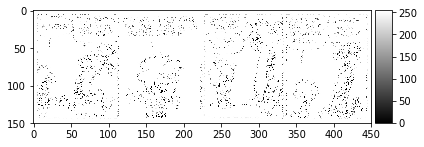

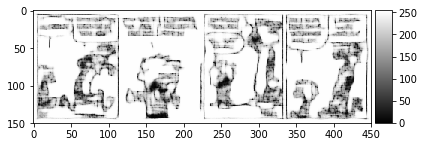

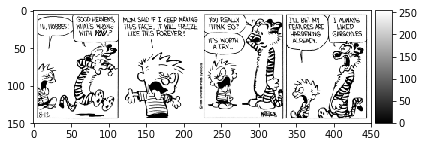

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


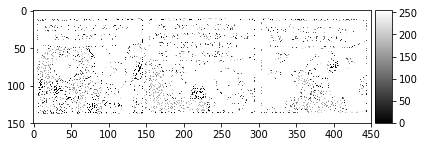

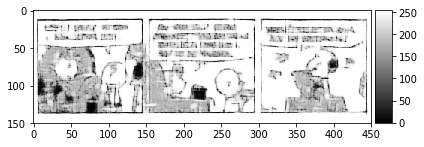

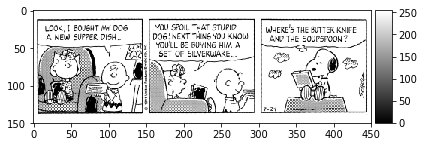

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


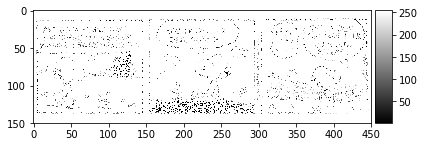

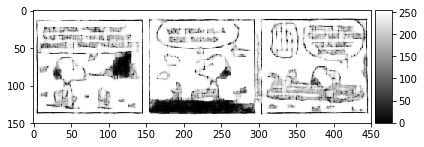

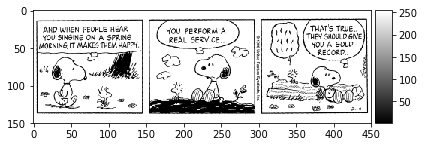

In [14]:
test_gan(g_transposed_conv, discriminator)

In [17]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(1, 7, strides=1, mask_current=True, padding='same')(layer)
output = Activation('sigmoid')(layer)

g_pixelcnn = Model(input, output, name='PixelCNN_generator')

n_channels:  1
input shape:  (None, 150, 450, 1)
(7, 7)
kernel shape:  (7, 7, 1, 8)
mask shape:  (7, 7, 1, 8)
channels_last
x:  (?, 150, 450, 1)
output:  (?, 150, 450, 8)
n_channels:  1
input shape:  (None, 150, 450, 8)
(7, 7)
kernel shape:  (7, 7, 8, 8)
mask shape:  (7, 7, 8, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
n_channels:  1
input shape:  (None, 150, 450, 8)
(7, 7)
kernel shape:  (7, 7, 8, 8)
mask shape:  (7, 7, 8, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
n_channels:  1
input shape:  (None, 150, 450, 8)
(7, 7)
kernel shape:  (7, 7, 8, 8)
mask shape:  (7, 7, 8, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
n_channels:  1
input shape:  (None, 150, 450, 8)
(7, 7)
kernel shape:  (7, 7, 8, 8)
mask shape:  (7, 7, 8, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
n_channels:  1
input shape:  (None, 150, 450, 8)
(7, 7)
kernel shape:  (7, 7, 8, 1)
mask shape:  (7, 7, 8, 1)
channels_last
x:  (?, 150, 450, 8)


channels_last
x:  (?, 150, 450, 1)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 8)
channels_last
x:  (?, 150, 450, 8)
output:  (?, 150, 450, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
PixelCNN_generator (Model)   (None, 150, 450, 1)       2713328   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,713,392
Trainable params: 2,713,328
Non-trainable params: 64
_________________________________________________________________
epoch progress report:
LATENT

c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


(1, 150, 450, 1)
image shape: (150, 450)


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


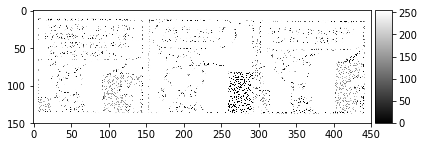

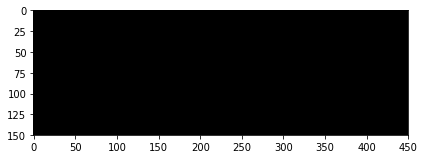

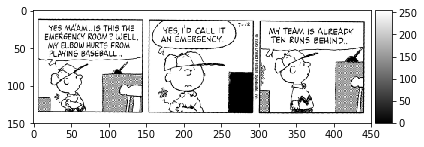

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


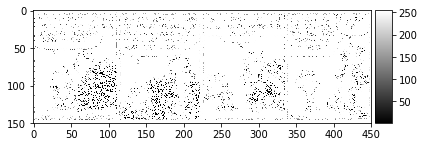

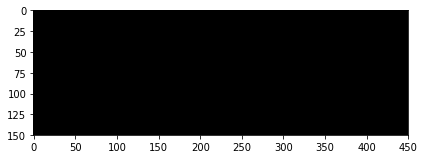

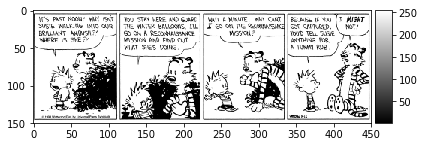

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


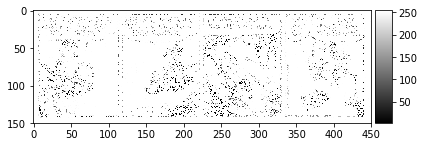

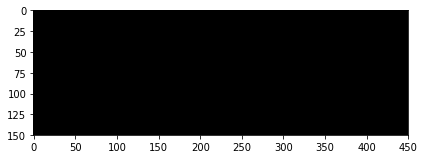

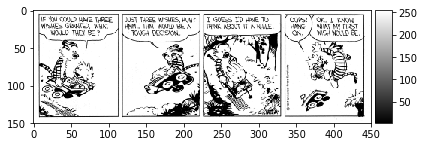

step  0 / 7367 d_loss:  0.00258012511767447 g_loss:  [341.3691, 3.4046519, 0.9039249]
step  1 / 7367 d_loss:  0.0004789111262653023 g_loss:  [218.22282, 2.1724064, 0.98217857]
step  2 / 7367 d_loss:  6.336732622003183e-05 g_loss:  [175.6026, 1.7455549, 1.0471087]
step  3 / 7367 d_loss:  0.0006564171053469181 g_loss:  [284.2894, 2.832122, 1.0771854]
step  4 / 7367 d_loss:  0.0008366102119907737 g_loss:  [176.6139, 1.7554238, 1.0715258]
step  5 / 7367 d_loss:  0.00047658063704147935 g_loss:  [211.34212, 2.102982, 1.0439167]
step  6 / 7367 d_loss:  9.509325172984973e-05 g_loss:  [200.62715, 1.996182, 1.0089633]
step  7 / 7367 d_loss:  1.8947688658954576e-05 g_loss:  [325.44418, 3.2446547, 0.9787248]
step  8 / 7367 d_loss:  0.00017193230451084673 g_loss:  [180.34038, 1.79379, 0.9613871]
step  9 / 7367 d_loss:  0.00027301543741486967 g_loss:  [296.7404, 2.9578078, 0.9596079]
step  10 / 7367 d_loss:  0.00019921109196729958 g_loss:  [140.0569, 1.390861, 0.97078943]
step  11 / 7367 d_loss:  0.

step  93 / 7367 d_loss:  1.962952040912569e-07 g_loss:  [201.61873, 2.006188, 0.9999379]
step  94 / 7367 d_loss:  1.4830765060480644e-08 g_loss:  [338.9518, 3.3795187, 0.9999424]
step  95 / 7367 d_loss:  5.0749449087561516e-09 g_loss:  [171.56679, 1.7056681, 0.999982]
step  96 / 7367 d_loss:  6.3313869702597e-08 g_loss:  [191.84258, 1.9084257, 0.99999523]
step  97 / 7367 d_loss:  4.240112616571423e-08 g_loss:  [288.2434, 2.8724344, 0.9999825]
step  98 / 7367 d_loss:  5.678626635585715e-08 g_loss:  [185.16284, 1.8416282, 1.0000172]
step  99 / 7367 d_loss:  1.677157790425099e-08 g_loss:  [276.10117, 2.7510111, 1.0000498]
step  100 / 7367 d_loss:  1.0249322457411836e-07 g_loss:  [152.29175, 1.5129167, 1.0000796]
step  101 / 7367 d_loss:  7.224961251495188e-08 g_loss:  [236.42195, 2.3542187, 1.0000756]
step  102 / 7367 d_loss:  4.005334233170288e-07 g_loss:  [142.72975, 1.4172983, 0.99993074]
step  103 / 7367 d_loss:  2.161120704613495e-08 g_loss:  [267.87637, 2.6687648, 0.9998909]
step  1

step  185 / 7367 d_loss:  6.171410937838573e-09 g_loss:  [188.77821, 1.8777823, 0.9999895]
step  186 / 7367 d_loss:  5.068039765632193e-09 g_loss:  [165.93047, 1.6493039, 1.0000787]
step  187 / 7367 d_loss:  1.346577676031302e-07 g_loss:  [223.94128, 2.2294128, 0.999998]
step  188 / 7367 d_loss:  1.0791628568540546e-07 g_loss:  [226.82759, 2.258276, 0.99999034]
step  189 / 7367 d_loss:  2.464509840649498e-08 g_loss:  [327.5602, 3.2656019, 1.0000203]
step  190 / 7367 d_loss:  2.5353756427648477e-08 g_loss:  [513.1939, 5.1219387, 1.0000491]
step  191 / 7367 d_loss:  2.6970061739461926e-08 g_loss:  [160.29301, 1.5929303, 0.9999876]
step  192 / 7367 d_loss:  3.868399378603726e-09 g_loss:  [242.36551, 2.4136558, 0.99994195]
step  193 / 7367 d_loss:  8.20634582510138e-09 g_loss:  [280.16956, 2.7916958, 0.99995863]
step  194 / 7367 d_loss:  1.6748069597838366e-09 g_loss:  [160.95903, 1.5995902, 1.0000141]
step  195 / 7367 d_loss:  4.446025769766493e-10 g_loss:  [217.99178, 2.1699173, 1.000038

step  276 / 7367 d_loss:  1.2855483788598576e-08 g_loss:  [319.59155, 3.1859167, 0.9998796]
step  277 / 7367 d_loss:  4.4757015871255135e-09 g_loss:  [240.70529, 2.3970537, 0.9999299]
step  278 / 7367 d_loss:  1.761992862725492e-08 g_loss:  [239.74258, 2.3874254, 1.0000498]
step  279 / 7367 d_loss:  3.916611035492679e-09 g_loss:  [150.40125, 1.4940118, 1.0000825]
step  280 / 7367 d_loss:  4.169758427430281e-10 g_loss:  [207.35472, 2.0635474, 0.9999883]
step  281 / 7367 d_loss:  1.8608279361842506e-09 g_loss:  [186.96356, 1.8596363, 0.99993515]
step  282 / 7367 d_loss:  4.993977453793264e-10 g_loss:  [346.6948, 3.456948, 0.9999896]
step  283 / 7367 d_loss:  1.3314636504446753e-08 g_loss:  [304.8486, 3.0384858, 1.0000296]
step  284 / 7367 d_loss:  1.0320082566295241e-08 g_loss:  [215.02327, 2.1402323, 1.0000362]
step  285 / 7367 d_loss:  1.6396076718550034e-09 g_loss:  [139.7367, 1.3873669, 0.99999475]
step  286 / 7367 d_loss:  6.217633075067397e-09 g_loss:  [215.44116, 2.1444118, 0.9999

step  367 / 7367 d_loss:  1.3293434797390091e-08 g_loss:  [196.79518, 1.9579527, 0.999913]
step  368 / 7367 d_loss:  1.7129138996097026e-07 g_loss:  [211.86688, 2.1086662, 1.0002539]
step  369 / 7367 d_loss:  3.036251712273952e-07 g_loss:  [200.7623, 1.9976213, 1.0001719]
step  370 / 7367 d_loss:  2.1476903810935255e-08 g_loss:  [269.2288, 2.6822898, 0.99982464]
step  371 / 7367 d_loss:  1.588255216233847e-08 g_loss:  [658.9264, 6.579265, 0.9998714]
step  372 / 7367 d_loss:  8.032777998323581e-08 g_loss:  [84.5514, 0.83551234, 1.0001678]
step  373 / 7367 d_loss:  1.910967881713077e-07 g_loss:  [178.0088, 1.7700877, 1.000026]
step  374 / 7367 d_loss:  4.990998263565416e-07 g_loss:  [212.06026, 2.1106052, 0.99973476]
step  375 / 7367 d_loss:  7.268405965987768e-08 g_loss:  [169.11044, 1.681105, 0.999933]
step  376 / 7367 d_loss:  3.962584482763987e-09 g_loss:  [300.1725, 2.9917226, 1.0002186]
step  377 / 7367 d_loss:  2.193486210444462e-07 g_loss:  [259.65332, 2.5865319, 1.0001347]
step 

step  459 / 7367 d_loss:  5.502092115250434e-10 g_loss:  [153.97264, 1.5297264, 1.000004]
step  460 / 7367 d_loss:  4.590328117615172e-09 g_loss:  [263.2311, 2.6223106, 1.0000315]
step  461 / 7367 d_loss:  1.889505796270896e-08 g_loss:  [290.50534, 2.8950534, 1.0000136]
step  462 / 7367 d_loss:  7.4365757996019966e-09 g_loss:  [288.14792, 2.8714793, 0.99998736]
step  463 / 7367 d_loss:  5.299569671990412e-09 g_loss:  [152.31172, 1.5131173, 0.9999813]
step  464 / 7367 d_loss:  1.7193658052860883e-08 g_loss:  [234.87926, 2.3387926, 0.9999938]
step  465 / 7367 d_loss:  1.626516976660497e-10 g_loss:  [175.86261, 1.748626, 1.000015]
step  466 / 7367 d_loss:  1.1242507619302344e-10 g_loss:  [264.84634, 2.6384635, 1.0000005]
step  467 / 7367 d_loss:  3.8052087347750785e-07 g_loss:  [138.92995, 1.3792986, 1.0000949]
step  468 / 7367 d_loss:  2.2959865475513652e-07 g_loss:  [313.33112, 3.1233125, 0.99988437]
step  469 / 7367 d_loss:  1.3358850026179425e-07 g_loss:  [260.90472, 2.5990481, 0.9999

step  550 / 7367 d_loss:  3.244810784508445e-07 g_loss:  [247.1128, 2.4611297, 0.9998356]
step  551 / 7367 d_loss:  8.184997568605468e-07 g_loss:  [128.47008, 1.2746987, 1.0002038]
step  552 / 7367 d_loss:  9.106678930947965e-07 g_loss:  [248.05356, 2.4705355, 0.99999714]
step  553 / 7367 d_loss:  3.072727565722744e-07 g_loss:  [239.0676, 2.3806772, 0.9998783]
step  554 / 7367 d_loss:  3.0236038672804e-10 g_loss:  [285.59805, 2.8459792, 1.0001276]
step  555 / 7367 d_loss:  1.2753899625295162e-07 g_loss:  [253.02225, 2.5202231, 0.99994385]
step  556 / 7367 d_loss:  3.9690402786618506e-07 g_loss:  [351.3408, 3.503409, 0.999912]
step  557 / 7367 d_loss:  2.628653135161585e-07 g_loss:  [267.56387, 2.665638, 1.0000992]
step  558 / 7367 d_loss:  3.980376206413894e-08 g_loss:  [143.64981, 1.4264985, 0.99995375]
step  559 / 7367 d_loss:  2.2171356306444068e-08 g_loss:  [167.49153, 1.6649158, 0.9999584]
step  560 / 7367 d_loss:  2.0636183251099283e-07 g_loss:  [183.13863, 1.8213853, 1.000112]
s

step  642 / 7367 d_loss:  5.782192502579164e-09 g_loss:  [268.45044, 2.6745043, 1.0000143]
step  643 / 7367 d_loss:  1.7905267268858438e-09 g_loss:  [215.87701, 2.1487703, 0.9999862]
step  644 / 7367 d_loss:  2.2555930456746864e-09 g_loss:  [332.95697, 3.3195696, 1.000011]
step  645 / 7367 d_loss:  9.645344523079302e-10 g_loss:  [228.61176, 2.2761176, 0.99999464]
step  646 / 7367 d_loss:  1.4702403916544426e-07 g_loss:  [229.40884, 2.2840886, 0.9999844]
step  647 / 7367 d_loss:  1.4454911934080883e-08 g_loss:  [222.81259, 2.2181256, 1.0000322]
step  648 / 7367 d_loss:  5.687482840244229e-08 g_loss:  [268.1415, 2.6714153, 0.9999758]
step  649 / 7367 d_loss:  5.102095457232281e-08 g_loss:  [320.23837, 3.1923833, 1.0000174]
step  650 / 7367 d_loss:  3.3882099903514984e-10 g_loss:  [292.43417, 2.9143417, 0.9999957]
step  651 / 7367 d_loss:  8.442686549869904e-09 g_loss:  [259.03802, 2.5803802, 0.9999907]
step  652 / 7367 d_loss:  2.5714806284327096e-08 g_loss:  [340.75644, 3.3975644, 1.000

step  735 / 7367 d_loss:  2.3139556937223915e-09 g_loss:  [149.60576, 1.4860576, 0.99999595]
step  736 / 7367 d_loss:  2.752376770942533e-09 g_loss:  [182.82782, 1.8182782, 1.0000036]
step  737 / 7367 d_loss:  1.0141740780511554e-09 g_loss:  [240.0798, 2.390798, 0.9999958]
step  738 / 7367 d_loss:  1.5037409095697285e-09 g_loss:  [226.19586, 2.2519586, 1.0000031]
step  739 / 7367 d_loss:  1.576793140500854e-09 g_loss:  [215.66446, 2.1466446, 0.99999404]
step  740 / 7367 d_loss:  3.610337557802268e-07 g_loss:  [187.54082, 1.8654082, 1.0000026]
step  741 / 7367 d_loss:  9.293205494032009e-08 g_loss:  [173.66042, 1.7266042, 1.000001]
step  742 / 7367 d_loss:  2.1101119784816547e-07 g_loss:  [183.28923, 1.8228923, 1.0000012]
step  743 / 7367 d_loss:  8.295840103755836e-08 g_loss:  [216.43893, 2.1543894, 1.0000017]
step  744 / 7367 d_loss:  5.379183765086282e-10 g_loss:  [726.05536, 7.2505536, 0.9999968]
step  745 / 7367 d_loss:  1.0267828809418234e-09 g_loss:  [264.8293, 2.638293, 1.000006

step  827 / 7367 d_loss:  1.678056378295878e-07 g_loss:  [221.40273, 2.204027, 1.000036]
step  828 / 7367 d_loss:  1.6862885843238473e-07 g_loss:  [306.07138, 3.0507143, 0.99998116]
step  829 / 7367 d_loss:  1.9827963271268345e-08 g_loss:  [356.3643, 3.553643, 1.0000069]
step  830 / 7367 d_loss:  2.810472210512671e-08 g_loss:  [311.8995, 3.108995, 1.0]
step  831 / 7367 d_loss:  2.1151056444068672e-06 g_loss:  [88.43382, 0.87433875, 0.999944]
step  832 / 7367 d_loss:  3.090581799369829e-07 g_loss:  [346.7672, 3.4576712, 1.0001035]
step  833 / 7367 d_loss:  6.674865744571434e-07 g_loss:  [236.59496, 2.3559504, 0.999918]
step  834 / 7367 d_loss:  3.4531251458247425e-07 g_loss:  [481.2166, 4.8021655, 1.0000613]
step  835 / 7367 d_loss:  4.559154831440537e-09 g_loss:  [353.6379, 3.5263793, 0.9999708]
step  836 / 7367 d_loss:  2.3743831434330787e-07 g_loss:  [310.18906, 3.0918908, 0.9999769]
step  837 / 7367 d_loss:  3.7794504237353976e-07 g_loss:  [251.16907, 2.5016904, 1.0000372]
step  838

step  918 / 7367 d_loss:  9.937583200780864e-09 g_loss:  [305.65125, 3.0465126, 1.0000117]
step  919 / 7367 d_loss:  9.277032475552005e-09 g_loss:  [213.5973, 2.1259732, 0.9999827]
step  920 / 7367 d_loss:  9.281682977757555e-09 g_loss:  [295.2759, 2.9427588, 1.0000219]
step  921 / 7367 d_loss:  5.787552215252845e-09 g_loss:  [175.7815, 1.7478153, 0.9999716]
step  922 / 7367 d_loss:  6.997864065994008e-09 g_loss:  [197.32706, 1.9632702, 1.0000365]
step  923 / 7367 d_loss:  1.1447376380147034e-08 g_loss:  [172.54688, 1.7154692, 0.999954]
step  924 / 7367 d_loss:  1.583020718953776e-07 g_loss:  [232.2595, 2.3125944, 1.0000653]
step  925 / 7367 d_loss:  5.342171505162696e-08 g_loss:  [305.65115, 3.0465126, 0.9999105]
step  926 / 7367 d_loss:  1.5759307814278145e-07 g_loss:  [341.4653, 3.4046519, 1.0001125]
step  927 / 7367 d_loss:  1.0306884234978497e-07 g_loss:  [328.8107, 3.2781086, 0.9998524]
step  928 / 7367 d_loss:  1.2147253869443375e-07 g_loss:  [204.84843, 2.0384824, 1.0001957]
st

step  1010 / 7367 d_loss:  1.492611589881676e-09 g_loss:  [207.87526, 2.0687528, 0.9999839]
step  1011 / 7367 d_loss:  6.136341657025923e-09 g_loss:  [322.63812, 3.216381, 1.0000079]
step  1012 / 7367 d_loss:  4.27302175864952e-08 g_loss:  [130.05998, 1.2905998, 0.9999943]
step  1013 / 7367 d_loss:  1.0264012750837992e-08 g_loss:  [237.13248, 2.3613245, 1.0000079]
step  1014 / 7367 d_loss:  2.4474163140553173e-08 g_loss:  [158.90152, 1.5790153, 0.99999714]
step  1015 / 7367 d_loss:  5.172529515817814e-09 g_loss:  [231.19302, 2.3019302, 1.0]
step  1016 / 7367 d_loss:  1.5172112455275055e-09 g_loss:  [251.19688, 2.5019689, 1.0000019]
step  1017 / 7367 d_loss:  1.7650959804882405e-08 g_loss:  [285.74075, 2.8474076, 0.9999938]
step  1018 / 7367 d_loss:  6.817134412528958e-09 g_loss:  [244.88365, 2.4388366, 1.0000064]
step  1019 / 7367 d_loss:  3.0142306428615484e-09 g_loss:  [275.48425, 2.7448425, 0.9999962]
step  1020 / 7367 d_loss:  9.879354223585324e-09 g_loss:  [377.52963, 3.7652965, 1

step  1101 / 7367 d_loss:  5.420912657427834e-06 g_loss:  [218.41797, 2.1741781, 1.0001538]
step  1102 / 7367 d_loss:  5.025236532674171e-06 g_loss:  [296.91806, 2.9591746, 1.0006078]
step  1103 / 7367 d_loss:  2.5085039396799402e-06 g_loss:  [284.13403, 2.831351, 0.99892014]
step  1104 / 7367 d_loss:  4.553027963538625e-07 g_loss:  [184.00523, 1.8300402, 1.0012048]
step  1105 / 7367 d_loss:  1.387582670986376e-07 g_loss:  [137.84332, 1.3684435, 0.99897194]
step  1106 / 7367 d_loss:  7.573968900942418e-07 g_loss:  [210.48209, 2.0948145, 1.0006303]
step  1107 / 7367 d_loss:  1.4212587302608881e-06 g_loss:  [400.07938, 3.9907954, 0.9998441]
step  1108 / 7367 d_loss:  1.371924668092106e-06 g_loss:  [307.53387, 3.0653412, 0.99974203]
step  1109 / 7367 d_loss:  8.032621963138808e-07 g_loss:  [291.1388, 2.9013824, 1.0005358]
step  1110 / 7367 d_loss:  1.2364550912025152e-06 g_loss:  [88.433205, 0.87433875, 0.9993321]
step  1111 / 7367 d_loss:  5.649240506500064e-07 g_loss:  [232.77509, 2.317

step  1191 / 7367 d_loss:  2.745372107426647e-08 g_loss:  [160.35349, 1.5935355, 0.99993086]
step  1192 / 7367 d_loss:  3.504840506707296e-08 g_loss:  [267.18713, 2.6618705, 1.000082]
step  1193 / 7367 d_loss:  5.700333716163186e-08 g_loss:  [312.8592, 3.118593, 0.9999002]
step  1194 / 7367 d_loss:  6.40832027443139e-08 g_loss:  [219.98105, 2.1898093, 1.0001209]
step  1195 / 7367 d_loss:  1.1831472335188664e-07 g_loss:  [182.37479, 1.8137494, 0.99984837]
step  1196 / 7367 d_loss:  1.4910256140865386e-07 g_loss:  [216.78278, 2.157826, 1.0001907]
step  1197 / 7367 d_loss:  2.2448101333338855e-07 g_loss:  [333.25748, 3.3225772, 0.99976146]
step  1198 / 7367 d_loss:  3.462215829586057e-07 g_loss:  [215.83922, 2.148389, 1.0003018]
step  1199 / 7367 d_loss:  5.313986548571847e-07 g_loss:  [262.2291, 2.612295, 0.9996163]
step  1200 / 7367 d_loss:  8.247280902651255e-07 g_loss:  [291.0926, 2.900921, 1.0004894]
step  1201 / 7367 d_loss:  1.3277896186991711e-06 g_loss:  [136.25711, 1.3525773, 0.

step  1282 / 7367 d_loss:  4.519522533996678e-09 g_loss:  [235.20746, 2.3420746, 0.9999927]
step  1283 / 7367 d_loss:  2.2289858847557298e-09 g_loss:  [400.17194, 3.9917195, 1.0000043]
step  1284 / 7367 d_loss:  4.985595269957344e-10 g_loss:  [286.0411, 2.8504112, 0.9999982]
step  1285 / 7367 d_loss:  1.868357135670351e-10 g_loss:  [270.14453, 2.6914454, 0.99999976]
step  1286 / 7367 d_loss:  3.664160919125692e-10 g_loss:  [266.1443, 2.651443, 1.0000014]
step  1287 / 7367 d_loss:  8.49251780010718e-10 g_loss:  [224.07379, 2.230738, 0.99999714]
step  1288 / 7367 d_loss:  2.2454155201856452e-10 g_loss:  [184.31421, 1.8331422, 1.0000029]
step  1289 / 7367 d_loss:  5.989247431337219e-10 g_loss:  [280.87756, 2.7987757, 0.99999785]
step  1290 / 7367 d_loss:  1.6049515050298169e-09 g_loss:  [313.33124, 3.1233125, 1.0000026]
step  1291 / 7367 d_loss:  2.2592989701308852e-09 g_loss:  [184.31421, 1.8331422, 0.99999857]
step  1292 / 7367 d_loss:  2.1382211556897346e-08 g_loss:  [223.23904, 2.2223

step  1371 / 7367 d_loss:  2.440724067298561e-09 g_loss:  [351.4881, 3.5048847, 0.9996298]
step  1372 / 7367 d_loss:  8.676479268387993e-08 g_loss:  [210.79988, 2.0979965, 1.000231]
step  1373 / 7367 d_loss:  1.2951862515819812e-07 g_loss:  [387.0432, 3.8604324, 0.9999577]
step  1374 / 7367 d_loss:  1.6341391528840177e-07 g_loss:  [245.04886, 2.44049, 0.9998658]
step  1375 / 7367 d_loss:  6.196043500494852e-08 g_loss:  [269.9356, 2.689354, 1.0002263]
step  1376 / 7367 d_loss:  1.023016604762006e-08 g_loss:  [241.5227, 2.4052293, 0.9997761]
step  1377 / 7367 d_loss:  1.2053342324236382e-08 g_loss:  [342.56876, 3.4156861, 1.0001562]
step  1378 / 7367 d_loss:  3.9542705110307e-08 g_loss:  [309.57843, 3.085785, 0.9999442]
step  1379 / 7367 d_loss:  4.30000461904001e-08 g_loss:  [247.75679, 2.4675684, 0.9999604]
step  1380 / 7367 d_loss:  2.8129200302373647e-08 g_loss:  [172.36044, 1.7136034, 1.0001061]
step  1381 / 7367 d_loss:  6.176591238471474e-09 g_loss:  [253.21658, 2.5221672, 0.99987

step  1463 / 7367 d_loss:  2.8519114847469496e-10 g_loss:  [266.8076, 2.6580758, 1.0000021]
step  1464 / 7367 d_loss:  1.7357802972739478e-09 g_loss:  [236.39667, 2.3539667, 0.9999982]
step  1465 / 7367 d_loss:  1.1721872361647456e-09 g_loss:  [147.51236, 1.4651235, 1.0000014]
step  1466 / 7367 d_loss:  8.125761397081988e-09 g_loss:  [271.11157, 2.7011158, 0.9999969]
step  1467 / 7367 d_loss:  2.1339445765988785e-09 g_loss:  [303.7633, 3.027633, 1.0000038]
step  1468 / 7367 d_loss:  3.937929538011531e-09 g_loss:  [114.901276, 1.1390128, 0.9999951]
step  1469 / 7367 d_loss:  2.5441171391804573e-09 g_loss:  [207.93079, 2.0693078, 1.0000055]
step  1470 / 7367 d_loss:  1.751751455003614e-08 g_loss:  [190.386, 1.8938602, 0.9999914]
step  1471 / 7367 d_loss:  5.794795754354709e-09 g_loss:  [202.31291, 2.013129, 1.0000117]
step  1472 / 7367 d_loss:  4.976754119923044e-09 g_loss:  [339.44418, 3.3844419, 0.9999871]
step  1473 / 7367 d_loss:  1.054035969616507e-08 g_loss:  [263.93167, 2.6293163,

step  1553 / 7367 d_loss:  7.042022076575449e-09 g_loss:  [122.31723, 1.2131724, 0.99998224]
step  1554 / 7367 d_loss:  6.296628551893946e-09 g_loss:  [225.25784, 2.2425783, 1.0000155]
step  1555 / 7367 d_loss:  5.266564961914355e-10 g_loss:  [198.86795, 1.9786797, 0.99998784]
step  1556 / 7367 d_loss:  4.771692374561098e-09 g_loss:  [143.12741, 1.4212741, 1.0000072]
step  1557 / 7367 d_loss:  1.496610391171771e-09 g_loss:  [145.78119, 1.4478118, 0.9999981]
step  1558 / 7367 d_loss:  1.1629641694099746e-09 g_loss:  [282.6757, 2.816757, 0.99999917]
step  1559 / 7367 d_loss:  1.0242894310508177e-09 g_loss:  [292.14755, 2.9114754, 1.0000043]
step  1560 / 7367 d_loss:  2.052137348940164e-09 g_loss:  [208.07796, 2.0707796, 0.9999951]
step  1561 / 7367 d_loss:  5.536012759321807e-10 g_loss:  [478.79645, 4.7779646, 1.0000045]
step  1562 / 7367 d_loss:  3.432424566796044e-09 g_loss:  [233.23817, 2.3223817, 0.99999547]
step  1563 / 7367 d_loss:  9.012596224877711e-12 g_loss:  [374.2038, 3.73203

step  1643 / 7367 d_loss:  8.319367594822324e-08 g_loss:  [190.46617, 1.8946676, 0.9994053]
step  1644 / 7367 d_loss:  3.7406405084539074e-08 g_loss:  [112.70352, 1.1170305, 1.0004721]
step  1645 / 7367 d_loss:  2.8556189590744907e-07 g_loss:  [357.54807, 3.5654833, 0.999715]
step  1646 / 7367 d_loss:  3.4236862234138243e-07 g_loss:  [286.9849, 2.8598483, 1.0000684]
step  1647 / 7367 d_loss:  4.0696770042814023e-07 g_loss:  [222.74149, 2.2174134, 1.0001314]
step  1648 / 7367 d_loss:  2.066112045895352e-07 g_loss:  [268.4502, 2.6745043, 0.99974537]
step  1649 / 7367 d_loss:  4.7306617290132635e-08 g_loss:  [182.65529, 1.81655, 1.000294]
step  1650 / 7367 d_loss:  3.5073338011670785e-08 g_loss:  [157.59874, 1.5659901, 0.9997269]
step  1651 / 7367 d_loss:  2.717843905486461e-08 g_loss:  [308.43753, 3.0743735, 1.0001962]
step  1652 / 7367 d_loss:  1.0981275266885859e-07 g_loss:  [206.28448, 2.0528457, 0.999913]
step  1653 / 7367 d_loss:  1.0803686478766394e-07 g_loss:  [310.15338, 3.091533

step  1733 / 7367 d_loss:  3.775269163952544e-08 g_loss:  [307.53403, 3.0653412, 0.999923]
step  1734 / 7367 d_loss:  1.356777374894591e-07 g_loss:  [266.2751, 2.65275, 1.000093]
step  1735 / 7367 d_loss:  5.5342180615980396e-08 g_loss:  [437.52472, 4.3652472, 0.99999475]
step  1736 / 7367 d_loss:  7.257053766807076e-07 g_loss:  [362.52682, 3.6152673, 1.0000992]
step  1737 / 7367 d_loss:  2.4785768459878454e-07 g_loss:  [204.15924, 2.0315936, 0.9998802]
step  1738 / 7367 d_loss:  2.4353059302484326e-07 g_loss:  [238.23558, 2.3723574, 0.9998435]
step  1739 / 7367 d_loss:  4.156692412493612e-08 g_loss:  [278.25375, 2.7725365, 1.0000875]
step  1740 / 7367 d_loss:  2.8695923859345385e-08 g_loss:  [237.9569, 2.3695676, 1.0001409]
step  1741 / 7367 d_loss:  1.1171132996423694e-07 g_loss:  [293.1802, 2.9218023, 0.9999697]
step  1742 / 7367 d_loss:  9.684784174623928e-08 g_loss:  [206.28381, 2.0528386, 0.9999584]
step  1743 / 7367 d_loss:  1.769254822647781e-07 g_loss:  [300.3655, 2.9936538, 1

step  1824 / 7367 d_loss:  5.629672727991419e-07 g_loss:  [237.19267, 2.3619266, 1.0000126]
step  1825 / 7367 d_loss:  4.03226010803337e-07 g_loss:  [267.75177, 2.6675186, 0.9998989]
step  1826 / 7367 d_loss:  1.4901303302394808e-08 g_loss:  [287.6109, 2.8661084, 1.0000503]
step  1827 / 7367 d_loss:  1.4907239176409348e-07 g_loss:  [273.9315, 2.7293153, 0.9999814]
step  1828 / 7367 d_loss:  2.948694373117178e-07 g_loss:  [211.49388, 2.1049402, 0.9998572]
step  1829 / 7367 d_loss:  1.0434882113941057e-07 g_loss:  [231.0637, 2.300637, 1.0000069]
step  1830 / 7367 d_loss:  5.175679440583281e-09 g_loss:  [256.387, 2.5538688, 1.0001214]
step  1831 / 7367 d_loss:  9.560385905160729e-08 g_loss:  [207.84409, 2.068441, 1.0000064]
step  1832 / 7367 d_loss:  1.7035463883985358e-07 g_loss:  [264.84732, 2.6384735, 0.99998355]
step  1833 / 7367 d_loss:  1.5378695650269947e-08 g_loss:  [423.62772, 4.226277, 1.0000234]
step  1834 / 7367 d_loss:  3.009830606970354e-07 g_loss:  [98.90259, 0.97902685, 0.

step  1915 / 7367 d_loss:  1.7713514353090432e-06 g_loss:  [284.03723, 2.8303723, 0.9999939]
step  1916 / 7367 d_loss:  5.329047780833207e-06 g_loss:  [165.45694, 1.6445711, 0.9998368]
step  1917 / 7367 d_loss:  7.683259354962502e-06 g_loss:  [420.07376, 4.1907425, 0.99952656]
step  1918 / 7367 d_loss:  7.6095543590781745e-06 g_loss:  [161.50906, 1.6050979, 0.999274]
step  1919 / 7367 d_loss:  5.528189831238706e-06 g_loss:  [210.64786, 2.0964859, 0.9992616]
step  1920 / 7367 d_loss:  2.8055437724106014e-06 g_loss:  [169.53639, 1.6853688, 0.99951786]
step  1921 / 7367 d_loss:  8.49508069222793e-07 g_loss:  [278.1496, 2.7714968, 0.9999163]
step  1922 / 7367 d_loss:  1.2752362721357713e-08 g_loss:  [264.3686, 2.6336832, 1.000278]
step  1923 / 7367 d_loss:  2.59124046664283e-08 g_loss:  [399.54175, 3.9854133, 1.0004144]
step  1924 / 7367 d_loss:  1.0223196795777767e-06 g_loss:  [196.93869, 1.9593831, 1.0003843]
step  1925 / 7367 d_loss:  1.704141709524265e-06 g_loss:  [407.84064, 4.0684037

step  2007 / 7367 d_loss:  1.0384229032212033e-09 g_loss:  [237.49535, 2.3649535, 0.9999999]
step  2008 / 7367 d_loss:  5.386719958977437e-10 g_loss:  [258.08575, 2.5708573, 1.0000222]
step  2009 / 7367 d_loss:  1.2067030707996196e-10 g_loss:  [189.12694, 1.8812691, 1.0000265]
step  2010 / 7367 d_loss:  1.6788379020304944e-10 g_loss:  [230.90448, 2.2990446, 1.0000143]
step  2011 / 7367 d_loss:  1.1427763249582945e-11 g_loss:  [240.70537, 2.3970537, 0.99999523]
step  2012 / 7367 d_loss:  1.28793031795027e-09 g_loss:  [236.67058, 2.356706, 0.9999864]
step  2013 / 7367 d_loss:  2.030654755458272e-09 g_loss:  [308.49066, 3.074907, 0.99998295]
step  2014 / 7367 d_loss:  3.017756045053943e-10 g_loss:  [294.9606, 2.939606, 0.99999285]
step  2015 / 7367 d_loss:  2.4847077173539844e-10 g_loss:  [204.15936, 2.0315936, 1.0000069]
step  2016 / 7367 d_loss:  3.2658850623867863e-10 g_loss:  [194.90985, 1.9390984, 1.0000157]
step  2017 / 7367 d_loss:  1.8200074780594377e-10 g_loss:  [165.45337, 1.644

step  2098 / 7367 d_loss:  3.4050817721009707e-12 g_loss:  [243.44655, 2.4244654, 1.0000074]
step  2099 / 7367 d_loss:  2.196876014437521e-09 g_loss:  [647.64886, 6.466489, 1.0000021]
step  2100 / 7367 d_loss:  1.458484111260816e-09 g_loss:  [286.28687, 2.8528686, 1.0000007]
step  2101 / 7367 d_loss:  8.461468192777488e-10 g_loss:  [224.7432, 2.237432, 1.0000024]
step  2102 / 7367 d_loss:  1.8019155056947511e-09 g_loss:  [164.3516, 1.633516, 1.0000072]
step  2103 / 7367 d_loss:  4.528270536319212e-10 g_loss:  [146.06224, 1.4506222, 1.0000088]
step  2104 / 7367 d_loss:  4.051512902947252e-09 g_loss:  [224.5456, 2.235456, 0.999997]
step  2105 / 7367 d_loss:  5.877512920804406e-10 g_loss:  [235.68071, 2.3468072, 0.9999919]
step  2106 / 7367 d_loss:  3.083267252623756e-10 g_loss:  [181.86337, 1.8086337, 0.9999956]
step  2107 / 7367 d_loss:  6.740497604518225e-10 g_loss:  [199.5076, 1.985076, 1.0000043]
step  2108 / 7367 d_loss:  1.0146304629810032e-10 g_loss:  [187.5146, 1.8651458, 1.00000

step  2190 / 7367 d_loss:  2.8370834570523584e-09 g_loss:  [538.6547, 5.3765473, 0.99999154]
step  2191 / 7367 d_loss:  3.5538401110812856e-09 g_loss:  [186.60455, 1.8560454, 1.0000136]
step  2192 / 7367 d_loss:  2.6676821862636757e-10 g_loss:  [123.896225, 1.2289621, 1.0000191]
step  2193 / 7367 d_loss:  2.864218195952617e-09 g_loss:  [200.27635, 1.9927634, 1.0000157]
step  2194 / 7367 d_loss:  6.155798093487874e-11 g_loss:  [225.52542, 2.2452543, 1.0000002]
step  2195 / 7367 d_loss:  6.582539402444354e-09 g_loss:  [216.96729, 2.159673, 0.9999777]
step  2196 / 7367 d_loss:  1.0762526980734322e-10 g_loss:  [196.72559, 1.9572562, 0.99997604]
step  2197 / 7367 d_loss:  4.926904023649925e-11 g_loss:  [156.31895, 1.5531895, 0.9999933]
step  2198 / 7367 d_loss:  2.7933642066102493e-09 g_loss:  [262.40005, 2.6140006, 1.000006]
step  2199 / 7367 d_loss:  2.085528638673395e-09 g_loss:  [257.9541, 2.5695407, 1.0000174]
step  2200 / 7367 d_loss:  1.5138676978665444e-09 g_loss:  [150.9619, 1.4996

step  2280 / 7367 d_loss:  9.540392920115437e-10 g_loss:  [301.44275, 3.0044272, 1.0000236]
step  2281 / 7367 d_loss:  5.003681913251512e-10 g_loss:  [235.06226, 2.3406222, 1.0000367]
step  2282 / 7367 d_loss:  2.961303424697803e-10 g_loss:  [122.2762, 1.2127619, 1.0000179]
step  2283 / 7367 d_loss:  2.7209949848838733e-09 g_loss:  [393.9325, 3.929325, 0.9999949]
step  2284 / 7367 d_loss:  4.1195608035948794e-10 g_loss:  [238.34859, 2.373486, 0.9999831]
step  2285 / 7367 d_loss:  1.7644495864388432e-09 g_loss:  [200.96704, 1.9996704, 0.9999925]
step  2286 / 7367 d_loss:  1.5916392648307465e-09 g_loss:  [137.98404, 1.3698404, 1.0000014]
step  2287 / 7367 d_loss:  4.658684549241343e-10 g_loss:  [240.07982, 2.390798, 1.0000107]
step  2288 / 7367 d_loss:  2.8989451464345173e-11 g_loss:  [149.39745, 1.4839743, 1.00001]
step  2289 / 7367 d_loss:  6.357937787360157e-11 g_loss:  [317.92633, 3.1692634, 1.0000017]
step  2290 / 7367 d_loss:  2.1601160860029722e-09 g_loss:  [119.6631, 1.1866312, 0

step  2371 / 7367 d_loss:  2.2095127949484095e-09 g_loss:  [222.21893, 2.212189, 1.0000229]
step  2372 / 7367 d_loss:  2.6998184243787193e-10 g_loss:  [282.13046, 2.8113043, 1.0000234]
step  2373 / 7367 d_loss:  7.529222245672429e-10 g_loss:  [210.71782, 2.0971782, 1.0000062]
step  2374 / 7367 d_loss:  2.3450177910611103e-10 g_loss:  [280.15045, 2.7915044, 0.9999883]
step  2375 / 7367 d_loss:  2.9480364815981375e-09 g_loss:  [345.99982, 3.4499986, 0.99997663]
step  2376 / 7367 d_loss:  7.569493365444657e-10 g_loss:  [254.17323, 2.5317326, 0.9999856]
step  2377 / 7367 d_loss:  1.530065962818128e-09 g_loss:  [208.86227, 2.0786226, 1.000011]
step  2378 / 7367 d_loss:  4.3991302267620824e-10 g_loss:  [298.0381, 2.9703805, 1.0000248]
step  2379 / 7367 d_loss:  1.1945132660784452e-09 g_loss:  [261.78906, 2.6078904, 1.0000179]
step  2380 / 7367 d_loss:  4.099133810164801e-10 g_loss:  [143.23056, 1.4223056, 0.99999833]
step  2381 / 7367 d_loss:  8.194622758139758e-10 g_loss:  [138.09253, 1.370

step  2462 / 7367 d_loss:  4.95342566964041e-09 g_loss:  [322.72742, 3.2172742, 0.9999858]
step  2463 / 7367 d_loss:  6.949685271706585e-09 g_loss:  [225.05463, 2.240547, 0.99994636]
step  2464 / 7367 d_loss:  1.0579865374893416e-06 g_loss:  [415.54825, 4.1454844, 0.9998257]
step  2465 / 7367 d_loss:  4.267397812895979e-08 g_loss:  [187.38197, 1.8638204, 0.9999311]
step  2466 / 7367 d_loss:  1.7345070091323578e-07 g_loss:  [296.35034, 2.953502, 1.0001462]
step  2467 / 7367 d_loss:  1.5380196316527872e-07 g_loss:  [180.22227, 1.7922205, 1.0002308]
step  2468 / 7367 d_loss:  1.0764895108650308e-07 g_loss:  [272.6728, 2.7167268, 1.0001147]
step  2469 / 7367 d_loss:  2.653922059892011e-08 g_loss:  [233.2381, 2.3223817, 0.9999294]
step  2470 / 7367 d_loss:  3.0093989522583797e-09 g_loss:  [236.85118, 2.3585134, 0.9998505]
step  2471 / 7367 d_loss:  1.4219739163934264e-08 g_loss:  [194.42343, 1.9342351, 0.9999212]
step  2472 / 7367 d_loss:  4.35807940846189e-08 g_loss:  [207.8753, 2.0687528,

step  2553 / 7367 d_loss:  1.1147913703268841e-09 g_loss:  [239.37561, 2.383756, 1.00002]
step  2554 / 7367 d_loss:  4.5593429032209087e-10 g_loss:  [285.42557, 2.8442557, 0.99999595]
step  2555 / 7367 d_loss:  3.221932165509145e-10 g_loss:  [219.12653, 2.1812654, 0.9999784]
step  2556 / 7367 d_loss:  1.728062803962871e-09 g_loss:  [219.98091, 2.1898093, 0.99998164]
step  2557 / 7367 d_loss:  1.1312110359540384e-08 g_loss:  [315.28915, 3.1428916, 0.9999882]
step  2558 / 7367 d_loss:  7.62840235424278e-10 g_loss:  [404.4624, 4.034624, 1.0000019]
step  2559 / 7367 d_loss:  2.7635058685859804e-09 g_loss:  [434.01715, 4.330171, 1.0000188]
step  2560 / 7367 d_loss:  2.5503400280513233e-08 g_loss:  [277.66238, 2.766624, 0.9999869]
step  2561 / 7367 d_loss:  1.2500755985911383e-08 g_loss:  [233.40277, 2.3240278, 0.99999285]
step  2562 / 7367 d_loss:  2.076282079599423e-08 g_loss:  [369.20163, 3.6820161, 1.0000281]
step  2563 / 7367 d_loss:  1.344028444094647e-08 g_loss:  [213.46101, 2.1246097

step  2643 / 7367 d_loss:  1.0089429985926657e-10 g_loss:  [147.44249, 1.4644247, 1.0000079]
step  2644 / 7367 d_loss:  8.838181922432575e-12 g_loss:  [182.01003, 1.8101002, 1.0000038]
step  2645 / 7367 d_loss:  7.543957125655254e-11 g_loss:  [208.057, 2.07057, 0.99999785]
step  2646 / 7367 d_loss:  4.783014262432772e-12 g_loss:  [120.437614, 1.1943762, 0.99999523]
step  2647 / 7367 d_loss:  2.825473362222386e-11 g_loss:  [384.0504, 3.8305042, 0.99999964]
step  2648 / 7367 d_loss:  1.6748581688208475e-10 g_loss:  [256.35922, 2.5535922, 1.0000014]
step  2649 / 7367 d_loss:  7.787439096351711e-12 g_loss:  [211.49402, 2.1049402, 1.0000019]
step  2650 / 7367 d_loss:  3.5563108014002864e-11 g_loss:  [177.22685, 1.7622685, 1.0000017]
step  2651 / 7367 d_loss:  4.5680015325899603e-11 g_loss:  [243.75908, 2.4275908, 1.0000007]
step  2652 / 7367 d_loss:  2.874828708421262e-10 g_loss:  [343.89737, 3.4289737, 0.99999666]
step  2653 / 7367 d_loss:  5.160344374033343e-12 g_loss:  [431.14755, 4.3014

step  2733 / 7367 d_loss:  7.166219173626587e-09 g_loss:  [375.49945, 3.7449946, 0.99998593]
step  2734 / 7367 d_loss:  1.1928753818057913e-10 g_loss:  [165.02519, 1.640252, 1.0000048]
step  2735 / 7367 d_loss:  1.2927499071224702e-09 g_loss:  [254.39357, 2.5339355, 1.00002]
step  2736 / 7367 d_loss:  1.6470659280898303e-09 g_loss:  [189.40015, 1.8840014, 1.0000126]
step  2737 / 7367 d_loss:  9.352110197369257e-10 g_loss:  [259.03802, 2.5803802, 0.9999956]
step  2738 / 7367 d_loss:  8.699545250845375e-11 g_loss:  [268.65817, 2.6765819, 0.99998903]
step  2739 / 7367 d_loss:  8.328050249417629e-09 g_loss:  [173.6292, 1.7262921, 0.9999825]
step  2740 / 7367 d_loss:  2.8919279415617893e-08 g_loss:  [266.82657, 2.658266, 0.9999714]
step  2741 / 7367 d_loss:  1.281933936780888e-08 g_loss:  [200.00545, 1.9900544, 1.0000188]
step  2742 / 7367 d_loss:  1.3799526854541e-08 g_loss:  [182.9188, 1.8191874, 1.0000525]
step  2743 / 7367 d_loss:  9.084288876692881e-09 g_loss:  [272.60052, 2.7160048, 1

step  2825 / 7367 d_loss:  1.0939819050648225e-09 g_loss:  [288.74652, 2.8774648, 1.0000317]
step  2826 / 7367 d_loss:  6.257439011392307e-10 g_loss:  [332.75403, 3.3175397, 1.0000467]
step  2827 / 7367 d_loss:  6.329975210661587e-09 g_loss:  [192.79, 1.9179, 1.0000057]
step  2828 / 7367 d_loss:  8.306285437242877e-09 g_loss:  [203.75891, 2.0275893, 0.99998045]
step  2829 / 7367 d_loss:  5.404754421789448e-09 g_loss:  [163.69412, 1.6269412, 1.0000012]
step  2830 / 7367 d_loss:  1.1054867021798032e-09 g_loss:  [216.74112, 2.157411, 1.0000219]
step  2831 / 7367 d_loss:  3.024802630591239e-10 g_loss:  [168.60799, 1.6760799, 1.0000038]
step  2832 / 7367 d_loss:  2.397945397802914e-09 g_loss:  [150.1386, 1.4913863, 0.99997497]
step  2833 / 7367 d_loss:  3.1649665110933256e-09 g_loss:  [187.49492, 1.8649493, 0.99997807]
step  2834 / 7367 d_loss:  4.0069650708574045e-08 g_loss:  [111.095764, 1.1009579, 0.9999769]
step  2835 / 7367 d_loss:  1.6800641988723442e-09 g_loss:  [226.51805, 2.2551804

step  2914 / 7367 d_loss:  1.7702601884383995e-10 g_loss:  [148.63683, 1.4763682, 1.0000043]
step  2915 / 7367 d_loss:  1.16733178678885e-09 g_loss:  [254.47629, 2.534763, 0.99998975]
step  2916 / 7367 d_loss:  8.146501251360405e-10 g_loss:  [298.35117, 2.9735117, 0.9999888]
step  2917 / 7367 d_loss:  7.61087104450553e-09 g_loss:  [133.38223, 1.3238225, 0.99998987]
step  2918 / 7367 d_loss:  1.16479936806968e-10 g_loss:  [372.8211, 3.7182112, 1.0000086]
step  2919 / 7367 d_loss:  2.8074120805854363e-10 g_loss:  [222.90547, 2.2190547, 1.0000069]
step  2920 / 7367 d_loss:  8.792089722930996e-09 g_loss:  [158.12012, 1.571201, 1.0000124]
step  2921 / 7367 d_loss:  7.988554706628292e-09 g_loss:  [263.93164, 2.6293163, 1.0000131]
step  2922 / 7367 d_loss:  6.645361594337373e-09 g_loss:  [225.84103, 2.2484102, 1.0000076]
step  2923 / 7367 d_loss:  5.519482648708163e-10 g_loss:  [132.80922, 1.3180923, 0.99998677]
step  2924 / 7367 d_loss:  4.713461176919509e-09 g_loss:  [256.83316, 2.558332, 0

step  3005 / 7367 d_loss:  6.72177313809641e-11 g_loss:  [253.59421, 2.525942, 1.0000052]
step  3006 / 7367 d_loss:  6.738077873436055e-10 g_loss:  [196.0087, 1.9500871, 0.9999802]
step  3007 / 7367 d_loss:  4.737318537451074e-09 g_loss:  [249.5159, 2.4851592, 0.99998116]
step  3008 / 7367 d_loss:  6.659445217493953e-10 g_loss:  [340.75644, 3.3975644, 1.0000093]
step  3009 / 7367 d_loss:  9.043727572377591e-11 g_loss:  [214.75383, 2.1375382, 1.0000155]
step  3010 / 7367 d_loss:  3.3525163201097996e-10 g_loss:  [172.34164, 1.7134165, 0.99999774]
step  3011 / 7367 d_loss:  9.62857016340024e-10 g_loss:  [152.57875, 1.5157875, 0.9999931]
step  3012 / 7367 d_loss:  1.4457057773142878e-09 g_loss:  [205.924, 2.0492399, 1.0000081]
step  3013 / 7367 d_loss:  4.8369780403234586e-11 g_loss:  [107.261536, 1.0626153, 1.0000055]
step  3014 / 7367 d_loss:  7.231438781118982e-10 g_loss:  [255.46878, 2.544688, 0.9999893]
step  3015 / 7367 d_loss:  4.4187825620767285e-10 g_loss:  [180.89235, 1.7989236, 

step  3096 / 7367 d_loss:  3.252712943435654e-08 g_loss:  [320.29205, 3.1929214, 0.9999112]
step  3097 / 7367 d_loss:  6.348334746775208e-09 g_loss:  [240.4286, 2.3942857, 1.000035]
step  3098 / 7367 d_loss:  1.5249955742646648e-09 g_loss:  [232.93503, 2.3193495, 1.0000699]
step  3099 / 7367 d_loss:  9.452248761476767e-09 g_loss:  [152.31172, 1.5131173, 0.99998534]
step  3100 / 7367 d_loss:  1.5614872950209246e-08 g_loss:  [228.82123, 2.2782125, 0.9999666]
step  3101 / 7367 d_loss:  7.836297166718964e-10 g_loss:  [242.20511, 2.412051, 1.0000095]
step  3102 / 7367 d_loss:  6.287161902207572e-10 g_loss:  [166.03629, 1.6503625, 1.0000303]
step  3103 / 7367 d_loss:  1.260100579436596e-09 g_loss:  [172.75127, 1.7175126, 0.9999969]
step  3104 / 7367 d_loss:  1.8725152983734006e-08 g_loss:  [218.41777, 2.1741781, 0.9999509]
step  3105 / 7367 d_loss:  1.1673703115278045e-09 g_loss:  [373.1256, 3.721256, 1.0000122]
step  3106 / 7367 d_loss:  2.110621899475973e-09 g_loss:  [261.8062, 2.6080616, 

step  3187 / 7367 d_loss:  1.94467864034209e-09 g_loss:  [295.00946, 2.9400947, 1.0000007]
step  3188 / 7367 d_loss:  5.797272106811135e-10 g_loss:  [190.22737, 1.8922738, 1.0000072]
step  3189 / 7367 d_loss:  1.2253482950530525e-11 g_loss:  [188.61658, 1.8761657, 0.9999981]
step  3190 / 7367 d_loss:  7.011046743166105e-10 g_loss:  [296.32144, 2.9532144, 0.99998975]
step  3191 / 7367 d_loss:  1.4040645313073696e-09 g_loss:  [195.88707, 1.9488707, 0.9999969]
step  3192 / 7367 d_loss:  4.907690920319396e-10 g_loss:  [209.48398, 2.0848398, 1.000005]
step  3193 / 7367 d_loss:  2.306002278018582e-09 g_loss:  [202.54182, 2.0154183, 0.9999925]
step  3194 / 7367 d_loss:  1.7135510788079955e-09 g_loss:  [350.90936, 3.4990938, 1.000005]
step  3195 / 7367 d_loss:  1.6138580472002673e-09 g_loss:  [238.51778, 2.3751776, 1.0000122]
step  3196 / 7367 d_loss:  9.344061080440724e-10 g_loss:  [123.11967, 1.2211967, 0.9999981]
step  3197 / 7367 d_loss:  3.933540437817129e-10 g_loss:  [473.01352, 4.720135

step  3278 / 7367 d_loss:  2.7213251652113968e-09 g_loss:  [340.75644, 3.3975644, 1.0000119]
step  3279 / 7367 d_loss:  1.141703087625956e-08 g_loss:  [236.73018, 2.357302, 0.9999918]
step  3280 / 7367 d_loss:  4.735217551399273e-09 g_loss:  [274.09045, 2.7309048, 0.999982]
step  3281 / 7367 d_loss:  3.3694146139851e-08 g_loss:  [144.46086, 1.4346082, 1.0000451]
step  3282 / 7367 d_loss:  3.196702347274538e-10 g_loss:  [225.88133, 2.2488134, 0.99999344]
step  3283 / 7367 d_loss:  1.3564741552229975e-09 g_loss:  [155.97932, 1.5497937, 0.9999609]
step  3284 / 7367 d_loss:  1.5816442600069536e-09 g_loss:  [192.42126, 1.9142125, 1.0000153]
step  3285 / 7367 d_loss:  3.743871601624704e-10 g_loss:  [243.533, 2.4253297, 1.0000248]
step  3286 / 7367 d_loss:  2.4631674477859633e-10 g_loss:  [180.06746, 1.7906749, 0.9999738]
step  3287 / 7367 d_loss:  4.206135717499393e-10 g_loss:  [267.7618, 2.667618, 0.99998915]
step  3288 / 7367 d_loss:  9.42463440622987e-10 g_loss:  [292.65225, 2.9165223, 1.

step  3368 / 7367 d_loss:  6.800455309985409e-09 g_loss:  [232.21916, 2.3121912, 1.0000305]
step  3369 / 7367 d_loss:  9.757774144247833e-09 g_loss:  [220.63562, 2.1963563, 0.99998593]
step  3370 / 7367 d_loss:  2.166348211929403e-09 g_loss:  [199.0865, 1.9808652, 0.99999166]
step  3371 / 7367 d_loss:  1.5134768993618763e-09 g_loss:  [142.14673, 1.4114672, 1.0000107]
step  3372 / 7367 d_loss:  4.40148939517826e-09 g_loss:  [352.97116, 3.5197117, 0.9999896]
step  3373 / 7367 d_loss:  1.3449980018620522e-09 g_loss:  [249.45093, 2.4845092, 0.9999926]
step  3374 / 7367 d_loss:  5.495288668555531e-10 g_loss:  [169.79495, 1.6879493, 1.0000095]
step  3375 / 7367 d_loss:  1.0377909642755867e-09 g_loss:  [251.87883, 2.5087883, 1.0000048]
step  3376 / 7367 d_loss:  8.323833178280893e-09 g_loss:  [204.80511, 2.0380511, 1.0000029]
step  3377 / 7367 d_loss:  1.1860845638977935e-10 g_loss:  [198.44588, 1.9744588, 0.99999285]
step  3378 / 7367 d_loss:  1.7227357318461145e-09 g_loss:  [426.08688, 4.25

step  3459 / 7367 d_loss:  0.00015579030150547624 g_loss:  [308.76663, 3.077403, 1.0263499]
step  3460 / 7367 d_loss:  4.530700607574545e-05 g_loss:  [111.53397, 1.1053516, 0.998821]
step  3461 / 7367 d_loss:  4.708681080956012e-05 g_loss:  [168.32042, 1.6734196, 0.9784489]
step  3462 / 7367 d_loss:  7.207902672234923e-05 g_loss:  [196.3041, 1.9531262, 0.9914643]
step  3463 / 7367 d_loss:  6.537531589856371e-06 g_loss:  [215.67795, 2.1466446, 1.0134963]
step  3464 / 7367 d_loss:  6.017877967678942e-05 g_loss:  [219.69917, 2.186864, 1.0127807]
step  3465 / 7367 d_loss:  5.458443411043845e-06 g_loss:  [296.74728, 2.9575248, 0.9948234]
step  3466 / 7367 d_loss:  2.66333190666046e-05 g_loss:  [223.92868, 2.2294128, 0.98739034]
step  3467 / 7367 d_loss:  1.6170139133464545e-05 g_loss:  [246.81903, 2.4582047, 0.9985482]
step  3468 / 7367 d_loss:  8.352053555427119e-06 g_loss:  [335.49768, 3.3448784, 1.0098269]
step  3469 / 7367 d_loss:  1.9747798432945274e-05 g_loss:  [240.38551, 2.3937953, 

step  3551 / 7367 d_loss:  3.801672310288495e-09 g_loss:  [211.98923, 2.1098926, 0.9999751]
step  3552 / 7367 d_loss:  2.0050254789794053e-09 g_loss:  [478.79648, 4.7779646, 1.000026]
step  3553 / 7367 d_loss:  2.362197392358212e-06 g_loss:  [104.07676, 1.0307695, 0.9998113]
step  3554 / 7367 d_loss:  6.666034551017219e-07 g_loss:  [257.32925, 2.563292, 1.0000515]
step  3555 / 7367 d_loss:  9.19887270356412e-07 g_loss:  [382.3966, 3.8139627, 1.000339]
step  3556 / 7367 d_loss:  9.466341452935012e-07 g_loss:  [190.14532, 1.8914509, 1.0002513]
step  3557 / 7367 d_loss:  6.560486554008094e-08 g_loss:  [340.97406, 3.3997421, 0.9998627]
step  3558 / 7367 d_loss:  7.93001362353607e-08 g_loss:  [310.18878, 3.0918908, 0.9997028]
step  3559 / 7367 d_loss:  3.3539350852151983e-07 g_loss:  [205.52078, 2.0452087, 0.9999018]
step  3560 / 7367 d_loss:  3.9995052247832064e-07 g_loss:  [196.45079, 1.954507, 1.0000935]
step  3561 / 7367 d_loss:  1.596161212091829e-07 g_loss:  [170.06473, 1.6906468, 1.0

step  3643 / 7367 d_loss:  2.6953680953845094e-10 g_loss:  [261.25928, 2.6025927, 0.99999]
step  3644 / 7367 d_loss:  4.151128329965559e-10 g_loss:  [361.14148, 3.6014147, 1.0000141]
step  3645 / 7367 d_loss:  1.0759262369930411e-09 g_loss:  [221.68134, 2.2068133, 1.0000062]
step  3646 / 7367 d_loss:  1.4832855776969467e-10 g_loss:  [296.3336, 2.953336, 0.99998844]
step  3647 / 7367 d_loss:  3.548423360699715e-11 g_loss:  [266.275, 2.65275, 0.999992]
step  3648 / 7367 d_loss:  4.75397499144492e-10 g_loss:  [359.3653, 3.583653, 1.0000114]
step  3649 / 7367 d_loss:  4.2338157979493474e-10 g_loss:  [235.20747, 2.3420746, 1.0000122]
step  3650 / 7367 d_loss:  3.2067887332232203e-06 g_loss:  [160.56029, 1.5955998, 1.0003073]
step  3651 / 7367 d_loss:  3.317910284295067e-07 g_loss:  [180.49515, 1.7949519, 0.999954]
step  3652 / 7367 d_loss:  1.2722720157398726e-06 g_loss:  [345.6949, 3.4469535, 0.99954075]
step  3653 / 7367 d_loss:  9.203539548252593e-07 g_loss:  [354.23608, 3.5323634, 0.999

step  3734 / 7367 d_loss:  3.6865923647155796e-09 g_loss:  [218.55637, 2.1755638, 0.9999808]
step  3735 / 7367 d_loss:  3.175097684771089e-10 g_loss:  [196.6796, 1.9567958, 1.0000095]
step  3736 / 7367 d_loss:  2.8441535349088554e-08 g_loss:  [209.09758, 2.0809753, 1.0000472]
step  3737 / 7367 d_loss:  5.323645968502433e-10 g_loss:  [158.97803, 1.5797803, 0.9999924]
step  3738 / 7367 d_loss:  1.2283321026984595e-09 g_loss:  [354.2363, 3.5323634, 0.99995506]
step  3739 / 7367 d_loss:  5.875304687208427e-10 g_loss:  [229.75497, 2.2875497, 0.9999981]
step  3740 / 7367 d_loss:  1.0183138776653777e-09 g_loss:  [281.82645, 2.8082643, 1.0000322]
step  3741 / 7367 d_loss:  5.722599616397872e-10 g_loss:  [241.96269, 2.409627, 1.0000012]
step  3742 / 7367 d_loss:  1.8831980419520278e-10 g_loss:  [244.56058, 2.435606, 0.99997115]
step  3743 / 7367 d_loss:  4.054742763770491e-09 g_loss:  [207.28293, 2.0628293, 1.0000062]
step  3744 / 7367 d_loss:  2.0100460185190627e-10 g_loss:  [225.02397, 2.2402

step  3825 / 7367 d_loss:  2.805995713561771e-10 g_loss:  [391.75427, 3.9075427, 1.0000012]
step  3826 / 7367 d_loss:  5.142977155259132e-10 g_loss:  [150.81424, 1.4981424, 0.99999964]
step  3827 / 7367 d_loss:  3.002051385259108e-11 g_loss:  [389.52277, 3.8852277, 0.99999976]
step  3828 / 7367 d_loss:  3.095005918218874e-10 g_loss:  [793.52313, 7.9252315, 1.0000036]
step  3829 / 7367 d_loss:  6.882313385858652e-09 g_loss:  [225.31192, 2.243119, 1.0000138]
step  3830 / 7367 d_loss:  1.2336419663583342e-09 g_loss:  [259.32922, 2.5832922, 1.0000033]
step  3831 / 7367 d_loss:  3.1605296157977136e-09 g_loss:  [245.08992, 2.4408994, 0.999979]
step  3832 / 7367 d_loss:  2.959227307641754e-09 g_loss:  [265.37088, 2.6437087, 0.99998987]
step  3833 / 7367 d_loss:  1.5297731970065342e-09 g_loss:  [288.84845, 2.8784845, 1.0000112]
step  3834 / 7367 d_loss:  3.003580162364017e-10 g_loss:  [287.88544, 2.8688543, 1.0000064]
step  3835 / 7367 d_loss:  4.478603321533825e-10 g_loss:  [145.78119, 1.4478

step  3915 / 7367 d_loss:  3.7598830715523945e-09 g_loss:  [303.95663, 3.0295663, 1.0000038]
step  3916 / 7367 d_loss:  1.6631418464641001e-09 g_loss:  [280.13367, 2.7913365, 1.0000072]
step  3917 / 7367 d_loss:  2.877732080408535e-11 g_loss:  [302.89737, 3.0189736, 0.9999932]
step  3918 / 7367 d_loss:  6.525754159270036e-09 g_loss:  [364.13644, 3.6313643, 1.000011]
step  3919 / 7367 d_loss:  2.53766063718075e-10 g_loss:  [336.42657, 3.3542657, 1.0000052]
step  3920 / 7367 d_loss:  2.74175282477529e-09 g_loss:  [264.70435, 2.6370435, 0.9999963]
step  3921 / 7367 d_loss:  3.30475158349941e-09 g_loss:  [177.06212, 1.7606213, 0.9999871]
step  3922 / 7367 d_loss:  2.890148564915762e-09 g_loss:  [185.28163, 1.8428164, 0.999997]
step  3923 / 7367 d_loss:  1.382920666870291e-09 g_loss:  [395.214, 3.9421399, 1.0000072]
step  3924 / 7367 d_loss:  6.807546526488295e-08 g_loss:  [207.42705, 2.06427, 1.0000465]
step  3925 / 7367 d_loss:  1.0133305750059662e-08 g_loss:  [166.777, 1.6577703, 0.99996

step  4006 / 7367 d_loss:  6.357298021342217e-11 g_loss:  [151.52144, 1.5052146, 0.9999875]
step  4007 / 7367 d_loss:  4.8225007320823465e-11 g_loss:  [176.51765, 1.7551765, 0.99999917]
step  4008 / 7367 d_loss:  3.127320624685126e-10 g_loss:  [185.95267, 1.8495265, 1.0000076]
step  4009 / 7367 d_loss:  1.2283302153193176e-10 g_loss:  [297.95462, 2.9695463, 0.9999944]
step  4010 / 7367 d_loss:  2.9928730604922293e-09 g_loss:  [211.12254, 2.1012254, 1.0000067]
step  4011 / 7367 d_loss:  1.106756464253067e-09 g_loss:  [467.218, 4.66218, 0.999995]
step  4012 / 7367 d_loss:  0.11558268964290619 g_loss:  [1590.182, 15.890791, 1.1029603]
step  4013 / 7367 d_loss:  0.001897488022223115 g_loss:  [232.02135, 2.309485, 1.0728401]
step  4014 / 7367 d_loss:  0.0005754558369517326 g_loss:  [218.82877, 2.1784534, 0.98342717]
step  4015 / 7367 d_loss:  0.0007609489839524031 g_loss:  [254.93488, 2.5399158, 0.943299]
step  4016 / 7367 d_loss:  0.00047838734462857246 g_loss:  [341.99768, 3.4101903, 0.97

step  4096 / 7367 d_loss:  1.3885133398616745e-07 g_loss:  [151.39525, 1.5039514, 1.0001068]
step  4097 / 7367 d_loss:  1.8673297574878234e-08 g_loss:  [224.4976, 2.2349758, 1.0000181]
step  4098 / 7367 d_loss:  2.5146479343263195e-10 g_loss:  [226.02893, 2.25029, 0.9999367]
step  4099 / 7367 d_loss:  4.5165752027287454e-08 g_loss:  [324.85156, 3.2385168, 0.99988437]
step  4100 / 7367 d_loss:  3.6872823017120027e-08 g_loss:  [255.83707, 2.5483718, 0.9998927]
step  4101 / 7367 d_loss:  4.6188910474143086e-09 g_loss:  [292.2578, 2.9125783, 0.9999614]
step  4102 / 7367 d_loss:  7.716334238239142e-09 g_loss:  [381.11243, 3.8011236, 1.0000529]
step  4103 / 7367 d_loss:  7.085225206537871e-08 g_loss:  [114.90141, 1.1390128, 1.0001261]
step  4104 / 7367 d_loss:  3.205687493235132e-09 g_loss:  [135.41524, 1.3441513, 1.0001004]
step  4105 / 7367 d_loss:  7.187872519409666e-10 g_loss:  [194.1434, 1.9314338, 1.0000129]
step  4106 / 7367 d_loss:  1.02765710607855e-07 g_loss:  [226.16422, 2.2516432

step  4186 / 7367 d_loss:  6.093976878673857e-08 g_loss:  [294.2119, 2.9321208, 0.9998361]
step  4187 / 7367 d_loss:  5.6039759499526554e-08 g_loss:  [265.17447, 2.641744, 1.0000842]
step  4188 / 7367 d_loss:  0.00016734276141505688 g_loss:  [1229.7948, 12.287934, 1.001297]
step  4189 / 7367 d_loss:  1.582467848493252e-05 g_loss:  [564.14734, 5.6314545, 1.0018619]
step  4190 / 7367 d_loss:  3.312125045340508e-05 g_loss:  [253.21854, 2.5221672, 1.0018185]
step  4191 / 7367 d_loss:  3.332420965307392e-05 g_loss:  [320.53433, 3.19533, 1.0013292]
step  4192 / 7367 d_loss:  1.8286234990227968e-05 g_loss:  [226.19652, 2.2519586, 1.0006558]
step  4193 / 7367 d_loss:  3.4049830901494715e-06 g_loss:  [302.8974, 3.0189736, 1.0000153]
step  4194 / 7367 d_loss:  6.907347938067687e-07 g_loss:  [236.57027, 2.3557084, 0.9994425]
step  4195 / 7367 d_loss:  5.9178637457080185e-06 g_loss:  [344.14813, 3.4314907, 0.99905336]
step  4196 / 7367 d_loss:  1.014010649669217e-05 g_loss:  [325.56833, 3.245694, 

step  4278 / 7367 d_loss:  3.9115908428977164e-11 g_loss:  [218.43181, 2.174318, 1.0000055]
step  4279 / 7367 d_loss:  1.9925817440480387e-08 g_loss:  [123.64455, 1.2264458, 0.999969]
step  4280 / 7367 d_loss:  7.3817346679661e-10 g_loss:  [222.84753, 2.2184756, 0.99996567]
step  4281 / 7367 d_loss:  2.0718791127194436e-09 g_loss:  [335.70374, 3.3470373, 0.999995]
step  4282 / 7367 d_loss:  2.2002739630266888e-09 g_loss:  [180.74174, 1.7974172, 1.0000293]
step  4283 / 7367 d_loss:  3.3657981957091465e-10 g_loss:  [221.76453, 2.207645, 1.0000334]
step  4284 / 7367 d_loss:  9.858066446488678e-11 g_loss:  [151.84735, 1.5084734, 1.0000117]
step  4285 / 7367 d_loss:  6.14669704024351e-11 g_loss:  [285.6561, 2.8465614, 0.99998415]
step  4286 / 7367 d_loss:  2.3718275343753703e-08 g_loss:  [268.5224, 2.6752245, 0.9999503]
step  4287 / 7367 d_loss:  7.629734710690173e-08 g_loss:  [211.12247, 2.1012254, 0.9999187]
step  4288 / 7367 d_loss:  3.343163257341075e-08 g_loss:  [249.38297, 2.4838297, 

step  4369 / 7367 d_loss:  3.836241546650854e-09 g_loss:  [319.30927, 3.1830926, 1.0000069]
step  4370 / 7367 d_loss:  3.630423073275324e-09 g_loss:  [140.75548, 1.3975546, 1.0000114]
step  4371 / 7367 d_loss:  2.593882664214675e-09 g_loss:  [230.70215, 2.2970214, 1.0000141]
step  4372 / 7367 d_loss:  6.857749784705547e-11 g_loss:  [190.21692, 1.8921692, 1.0000052]
step  4373 / 7367 d_loss:  2.1442561615181432e-10 g_loss:  [194.72443, 1.9372444, 0.99999166]
step  4374 / 7367 d_loss:  1.7850517508577468e-08 g_loss:  [117.386, 1.16386, 1.0000083]
step  4375 / 7367 d_loss:  6.948062125644583e-09 g_loss:  [314.64124, 3.1364124, 1.0000017]
step  4376 / 7367 d_loss:  1.3752986249837562e-10 g_loss:  [119.037224, 1.1803722, 0.99999714]
step  4377 / 7367 d_loss:  1.4959491068111674e-07 g_loss:  [269.68384, 2.6868389, 0.99993694]
step  4378 / 7367 d_loss:  1.1131568271594006e-06 g_loss:  [201.17365, 2.0017388, 0.99976814]
step  4379 / 7367 d_loss:  1.0537486616613023e-07 g_loss:  [229.94507, 2.2

step  4460 / 7367 d_loss:  1.1276830164108631e-10 g_loss:  [159.82211, 1.5882211, 1.0000038]
step  4461 / 7367 d_loss:  8.92852902723007e-09 g_loss:  [254.75371, 2.5375366, 1.000042]
step  4462 / 7367 d_loss:  1.59366688734508e-08 g_loss:  [209.77759, 2.0877752, 1.0000567]
step  4463 / 7367 d_loss:  1.3078279570422069e-09 g_loss:  [125.811615, 1.2481159, 1.0000238]
step  4464 / 7367 d_loss:  5.236671096753298e-09 g_loss:  [190.5414, 1.8954141, 0.9999888]
step  4465 / 7367 d_loss:  1.3141292498630719e-09 g_loss:  [237.7572, 2.3675723, 0.9999641]
step  4466 / 7367 d_loss:  5.503057454170346e-10 g_loss:  [152.312, 1.5131202, 0.9999795]
step  4467 / 7367 d_loss:  6.332551372167927e-09 g_loss:  [227.36455, 2.2636454, 0.9999968]
step  4468 / 7367 d_loss:  5.384666046381881e-10 g_loss:  [211.0011, 2.1000109, 1.0000093]
step  4469 / 7367 d_loss:  1.2261951176650854e-10 g_loss:  [247.89401, 2.46894, 1.0000091]
step  4470 / 7367 d_loss:  8.911839599612392e-10 g_loss:  [271.80408, 2.7080407, 0.99

step  4551 / 7367 d_loss:  8.051287636590132e-08 g_loss:  [454.27567, 4.5327554, 1.0001168]
step  4552 / 7367 d_loss:  5.306023176387953e-09 g_loss:  [194.76859, 1.9376853, 1.0000653]
step  4553 / 7367 d_loss:  1.7215869618780744e-08 g_loss:  [194.95955, 1.939596, 0.99993646]
step  4554 / 7367 d_loss:  1.7075715064152064e-08 g_loss:  [275.04044, 2.7404056, 0.9998715]
step  4555 / 7367 d_loss:  2.5360099797921976e-08 g_loss:  [119.580666, 1.1858075, 0.9999167]
step  4556 / 7367 d_loss:  4.268514874894436e-09 g_loss:  [350.64215, 3.4964213, 1.0000229]
step  4557 / 7367 d_loss:  8.687593977541042e-10 g_loss:  [150.81433, 1.4981424, 1.0000882]
step  4558 / 7367 d_loss:  2.632825513160242e-09 g_loss:  [272.95062, 2.7195055, 1.0000477]
step  4559 / 7367 d_loss:  1.885615006358421e-07 g_loss:  [203.45175, 2.024517, 1.0000422]
step  4560 / 7367 d_loss:  1.4815160653824933e-08 g_loss:  [259.86816, 2.588682, 0.99997425]
step  4561 / 7367 d_loss:  2.905721663282179e-09 g_loss:  [431.4364, 4.30436

step  4641 / 7367 d_loss:  2.2475031613566898e-08 g_loss:  [139.76682, 1.3876672, 1.0000963]
step  4642 / 7367 d_loss:  1.0123200056000314e-09 g_loss:  [247.82204, 2.46822, 1.0000291]
step  4643 / 7367 d_loss:  4.598798675203852e-09 g_loss:  [163.78763, 1.6278771, 0.99993086]
step  4644 / 7367 d_loss:  2.8513158056853172e-08 g_loss:  [118.94232, 1.1794243, 0.9998938]
step  4645 / 7367 d_loss:  8.947890428601113e-09 g_loss:  [337.6416, 3.3664162, 0.9999602]
step  4646 / 7367 d_loss:  2.7179376971275815e-08 g_loss:  [139.13754, 1.3813745, 1.0000873]
step  4647 / 7367 d_loss:  2.5994286723118876e-09 g_loss:  [225.77766, 2.2477756, 1.0001006]
step  4648 / 7367 d_loss:  6.804545815697338e-10 g_loss:  [205.91512, 2.0491512, 1.0000052]
step  4649 / 7367 d_loss:  4.54078330491825e-10 g_loss:  [248.4671, 2.4746718, 0.9999206]
step  4650 / 7367 d_loss:  1.5769241468177597e-09 g_loss:  [151.18042, 1.5018048, 0.9999341]
step  4651 / 7367 d_loss:  3.0811919682349753e-10 g_loss:  [283.85287, 2.82852

step  4732 / 7367 d_loss:  3.23162474558103e-09 g_loss:  [478.87665, 4.7787666, 1.0000019]
step  4733 / 7367 d_loss:  5.804598468550637e-11 g_loss:  [290.0899, 2.8908992, 0.99999416]
step  4734 / 7367 d_loss:  5.858213469878137e-09 g_loss:  [362.6186, 3.6161861, 0.99997926]
step  4735 / 7367 d_loss:  1.9537498008315168e-10 g_loss:  [200.41197, 1.9941199, 0.99998903]
step  4736 / 7367 d_loss:  1.9292890202082802e-11 g_loss:  [561.8672, 5.608672, 1.0000107]
step  4737 / 7367 d_loss:  2.1006212047591788e-10 g_loss:  [196.33464, 1.9533463, 1.0000136]
step  4738 / 7367 d_loss:  6.070181024497856e-10 g_loss:  [256.8332, 2.558332, 1.0000048]
step  4739 / 7367 d_loss:  4.405733833312553e-10 g_loss:  [148.2412, 1.472412, 0.99999654]
step  4740 / 7367 d_loss:  1.653890913111411e-10 g_loss:  [200.35168, 1.9935169, 0.99999654]
step  4741 / 7367 d_loss:  1.587420472848322e-11 g_loss:  [390.78223, 3.8978221, 1.0000002]
step  4742 / 7367 d_loss:  4.712292223096881e-10 g_loss:  [245.53273, 2.4453273, 

step  4824 / 7367 d_loss:  1.3882522909014483e-09 g_loss:  [302.66476, 3.0166476, 0.9999889]
step  4825 / 7367 d_loss:  4.3288378037686925e-07 g_loss:  [167.62244, 1.6662259, 0.9998466]
step  4826 / 7367 d_loss:  1.3390970821092196e-07 g_loss:  [260.71597, 2.5971596, 1.000004]
step  4827 / 7367 d_loss:  2.1321625354175922e-07 g_loss:  [218.6888, 2.1768856, 1.0002229]
step  4828 / 7367 d_loss:  9.965173575210429e-08 g_loss:  [160.69603, 1.5969584, 1.0001781]
step  4829 / 7367 d_loss:  8.500233295016812e-10 g_loss:  [176.85411, 1.758542, 0.9999176]
step  4830 / 7367 d_loss:  5.033992778180618e-08 g_loss:  [194.07338, 1.9307361, 0.9997684]
step  4831 / 7367 d_loss:  6.650535766539178e-08 g_loss:  [111.176315, 1.1017642, 0.99989355]
step  4832 / 7367 d_loss:  5.844459849413397e-08 g_loss:  [244.3549, 2.4335482, 1.0000803]
step  4833 / 7367 d_loss:  2.75320530818135e-08 g_loss:  [276.0209, 2.7502081, 1.0000944]
step  4834 / 7367 d_loss:  8.750704161286649e-09 g_loss:  [333.608, 3.32608, 1.0

step  4915 / 7367 d_loss:  7.847906768887469e-10 g_loss:  [257.95407, 2.5695407, 1.0000002]
step  4916 / 7367 d_loss:  4.125706720703448e-10 g_loss:  [434.04306, 4.3304305, 1.0000086]
step  4917 / 7367 d_loss:  4.5756540223429454e-10 g_loss:  [254.12206, 2.5312204, 1.0000081]
step  4918 / 7367 d_loss:  6.861162749061123e-10 g_loss:  [141.89824, 1.4089824, 1.0000019]
step  4919 / 7367 d_loss:  1.5446930401452619e-09 g_loss:  [232.65897, 2.3165898, 0.9999858]
step  4920 / 7367 d_loss:  9.404779177657474e-09 g_loss:  [281.35043, 2.8035047, 0.9999714]
step  4921 / 7367 d_loss:  1.066058769039202e-10 g_loss:  [369.2016, 3.6820161, 1.0000014]
step  4922 / 7367 d_loss:  1.06578523784151e-09 g_loss:  [332.89096, 3.3189092, 1.0000308]
step  4923 / 7367 d_loss:  1.6525275592371713e-09 g_loss:  [220.35419, 2.1935418, 1.0000198]
step  4924 / 7367 d_loss:  7.738099050413894e-10 g_loss:  [257.43677, 2.5643675, 0.9999894]
step  4925 / 7367 d_loss:  2.944058885567813e-10 g_loss:  [345.9605, 3.4496055,

step  5007 / 7367 d_loss:  9.72937730381318e-10 g_loss:  [173.9274, 1.7292738, 1.0000215]
step  5008 / 7367 d_loss:  3.5377898388588847e-09 g_loss:  [295.57965, 2.9457963, 1.0000253]
step  5009 / 7367 d_loss:  2.408537591591653e-09 g_loss:  [206.57251, 2.055725, 1.0000014]
step  5010 / 7367 d_loss:  1.6512066380869328e-08 g_loss:  [329.92352, 3.2892358, 0.9999509]
step  5011 / 7367 d_loss:  3.5116403118706785e-09 g_loss:  [223.364, 2.22364, 0.9999989]
step  5012 / 7367 d_loss:  2.3496460332950164e-09 g_loss:  [690.8263, 6.8982625, 1.0000498]
step  5013 / 7367 d_loss:  1.6179171336005993e-09 g_loss:  [148.75772, 1.4775771, 1.0000226]
step  5014 / 7367 d_loss:  4.48151604715008e-09 g_loss:  [224.68994, 2.2368999, 0.99995065]
step  5015 / 7367 d_loss:  8.561218400870985e-10 g_loss:  [155.98819, 1.5498822, 0.99996555]
step  5016 / 7367 d_loss:  8.034524434652468e-11 g_loss:  [226.23692, 2.252369, 1.0000327]
step  5017 / 7367 d_loss:  4.806774978050044e-10 g_loss:  [242.60669, 2.4160666, 1.

step  5099 / 7367 d_loss:  6.60375798489099e-09 g_loss:  [231.73026, 2.3073022, 1.0000358]
step  5100 / 7367 d_loss:  3.964361727781807e-09 g_loss:  [112.42197, 1.1142197, 1.0000031]
step  5101 / 7367 d_loss:  4.2069984829140594e-08 g_loss:  [229.49698, 2.2849705, 0.99992526]
step  5102 / 7367 d_loss:  1.1956727830053637e-09 g_loss:  [213.5973, 2.1259732, 0.9999833]
step  5103 / 7367 d_loss:  4.5246810742582966e-09 g_loss:  [243.19847, 2.421984, 1.0000734]
step  5104 / 7367 d_loss:  8.625055336608511e-09 g_loss:  [216.33742, 2.1533737, 1.0000427]
step  5105 / 7367 d_loss:  2.492045902968698e-09 g_loss:  [200.1923, 1.9919236, 0.9999573]
step  5106 / 7367 d_loss:  1.1240025576952917e-09 g_loss:  [286.28683, 2.8528686, 0.9999558]
step  5107 / 7367 d_loss:  5.333588681821766e-09 g_loss:  [222.54704, 2.2154703, 1.0000124]
step  5108 / 7367 d_loss:  1.4477185006356308e-09 g_loss:  [291.24738, 2.9024734, 1.0000291]
step  5109 / 7367 d_loss:  2.7729749607630083e-09 g_loss:  [264.2252, 2.632252

step  5190 / 7367 d_loss:  1.6435822658422694e-07 g_loss:  [148.47293, 1.4747405, 0.9988825]
step  5191 / 7367 d_loss:  1.539889922241855e-07 g_loss:  [364.75677, 3.637574, 0.9993954]
step  5192 / 7367 d_loss:  3.4490215128357704e-09 g_loss:  [180.98244, 1.7998214, 1.000309]
step  5193 / 7367 d_loss:  1.2071996025042608e-06 g_loss:  [277.46133, 2.7646043, 1.0009243]
step  5194 / 7367 d_loss:  1.2316659194766544e-05 g_loss:  [155.98828, 1.549872, 1.0010772]
step  5195 / 7367 d_loss:  2.438257070025429e-06 g_loss:  [321.27216, 3.2027204, 1.0001271]
step  5196 / 7367 d_loss:  2.1357136574806646e-06 g_loss:  [345.16418, 3.4416509, 0.9990802]
step  5197 / 7367 d_loss:  4.470801741263131e-06 g_loss:  [332.2505, 3.3125174, 0.99874455]
step  5198 / 7367 d_loss:  1.4777110663999338e-06 g_loss:  [155.68135, 1.5468198, 0.9993727]
step  5199 / 7367 d_loss:  2.5439661044401873e-07 g_loss:  [306.67645, 3.05676, 1.0004587]
step  5200 / 7367 d_loss:  1.203821398121363e-07 g_loss:  [208.7853, 2.0778434

step  5282 / 7367 d_loss:  3.4072091814607575e-09 g_loss:  [293.1528, 2.9215274, 1.0000625]
step  5283 / 7367 d_loss:  2.93455981736912e-10 g_loss:  [478.87662, 4.7787666, 0.9999819]
step  5284 / 7367 d_loss:  1.6740427710715267e-08 g_loss:  [350.48706, 3.4948714, 0.9999118]
step  5285 / 7367 d_loss:  3.308809084501263e-07 g_loss:  [269.4981, 2.6849818, 0.99994755]
step  5286 / 7367 d_loss:  1.700366247803231e-08 g_loss:  [157.505, 1.5650502, 0.9999869]
step  5287 / 7367 d_loss:  4.060561309415789e-08 g_loss:  [256.0522, 2.5505219, 1.0000052]
step  5288 / 7367 d_loss:  3.42815305032218e-08 g_loss:  [328.83862, 3.278386, 0.99999905]
step  5289 / 7367 d_loss:  2.582023483910234e-08 g_loss:  [300.18973, 2.9918976, 0.9999789]
step  5290 / 7367 d_loss:  1.0374995085271621e-08 g_loss:  [206.07367, 2.0507371, 0.99996173]
step  5291 / 7367 d_loss:  1.6237018485298904e-07 g_loss:  [184.1303, 1.8313037, 0.9999254]
step  5292 / 7367 d_loss:  4.0652565758136916e-08 g_loss:  [254.64815, 2.5364819, 

step  5371 / 7367 d_loss:  2.3194437481777186e-09 g_loss:  [247.03467, 2.4603474, 0.9999193]
step  5372 / 7367 d_loss:  5.014074488940423e-09 g_loss:  [231.15518, 2.3015523, 0.99996006]
step  5373 / 7367 d_loss:  2.442392121881909e-10 g_loss:  [314.03375, 3.1303375, 1.0000138]
step  5374 / 7367 d_loss:  6.953573716828032e-09 g_loss:  [279.31152, 2.783115, 1.000042]
step  5375 / 7367 d_loss:  1.2506061075612251e-08 g_loss:  [322.95953, 3.219595, 1.0000324]
step  5376 / 7367 d_loss:  6.71888322756331e-09 g_loss:  [135.5402, 1.3454019, 1.0000181]
step  5377 / 7367 d_loss:  6.573920359187468e-07 g_loss:  [255.8477, 2.548478, 0.9999124]
step  5378 / 7367 d_loss:  1.702653946722421e-07 g_loss:  [247.03465, 2.4603474, 0.9999125]
step  5379 / 7367 d_loss:  2.5568112960172584e-07 g_loss:  [207.8441, 2.068441, 1.0000086]
step  5380 / 7367 d_loss:  1.7353116277263325e-07 g_loss:  [290.63657, 2.8963645, 1.0001266]
step  5381 / 7367 d_loss:  8.043561905424212e-08 g_loss:  [194.99504, 1.9399486, 1.0

step  5463 / 7367 d_loss:  2.388278019793688e-09 g_loss:  [228.33307, 2.2733316, 0.99991095]
step  5464 / 7367 d_loss:  3.291488637202633e-09 g_loss:  [336.2202, 3.352204, 0.99982274]
step  5465 / 7367 d_loss:  6.5432343987481545e-09 g_loss:  [218.13737, 2.1713753, 0.99984014]
step  5466 / 7367 d_loss:  8.986660304799443e-09 g_loss:  [112.70298, 1.1170305, 0.99993014]
step  5467 / 7367 d_loss:  5.809050462879384e-10 g_loss:  [205.17003, 2.0417, 1.0000424]
step  5468 / 7367 d_loss:  5.484446674586252e-09 g_loss:  [422.30457, 4.2130446, 1.0001037]
step  5469 / 7367 d_loss:  2.2109167829853504e-09 g_loss:  [205.6809, 2.046808, 1.0000956]
step  5470 / 7367 d_loss:  4.8267141394831015e-09 g_loss:  [237.66452, 2.3666449, 1.0000312]
step  5471 / 7367 d_loss:  6.04229166700776e-11 g_loss:  [268.0575, 2.6705754, 0.99996305]
step  5472 / 7367 d_loss:  8.932931727656523e-09 g_loss:  [192.53053, 1.915306, 0.9999385]
step  5473 / 7367 d_loss:  6.055967394225092e-10 g_loss:  [269.87674, 2.688768, 0.

step  5554 / 7367 d_loss:  7.351265196575696e-08 g_loss:  [239.16902, 2.3816907, 0.9999478]
step  5555 / 7367 d_loss:  9.802827438676331e-10 g_loss:  [257.1272, 2.5612726, 0.99993825]
step  5556 / 7367 d_loss:  4.4636297436007055e-10 g_loss:  [471.40622, 4.7040625, 0.9999672]
step  5557 / 7367 d_loss:  8.541863327771182e-10 g_loss:  [187.66252, 1.8666251, 1.0000131]
step  5558 / 7367 d_loss:  4.485826377020885e-09 g_loss:  [153.17819, 1.5217814, 1.0000513]
step  5559 / 7367 d_loss:  7.097161081048853e-09 g_loss:  [260.25424, 2.5925422, 1.000042]
step  5560 / 7367 d_loss:  5.339816588900703e-09 g_loss:  [178.64243, 1.776424, 1.0000188]
step  5561 / 7367 d_loss:  9.049765381519137e-10 g_loss:  [225.61137, 2.2461138, 0.99999297]
step  5562 / 7367 d_loss:  6.325542312168864e-10 g_loss:  [295.80212, 2.9480214, 0.999979]
step  5563 / 7367 d_loss:  4.926493657464448e-10 g_loss:  [212.16612, 2.1116614, 0.999982]
step  5564 / 7367 d_loss:  1.2305806373902328e-10 g_loss:  [175.5517, 1.7455169, 0

step  5646 / 7367 d_loss:  1.1113609588164763e-07 g_loss:  [271.65833, 2.7065828, 1.0000606]
step  5647 / 7367 d_loss:  1.1266313437729991e-09 g_loss:  [345.31827, 3.4431818, 1.0000861]
step  5648 / 7367 d_loss:  5.297081884236832e-09 g_loss:  [232.24542, 2.3124537, 1.0000434]
step  5649 / 7367 d_loss:  2.3239524082896423e-08 g_loss:  [269.93536, 2.689354, 0.999961]
step  5650 / 7367 d_loss:  2.131141130234937e-08 g_loss:  [299.57065, 2.9857075, 0.9999002]
step  5651 / 7367 d_loss:  2.5671891279444026e-09 g_loss:  [478.8206, 4.778207, 0.9999187]
step  5652 / 7367 d_loss:  4.252241614377539e-10 g_loss:  [225.31189, 2.243119, 0.99998605]
step  5653 / 7367 d_loss:  7.964436576912703e-08 g_loss:  [265.32672, 2.6432662, 1.000087]
step  5654 / 7367 d_loss:  4.045835666488529e-09 g_loss:  [245.33356, 2.4433343, 1.000119]
step  5655 / 7367 d_loss:  3.170518958484081e-09 g_loss:  [133.9998, 1.3299974, 1.0000641]
step  5656 / 7367 d_loss:  5.836434269212987e-08 g_loss:  [170.48694, 1.69487, 0.99

step  5736 / 7367 d_loss:  6.945298114402476e-09 g_loss:  [275.74207, 2.7474198, 1.000083]
step  5737 / 7367 d_loss:  3.920844982019389e-09 g_loss:  [347.61356, 3.4661355, 0.9999871]
step  5738 / 7367 d_loss:  9.646215382019818e-09 g_loss:  [113.17049, 1.1217058, 0.9999051]
step  5739 / 7367 d_loss:  2.4048400604215203e-08 g_loss:  [217.13922, 2.1613934, 0.9998833]
step  5740 / 7367 d_loss:  1.1975516578388579e-08 g_loss:  [177.8098, 1.7680986, 0.9999323]
step  5741 / 7367 d_loss:  1.974762131595753e-09 g_loss:  [136.8072, 1.3580719, 1.0000131]
step  5742 / 7367 d_loss:  1.539464777877697e-09 g_loss:  [249.25705, 2.48257, 1.0000644]
step  5743 / 7367 d_loss:  5.888431964251595e-09 g_loss:  [201.68842, 2.0068834, 1.0000713]
step  5744 / 7367 d_loss:  1.5111723428162804e-08 g_loss:  [170.54604, 1.69546, 1.0000441]
step  5745 / 7367 d_loss:  7.831630455257255e-09 g_loss:  [360.04523, 3.5904522, 1.0000038]
step  5746 / 7367 d_loss:  2.330742487899329e-09 g_loss:  [269.93094, 2.6893098, 0.9

step  5826 / 7367 d_loss:  1.7901804483244632e-09 g_loss:  [251.87878, 2.5087883, 0.9999552]
step  5827 / 7367 d_loss:  1.1515067788181454e-09 g_loss:  [287.88544, 2.8688543, 0.9999931]
step  5828 / 7367 d_loss:  1.2962683149098098e-09 g_loss:  [264.84637, 2.6384635, 1.0000236]
step  5829 / 7367 d_loss:  4.4282622013724904e-10 g_loss:  [140.85144, 1.398514, 1.0000329]
step  5830 / 7367 d_loss:  4.181120727420051e-10 g_loss:  [180.37901, 1.79379, 1.0000124]
step  5831 / 7367 d_loss:  1.569234164833233e-08 g_loss:  [327.31195, 3.26312, 0.9999678]
step  5832 / 7367 d_loss:  1.8182751304607336e-08 g_loss:  [132.49057, 1.314906, 0.9999763]
step  5833 / 7367 d_loss:  1.887847567161316e-08 g_loss:  [379.86618, 3.7886615, 1.0000219]
step  5834 / 7367 d_loss:  5.297291050254671e-09 g_loss:  [165.56863, 1.6456859, 1.0000532]
step  5835 / 7367 d_loss:  6.390983853243881e-10 g_loss:  [153.7038, 1.5270376, 1.000035]
step  5836 / 7367 d_loss:  6.448639844336412e-09 g_loss:  [199.0865, 1.9808652, 0.9

step  5917 / 7367 d_loss:  3.123082933598198e-06 g_loss:  [232.44537, 2.3143718, 1.0081971]
step  5918 / 7367 d_loss:  1.6280702766380273e-05 g_loss:  [327.80045, 3.2679121, 1.0092136]
step  5919 / 7367 d_loss:  8.488706953357905e-06 g_loss:  [276.28555, 2.7528253, 1.003009]
step  5920 / 7367 d_loss:  3.593598023599043e-07 g_loss:  [193.62491, 1.926292, 0.9957126]
step  5921 / 7367 d_loss:  6.528792255267035e-06 g_loss:  [189.96567, 1.8897269, 0.9929852]
step  5922 / 7367 d_loss:  6.193999070092104e-06 g_loss:  [278.56607, 2.7757003, 0.9960451]
step  5923 / 7367 d_loss:  5.013079089621897e-07 g_loss:  [252.16467, 2.5116315, 1.0015305]
step  5924 / 7367 d_loss:  2.203509666287573e-06 g_loss:  [280.51855, 2.7951367, 1.0048702]
step  5925 / 7367 d_loss:  0.022207805886864662 g_loss:  [1590.4467, 15.893693, 1.0773671]
step  5926 / 7367 d_loss:  0.0012290928279981017 g_loss:  [361.70935, 3.6062248, 1.0868776]
step  5927 / 7367 d_loss:  0.0007889920379966497 g_loss:  [321.98047, 3.2093508, 1

step  6008 / 7367 d_loss:  4.07553613968048e-07 g_loss:  [260.25162, 2.5925238, 0.99922556]
step  6009 / 7367 d_loss:  1.3972817214380484e-07 g_loss:  [263.41022, 2.6241, 1.0001996]
step  6010 / 7367 d_loss:  6.462355486291926e-07 g_loss:  [303.39368, 3.0239282, 1.0008574]
step  6011 / 7367 d_loss:  4.2360736074442684e-07 g_loss:  [296.01047, 2.9500945, 1.0010107]
step  6012 / 7367 d_loss:  3.6984627627134614e-07 g_loss:  [260.0229, 2.590222, 1.0006932]
step  6013 / 7367 d_loss:  2.8356650361160973e-08 g_loss:  [243.50122, 2.4250107, 1.0001593]
step  6014 / 7367 d_loss:  7.221496161946561e-06 g_loss:  [151.39499, 1.5039514, 0.99984574]
step  6015 / 7367 d_loss:  1.3142003929544899e-08 g_loss:  [284.9857, 2.8398602, 0.99965787]
step  6016 / 7367 d_loss:  4.1005890238920983e-08 g_loss:  [282.54532, 2.8154569, 0.9996341]
step  6017 / 7367 d_loss:  4.271755187801318e-06 g_loss:  [235.86937, 2.3486972, 0.99964434]
step  6018 / 7367 d_loss:  1.0225067370583929e-07 g_loss:  [272.8927, 2.71892

step  6099 / 7367 d_loss:  4.86038800318056e-07 g_loss:  [364.0155, 3.6301603, 0.99946743]
step  6100 / 7367 d_loss:  3.6873029785056133e-07 g_loss:  [158.5559, 1.5755639, 0.999497]
step  6101 / 7367 d_loss:  2.7114322165289195e-07 g_loss:  [344.30298, 3.4330318, 0.9997783]
step  6102 / 7367 d_loss:  1.4351934396472643e-07 g_loss:  [167.86368, 1.6686354, 1.0001309]
step  6103 / 7367 d_loss:  1.2449112318790867e-07 g_loss:  [207.12904, 2.0612867, 1.0003836]
step  6104 / 7367 d_loss:  6.635868032844883e-08 g_loss:  [273.41443, 2.72414, 1.0004313]
step  6105 / 7367 d_loss:  2.28346515029898e-08 g_loss:  [185.04086, 1.8404057, 1.0002828]
step  6106 / 7367 d_loss:  1.9298694198255362e-08 g_loss:  [206.2846, 2.0528457, 1.0000277]
step  6107 / 7367 d_loss:  1.0216270496243851e-08 g_loss:  [335.43256, 3.3443277, 0.99980116]
step  6108 / 7367 d_loss:  8.359239700439502e-07 g_loss:  [147.22234, 1.4622258, 0.9997591]
step  6109 / 7367 d_loss:  2.424249316845817e-07 g_loss:  [111.09559, 1.1009579,

step  6188 / 7367 d_loss:  1.40049111196916e-10 g_loss:  [214.00844, 2.1300852, 0.999908]
step  6189 / 7367 d_loss:  1.5124513197406486e-08 g_loss:  [154.51093, 1.5351108, 0.99984825]
step  6190 / 7367 d_loss:  8.289198660804686e-09 g_loss:  [324.37888, 3.23379, 0.999869]
step  6191 / 7367 d_loss:  8.110790261639522e-09 g_loss:  [310.15332, 3.0915337, 0.9999423]
step  6192 / 7367 d_loss:  8.268092460683718e-11 g_loss:  [175.52168, 1.7452165, 1.00003]
step  6193 / 7367 d_loss:  1.4767846945318297e-09 g_loss:  [203.93053, 2.0293045, 1.0000837]
step  6194 / 7367 d_loss:  1.2262743043223168e-09 g_loss:  [225.69937, 2.2469928, 1.0000861]
step  6195 / 7367 d_loss:  8.839817211558909e-10 g_loss:  [312.46307, 3.11463, 1.000047]
step  6196 / 7367 d_loss:  1.0769755087736144e-09 g_loss:  [226.61288, 2.2561288, 0.999995]
step  6197 / 7367 d_loss:  1.080289635524423e-09 g_loss:  [241.12823, 2.4012828, 0.9999573]
step  6198 / 7367 d_loss:  3.844091622795531e-08 g_loss:  [242.06696, 2.4106698, 0.999

step  6280 / 7367 d_loss:  8.542786389398316e-08 g_loss:  [423.6277, 4.226277, 0.99999464]
step  6281 / 7367 d_loss:  4.188665059245977e-08 g_loss:  [394.08356, 3.9308362, 0.9999453]
step  6282 / 7367 d_loss:  1.3673275844894306e-08 g_loss:  [242.06693, 2.4106698, 0.99994254]
step  6283 / 7367 d_loss:  8.828503483826466e-10 g_loss:  [250.56023, 2.4956026, 0.99997365]
step  6284 / 7367 d_loss:  7.745301289219242e-09 g_loss:  [220.35075, 2.1935074, 1.0000198]
step  6285 / 7367 d_loss:  7.506982591110045e-09 g_loss:  [820.40485, 8.194048, 1.0000536]
step  6286 / 7367 d_loss:  6.689754084021615e-09 g_loss:  [110.652374, 1.0965232, 1.0000587]
step  6287 / 7367 d_loss:  7.213029284969252e-09 g_loss:  [252.3392, 2.5133917, 1.0000246]
step  6288 / 7367 d_loss:  1.2764457893443826e-11 g_loss:  [223.62384, 2.2262385, 0.99998367]
step  6289 / 7367 d_loss:  3.9358127867927806e-10 g_loss:  [196.7444, 1.9574444, 0.9999577]
step  6290 / 7367 d_loss:  3.2588989840043325e-10 g_loss:  [118.32058, 1.1732

step  6369 / 7367 d_loss:  1.3203508508752293e-08 g_loss:  [265.81042, 2.648104, 1.0000281]
step  6370 / 7367 d_loss:  2.615930583260706e-08 g_loss:  [197.87906, 1.96879, 1.0000668]
step  6371 / 7367 d_loss:  9.119057509110462e-09 g_loss:  [258.2547, 2.5725462, 1.0000663]
step  6372 / 7367 d_loss:  4.791608776422152e-10 g_loss:  [249.34123, 2.483412, 1.0000288]
step  6373 / 7367 d_loss:  3.261618752858908e-09 g_loss:  [204.11432, 2.0311434, 0.99997616]
step  6374 / 7367 d_loss:  5.713937767382049e-09 g_loss:  [225.41376, 2.2441382, 0.99994135]
step  6375 / 7367 d_loss:  5.029555438795796e-09 g_loss:  [212.77832, 2.1177838, 0.9999411]
step  6376 / 7367 d_loss:  2.7965123550188764e-09 g_loss:  [176.66698, 1.7566701, 0.99997187]
step  6377 / 7367 d_loss:  1.9651953675481337e-11 g_loss:  [425.0844, 4.2408442, 1.0000124]
step  6378 / 7367 d_loss:  1.2350498401758614e-09 g_loss:  [305.07983, 3.040798, 1.0000422]
step  6379 / 7367 d_loss:  3.0577336218584605e-09 g_loss:  [185.01062, 1.8401058

step  6460 / 7367 d_loss:  2.999990922347706e-09 g_loss:  [187.97379, 1.8697382, 0.99997616]
step  6461 / 7367 d_loss:  1.3383041341796797e-09 g_loss:  [425.77533, 4.2477536, 0.999972]
step  6462 / 7367 d_loss:  1.6471137787021917e-09 g_loss:  [159.55392, 1.5855393, 0.99998295]
step  6463 / 7367 d_loss:  5.369554401113419e-07 g_loss:  [164.16724, 1.6316718, 1.0000672]
step  6464 / 7367 d_loss:  1.1948488065627316e-07 g_loss:  [176.85425, 1.758542, 1.0000598]
step  6465 / 7367 d_loss:  1.52151372390108e-07 g_loss:  [302.25253, 3.0125256, 0.9999801]
step  6466 / 7367 d_loss:  2.5274286485910125e-07 g_loss:  [234.66156, 2.3366168, 0.9998796]
step  6467 / 7367 d_loss:  2.7758064735650123e-09 g_loss:  [234.13892, 2.3313904, 0.99987555]
step  6468 / 7367 d_loss:  9.175736437327942e-08 g_loss:  [113.170555, 1.1217058, 0.9999801]
step  6469 / 7367 d_loss:  1.3177424307286856e-07 g_loss:  [239.81168, 2.3881156, 1.0001116]
step  6470 / 7367 d_loss:  2.0787837229363504e-08 g_loss:  [349.01505, 3.

step  6549 / 7367 d_loss:  2.8392335593707685e-07 g_loss:  [262.39813, 2.6139781, 1.0002987]
step  6550 / 7367 d_loss:  1.1155266577134171e-07 g_loss:  [164.0809, 1.6308064, 1.0002668]
step  6551 / 7367 d_loss:  1.4868277276036679e-08 g_loss:  [218.8797, 2.1787965, 1.0000439]
step  6552 / 7367 d_loss:  1.2887804246020096e-07 g_loss:  [273.16864, 2.7216885, 0.99979746]
step  6553 / 7367 d_loss:  2.260748033222626e-08 g_loss:  [192.71869, 1.9171896, 0.9997276]
step  6554 / 7367 d_loss:  1.1284453194093658e-07 g_loss:  [227.44102, 2.264412, 0.9998294]
step  6555 / 7367 d_loss:  8.964793352106426e-09 g_loss:  [266.3711, 2.6537106, 1.0000224]
step  6556 / 7367 d_loss:  2.500369156166471e-08 g_loss:  [169.56265, 1.6856247, 1.0001776]
step  6557 / 7367 d_loss:  6.479951508708837e-08 g_loss:  [246.9633, 2.459631, 1.0002038]
step  6558 / 7367 d_loss:  4.4429402379364547e-08 g_loss:  [251.48369, 2.5048358, 1.000102]
step  6559 / 7367 d_loss:  2.9219299202409843e-10 g_loss:  [276.28107, 2.7528112

step  6640 / 7367 d_loss:  3.493679287203122e-06 g_loss:  [83.95021, 0.8295025, 0.9999596]
step  6641 / 7367 d_loss:  1.6269829075099551e-06 g_loss:  [337.9499, 3.3694985, 1.0000334]
step  6642 / 7367 d_loss:  1.8215873751614708e-06 g_loss:  [353.88272, 3.528825, 1.0002134]
step  6643 / 7367 d_loss:  5.571310452978651e-07 g_loss:  [217.13962, 2.1613934, 1.0002759]
step  6644 / 7367 d_loss:  7.20719697255845e-08 g_loss:  [144.84224, 1.4384215, 1.0000875]
step  6645 / 7367 d_loss:  2.005787536063508e-07 g_loss:  [119.03713, 1.1803722, 0.9999107]
step  6646 / 7367 d_loss:  2.8415900032996433e-06 g_loss:  [203.11775, 2.021181, 0.99965596]
step  6647 / 7367 d_loss:  1.7859965737443417e-06 g_loss:  [204.01614, 2.0301657, 0.9995721]
step  6648 / 7367 d_loss:  8.521824668150657e-08 g_loss:  [989.8327, 9.888329, 0.99980533]
step  6649 / 7367 d_loss:  5.79656557420094e-07 g_loss:  [337.45352, 3.3645332, 1.0002258]
step  6650 / 7367 d_loss:  1.2611066040335572e-06 g_loss:  [808.3619, 8.073614, 1.

step  6730 / 7367 d_loss:  5.63971092049087e-09 g_loss:  [286.7864, 2.8578653, 0.99987054]
step  6731 / 7367 d_loss:  2.0021481361709448e-07 g_loss:  [254.5889, 2.53589, 0.99989295]
step  6732 / 7367 d_loss:  2.2042769387553562e-08 g_loss:  [430.58032, 4.2958035, 0.99998474]
step  6733 / 7367 d_loss:  1.9073506507538696e-07 g_loss:  [252.716, 2.5171587, 1.0001204]
step  6734 / 7367 d_loss:  1.4218016985978466e-08 g_loss:  [196.74174, 1.9574162, 1.0001171]
step  6735 / 7367 d_loss:  2.178119018481084e-08 g_loss:  [516.7246, 5.157246, 1.0000002]
step  6736 / 7367 d_loss:  7.031441207061562e-09 g_loss:  [231.15758, 2.3015769, 0.9998957]
step  6737 / 7367 d_loss:  2.6012505482952974e-09 g_loss:  [142.87468, 1.4187477, 0.9999018]
step  6738 / 7367 d_loss:  9.604350204028833e-09 g_loss:  [251.9748, 2.509748, 1.0]
step  6739 / 7367 d_loss:  1.0862026833535765e-08 g_loss:  [239.68243, 2.3868237, 1.0000677]
step  6740 / 7367 d_loss:  2.0290453761617755e-08 g_loss:  [330.93997, 3.2993987, 1.0000

step  6821 / 7367 d_loss:  2.8959114217741444e-08 g_loss:  [140.232, 1.3923194, 1.0000484]
step  6822 / 7367 d_loss:  2.697489094316552e-07 g_loss:  [219.12627, 2.1812654, 0.99972415]
step  6823 / 7367 d_loss:  2.2167037627696118e-07 g_loss:  [196.00838, 1.9500871, 0.99966145]
step  6824 / 7367 d_loss:  1.59366688734508e-08 g_loss:  [312.11908, 3.1111915, 0.999931]
step  6825 / 7367 d_loss:  4.544718734678099e-08 g_loss:  [164.06374, 1.6306349, 1.000237]
step  6826 / 7367 d_loss:  4.77508237395341e-08 g_loss:  [466.6698, 4.6566954, 1.000289]
step  6827 / 7367 d_loss:  1.8261667733554532e-08 g_loss:  [238.50356, 2.3750348, 1.000078]
step  6828 / 7367 d_loss:  3.253979974360277e-09 g_loss:  [229.69568, 2.2869585, 0.99982846]
step  6829 / 7367 d_loss:  2.1201980615614957e-08 g_loss:  [263.5718, 2.6257203, 0.99977195]
step  6830 / 7367 d_loss:  2.684482147685685e-08 g_loss:  [316.9168, 3.159169, 0.9999192]
step  6831 / 7367 d_loss:  1.090195378417036e-09 g_loss:  [220.35428, 2.1935418, 1.0

step  6913 / 7367 d_loss:  1.8729327422306596e-08 g_loss:  [226.82758, 2.258276, 0.9999751]
step  6914 / 7367 d_loss:  8.228727210735087e-08 g_loss:  [127.909645, 1.2690972, 0.99992466]
step  6915 / 7367 d_loss:  2.7129682944604383e-09 g_loss:  [155.98717, 1.549872, 0.99996495]
step  6916 / 7367 d_loss:  1.6518770795670434e-09 g_loss:  [283.5618, 2.8256178, 1.0000277]
step  6917 / 7367 d_loss:  7.320621442374886e-09 g_loss:  [135.90256, 1.349025, 1.0000613]
step  6918 / 7367 d_loss:  8.128159478815178e-09 g_loss:  [261.11243, 2.601124, 1.0000372]
step  6919 / 7367 d_loss:  2.1275905481843438e-09 g_loss:  [367.39417, 3.6639416, 0.9999858]
step  6920 / 7367 d_loss:  3.292650596620206e-10 g_loss:  [169.22269, 1.6822274, 0.99995697]
step  6921 / 7367 d_loss:  1.4859848906922934e-09 g_loss:  [194.39502, 1.9339504, 0.9999727]
step  6922 / 7367 d_loss:  5.104741962469461e-09 g_loss:  [297.30334, 2.9630334, 1.0000038]
step  6923 / 7367 d_loss:  2.2647297370781416e-09 g_loss:  [315.74942, 3.147

step  7004 / 7367 d_loss:  3.2460704346704006e-07 g_loss:  [284.1576, 2.8315752, 1.0001044]
step  7005 / 7367 d_loss:  2.967696275391063e-07 g_loss:  [200.76212, 1.9976213, 0.9999831]
step  7006 / 7367 d_loss:  2.4406472221016884e-07 g_loss:  [266.29617, 2.6529634, 0.999838]
step  7007 / 7367 d_loss:  2.773529494959348e-08 g_loss:  [292.04837, 2.9104848, 0.99987936]
step  7008 / 7367 d_loss:  1.9689043995185784e-07 g_loss:  [244.9054, 2.4390528, 1.0001044]
step  7009 / 7367 d_loss:  2.328552994868005e-07 g_loss:  [197.04155, 1.9604132, 1.0002337]
step  7010 / 7367 d_loss:  1.7014839315265817e-08 g_loss:  [210.78429, 2.097842, 1.0000939]
step  7011 / 7367 d_loss:  7.828977999224662e-08 g_loss:  [294.23013, 2.9323027, 0.99984014]
step  7012 / 7367 d_loss:  1.3897408734919736e-07 g_loss:  [128.62918, 1.2762941, 0.99976444]
step  7013 / 7367 d_loss:  1.7962907605806322e-08 g_loss:  [250.32599, 2.4932604, 0.9999496]
step  7014 / 7367 d_loss:  2.0947468328813557e-06 g_loss:  [161.10677, 1.60

step  7095 / 7367 d_loss:  3.1769262776037976e-09 g_loss:  [210.4814, 2.0948145, 0.9999337]
step  7096 / 7367 d_loss:  1.0774213521358433e-08 g_loss:  [614.4423, 6.1344237, 0.99991524]
step  7097 / 7367 d_loss:  7.865951223706702e-10 g_loss:  [222.2189, 2.212189, 1.0000005]
step  7098 / 7367 d_loss:  1.6053165463603136e-09 g_loss:  [296.75253, 2.9575248, 1.0000734]
step  7099 / 7367 d_loss:  3.6465248598460676e-09 g_loss:  [338.80298, 3.378029, 1.000051]
step  7100 / 7367 d_loss:  6.772243876795869e-11 g_loss:  [307.19684, 3.0619688, 0.9999703]
step  7101 / 7367 d_loss:  2.011768085452559e-09 g_loss:  [155.1907, 1.5419077, 0.9999461]
step  7102 / 7367 d_loss:  7.565170156986767e-10 g_loss:  [370.13403, 3.6913402, 0.9999882]
step  7103 / 7367 d_loss:  3.863845421392398e-08 g_loss:  [133.9108, 1.3291073, 1.0000644]
step  7104 / 7367 d_loss:  7.878571040009774e-08 g_loss:  [255.83719, 2.5483718, 1.0000095]
step  7105 / 7367 d_loss:  2.684310551614999e-08 g_loss:  [246.35612, 2.453562, 0.9

step  7184 / 7367 d_loss:  8.585798738636186e-10 g_loss:  [375.092, 3.7409203, 0.99997723]
step  7185 / 7367 d_loss:  2.8146530439698836e-08 g_loss:  [178.29012, 1.7729005, 1.0000727]
step  7186 / 7367 d_loss:  2.0333066785838128e-08 g_loss:  [208.41508, 2.07415, 1.0000737]
step  7187 / 7367 d_loss:  4.2423053958629e-10 g_loss:  [211.15593, 2.1015596, 0.99997425]
step  7188 / 7367 d_loss:  1.9916049609491893e-07 g_loss:  [183.16107, 1.8216121, 0.99986136]
step  7189 / 7367 d_loss:  4.885560400680333e-08 g_loss:  [239.83522, 2.3883524, 0.99998355]
step  7190 / 7367 d_loss:  8.119302918885296e-08 g_loss:  [564.14557, 5.6314545, 1.000144]
step  7191 / 7367 d_loss:  8.055532241257879e-09 g_loss:  [265.6196, 2.6461952, 1.0000918]
step  7192 / 7367 d_loss:  2.8824683084849312e-08 g_loss:  [315.7493, 3.1474938, 0.9999027]
step  7193 / 7367 d_loss:  4.518886242976805e-08 g_loss:  [180.1247, 1.7912484, 0.999851]
step  7194 / 7367 d_loss:  3.353106681203144e-09 g_loss:  [174.5439, 1.7354391, 1.0

step  7276 / 7367 d_loss:  1.9514742177761946e-07 g_loss:  [255.83705, 2.5483718, 0.99987507]
step  7277 / 7367 d_loss:  1.7033412902378586e-08 g_loss:  [394.15085, 3.9315083, 1.000037]
step  7278 / 7367 d_loss:  5.485858523002207e-08 g_loss:  [289.64865, 2.8864849, 1.000148]
step  7279 / 7367 d_loss:  1.1977056146861287e-07 g_loss:  [352.97122, 3.5197117, 1.0000737]
step  7280 / 7367 d_loss:  9.817081592089494e-10 g_loss:  [229.76335, 2.2876344, 0.9999106]
step  7281 / 7367 d_loss:  5.162536353964242e-08 g_loss:  [273.3248, 2.7232492, 0.999877]
step  7282 / 7367 d_loss:  6.419333686835671e-08 g_loss:  [257.74606, 2.5674608, 0.9999913]
step  7283 / 7367 d_loss:  4.618957660795786e-09 g_loss:  [234.28835, 2.3328824, 1.0001056]
step  7284 / 7367 d_loss:  4.7225849897358785e-08 g_loss:  [306.14713, 3.0514708, 1.0000756]
step  7285 / 7367 d_loss:  2.7626279930359487e-08 g_loss:  [117.39653, 1.1639657, 0.99996567]
step  7286 / 7367 d_loss:  2.028270529308429e-08 g_loss:  [128.46977, 1.27469

step  7365 / 7367 d_loss:  3.318288221976218e-08 g_loss:  [196.31221, 1.9531227, 0.9999373]
step  7366 / 7367 d_loss:  7.324810091802192e-09 g_loss:  [250.24374, 2.4924366, 1.000076]
epoch progress report:
LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


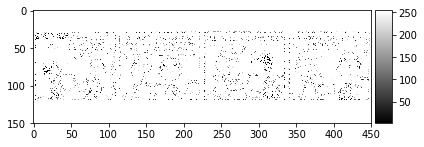

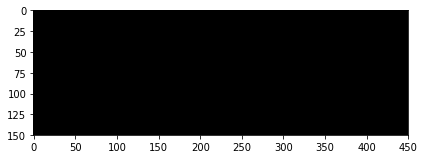

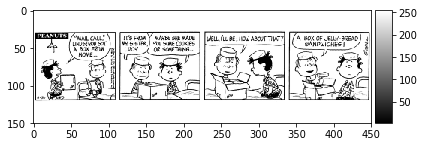

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


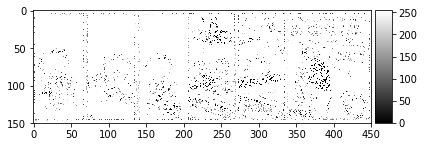

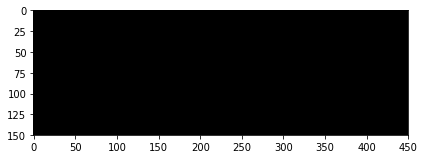

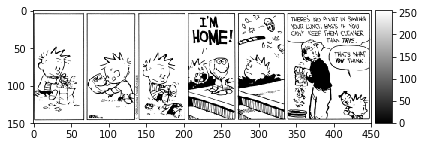

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


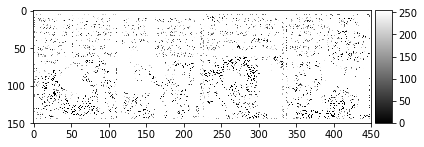

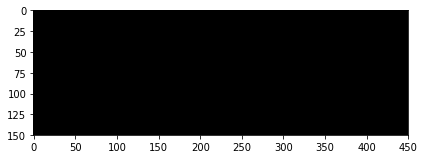

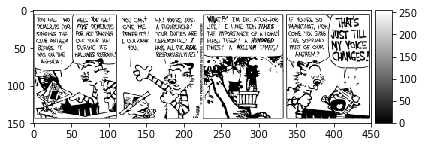

step  0 / 7367 d_loss:  2.159388046152344e-08 g_loss:  [402.2154, 4.012153, 1.0000892]
step  1 / 7367 d_loss:  2.8008125596556965e-08 g_loss:  [245.87321, 2.4487324, 0.99998343]
step  2 / 7367 d_loss:  1.6982681927402155e-09 g_loss:  [238.86343, 2.3786352, 0.99992]
step  3 / 7367 d_loss:  1.7871309765382648e-08 g_loss:  [166.9818, 1.6598183, 0.99997663]
step  4 / 7367 d_loss:  8.704475362719677e-09 g_loss:  [557.0554, 5.5605536, 1.0000455]
step  5 / 7367 d_loss:  2.7330642637934943e-08 g_loss:  [229.26466, 2.2826467, 1.0000045]
step  6 / 7367 d_loss:  1.4549497961979796e-07 g_loss:  [183.05344, 1.8205342, 1.000021]
step  7 / 7367 d_loss:  3.7421358456413145e-08 g_loss:  [178.00443, 1.770044, 1.0000288]
step  8 / 7367 d_loss:  3.194744024881402e-08 g_loss:  [213.409, 2.1240902, 0.9999627]
step  9 / 7367 d_loss:  7.243838950898862e-08 g_loss:  [211.08983, 2.100899, 0.9999279]
step  10 / 7367 d_loss:  2.6701069799628385e-08 g_loss:  [209.60112, 2.0860114, 0.99998975]
step  11 / 7367 d_los

step  93 / 7367 d_loss:  1.325718868017134e-09 g_loss:  [287.59415, 2.8659418, 0.9999716]
step  94 / 7367 d_loss:  7.262858314760479e-09 g_loss:  [212.67007, 2.1167004, 1.0000243]
step  95 / 7367 d_loss:  1.1759964557711555e-08 g_loss:  [464.6527, 4.636527, 1.0000091]
step  96 / 7367 d_loss:  2.6437520617150767e-08 g_loss:  [199.04243, 1.9804243, 1.0000062]
step  97 / 7367 d_loss:  1.0599930710952776e-08 g_loss:  [150.00195, 1.4900194, 1.0000081]
step  98 / 7367 d_loss:  4.662452202097711e-09 g_loss:  [270.92825, 2.6992824, 0.9999851]
step  99 / 7367 d_loss:  1.7046923872499065e-08 g_loss:  [152.6468, 1.5164683, 0.99997306]
step  100 / 7367 d_loss:  1.6658135981728606e-10 g_loss:  [274.6319, 2.736319, 1.0000086]
step  101 / 7367 d_loss:  9.439824921742002e-09 g_loss:  [156.26791, 1.5526788, 1.0000377]
step  102 / 7367 d_loss:  4.5170605034172695e-09 g_loss:  [246.75323, 2.4575324, 1.0000052]
step  103 / 7367 d_loss:  2.5014723625815805e-10 g_loss:  [229.09164, 2.2809167, 0.9999682]
ste

step  185 / 7367 d_loss:  1.0184991738881877e-09 g_loss:  [232.43716, 2.3143718, 0.9999908]
step  186 / 7367 d_loss:  9.999166827867612e-09 g_loss:  [228.26538, 2.272654, 0.99996996]
step  187 / 7367 d_loss:  2.4534110298901624e-09 g_loss:  [462.6506, 4.6165056, 1.0000176]
step  188 / 7367 d_loss:  1.022104179071448e-08 g_loss:  [328.64322, 3.276432, 1.0000379]
step  189 / 7367 d_loss:  1.5554285637264798e-10 g_loss:  [192.44899, 1.9144901, 0.99998343]
step  190 / 7367 d_loss:  1.044735675748143e-08 g_loss:  [159.91591, 1.5891596, 0.99995685]
step  191 / 7367 d_loss:  5.107889222699669e-09 g_loss:  [247.69612, 2.4669611, 1.0000074]
step  192 / 7367 d_loss:  1.154275874881705e-08 g_loss:  [272.5356, 2.7153556, 1.0000501]
step  193 / 7367 d_loss:  6.545318509409981e-09 g_loss:  [204.9669, 2.039669, 1.000001]
step  194 / 7367 d_loss:  5.8946998393594185e-09 g_loss:  [295.0957, 2.9409578, 0.9999478]
step  195 / 7367 d_loss:  3.40866779247051e-09 g_loss:  [150.40117, 1.4940118, 0.99999726]


step  278 / 7367 d_loss:  1.0470405698015384e-07 g_loss:  [200.77573, 1.9977574, 0.9999896]
step  279 / 7367 d_loss:  8.750353686082235e-08 g_loss:  [328.5496, 3.2754946, 1.0001163]
step  280 / 7367 d_loss:  1.574550481109327e-07 g_loss:  [137.97942, 1.369795, 0.99991953]
step  281 / 7367 d_loss:  8.582646415788986e-08 g_loss:  [122.36046, 1.2136058, 0.9998889]
step  282 / 7367 d_loss:  4.2180726467222485e-08 g_loss:  [336.18256, 3.3518243, 1.0001247]
step  283 / 7367 d_loss:  5.453893550111388e-07 g_loss:  [229.45706, 2.284569, 1.0001545]
step  284 / 7367 d_loss:  3.9120303085837804e-07 g_loss:  [136.80696, 1.3580719, 0.99976826]
step  285 / 7367 d_loss:  2.8147510988674185e-07 g_loss:  [186.47751, 1.8547764, 0.99987304]
step  286 / 7367 d_loss:  1.04514860765903e-07 g_loss:  [252.6276, 2.5162733, 1.000268]
step  287 / 7367 d_loss:  2.831173162576306e-07 g_loss:  [185.33221, 1.8433212, 1.0000927]
step  288 / 7367 d_loss:  9.037355752639087e-09 g_loss:  [120.72814, 1.1972837, 0.9997641

step  368 / 7367 d_loss:  1.5734721969806742e-08 g_loss:  [164.83478, 1.6383476, 1.0000112]
step  369 / 7367 d_loss:  4.96598318022734e-11 g_loss:  [141.15442, 1.4015443, 0.9999808]
step  370 / 7367 d_loss:  5.174475847802285e-10 g_loss:  [569.9079, 5.689079, 0.99999654]
step  371 / 7367 d_loss:  1.9631321013235947e-09 g_loss:  [203.88686, 2.0288684, 1.0000112]
step  372 / 7367 d_loss:  4.2517547815812406e-10 g_loss:  [201.60518, 2.0060518, 0.9999999]
step  373 / 7367 d_loss:  1.9775175941205703e-10 g_loss:  [176.66699, 1.7566701, 0.9999924]
step  374 / 7367 d_loss:  1.1156024715130997e-10 g_loss:  [222.20421, 2.212042, 1.0000021]
step  375 / 7367 d_loss:  2.2819873768398224e-10 g_loss:  [324.66763, 3.2366762, 1.0000038]
step  376 / 7367 d_loss:  2.174324720272125e-09 g_loss:  [293.17358, 2.9217358, 1.0000024]
step  377 / 7367 d_loss:  1.0881002765472658e-09 g_loss:  [204.2396, 2.032396, 0.9999913]
step  378 / 7367 d_loss:  5.376606937446127e-10 g_loss:  [430.78406, 4.2978406, 0.999999

step  458 / 7367 d_loss:  1.3112153141037197e-08 g_loss:  [260.107, 2.59107, 1.0000069]
step  459 / 7367 d_loss:  9.691192293104223e-10 g_loss:  [231.15765, 2.3015769, 0.9999645]
step  460 / 7367 d_loss:  4.522726193556537e-09 g_loss:  [285.53247, 2.8453248, 1.0000119]
step  461 / 7367 d_loss:  8.854255106882647e-09 g_loss:  [98.24748, 0.9724745, 1.000032]
step  462 / 7367 d_loss:  6.35407957361167e-08 g_loss:  [366.36917, 3.6536922, 0.99993694]
step  463 / 7367 d_loss:  3.719601693319419e-08 g_loss:  [213.32245, 2.123224, 1.0000412]
step  464 / 7367 d_loss:  2.0556075952526953e-08 g_loss:  [143.64989, 1.4264985, 1.0000379]
step  465 / 7367 d_loss:  1.937458193879138e-08 g_loss:  [229.07236, 2.2807243, 0.9999242]
step  466 / 7367 d_loss:  1.5564875610607487e-08 g_loss:  [239.81158, 2.3881156, 1.0000086]
step  467 / 7367 d_loss:  4.578946111166715e-09 g_loss:  [351.54462, 3.5054455, 1.0000613]
step  468 / 7367 d_loss:  2.695349365922084e-08 g_loss:  [302.25253, 3.0125256, 0.9999685]
ste

step  550 / 7367 d_loss:  1.2933170159823426e-11 g_loss:  [293.13382, 2.921338, 0.9999901]
step  551 / 7367 d_loss:  6.837203025966687e-10 g_loss:  [220.33128, 2.193313, 1.0000048]
step  552 / 7367 d_loss:  4.460070535117211e-09 g_loss:  [175.06425, 1.7406425, 0.999998]
step  553 / 7367 d_loss:  1.2268976945506438e-09 g_loss:  [186.82445, 1.8582444, 0.9999958]
step  554 / 7367 d_loss:  6.617329351144008e-09 g_loss:  [196.13727, 1.9513725, 1.0000141]
step  555 / 7367 d_loss:  1.0479102030558352e-09 g_loss:  [176.56128, 1.7556129, 0.99999356]
step  556 / 7367 d_loss:  3.730571407345451e-09 g_loss:  [185.15839, 1.8415841, 0.99998915]
step  557 / 7367 d_loss:  3.9314579369786884e-11 g_loss:  [250.40237, 2.4940236, 1.000015]
step  558 / 7367 d_loss:  4.405437126209222e-11 g_loss:  [292.3734, 2.9137342, 0.9999944]
step  559 / 7367 d_loss:  1.0318526588726229e-10 g_loss:  [169.05957, 1.6805958, 0.9999937]
step  560 / 7367 d_loss:  2.425336320666105e-10 g_loss:  [257.35657, 2.5635657, 1.000011

step  643 / 7367 d_loss:  1.136635230380989e-08 g_loss:  [192.95407, 1.9195405, 1.0000205]
step  644 / 7367 d_loss:  3.4027212159060127e-09 g_loss:  [212.44579, 2.114458, 0.9999819]
step  645 / 7367 d_loss:  1.9279633445279387e-09 g_loss:  [147.31122, 1.463112, 1.0000086]
step  646 / 7367 d_loss:  5.340258013575294e-09 g_loss:  [232.77444, 2.3177445, 1.0000076]
step  647 / 7367 d_loss:  5.351892262694946e-10 g_loss:  [203.93044, 2.0293045, 0.99998605]
step  648 / 7367 d_loss:  3.294029937706e-09 g_loss:  [108.6006, 1.0760059, 1.00001]
step  649 / 7367 d_loss:  4.19513845884012e-09 g_loss:  [200.76543, 1.9976542, 1.0000007]
step  650 / 7367 d_loss:  1.2556252926287925e-08 g_loss:  [141.72366, 1.4072368, 0.999987]
step  651 / 7367 d_loss:  1.5250281037992863e-09 g_loss:  [256.98416, 2.5598414, 1.0000153]
step  652 / 7367 d_loss:  5.212529075038219e-09 g_loss:  [270.1664, 2.6916642, 0.9999943]
step  653 / 7367 d_loss:  1.2548807548640184e-09 g_loss:  [255.33134, 2.5433135, 0.9999975]
step

step  735 / 7367 d_loss:  5.722838203325864e-09 g_loss:  [254.21634, 2.5321634, 1.0000005]
step  736 / 7367 d_loss:  1.0274137096644154e-08 g_loss:  [141.15443, 1.4015443, 0.9999958]
step  737 / 7367 d_loss:  1.1557586832022793e-10 g_loss:  [313.6328, 3.1263282, 1.0000057]
step  738 / 7367 d_loss:  2.7755657772132736e-09 g_loss:  [162.82903, 1.6182902, 0.99999535]
step  739 / 7367 d_loss:  9.280398671762669e-10 g_loss:  [263.85443, 2.6285443, 1.0000033]
step  740 / 7367 d_loss:  5.230581523463229e-10 g_loss:  [158.77242, 1.5777242, 0.9999981]
step  741 / 7367 d_loss:  5.636895838989631e-09 g_loss:  [107.3648, 1.063648, 0.9999989]
step  742 / 7367 d_loss:  2.0423385205248223e-09 g_loss:  [198.95218, 1.9795218, 1.0000038]
step  743 / 7367 d_loss:  2.4214115157406013e-09 g_loss:  [142.66, 1.4166001, 0.99999654]
step  744 / 7367 d_loss:  3.161203243617905e-11 g_loss:  [284.51273, 2.835127, 1.0000029]
step  745 / 7367 d_loss:  2.5840574124913473e-09 g_loss:  [199.06926, 1.9806926, 0.9999964

step  827 / 7367 d_loss:  5.303611771978467e-09 g_loss:  [281.1438, 2.8014376, 1.0000212]
step  828 / 7367 d_loss:  3.7805181207772875e-09 g_loss:  [294.0576, 2.9305763, 0.99997294]
step  829 / 7367 d_loss:  2.7746562381025797e-08 g_loss:  [192.30064, 1.9130061, 1.0000334]
step  830 / 7367 d_loss:  5.4169508878487704e-09 g_loss:  [210.42679, 2.0942683, 0.9999583]
step  831 / 7367 d_loss:  4.450646784448509e-08 g_loss:  [415.85745, 4.148574, 1.0000546]
step  832 / 7367 d_loss:  2.3377419111625386e-08 g_loss:  [224.3273, 2.2332737, 0.9999268]
step  833 / 7367 d_loss:  3.276302606991521e-08 g_loss:  [509.94638, 5.0894628, 1.0000937]
step  834 / 7367 d_loss:  4.568413913830227e-08 g_loss:  [205.92386, 2.0492399, 0.99987674]
step  835 / 7367 d_loss:  7.490616127370231e-08 g_loss:  [124.67477, 1.2367461, 1.0001597]
step  836 / 7367 d_loss:  1.2643093327824317e-07 g_loss:  [426.08667, 4.250869, 0.9997896]
step  837 / 7367 d_loss:  2.0626697505576885e-07 g_loss:  [245.17226, 2.4417198, 1.00027

step  920 / 7367 d_loss:  1.1432659263732603e-09 g_loss:  [319.98254, 3.1898253, 1.0000036]
step  921 / 7367 d_loss:  2.496693518594384e-09 g_loss:  [247.9438, 2.469438, 0.99999857]
step  922 / 7367 d_loss:  1.139370486846758e-09 g_loss:  [339.44418, 3.3844419, 1.0]
step  923 / 7367 d_loss:  3.208761922834924e-09 g_loss:  [294.20038, 2.9320037, 1.0]
step  924 / 7367 d_loss:  7.292212389486963e-10 g_loss:  [255.4688, 2.544688, 1.0000017]
step  925 / 7367 d_loss:  4.52594045574628e-10 g_loss:  [267.76468, 2.6676466, 0.9999988]
step  926 / 7367 d_loss:  9.780283527494049e-11 g_loss:  [311.95566, 3.1095564, 1.0000005]
step  927 / 7367 d_loss:  9.942222600756168e-10 g_loss:  [190.46677, 1.8946676, 0.9999989]
step  928 / 7367 d_loss:  1.6791473100852272e-08 g_loss:  [264.39432, 2.633943, 0.99999917]
step  929 / 7367 d_loss:  5.0471275159225115e-08 g_loss:  [232.6419, 2.3164191, 1.000005]
step  930 / 7367 d_loss:  5.059295205001035e-09 g_loss:  [221.8251, 2.208251, 0.99999297]
step  931 / 736

step  1011 / 7367 d_loss:  2.6660683261070517e-07 g_loss:  [215.18617, 2.1418462, 1.0015532]
step  1012 / 7367 d_loss:  2.275813130836468e-06 g_loss:  [199.3395, 1.9834037, 0.9991252]
step  1013 / 7367 d_loss:  3.7469103517651092e-06 g_loss:  [354.9328, 3.539328, 1.0000093]
step  1014 / 7367 d_loss:  3.0421281280723633e-06 g_loss:  [203.83829, 2.0283763, 1.0006512]
step  1015 / 7367 d_loss:  1.2815601166948909e-06 g_loss:  [229.7539, 2.2875497, 0.9989354]
step  1016 / 7367 d_loss:  9.151068525170558e-08 g_loss:  [387.04434, 3.8604324, 1.0010839]
step  1017 / 7367 d_loss:  2.2060244475596846e-07 g_loss:  [170.26001, 1.6926079, 0.9992177]
step  1018 / 7367 d_loss:  8.801271178526804e-07 g_loss:  [292.8596, 2.918593, 1.0002961]
step  1019 / 7367 d_loss:  1.0845027418326936e-06 g_loss:  [168.97258, 1.6797241, 1.000164]
step  1020 / 7367 d_loss:  6.813491495449853e-07 g_loss:  [293.15222, 2.9215274, 0.9994903]
step  1021 / 7367 d_loss:  1.7086229320284474e-07 g_loss:  [294.23093, 2.9323027,

step  1101 / 7367 d_loss:  7.848731442550161e-09 g_loss:  [187.17938, 1.8617939, 0.9999939]
step  1102 / 7367 d_loss:  6.198121127454215e-08 g_loss:  [279.3115, 2.783115, 1.0000057]
step  1103 / 7367 d_loss:  7.811344460151304e-09 g_loss:  [273.26913, 2.7226913, 0.9999951]
step  1104 / 7367 d_loss:  4.392783381490517e-08 g_loss:  [303.67767, 3.0267768, 1.000006]
step  1105 / 7367 d_loss:  5.487998055997423e-09 g_loss:  [183.35765, 1.8235766, 0.99999344]
step  1106 / 7367 d_loss:  2.6836080024850162e-08 g_loss:  [141.38121, 1.403812, 1.000006]
step  1107 / 7367 d_loss:  4.622479288229897e-09 g_loss:  [142.14671, 1.4114672, 0.9999939]
step  1108 / 7367 d_loss:  1.8170158710972828e-08 g_loss:  [207.20227, 2.0620227, 1.0000055]
step  1109 / 7367 d_loss:  7.283309511052494e-09 g_loss:  [220.0467, 2.1904671, 0.99999535]
step  1110 / 7367 d_loss:  2.3019717687589036e-08 g_loss:  [253.18256, 2.5218256, 1.0000043]
step  1111 / 7367 d_loss:  4.257131980267559e-09 g_loss:  [190.82356, 1.8982357, 

step  1192 / 7367 d_loss:  5.981282811262645e-06 g_loss:  [516.7182, 5.157246, 0.9935622]
step  1193 / 7367 d_loss:  6.9681022978329565e-06 g_loss:  [314.65274, 3.1365485, 0.9978878]
step  1194 / 7367 d_loss:  1.3762385151494527e-06 g_loss:  [170.54105, 1.6953679, 1.0042529]
step  1195 / 7367 d_loss:  6.070276867831126e-06 g_loss:  [146.06631, 1.4506222, 1.0040945]
step  1196 / 7367 d_loss:  6.47009699150658e-07 g_loss:  [243.75528, 2.4275653, 0.9987556]
step  1197 / 7367 d_loss:  2.4176515580620617e-06 g_loss:  [230.20978, 2.2921374, 0.99602807]
step  1198 / 7367 d_loss:  3.567966359696584e-06 g_loss:  [360.46518, 3.5946622, 0.9989558]
step  1199 / 7367 d_loss:  2.731281369960925e-07 g_loss:  [369.8386, 3.6883588, 1.0027179]
step  1200 / 7367 d_loss:  3.249711426178692e-06 g_loss:  [361.78085, 3.6077871, 1.0021346]
step  1201 / 7367 d_loss:  7.323051704588579e-06 g_loss:  [196.86574, 1.9586657, 0.9991583]
step  1202 / 7367 d_loss:  2.1438295334519353e-06 g_loss:  [168.18478, 1.6718681

step  1282 / 7367 d_loss:  2.1392644100615144e-08 g_loss:  [137.53543, 1.3653545, 0.9999713]
step  1283 / 7367 d_loss:  3.645910595651003e-08 g_loss:  [218.91391, 2.1791394, 0.99996567]
step  1284 / 7367 d_loss:  6.646005967780866e-10 g_loss:  [272.1512, 2.711512, 1.0000072]
step  1285 / 7367 d_loss:  2.0069656159193983e-08 g_loss:  [376.46414, 3.754641, 1.0000451]
step  1286 / 7367 d_loss:  9.93646764868572e-09 g_loss:  [173.5843, 1.7258428, 1.0000215]
step  1287 / 7367 d_loss:  4.596479308283108e-10 g_loss:  [315.24268, 3.1424272, 0.99996996]
step  1288 / 7367 d_loss:  2.5912018486451416e-07 g_loss:  [218.4085, 2.1740856, 0.9999212]
step  1289 / 7367 d_loss:  1.337960640057645e-07 g_loss:  [247.23119, 2.4623115, 1.0000308]
step  1290 / 7367 d_loss:  1.3778941365671926e-07 g_loss:  [225.26802, 2.242679, 1.000112]
step  1291 / 7367 d_loss:  4.868780045796939e-09 g_loss:  [280.1696, 2.7916958, 1.0000119]
step  1292 / 7367 d_loss:  6.983697176110581e-08 g_loss:  [204.2395, 2.032396, 0.99

step  1373 / 7367 d_loss:  5.149412629634753e-08 g_loss:  [222.70198, 2.2170193, 1.0000505]
step  1374 / 7367 d_loss:  2.0930379207584338e-08 g_loss:  [183.48419, 1.8248428, 0.9999012]
step  1375 / 7367 d_loss:  1.318992204346614e-08 g_loss:  [177.06206, 1.7606213, 0.99992406]
step  1376 / 7367 d_loss:  7.329516904519551e-08 g_loss:  [266.97214, 2.6597211, 1.000037]
step  1377 / 7367 d_loss:  3.3677372002216543e-09 g_loss:  [215.2881, 2.1428804, 1.0000665]
step  1378 / 7367 d_loss:  1.4705263673420177e-09 g_loss:  [233.3153, 2.3231533, 0.9999906]
step  1379 / 7367 d_loss:  7.311054872616296e-08 g_loss:  [180.18365, 1.7918369, 0.9999683]
step  1380 / 7367 d_loss:  1.39014142419569e-08 g_loss:  [399.1413, 3.981413, 1.00001]
step  1381 / 7367 d_loss:  3.620492705636025e-08 g_loss:  [161.1679, 1.6016787, 1.0000105]
step  1382 / 7367 d_loss:  2.0243099640993023e-08 g_loss:  [395.98642, 3.9498644, 0.9999815]
step  1383 / 7367 d_loss:  4.5216147492865844e-10 g_loss:  [257.6501, 2.566501, 0.99

step  1463 / 7367 d_loss:  5.618009168983917e-09 g_loss:  [443.4039, 4.424039, 1.0000134]
step  1464 / 7367 d_loss:  1.0418308438175927e-09 g_loss:  [180.06749, 1.7906749, 0.9999963]
step  1465 / 7367 d_loss:  1.2602201227007725e-10 g_loss:  [371.43878, 3.704388, 0.9999877]
step  1466 / 7367 d_loss:  1.4606055032118093e-08 g_loss:  [208.54701, 2.0754702, 0.99998987]
step  1467 / 7367 d_loss:  4.845865375635583e-10 g_loss:  [197.18571, 1.961857, 1.000011]
step  1468 / 7367 d_loss:  1.4199970976846998e-08 g_loss:  [294.52652, 2.9352648, 1.0000207]
step  1469 / 7367 d_loss:  1.436212926364533e-09 g_loss:  [230.97105, 2.2997105, 0.99999666]
step  1470 / 7367 d_loss:  3.898412703762233e-09 g_loss:  [206.88043, 2.0588045, 0.9999776]
step  1471 / 7367 d_loss:  8.316896504823035e-09 g_loss:  [369.6796, 3.686796, 0.9999925]
step  1472 / 7367 d_loss:  2.3273057092598748e-11 g_loss:  [369.77185, 3.6877182, 1.0000174]
step  1473 / 7367 d_loss:  2.7651647638293753e-10 g_loss:  [252.4807, 2.514807, 

step  1553 / 7367 d_loss:  1.1840163551823935e-06 g_loss:  [223.36385, 2.22364, 0.99985135]
step  1554 / 7367 d_loss:  4.831303499486239e-07 g_loss:  [232.77449, 2.3177445, 1.0000405]
step  1555 / 7367 d_loss:  1.3518397068423837e-08 g_loss:  [303.39294, 3.0239282, 1.000113]
step  1556 / 7367 d_loss:  1.832449072480813e-07 g_loss:  [228.33307, 2.2733316, 0.99991584]
step  1557 / 7367 d_loss:  5.140799430591869e-07 g_loss:  [211.12245, 2.1012254, 0.9999039]
step  1558 / 7367 d_loss:  3.5918657204092597e-07 g_loss:  [227.06416, 2.2606409, 1.0000722]
step  1559 / 7367 d_loss:  8.797591988241038e-08 g_loss:  [345.7319, 3.4473188, 1.0000434]
step  1560 / 7367 d_loss:  6.288037646129396e-09 g_loss:  [468.25745, 4.672575, 0.99993145]
step  1561 / 7367 d_loss:  1.1888155881933926e-07 g_loss:  [161.90071, 1.6090071, 1.0000005]
step  1562 / 7367 d_loss:  1.7946628361187322e-07 g_loss:  [290.53598, 2.8953593, 1.0000734]
step  1563 / 7367 d_loss:  9.838349512847344e-08 g_loss:  [292.67377, 2.91673

step  1642 / 7367 d_loss:  2.9474498397519255e-09 g_loss:  [367.34232, 3.663424, 0.9999018]
step  1643 / 7367 d_loss:  1.9073282953030457e-09 g_loss:  [437.336, 4.3633614, 0.99987257]
step  1644 / 7367 d_loss:  8.349484659220252e-09 g_loss:  [227.28223, 2.2628236, 0.99986506]
step  1645 / 7367 d_loss:  1.5289041144228577e-08 g_loss:  [272.8492, 2.7184935, 0.9998779]
step  1646 / 7367 d_loss:  2.3466922627335407e-08 g_loss:  [242.52026, 2.4152036, 0.99990284]
step  1647 / 7367 d_loss:  2.3452683350910775e-08 g_loss:  [192.98866, 1.9198872, 0.9999348]
step  1648 / 7367 d_loss:  1.2666159676655298e-08 g_loss:  [257.95404, 2.5695407, 0.9999685]
step  1649 / 7367 d_loss:  1.007315564294231e-09 g_loss:  [187.17485, 1.8617486, 1.0000005]
step  1650 / 7367 d_loss:  9.178703630485785e-11 g_loss:  [307.03415, 3.0603411, 1.0000255]
step  1651 / 7367 d_loss:  3.755263655591534e-09 g_loss:  [302.6648, 3.0166476, 1.0000434]
step  1652 / 7367 d_loss:  2.3611697042014157e-09 g_loss:  [225.99106, 2.249

step  1734 / 7367 d_loss:  1.356977641364665e-09 g_loss:  [154.97028, 1.5397028, 0.9999995]
step  1735 / 7367 d_loss:  4.213158988353172e-11 g_loss:  [165.24529, 1.6424528, 1.0000005]
step  1736 / 7367 d_loss:  3.3439093716225443e-09 g_loss:  [301.47824, 3.0047824, 1.0000014]
step  1737 / 7367 d_loss:  8.315042543394213e-10 g_loss:  [204.75734, 2.0375733, 1.0000019]
step  1738 / 7367 d_loss:  1.9850510124541643e-09 g_loss:  [278.00385, 2.7700386, 1.0000017]
step  1739 / 7367 d_loss:  1.9849104582192467e-09 g_loss:  [204.15936, 2.0315936, 1.0000012]
step  1740 / 7367 d_loss:  9.992366933886387e-10 g_loss:  [248.55139, 2.475514, 1.0]
step  1741 / 7367 d_loss:  1.363243268270864e-10 g_loss:  [472.31094, 4.7131095, 0.9999989]
step  1742 / 7367 d_loss:  6.040826172615255e-11 g_loss:  [203.93045, 2.0293045, 0.99999833]
step  1743 / 7367 d_loss:  4.62369309506272e-10 g_loss:  [238.53128, 2.3753128, 0.99999833]
step  1744 / 7367 d_loss:  2.7581386063957325e-09 g_loss:  [270.52866, 2.6952865, 0

step  1824 / 7367 d_loss:  5.235881173071277e-13 g_loss:  [306.1157, 3.051157, 0.99999833]
step  1825 / 7367 d_loss:  2.902889872924419e-10 g_loss:  [210.96341, 2.0996342, 0.9999982]
step  1826 / 7367 d_loss:  1.0319886056819882e-09 g_loss:  [250.7398, 2.4973981, 0.999998]
step  1827 / 7367 d_loss:  5.735536490192317e-10 g_loss:  [351.7148, 3.5071483, 0.99999857]
step  1828 / 7367 d_loss:  3.017125438375956e-10 g_loss:  [252.56242, 2.5156243, 0.99999917]
step  1829 / 7367 d_loss:  2.919485986296877e-09 g_loss:  [186.65202, 1.8565203, 1.0000007]
step  1830 / 7367 d_loss:  1.8995014450240433e-09 g_loss:  [247.75684, 2.4675684, 1.0000019]
step  1831 / 7367 d_loss:  6.627387705293586e-08 g_loss:  [243.28859, 2.422886, 1.0000062]
step  1832 / 7367 d_loss:  2.9027598102970842e-08 g_loss:  [234.1354, 2.3313541, 1.0000069]
step  1833 / 7367 d_loss:  3.7281679965417425e-08 g_loss:  [147.44247, 1.4644247, 1.0000038]
step  1834 / 7367 d_loss:  3.041695961769619e-08 g_loss:  [238.93318, 2.3793318,

step  1916 / 7367 d_loss:  5.378603812333793e-11 g_loss:  [166.91103, 1.6591102, 1.0000002]
step  1917 / 7367 d_loss:  5.7555224475258626e-11 g_loss:  [231.75139, 2.307514, 0.9999999]
step  1918 / 7367 d_loss:  1.2193700216212022e-10 g_loss:  [304.7539, 3.037539, 1.0]
step  1919 / 7367 d_loss:  2.1108254033563867e-11 g_loss:  [196.58635, 1.9558635, 0.9999999]
step  1920 / 7367 d_loss:  3.5199794468088186e-13 g_loss:  [217.72351, 2.1672351, 0.99999976]
step  1921 / 7367 d_loss:  6.399396637601917e-12 g_loss:  [137.327, 1.3632699, 0.99999976]
step  1922 / 7367 d_loss:  1.7099949928267577e-12 g_loss:  [149.34613, 1.4834614, 0.9999999]
step  1923 / 7367 d_loss:  1.8130635881519197e-13 g_loss:  [282.5457, 2.8154569, 0.99999976]
step  1924 / 7367 d_loss:  2.306323534928545e-12 g_loss:  [420.07425, 4.1907425, 0.99999976]
step  1925 / 7367 d_loss:  4.7780564227384303e-11 g_loss:  [208.62689, 2.076269, 0.9999999]
step  1926 / 7367 d_loss:  9.743941764561725e-15 g_loss:  [356.3643, 3.553643, 0.9

step  2005 / 7367 d_loss:  6.763863913405999e-10 g_loss:  [108.60595, 1.0760595, 1.0000007]
step  2006 / 7367 d_loss:  5.6916499291403966e-11 g_loss:  [862.4015, 8.614015, 1.0]
step  2007 / 7367 d_loss:  5.650565015891118e-10 g_loss:  [347.46786, 3.4646788, 0.99999976]
step  2008 / 7367 d_loss:  2.899349094143133e-10 g_loss:  [208.30408, 2.0730407, 0.99999976]
step  2009 / 7367 d_loss:  1.0575955389224845e-10 g_loss:  [205.96764, 2.0496764, 0.9999999]
step  2010 / 7367 d_loss:  1.503537745695116e-11 g_loss:  [252.16315, 2.5116315, 1.0]
step  2011 / 7367 d_loss:  7.119703937519262e-09 g_loss:  [319.59167, 3.1859167, 1.0000014]
step  2012 / 7367 d_loss:  3.151791050370889e-10 g_loss:  [219.18268, 2.1818268, 1.0000019]
step  2013 / 7367 d_loss:  7.969692461529121e-09 g_loss:  [351.92422, 3.5092423, 1.0000033]
step  2014 / 7367 d_loss:  1.3768916673484455e-08 g_loss:  [258.74454, 2.5774453, 1.0000019]
step  2015 / 7367 d_loss:  1.3355664130187961e-08 g_loss:  [278.78763, 2.7778764, 0.99999

step  2097 / 7367 d_loss:  2.33667751814437e-10 g_loss:  [175.8518, 1.7485181, 0.9999969]
step  2098 / 7367 d_loss:  2.181915981225302e-09 g_loss:  [281.3329, 2.8033288, 0.9999969]
step  2099 / 7367 d_loss:  2.7674000868671556e-09 g_loss:  [278.25366, 2.7725365, 0.9999987]
step  2100 / 7367 d_loss:  9.005870493794532e-10 g_loss:  [137.044, 1.36044, 1.0000002]
step  2101 / 7367 d_loss:  7.70179336972987e-11 g_loss:  [261.8998, 2.608998, 1.0000017]
step  2102 / 7367 d_loss:  2.67927596775408e-10 g_loss:  [376.16016, 3.7516017, 1.0000024]
step  2103 / 7367 d_loss:  4.331749536845564e-08 g_loss:  [204.51212, 2.0351212, 1.0000062]
step  2104 / 7367 d_loss:  1.6443676642552418e-08 g_loss:  [203.88998, 2.0289, 1.0000064]
step  2105 / 7367 d_loss:  2.3126611736756786e-08 g_loss:  [146.25174, 1.4525174, 1.0000024]
step  2106 / 7367 d_loss:  1.1952839606976795e-08 g_loss:  [289.8017, 2.888017, 0.9999975]
step  2107 / 7367 d_loss:  8.988567112844237e-10 g_loss:  [225.26791, 2.242679, 0.99999356]


step  2187 / 7367 d_loss:  7.487874320588617e-09 g_loss:  [231.73022, 2.3073022, 1.0000019]
step  2188 / 7367 d_loss:  0.005888173822313547 g_loss:  [1590.1735, 15.8913555, 1.0379568]
step  2189 / 7367 d_loss:  0.00035623181611299515 g_loss:  [250.68947, 2.4962857, 1.0608958]
step  2190 / 7367 d_loss:  0.0005753893055953085 g_loss:  [196.65262, 1.9558635, 1.0662693]
step  2191 / 7367 d_loss:  0.0005196562851779163 g_loss:  [333.66437, 3.32608, 1.0563612]
step  2192 / 7367 d_loss:  0.00029033617465756834 g_loss:  [260.14355, 2.59107, 1.0365716]
step  2193 / 7367 d_loss:  8.520641131326556e-05 g_loss:  [155.34857, 1.5433534, 1.0132302]
step  2194 / 7367 d_loss:  1.0540857147134375e-05 g_loss:  [317.11102, 3.1611907, 0.9919446]
step  2195 / 7367 d_loss:  4.4765682105207816e-05 g_loss:  [399.69785, 3.9872124, 0.9765818]
step  2196 / 7367 d_loss:  0.0001085494805010967 g_loss:  [186.48245, 1.8551345, 0.9690106]
step  2197 / 7367 d_loss:  0.00013661306002177298 g_loss:  [374.17297, 3.732038,

step  2277 / 7367 d_loss:  3.9317174516106945e-11 g_loss:  [268.61884, 2.6761885, 0.999998]
step  2278 / 7367 d_loss:  1.310420838507298e-08 g_loss:  [187.04756, 1.8604757, 0.99999785]
step  2279 / 7367 d_loss:  5.917132062105424e-11 g_loss:  [223.70935, 2.2270935, 0.99999857]
step  2280 / 7367 d_loss:  1.1426779522594188e-09 g_loss:  [186.0428, 1.850428, 0.99999976]
step  2281 / 7367 d_loss:  1.529846582748462e-09 g_loss:  [321.57175, 3.2057176, 1.0000014]
step  2282 / 7367 d_loss:  5.777649469962398e-10 g_loss:  [258.74454, 2.5774453, 1.0000031]
step  2283 / 7367 d_loss:  1.6347201370336961e-12 g_loss:  [339.32962, 3.3832963, 1.0000033]
step  2284 / 7367 d_loss:  5.062790187082555e-10 g_loss:  [307.8963, 3.068963, 1.0000033]
step  2285 / 7367 d_loss:  1.1520430165390394e-09 g_loss:  [291.6018, 2.906018, 1.0000017]
step  2286 / 7367 d_loss:  9.903840247904583e-11 g_loss:  [226.19586, 2.2519586, 1.0]
step  2287 / 7367 d_loss:  2.829805834103638e-11 g_loss:  [183.07709, 1.8207709, 0.999

step  2368 / 7367 d_loss:  4.4525304474518634e-06 g_loss:  [226.6423, 2.256353, 1.0070177]
step  2369 / 7367 d_loss:  8.307379175676033e-06 g_loss:  [109.97056, 1.0896255, 1.0080104]
step  2370 / 7367 d_loss:  8.324097507284023e-06 g_loss:  [266.00882, 2.6500165, 1.0071816]
step  2371 / 7367 d_loss:  5.207526101003168e-06 g_loss:  [286.04425, 2.850392, 1.0050489]
step  2372 / 7367 d_loss:  1.835678517636552e-06 g_loss:  [290.31497, 2.8931267, 1.0022982]
step  2373 / 7367 d_loss:  2.7682426662067883e-07 g_loss:  [168.42749, 1.6742789, 0.99961036]
step  2374 / 7367 d_loss:  4.953049028699752e-07 g_loss:  [350.937, 3.499395, 0.9975182]
step  2375 / 7367 d_loss:  1.4072163594391895e-06 g_loss:  [198.82115, 1.9782481, 0.99633294]
step  2376 / 7367 d_loss:  2.0779284568561707e-06 g_loss:  [221.73018, 2.2073405, 0.99612385]
step  2377 / 7367 d_loss:  1.8770887209029752e-06 g_loss:  [292.4763, 2.9147954, 0.99674064]
step  2378 / 7367 d_loss:  1.3135967265043291e-06 g_loss:  [167.83342, 1.66835

step  2460 / 7367 d_loss:  6.297255339404728e-08 g_loss:  [159.55394, 1.5855393, 0.9999993]
step  2461 / 7367 d_loss:  1.839746843756984e-08 g_loss:  [287.88544, 2.8688543, 0.9999932]
step  2462 / 7367 d_loss:  3.0718709354005114e-08 g_loss:  [365.3316, 3.643316, 0.99999225]
step  2463 / 7367 d_loss:  1.1323220139303203e-09 g_loss:  [202.54182, 2.0154183, 0.99999356]
step  2464 / 7367 d_loss:  4.7702375383096296e-08 g_loss:  [257.43677, 2.5643675, 0.9999999]
step  2465 / 7367 d_loss:  5.717288864559578e-10 g_loss:  [176.4564, 1.754564, 1.0000045]
step  2466 / 7367 d_loss:  9.214342178154311e-09 g_loss:  [283.29855, 2.8229856, 1.0000062]
step  2467 / 7367 d_loss:  2.744775740026739e-09 g_loss:  [228.26143, 2.2726142, 1.000005]
step  2468 / 7367 d_loss:  1.2820353667564177e-09 g_loss:  [170.68681, 1.6968682, 1.0000029]
step  2469 / 7367 d_loss:  2.2125283827278963e-09 g_loss:  [380.2518, 3.7925181, 0.99999976]
step  2470 / 7367 d_loss:  1.6020339221878288e-10 g_loss:  [238.33572, 2.37335

step  2552 / 7367 d_loss:  6.066726854214721e-08 g_loss:  [276.08655, 2.7508655, 1.0000045]
step  2553 / 7367 d_loss:  1.711826236316938e-08 g_loss:  [262.18408, 2.6118407, 1.000005]
step  2554 / 7367 d_loss:  2.865118098327457e-08 g_loss:  [434.01712, 4.330171, 1.0000014]
step  2555 / 7367 d_loss:  1.0575799791467944e-08 g_loss:  [311.59738, 3.1059737, 1.0000005]
step  2556 / 7367 d_loss:  1.147866512951623e-08 g_loss:  [195.57329, 1.9457328, 0.9999974]
step  2557 / 7367 d_loss:  2.5900519506905084e-09 g_loss:  [356.59872, 3.5559874, 0.999995]
step  2558 / 7367 d_loss:  7.917134725587971e-10 g_loss:  [348.1606, 3.471606, 0.99999464]
step  2559 / 7367 d_loss:  5.58029711328345e-09 g_loss:  [246.71962, 2.4571962, 0.99999654]
step  2560 / 7367 d_loss:  4.547820342537534e-09 g_loss:  [223.78003, 2.2278004, 1.0]
step  2561 / 7367 d_loss:  4.148023702299497e-09 g_loss:  [284.05594, 2.8305595, 1.0000038]
step  2562 / 7367 d_loss:  2.251367758887568e-09 g_loss:  [269.22897, 2.6822898, 1.00000

step  2644 / 7367 d_loss:  3.011314753109673e-09 g_loss:  [198.93843, 1.9793843, 1.0000012]
step  2645 / 7367 d_loss:  3.081311428232425e-09 g_loss:  [297.51477, 2.9651477, 1.0000014]
step  2646 / 7367 d_loss:  2.674449994799488e-09 g_loss:  [312.39722, 3.1139722, 1.0000002]
step  2647 / 7367 d_loss:  8.196020750972366e-09 g_loss:  [210.77486, 2.0977485, 1.0000012]
step  2648 / 7367 d_loss:  1.0436793096424424e-10 g_loss:  [280.40887, 2.7940888, 1.0000017]
step  2649 / 7367 d_loss:  5.103628630820367e-09 g_loss:  [150.48245, 1.4948245, 1.0000002]
step  2650 / 7367 d_loss:  1.6440203642886786e-09 g_loss:  [180.18369, 1.7918369, 0.99999833]
step  2651 / 7367 d_loss:  4.0936578571404425e-09 g_loss:  [209.01222, 2.0801222, 0.99999833]
step  2652 / 7367 d_loss:  2.330007575768178e-10 g_loss:  [282.90048, 2.8190048, 0.9999988]
step  2653 / 7367 d_loss:  4.162077349434412e-10 g_loss:  [355.4254, 3.544254, 0.99999976]
step  2654 / 7367 d_loss:  9.234313314010478e-11 g_loss:  [221.8853, 2.20885

step  2736 / 7367 d_loss:  5.8271614200577915e-09 g_loss:  [211.54828, 2.1054828, 1.0000036]
step  2737 / 7367 d_loss:  1.3748989502460063e-08 g_loss:  [349.94302, 3.4894302, 1.0000007]
step  2738 / 7367 d_loss:  4.245945373071436e-09 g_loss:  [239.01099, 2.3801098, 0.9999976]
step  2739 / 7367 d_loss:  7.752717356979133e-10 g_loss:  [401.3278, 4.003278, 0.99999595]
step  2740 / 7367 d_loss:  5.718828965939338e-09 g_loss:  [202.39255, 2.0139256, 0.9999969]
step  2741 / 7367 d_loss:  1.3926763742233561e-08 g_loss:  [277.66238, 2.766624, 1.0000014]
step  2742 / 7367 d_loss:  9.475833451233484e-10 g_loss:  [194.99709, 1.9399709, 1.0000038]
step  2743 / 7367 d_loss:  7.709064497873896e-09 g_loss:  [233.23817, 2.3223817, 1.0000031]
step  2744 / 7367 d_loss:  4.235681250186474e-11 g_loss:  [176.8289, 1.758289, 1.0000017]
step  2745 / 7367 d_loss:  2.3820523331608e-09 g_loss:  [262.6922, 2.6169221, 0.9999988]
step  2746 / 7367 d_loss:  4.941132572544582e-12 g_loss:  [153.91919, 1.5291919, 0.9

step  2827 / 7367 d_loss:  4.5599861664413766e-08 g_loss:  [192.1058, 1.9110578, 1.0000083]
step  2828 / 7367 d_loss:  1.3782802454898047e-07 g_loss:  [224.34877, 2.2334874, 1.0000265]
step  2829 / 7367 d_loss:  3.218593462861463e-07 g_loss:  [373.12564, 3.721256, 1.00002]
step  2830 / 7367 d_loss:  8.840643062058007e-08 g_loss:  [213.35475, 2.1235476, 1.0000021]
step  2831 / 7367 d_loss:  1.6635889110716562e-08 g_loss:  [230.70212, 2.2970214, 0.9999894]
step  2832 / 7367 d_loss:  1.5457777635674574e-07 g_loss:  [647.64886, 6.466489, 0.9999912]
step  2833 / 7367 d_loss:  8.949697161142467e-08 g_loss:  [299.2331, 2.982331, 1.0000017]
step  2834 / 7367 d_loss:  1.9497043979299633e-09 g_loss:  [302.24017, 3.0124018, 1.000011]
step  2835 / 7367 d_loss:  6.949312592041679e-08 g_loss:  [204.87401, 2.03874, 1.0000088]
step  2836 / 7367 d_loss:  3.484760924266084e-08 g_loss:  [280.14453, 2.7914453, 0.99999976]
step  2837 / 7367 d_loss:  2.6802178254570208e-08 g_loss:  [192.99414, 1.9199415, 0.

step  2918 / 7367 d_loss:  1.9220632030414464e-11 g_loss:  [182.02829, 1.8102828, 0.99999976]
step  2919 / 7367 d_loss:  1.0925971932751466e-10 g_loss:  [286.27515, 2.8527515, 0.9999999]
step  2920 / 7367 d_loss:  3.1802320776819215e-09 g_loss:  [322.67145, 3.2167146, 1.0000014]
step  2921 / 7367 d_loss:  1.3854257741030551e-09 g_loss:  [198.99898, 1.9799898, 1.0000017]
step  2922 / 7367 d_loss:  3.2567564201002597e-09 g_loss:  [272.52957, 2.7152958, 1.0000005]
step  2923 / 7367 d_loss:  3.7922920359534373e-10 g_loss:  [307.38632, 3.0638633, 0.99999845]
step  2924 / 7367 d_loss:  1.1715585168659004e-09 g_loss:  [249.25699, 2.48257, 0.9999982]
step  2925 / 7367 d_loss:  1.4327514730183566e-09 g_loss:  [162.82903, 1.6182902, 0.99999917]
step  2926 / 7367 d_loss:  2.2261156806813176e-10 g_loss:  [155.158, 1.5415801, 1.0000005]
step  2927 / 7367 d_loss:  4.525272156996607e-09 g_loss:  [105.612564, 1.0461257, 1.0000033]
step  2928 / 7367 d_loss:  5.7310143297684135e-09 g_loss:  [662.9872, 6

step  3009 / 7367 d_loss:  2.4240417673127013e-08 g_loss:  [171.7371, 1.7073711, 1.000004]
step  3010 / 7367 d_loss:  2.4768686657239414e-08 g_loss:  [285.73172, 2.8473172, 1.0000017]
step  3011 / 7367 d_loss:  1.4744223619800323e-08 g_loss:  [280.45258, 2.7945256, 0.99999595]
step  3012 / 7367 d_loss:  2.644846147648039e-11 g_loss:  [147.51236, 1.4651235, 0.9999926]
step  3013 / 7367 d_loss:  1.0582006382264808e-08 g_loss:  [229.85463, 2.2885463, 0.9999951]
step  3014 / 7367 d_loss:  9.776713660869518e-09 g_loss:  [478.06857, 4.7706857, 1.0000019]
step  3015 / 7367 d_loss:  5.193079299914416e-11 g_loss:  [143.03897, 1.4203898, 1.0000064]
step  3016 / 7367 d_loss:  4.473523329551199e-09 g_loss:  [338.00412, 3.3700411, 1.0000057]
step  3017 / 7367 d_loss:  1.6003377512063821e-09 g_loss:  [291.70572, 2.9070573, 1.0000043]
step  3018 / 7367 d_loss:  1.2503092783333614e-08 g_loss:  [109.650444, 1.0865045, 0.99999845]
step  3019 / 7367 d_loss:  1.6227319488137937e-09 g_loss:  [106.31227, 1.

step  3100 / 7367 d_loss:  2.3620143618785505e-09 g_loss:  [281.1024, 2.801024, 1.0000017]
step  3101 / 7367 d_loss:  3.796928549348877e-09 g_loss:  [178.44775, 1.7744776, 0.99999917]
step  3102 / 7367 d_loss:  8.855251601436187e-12 g_loss:  [168.42789, 1.6742789, 0.9999976]
step  3103 / 7367 d_loss:  2.1188091281487687e-09 g_loss:  [111.53516, 1.1053516, 0.99999785]
step  3104 / 7367 d_loss:  1.9141197515892827e-09 g_loss:  [155.65771, 1.5465771, 0.99999976]
step  3105 / 7367 d_loss:  4.82502926502093e-12 g_loss:  [155.34998, 1.5434998, 1.0000012]
step  3106 / 7367 d_loss:  1.3884181582213273e-09 g_loss:  [334.25912, 3.3325913, 1.0000012]
step  3107 / 7367 d_loss:  8.605395285243844e-10 g_loss:  [310.1891, 3.0918908, 1.0000002]
step  3108 / 7367 d_loss:  1.9232200901275753e-11 g_loss:  [242.36557, 2.4136558, 0.9999994]
step  3109 / 7367 d_loss:  4.423277744081133e-09 g_loss:  [196.21053, 1.9521053, 1.0000005]
step  3110 / 7367 d_loss:  2.420361688848516e-10 g_loss:  [181.02525, 1.8002

step  3192 / 7367 d_loss:  3.4049529862301142e-09 g_loss:  [112.36966, 1.1136967, 0.99999154]
step  3193 / 7367 d_loss:  8.4871851768753e-09 g_loss:  [190.46675, 1.8946676, 0.99999046]
step  3194 / 7367 d_loss:  1.3459247050207068e-08 g_loss:  [232.09929, 2.310993, 0.9999974]
step  3195 / 7367 d_loss:  4.5161116513092736e-10 g_loss:  [137.98404, 1.3698404, 1.0000052]
step  3196 / 7367 d_loss:  9.03873687008172e-09 g_loss:  [204.43959, 2.034396, 1.0000064]
step  3197 / 7367 d_loss:  6.381969175350832e-09 g_loss:  [289.945, 2.88945, 1.0000019]
step  3198 / 7367 d_loss:  3.2543562289433225e-10 g_loss:  [192.20677, 1.9120678, 0.99999785]
step  3199 / 7367 d_loss:  6.453966250319354e-09 g_loss:  [367.39417, 3.6639416, 0.999998]
step  3200 / 7367 d_loss:  1.6852220730001477e-09 g_loss:  [174.5439, 1.7354391, 1.0000005]
step  3201 / 7367 d_loss:  1.1540670641352335e-09 g_loss:  [141.72368, 1.4072368, 1.0000014]
step  3202 / 7367 d_loss:  3.750286303727535e-09 g_loss:  [141.38121, 1.403812, 0.

step  3282 / 7367 d_loss:  5.12801967555987e-10 g_loss:  [317.79684, 3.1679683, 1.0000286]
step  3283 / 7367 d_loss:  2.2106824815182335e-07 g_loss:  [181.58412, 1.8058411, 1.0000124]
step  3284 / 7367 d_loss:  8.291483055700155e-08 g_loss:  [274.25452, 2.7325454, 0.9999844]
step  3285 / 7367 d_loss:  3.8711803540536494e-08 g_loss:  [497.5109, 4.9651093, 0.9999758]
step  3286 / 7367 d_loss:  1.2977477581443964e-07 g_loss:  [357.54834, 3.5654833, 0.9999927]
step  3287 / 7367 d_loss:  5.07503816749022e-09 g_loss:  [562.64966, 5.6164966, 1.0000124]
step  3288 / 7367 d_loss:  6.06555730087166e-08 g_loss:  [145.42546, 1.4442544, 1.0000141]
step  3289 / 7367 d_loss:  4.253794116948484e-08 g_loss:  [340.1489, 3.391489, 1.0000021]
step  3290 / 7367 d_loss:  3.190801400876353e-09 g_loss:  [196.31262, 1.9531262, 0.9999932]
step  3291 / 7367 d_loss:  4.664357078354442e-08 g_loss:  [214.65352, 2.1365352, 0.9999963]
step  3292 / 7367 d_loss:  4.894956884271551e-09 g_loss:  [312.463, 3.11463, 1.0000

step  3372 / 7367 d_loss:  2.590482495179458e-07 g_loss:  [175.02467, 1.7402465, 1.0000224]
step  3373 / 7367 d_loss:  4.981177426088834e-08 g_loss:  [300.65067, 2.9965062, 1.0000341]
step  3374 / 7367 d_loss:  2.0953865487172152e-07 g_loss:  [187.17487, 1.8617486, 1.0000081]
step  3375 / 7367 d_loss:  4.3311082720265404e-08 g_loss:  [334.59097, 3.33591, 0.9999753]
step  3376 / 7367 d_loss:  1.0083498835911087e-07 g_loss:  [190.14505, 1.8914509, 0.999974]
step  3377 / 7367 d_loss:  1.1767097873871535e-07 g_loss:  [388.22977, 3.8722978, 0.99999917]
step  3378 / 7367 d_loss:  2.3562976014801507e-09 g_loss:  [341.54517, 3.4054513, 1.0000179]
step  3379 / 7367 d_loss:  1.17477242156383e-07 g_loss:  [196.74446, 1.9574444, 1.0000112]
step  3380 / 7367 d_loss:  1.699504537100438e-08 g_loss:  [288.17365, 2.8717365, 0.99999523]
step  3381 / 7367 d_loss:  4.314654233894544e-08 g_loss:  [143.90462, 1.4290463, 0.9999918]
step  3382 / 7367 d_loss:  4.729843183781668e-08 g_loss:  [426.27423, 4.25274

step  3463 / 7367 d_loss:  8.294666622532532e-05 g_loss:  [193.94682, 1.9291803, 1.0287964]
step  3464 / 7367 d_loss:  0.00013783294707536697 g_loss:  [518.9408, 5.179126, 1.028192]
step  3465 / 7367 d_loss:  8.392595191253349e-05 g_loss:  [891.48755, 8.904693, 1.0183051]
step  3466 / 7367 d_loss:  1.9623710613814183e-05 g_loss:  [288.75085, 2.8774648, 1.0043666]
step  3467 / 7367 d_loss:  1.04330392787233e-05 g_loss:  [304.15802, 3.0316622, 0.99179906]
step  3468 / 7367 d_loss:  2.364435749768745e-05 g_loss:  [320.14587, 3.1916149, 0.9843612]
step  3469 / 7367 d_loss:  4.049198469147086e-05 g_loss:  [279.27106, 2.7828765, 0.9833995]
step  3470 / 7367 d_loss:  3.538752207532525e-05 g_loss:  [360.03317, 3.5904522, 0.9879493]
step  3471 / 7367 d_loss:  1.1461743270047009e-05 g_loss:  [372.78955, 3.7179403, 0.99552774]
step  3472 / 7367 d_loss:  1.4702270334510104e-07 g_loss:  [180.58388, 1.7958071, 1.0031577]
step  3473 / 7367 d_loss:  9.377012247568928e-06 g_loss:  [292.05655, 2.9104815

step  3553 / 7367 d_loss:  1.2821656625305877e-08 g_loss:  [196.67894, 1.9567896, 0.9999856]
step  3554 / 7367 d_loss:  1.539763694324847e-08 g_loss:  [154.55682, 1.5355685, 0.99997354]
step  3555 / 7367 d_loss:  6.757279180646947e-08 g_loss:  [312.46298, 3.11463, 0.9999802]
step  3556 / 7367 d_loss:  3.3418950806662906e-07 g_loss:  [180.84113, 1.7984113, 1.0000067]
step  3557 / 7367 d_loss:  1.8309557958673395e-07 g_loss:  [132.61696, 1.3161695, 1.0000141]
step  3558 / 7367 d_loss:  7.523209433202283e-08 g_loss:  [156.32022, 1.553202, 1.0000083]
step  3559 / 7367 d_loss:  1.693629201326985e-07 g_loss:  [88.43388, 0.87433875, 1.00001]
step  3560 / 7367 d_loss:  1.173360193729156e-11 g_loss:  [221.18675, 2.2018673, 1.0000079]
step  3561 / 7367 d_loss:  4.795986541239472e-08 g_loss:  [177.29553, 1.7629553, 0.9999982]
step  3562 / 7367 d_loss:  2.8474191893224088e-08 g_loss:  [224.30919, 2.233092, 0.99998605]
step  3563 / 7367 d_loss:  1.9095617531661446e-08 g_loss:  [167.44498, 1.6644499

step  3642 / 7367 d_loss:  2.0916662890613225e-07 g_loss:  [243.98726, 2.4298725, 1.0000184]
step  3643 / 7367 d_loss:  1.4703863371323678e-07 g_loss:  [385.4973, 3.844973, 0.99999213]
step  3644 / 7367 d_loss:  5.0143786900491705e-09 g_loss:  [137.73355, 1.3673358, 0.99997175]
step  3645 / 7367 d_loss:  5.61583890501538e-10 g_loss:  [243.01479, 2.4201481, 0.99996567]
step  3646 / 7367 d_loss:  7.105935537765617e-07 g_loss:  [182.6798, 1.816798, 0.9999962]
step  3647 / 7367 d_loss:  8.276979990284872e-09 g_loss:  [224.42451, 2.2342448, 1.0000253]
step  3648 / 7367 d_loss:  7.823381764637816e-08 g_loss:  [171.6425, 1.7064247, 1.000031]
step  3649 / 7367 d_loss:  2.9415167546176235e-07 g_loss:  [345.6841, 3.4468412, 1.0000086]
step  3650 / 7367 d_loss:  2.777690966127011e-09 g_loss:  [120.45692, 1.1945693, 0.9999857]
step  3651 / 7367 d_loss:  1.9327522693401988e-07 g_loss:  [209.0498, 2.0804982, 0.9999846]
step  3652 / 7367 d_loss:  6.984569367318727e-09 g_loss:  [187.38658, 1.863866, 0

step  3733 / 7367 d_loss:  2.4518826080566214e-08 g_loss:  [287.34885, 2.8634884, 1.0000117]
step  3734 / 7367 d_loss:  2.1572924779889036e-08 g_loss:  [281.9493, 2.809493, 1.0000052]
step  3735 / 7367 d_loss:  9.137289147531646e-09 g_loss:  [195.47803, 1.9447803, 0.99999404]
step  3736 / 7367 d_loss:  1.258286586036661e-09 g_loss:  [205.68079, 2.046808, 0.9999893]
step  3737 / 7367 d_loss:  1.3178226287990924e-09 g_loss:  [293.88916, 2.9288917, 0.99999046]
step  3738 / 7367 d_loss:  1.2253465797584795e-08 g_loss:  [260.25238, 2.5925238, 0.9999989]
step  3739 / 7367 d_loss:  1.026877360921219e-09 g_loss:  [254.17325, 2.5317326, 1.0000055]
step  3740 / 7367 d_loss:  7.8304287498554e-09 g_loss:  [221.90002, 2.209, 1.0000114]
step  3741 / 7367 d_loss:  9.95930538039147e-09 g_loss:  [245.14508, 2.4414506, 1.0000086]
step  3742 / 7367 d_loss:  1.1918000808464058e-08 g_loss:  [320.82318, 3.198232, 0.9999994]
step  3743 / 7367 d_loss:  1.3358141259800504e-09 g_loss:  [370.85962, 3.6985962, 0.

step  3825 / 7367 d_loss:  8.21376318071998e-08 g_loss:  [178.43321, 1.7743326, 0.9999584]
step  3826 / 7367 d_loss:  3.385576690106973e-07 g_loss:  [277.4604, 2.7646043, 0.9999609]
step  3827 / 7367 d_loss:  3.917821800314414e-07 g_loss:  [403.54822, 4.025482, 1.0000005]
step  3828 / 7367 d_loss:  3.2866234178641207e-09 g_loss:  [384.1519, 3.8315184, 1.000031]
step  3829 / 7367 d_loss:  6.514444521599216e-07 g_loss:  [391.67563, 3.9067564, 1.000015]
step  3830 / 7367 d_loss:  5.519054724345551e-08 g_loss:  [199.07878, 1.980788, 0.9999876]
step  3831 / 7367 d_loss:  2.1653261228493648e-07 g_loss:  [92.55291, 0.91552925, 0.99998665]
step  3832 / 7367 d_loss:  3.3828953860393085e-07 g_loss:  [128.78651, 1.277865, 1.0000105]
step  3833 / 7367 d_loss:  1.0935193195393822e-08 g_loss:  [141.7237, 1.4072368, 1.0000219]
step  3834 / 7367 d_loss:  3.102397556631331e-07 g_loss:  [478.60822, 4.776082, 1.0000033]
step  3835 / 7367 d_loss:  1.7951161623841472e-07 g_loss:  [133.43289, 1.3243293, 0.9

step  3915 / 7367 d_loss:  2.5300886719037408e-08 g_loss:  [284.0318, 2.830318, 1.0000043]
step  3916 / 7367 d_loss:  1.402178151366229e-09 g_loss:  [176.82892, 1.758289, 1.0000098]
step  3917 / 7367 d_loss:  2.7095049759395806e-08 g_loss:  [320.88986, 3.1988986, 1.0000038]
step  3918 / 7367 d_loss:  2.1920250337092995e-11 g_loss:  [135.9025, 1.349025, 0.9999963]
step  3919 / 7367 d_loss:  1.1398810784157831e-08 g_loss:  [215.88354, 2.1488357, 0.9999887]
step  3920 / 7367 d_loss:  8.665024608944805e-08 g_loss:  [287.61084, 2.8661084, 0.9999987]
step  3921 / 7367 d_loss:  1.595067722348631e-08 g_loss:  [157.4756, 1.5647558, 1.0000119]
step  3922 / 7367 d_loss:  1.2412959904395393e-07 g_loss:  [230.73769, 2.2973769, 1.000004]
step  3923 / 7367 d_loss:  4.6911923234915776e-09 g_loss:  [284.0318, 2.830318, 0.99999344]
step  3924 / 7367 d_loss:  2.598240023132803e-08 g_loss:  [242.57222, 2.4157221, 0.99999416]
step  3925 / 7367 d_loss:  5.3539579880634847e-08 g_loss:  [171.5668, 1.7056681, 

step  4006 / 7367 d_loss:  9.852665350251755e-09 g_loss:  [214.14116, 2.1314116, 1.0000005]
step  4007 / 7367 d_loss:  6.526599261036381e-10 g_loss:  [216.25014, 2.1525013, 0.9999976]
step  4008 / 7367 d_loss:  1.0978432385400083e-08 g_loss:  [154.88301, 1.53883, 1.0000007]
step  4009 / 7367 d_loss:  7.856927886074061e-10 g_loss:  [265.37088, 2.6437087, 1.0000017]
step  4010 / 7367 d_loss:  2.1545747130868875e-10 g_loss:  [400.77783, 3.9977782, 1.0000014]
step  4011 / 7367 d_loss:  2.689455413928954e-08 g_loss:  [277.66238, 2.766624, 0.99999464]
step  4012 / 7367 d_loss:  2.5518644974908966e-08 g_loss:  [115.407364, 1.1440736, 0.9999974]
step  4013 / 7367 d_loss:  1.6180408124455425e-08 g_loss:  [281.452, 2.80452, 1.0000057]
step  4014 / 7367 d_loss:  3.6044762730114144e-09 g_loss:  [220.64886, 2.1964886, 1.0000072]
step  4015 / 7367 d_loss:  3.55256801753967e-08 g_loss:  [614.4424, 6.1344237, 0.999997]
step  4016 / 7367 d_loss:  1.7180663836047216e-10 g_loss:  [172.15132, 1.7115134, 0

step  4097 / 7367 d_loss:  4.9923457368095114e-08 g_loss:  [175.78156, 1.7478153, 1.0000248]
step  4098 / 7367 d_loss:  9.764752206820049e-08 g_loss:  [224.33684, 2.2333682, 1.0000188]
step  4099 / 7367 d_loss:  7.258208967186874e-08 g_loss:  [255.77365, 2.5477366, 0.99999225]
step  4100 / 7367 d_loss:  1.0963919550022183e-08 g_loss:  [209.72372, 2.0872374, 0.9999795]
step  4101 / 7367 d_loss:  9.17072924266904e-08 g_loss:  [289.17075, 2.8817074, 0.9999943]
step  4102 / 7367 d_loss:  3.6451359708422615e-09 g_loss:  [136.7725, 1.3577249, 1.0000119]
step  4103 / 7367 d_loss:  1.0183537568764223e-07 g_loss:  [158.28197, 1.5728197, 1.0000062]
step  4104 / 7367 d_loss:  1.2333781107543018e-08 g_loss:  [232.77444, 2.3177445, 0.99999297]
step  4105 / 7367 d_loss:  4.833453104424734e-08 g_loss:  [233.53181, 2.325318, 0.99999547]
step  4106 / 7367 d_loss:  3.01529787805066e-08 g_loss:  [238.73709, 2.3773708, 1.0000067]
step  4107 / 7367 d_loss:  2.235516483040101e-08 g_loss:  [192.20496, 1.9120

step  4187 / 7367 d_loss:  1.6253990224868176e-06 g_loss:  [261.25854, 2.6025927, 0.99927044]
step  4188 / 7367 d_loss:  5.969869221189583e-07 g_loss:  [346.69403, 3.456948, 0.9992317]
step  4189 / 7367 d_loss:  1.960563622560585e-06 g_loss:  [147.51169, 1.4651235, 0.9993304]
step  4190 / 7367 d_loss:  1.4120728337729815e-05 g_loss:  [266.14603, 2.6514647, 0.9995416]
step  4191 / 7367 d_loss:  1.6605174124606492e-08 g_loss:  [210.62091, 2.0962112, 0.99978554]
step  4192 / 7367 d_loss:  4.4440810142987175e-07 g_loss:  [249.34122, 2.483412, 1.0000124]
step  4193 / 7367 d_loss:  5.325307483872166e-06 g_loss:  [138.9058, 1.3790562, 1.0001781]
step  4194 / 7367 d_loss:  3.822345036041952e-07 g_loss:  [292.72934, 2.9172907, 1.0002804]
step  4195 / 7367 d_loss:  4.872713361692149e-07 g_loss:  [257.12082, 2.5612051, 1.0003145]
step  4196 / 7367 d_loss:  2.915460584063112e-07 g_loss:  [202.60556, 2.0160527, 1.000289]
step  4197 / 7367 d_loss:  1.2199268439871958e-06 g_loss:  [265.29843, 2.64298

step  4277 / 7367 d_loss:  1.1054320339098922e-06 g_loss:  [254.64339, 2.5364337, 1.0000083]
step  4278 / 7367 d_loss:  1.4305329614217044e-06 g_loss:  [252.04381, 2.510438, 1.000011]
step  4279 / 7367 d_loss:  1.0638293588272063e-06 g_loss:  [215.14023, 2.1414022, 1.000004]
step  4280 / 7367 d_loss:  7.468204898941622e-08 g_loss:  [147.84308, 1.4684308, 0.99999607]
step  4281 / 7367 d_loss:  4.8857074830266356e-08 g_loss:  [319.22876, 3.1822875, 0.99998844]
step  4282 / 7367 d_loss:  2.0660107225012325e-07 g_loss:  [222.2147, 2.2121472, 0.99998724]
step  4283 / 7367 d_loss:  3.648873132533481e-07 g_loss:  [280.13367, 2.7913365, 0.9999932]
step  4284 / 7367 d_loss:  1.0563586556600058e-06 g_loss:  [452.88177, 4.518818, 1.0000076]
step  4285 / 7367 d_loss:  5.260396847006632e-07 g_loss:  [192.10582, 1.9110578, 1.0000231]
step  4286 / 7367 d_loss:  1.5605473890900612e-06 g_loss:  [243.48256, 2.4248254, 1.0000219]
step  4287 / 7367 d_loss:  5.532222075999016e-07 g_loss:  [253.14651, 2.521

step  4368 / 7367 d_loss:  8.497364589743484e-09 g_loss:  [234.55716, 2.3355715, 0.99999774]
step  4369 / 7367 d_loss:  1.0756800747913076e-06 g_loss:  [269.64337, 2.6864338, 0.99999785]
step  4370 / 7367 d_loss:  9.970875680664903e-08 g_loss:  [163.69412, 1.6269412, 0.9999957]
step  4371 / 7367 d_loss:  1.9599389133873046e-07 g_loss:  [307.89685, 3.0689685, 0.9999981]
step  4372 / 7367 d_loss:  1.5001177189333248e-08 g_loss:  [245.17198, 2.4417198, 0.9999994]
step  4373 / 7367 d_loss:  3.7823434695383185e-07 g_loss:  [283.32285, 2.8232286, 0.99999547]
step  4374 / 7367 d_loss:  3.557965655431872e-08 g_loss:  [232.63336, 2.3163338, 0.99999094]
step  4375 / 7367 d_loss:  1.7822441300552327e-09 g_loss:  [187.68715, 1.8668717, 0.9999895]
step  4376 / 7367 d_loss:  7.172763361040779e-08 g_loss:  [229.85463, 2.2885463, 0.9999931]
step  4377 / 7367 d_loss:  1.4587533314625034e-07 g_loss:  [666.1076, 6.651076, 1.0000005]
step  4378 / 7367 d_loss:  4.056827651588435e-10 g_loss:  [369.2016, 3.6

step  4458 / 7367 d_loss:  1.8054237216347246e-08 g_loss:  [203.58658, 2.0258658, 1.0000021]
step  4459 / 7367 d_loss:  4.2865058724750327e-10 g_loss:  [264.79205, 2.6379204, 1.0000017]
step  4460 / 7367 d_loss:  1.6807994995815534e-08 g_loss:  [279.881, 2.7888103, 1.0000021]
step  4461 / 7367 d_loss:  1.0952103224326493e-07 g_loss:  [292.47955, 2.9147954, 1.0000045]
step  4462 / 7367 d_loss:  5.216613985226104e-08 g_loss:  [173.6122, 1.726122, 1.0000033]
step  4463 / 7367 d_loss:  2.4595843228780723e-07 g_loss:  [222.30821, 2.213082, 0.9999976]
step  4464 / 7367 d_loss:  1.319706122160369e-09 g_loss:  [126.266556, 1.2526656, 0.99999356]
step  4465 / 7367 d_loss:  2.0241009224264417e-06 g_loss:  [303.80087, 3.0280087, 1.0000045]
step  4466 / 7367 d_loss:  7.643341959351346e-09 g_loss:  [290.79007, 2.8979006, 1.0000117]
step  4467 / 7367 d_loss:  1.7009243720167433e-06 g_loss:  [204.01657, 2.0301657, 1.0000033]
step  4468 / 7367 d_loss:  5.443851591735438e-07 g_loss:  [171.13461, 1.7013

step  4548 / 7367 d_loss:  3.486672756070064e-11 g_loss:  [203.34084, 2.0234084, 0.9999995]
step  4549 / 7367 d_loss:  1.3738399751161978e-08 g_loss:  [192.30061, 1.9130061, 0.9999987]
step  4550 / 7367 d_loss:  1.0050712972997644e-07 g_loss:  [337.49136, 3.3649137, 1.0000012]
step  4551 / 7367 d_loss:  5.3190557736115807e-08 g_loss:  [267.60303, 2.6660304, 1.0000055]
step  4552 / 7367 d_loss:  2.632602802421502e-09 g_loss:  [275.72894, 2.7472894, 1.0000074]
step  4553 / 7367 d_loss:  3.586919774534181e-07 g_loss:  [243.60657, 2.4260657, 1.0000014]
step  4554 / 7367 d_loss:  2.3709608854005637e-07 g_loss:  [138.09253, 1.3709254, 0.99999154]
step  4555 / 7367 d_loss:  8.591597833174092e-08 g_loss:  [136.7891, 1.3578911, 0.9999883]
step  4556 / 7367 d_loss:  3.0151053920235427e-07 g_loss:  [242.00104, 2.4100103, 0.9999939]
step  4557 / 7367 d_loss:  2.9686470170986468e-08 g_loss:  [108.71885, 1.0771885, 1.0000014]
step  4558 / 7367 d_loss:  1.3660833575457332e-09 g_loss:  [187.97067, 1.8

step  4639 / 7367 d_loss:  3.0351916535664714e-09 g_loss:  [492.7552, 4.917552, 0.9999932]
step  4640 / 7367 d_loss:  5.523338231228081e-08 g_loss:  [217.41803, 2.1641803, 0.9999968]
step  4641 / 7367 d_loss:  8.189736178110252e-08 g_loss:  [236.7302, 2.357302, 1.0000033]
step  4642 / 7367 d_loss:  1.153606810078145e-08 g_loss:  [318.63242, 3.1763241, 1.0000064]
step  4643 / 7367 d_loss:  8.108309401677616e-08 g_loss:  [478.06857, 4.7706857, 1.0000045]
step  4644 / 7367 d_loss:  2.79271681336013e-08 g_loss:  [230.70213, 2.2970214, 1.0000002]
step  4645 / 7367 d_loss:  5.3891245244130914e-08 g_loss:  [121.98949, 1.2098949, 0.9999989]
step  4646 / 7367 d_loss:  1.0300170494303984e-08 g_loss:  [104.12403, 1.0312403, 1.0]
step  4647 / 7367 d_loss:  1.4260959080303337e-09 g_loss:  [146.06223, 1.4506222, 1.0000002]
step  4648 / 7367 d_loss:  8.059157785567095e-09 g_loss:  [214.14308, 2.1314309, 0.9999994]
step  4649 / 7367 d_loss:  7.2843762133345535e-09 g_loss:  [223.30959, 2.223096, 0.9999

step  4728 / 7367 d_loss:  2.8138364527308113e-08 g_loss:  [142.77704, 1.4177704, 0.99999654]
step  4729 / 7367 d_loss:  1.98900025338844e-08 g_loss:  [164.74196, 1.6374196, 0.99999475]
step  4730 / 7367 d_loss:  9.780148246818499e-08 g_loss:  [377.52963, 3.7652965, 0.9999981]
step  4731 / 7367 d_loss:  1.1568916491455639e-08 g_loss:  [105.612564, 1.0461257, 1.0000024]
step  4732 / 7367 d_loss:  2.321521819226291e-08 g_loss:  [239.50009, 2.385001, 1.0000038]
step  4733 / 7367 d_loss:  3.0741986734028615e-08 g_loss:  [209.99327, 2.0899327, 1.0000021]
step  4734 / 7367 d_loss:  4.128920538803982e-10 g_loss:  [248.09541, 2.4709542, 1.0000005]
step  4735 / 7367 d_loss:  1.0575719466832112e-10 g_loss:  [352.97116, 3.5197117, 0.9999995]
step  4736 / 7367 d_loss:  6.741339708682403e-10 g_loss:  [164.83476, 1.6383476, 0.9999989]
step  4737 / 7367 d_loss:  2.349312744343024e-09 g_loss:  [345.4429, 3.4444292, 0.9999993]
step  4738 / 7367 d_loss:  8.457459621524777e-09 g_loss:  [284.51273, 2.8351

step  4820 / 7367 d_loss:  3.886875390435307e-07 g_loss:  [169.43478, 1.6843479, 0.9999964]
step  4821 / 7367 d_loss:  1.4430280970145759e-08 g_loss:  [166.32916, 1.6532915, 1.0000107]
step  4822 / 7367 d_loss:  2.8124196305157056e-08 g_loss:  [183.16122, 1.8216121, 1.0000165]
step  4823 / 7367 d_loss:  2.5582042439964425e-07 g_loss:  [317.21185, 3.1621184, 1.0000103]
step  4824 / 7367 d_loss:  2.9283791391776504e-08 g_loss:  [245.30148, 2.4430149, 0.9999999]
step  4825 / 7367 d_loss:  5.433877277027932e-07 g_loss:  [318.4298, 3.174298, 1.0000005]
step  4826 / 7367 d_loss:  2.325242043355047e-08 g_loss:  [111.97071, 1.1097071, 0.9999989]
step  4827 / 7367 d_loss:  1.0469415201441734e-07 g_loss:  [277.31833, 2.7631834, 0.9999943]
step  4828 / 7367 d_loss:  1.2179881991869479e-08 g_loss:  [263.2605, 2.622605, 0.9999937]
step  4829 / 7367 d_loss:  8.020250419349395e-08 g_loss:  [138.51184, 1.3751185, 0.99999166]
step  4830 / 7367 d_loss:  3.844891338644629e-08 g_loss:  [188.34766, 1.87347

step  4911 / 7367 d_loss:  7.770739074430821e-08 g_loss:  [194.95961, 1.939596, 0.9999987]
step  4912 / 7367 d_loss:  1.846378694381201e-08 g_loss:  [136.78911, 1.3578911, 1.0000021]
step  4913 / 7367 d_loss:  2.26784457879603e-08 g_loss:  [174.47223, 1.7347223, 1.0000021]
step  4914 / 7367 d_loss:  7.560108650217501e-10 g_loss:  [387.04324, 3.8604324, 1.0000021]
step  4915 / 7367 d_loss:  8.570375342742409e-08 g_loss:  [501.9803, 5.009803, 0.999997]
step  4916 / 7367 d_loss:  2.2590954107393202e-10 g_loss:  [179.79132, 1.7879132, 0.9999938]
step  4917 / 7367 d_loss:  3.242304202899504e-08 g_loss:  [212.15486, 2.1115487, 0.99999523]
step  4918 / 7367 d_loss:  4.233792694208205e-08 g_loss:  [238.93318, 2.3793318, 1.0000014]
step  4919 / 7367 d_loss:  1.0438752084951375e-08 g_loss:  [367.48376, 3.6648376, 1.000004]
step  4920 / 7367 d_loss:  8.803731965656425e-09 g_loss:  [236.32668, 2.3532667, 1.0000036]
step  4921 / 7367 d_loss:  4.099546480063054e-09 g_loss:  [240.0798, 2.390798, 1.00

step  5003 / 7367 d_loss:  5.713328476986135e-08 g_loss:  [252.45311, 2.5145311, 1.0000036]
step  5004 / 7367 d_loss:  9.031647651980279e-10 g_loss:  [349.27112, 3.4827113, 0.9999981]
step  5005 / 7367 d_loss:  1.3843796864421165e-07 g_loss:  [329.07983, 3.2807982, 1.0]
step  5006 / 7367 d_loss:  3.9914860305856337e-10 g_loss:  [281.9493, 2.809493, 1.0000012]
step  5007 / 7367 d_loss:  7.424506520692375e-08 g_loss:  [167.02951, 1.6602951, 0.9999981]
step  5008 / 7367 d_loss:  1.3730356407393174e-08 g_loss:  [349.94302, 3.4894302, 0.9999943]
step  5009 / 7367 d_loss:  2.7383888934195966e-08 g_loss:  [204.99854, 2.0399854, 0.9999956]
step  5010 / 7367 d_loss:  3.671061676868703e-08 g_loss:  [246.98537, 2.4598536, 1.0000014]
step  5011 / 7367 d_loss:  7.224349590773116e-11 g_loss:  [242.00104, 2.4100103, 1.000005]
step  5012 / 7367 d_loss:  3.0921089688717984e-08 g_loss:  [168.18367, 1.6718367, 1.0000038]
step  5013 / 7367 d_loss:  7.4150521278681936e-09 g_loss:  [183.13852, 1.8213853, 1.

step  5093 / 7367 d_loss:  5.565233163196126e-09 g_loss:  [429.00064, 4.2800064, 0.9999995]
step  5094 / 7367 d_loss:  3.0492559865979985e-11 g_loss:  [335.30356, 3.3430357, 1.0000002]
step  5095 / 7367 d_loss:  2.068107685104792e-09 g_loss:  [224.97342, 2.2397342, 0.99999976]
step  5096 / 7367 d_loss:  5.413020587319295e-10 g_loss:  [155.44287, 1.5444287, 0.99999917]
step  5097 / 7367 d_loss:  1.4134656778352905e-09 g_loss:  [161.48288, 1.6048288, 0.9999994]
step  5098 / 7367 d_loss:  4.440982026565621e-10 g_loss:  [341.67157, 3.4067156, 1.0000002]
step  5099 / 7367 d_loss:  5.195498198329318e-11 g_loss:  [280.13367, 2.7913365, 1.0000005]
step  5100 / 7367 d_loss:  1.2564123075264888e-09 g_loss:  [255.865, 2.54865, 1.0000002]
step  5101 / 7367 d_loss:  8.945004736915507e-09 g_loss:  [257.12726, 2.5612726, 1.0000014]
step  5102 / 7367 d_loss:  1.0180865039899345e-08 g_loss:  [207.24937, 2.0624938, 1.0000005]
step  5103 / 7367 d_loss:  3.677517457223445e-10 g_loss:  [131.22556, 1.302255

step  5183 / 7367 d_loss:  4.018216426260324e-09 g_loss:  [333.70593, 3.3270593, 0.9999994]
step  5184 / 7367 d_loss:  9.622490582117393e-10 g_loss:  [200.62875, 1.9962875, 1.0000005]
step  5185 / 7367 d_loss:  2.1572332808972305e-09 g_loss:  [319.30927, 3.1830926, 1.0000002]
step  5186 / 7367 d_loss:  1.6817370829258493e-09 g_loss:  [215.23221, 2.142322, 0.9999994]
step  5187 / 7367 d_loss:  1.0699392483104475e-09 g_loss:  [292.21198, 2.9121196, 0.9999981]
step  5188 / 7367 d_loss:  1.3355839101336642e-08 g_loss:  [468.35425, 4.6735425, 0.99999964]
step  5189 / 7367 d_loss:  1.5562997557339031e-09 g_loss:  [199.3169, 1.983169, 1.0000014]
step  5190 / 7367 d_loss:  4.4967305434795435e-09 g_loss:  [378.9954, 3.779954, 1.0000014]
step  5191 / 7367 d_loss:  5.858247664747296e-09 g_loss:  [275.6258, 2.7462578, 1.0]
step  5192 / 7367 d_loss:  5.5149604882842596e-09 g_loss:  [180.4952, 1.7949519, 1.0000005]
step  5193 / 7367 d_loss:  8.029205744719548e-09 g_loss:  [301.50305, 3.0050306, 1.00

step  5275 / 7367 d_loss:  2.1650767845216023e-09 g_loss:  [97.08075, 0.9608075, 0.9999999]
step  5276 / 7367 d_loss:  1.0314334941696757e-09 g_loss:  [150.48245, 1.4948245, 0.99999976]
step  5277 / 7367 d_loss:  5.3784976472570634e-11 g_loss:  [254.64337, 2.5364337, 0.9999999]
step  5278 / 7367 d_loss:  1.0231865354981551e-10 g_loss:  [244.67967, 2.4367967, 1.0]
step  5279 / 7367 d_loss:  2.077698291191865e-10 g_loss:  [371.55667, 3.7055666, 1.0]
step  5280 / 7367 d_loss:  1.5999857688742125e-12 g_loss:  [276.98978, 2.7598977, 0.9999999]
step  5281 / 7367 d_loss:  9.561171299132809e-11 g_loss:  [204.34618, 2.0334618, 1.0]
step  5282 / 7367 d_loss:  2.4635227191538434e-08 g_loss:  [288.24344, 2.8724344, 1.0000033]
step  5283 / 7367 d_loss:  6.091656246098864e-08 g_loss:  [216.45918, 2.1545918, 1.0]
step  5284 / 7367 d_loss:  8.20438916804278e-09 g_loss:  [192.79317, 1.9179317, 0.9999956]
step  5285 / 7367 d_loss:  3.997967823465842e-08 g_loss:  [307.19687, 3.0619688, 0.99999774]
step  

step  5365 / 7367 d_loss:  1.0062728428295031e-10 g_loss:  [350.77197, 3.4977198, 0.99999964]
step  5366 / 7367 d_loss:  4.06102484973303e-09 g_loss:  [169.1105, 1.681105, 1.000001]
step  5367 / 7367 d_loss:  2.502910323443075e-09 g_loss:  [335.28732, 3.342873, 1.0000007]
step  5368 / 7367 d_loss:  3.838529494260001e-09 g_loss:  [458.91946, 4.5791945, 0.9999989]
step  5369 / 7367 d_loss:  8.3956042118416e-09 g_loss:  [172.95256, 1.7195256, 1.0000002]
step  5370 / 7367 d_loss:  8.215055857796472e-10 g_loss:  [295.57962, 2.9457963, 1.0000019]
step  5371 / 7367 d_loss:  1.619040368439073e-08 g_loss:  [197.04132, 1.9604132, 0.99999976]
step  5372 / 7367 d_loss:  3.565832351615228e-10 g_loss:  [330.93988, 3.2993987, 0.9999988]
step  5373 / 7367 d_loss:  1.791806880646618e-08 g_loss:  [171.473, 1.70473, 1.0000012]
step  5374 / 7367 d_loss:  1.0997553978597807e-08 g_loss:  [307.77997, 3.0677996, 1.0000048]
step  5375 / 7367 d_loss:  1.3006912524815561e-07 g_loss:  [222.54703, 2.2154703, 0.999

step  5456 / 7367 d_loss:  8.628925129983145e-09 g_loss:  [215.20602, 2.1420603, 1.0000012]
step  5457 / 7367 d_loss:  4.164704137110675e-10 g_loss:  [202.08769, 2.010877, 1.0000012]
step  5458 / 7367 d_loss:  7.796483458832881e-09 g_loss:  [288.84845, 2.8784845, 0.9999987]
step  5459 / 7367 d_loss:  1.504518287731571e-09 g_loss:  [119.03722, 1.1803722, 0.9999962]
step  5460 / 7367 d_loss:  8.164025757650961e-07 g_loss:  [270.41074, 2.694107, 1.0000184]
step  5461 / 7367 d_loss:  1.752096295604133e-06 g_loss:  [278.25366, 2.7725365, 0.9999982]
step  5462 / 7367 d_loss:  5.094819854889465e-08 g_loss:  [200.8835, 1.9988352, 0.9999778]
step  5463 / 7367 d_loss:  1.234512069459015e-06 g_loss:  [306.676, 3.05676, 0.9999975]
step  5464 / 7367 d_loss:  4.596534708412037e-08 g_loss:  [149.39745, 1.4839743, 1.0000193]
step  5465 / 7367 d_loss:  6.709969397888926e-07 g_loss:  [391.75427, 3.9075427, 1.0000086]
step  5466 / 7367 d_loss:  1.9356265923420324e-08 g_loss:  [285.66455, 2.8466454, 0.999

step  5547 / 7367 d_loss:  5.771385036545951e-10 g_loss:  [196.04163, 1.9504162, 0.99999976]
step  5548 / 7367 d_loss:  1.1827996360125326e-09 g_loss:  [323.5356, 3.225356, 1.0]
step  5549 / 7367 d_loss:  8.289023634144854e-11 g_loss:  [231.65186, 2.3065186, 1.0000005]
step  5550 / 7367 d_loss:  7.117929023969793e-10 g_loss:  [220.87279, 2.1987278, 1.0000005]
step  5551 / 7367 d_loss:  2.2522079756726043e-09 g_loss:  [327.25085, 3.2625086, 0.9999989]
step  5552 / 7367 d_loss:  5.612956210931941e-10 g_loss:  [302.54993, 3.015499, 0.99999845]
step  5553 / 7367 d_loss:  1.1677942168830668e-08 g_loss:  [246.18526, 2.4518526, 1.0000014]
step  5554 / 7367 d_loss:  2.714168667594663e-09 g_loss:  [415.8796, 4.148796, 1.0000019]
step  5555 / 7367 d_loss:  1.5732457114836507e-08 g_loss:  [160.5133, 1.5951331, 0.9999989]
step  5556 / 7367 d_loss:  7.3926407218039e-09 g_loss:  [185.0789, 1.8407891, 0.9999989]
step  5557 / 7367 d_loss:  1.0317284804273186e-08 g_loss:  [320.82318, 3.198232, 1.000001

step  5637 / 7367 d_loss:  8.262303619055444e-10 g_loss:  [325.25162, 3.242516, 1.0000007]
step  5638 / 7367 d_loss:  2.8746209856933547e-09 g_loss:  [209.19699, 2.08197, 1.0000029]
step  5639 / 7367 d_loss:  5.956114268457213e-09 g_loss:  [339.32962, 3.3832963, 1.000001]
step  5640 / 7367 d_loss:  1.1003304933865365e-09 g_loss:  [548.55365, 5.4755363, 0.999998]
step  5641 / 7367 d_loss:  4.3803538574138656e-10 g_loss:  [150.81424, 1.4981424, 0.9999975]
step  5642 / 7367 d_loss:  1.5106300654821325e-09 g_loss:  [213.80112, 2.1280112, 0.99999964]
step  5643 / 7367 d_loss:  5.590847340641858e-09 g_loss:  [286.98254, 2.8598254, 1.0000031]
step  5644 / 7367 d_loss:  3.410978521856123e-08 g_loss:  [138.93849, 1.3793849, 0.9999999]
step  5645 / 7367 d_loss:  1.3297315248905761e-08 g_loss:  [277.60532, 2.7660532, 1.000001]
step  5646 / 7367 d_loss:  1.7839438815059339e-09 g_loss:  [264.62198, 2.6362197, 1.0000019]
step  5647 / 7367 d_loss:  7.677914304338174e-09 g_loss:  [400.55533, 3.9955533

step  5726 / 7367 d_loss:  5.210346043504899e-11 g_loss:  [211.9519, 2.109519, 0.9999951]
step  5727 / 7367 d_loss:  3.7002404695840596e-08 g_loss:  [128.46988, 1.2746987, 1.000001]
step  5728 / 7367 d_loss:  2.435854469517995e-11 g_loss:  [464.6527, 4.636527, 1.000005]
step  5729 / 7367 d_loss:  2.4715781421491556e-08 g_loss:  [224.19014, 2.2319014, 1.0000007]
step  5730 / 7367 d_loss:  5.107567147000225e-10 g_loss:  [302.25256, 3.0125256, 0.9999975]
step  5731 / 7367 d_loss:  1.465232646324921e-08 g_loss:  [239.4301, 2.384301, 0.99999964]
step  5732 / 7367 d_loss:  6.017240039568605e-10 g_loss:  [190.05354, 1.8905355, 1.000001]
step  5733 / 7367 d_loss:  9.784900889542314e-09 g_loss:  [209.24403, 2.0824404, 0.99999905]
step  5734 / 7367 d_loss:  8.1197476520245e-10 g_loss:  [247.68765, 2.4668765, 0.9999982]
step  5735 / 7367 d_loss:  1.2436840002294502e-08 g_loss:  [256.15015, 2.5515013, 1.0000019]
step  5736 / 7367 d_loss:  7.856568728925595e-09 g_loss:  [268.21567, 2.6721566, 1.000

step  5817 / 7367 d_loss:  0.00013355603732634336 g_loss:  [269.98984, 2.690288, 0.96104014]
step  5818 / 7367 d_loss:  0.0003178500628564507 g_loss:  [133.60971, 1.326638, 0.9459121]
step  5819 / 7367 d_loss:  0.00045283391955308616 g_loss:  [109.72669, 1.0878248, 0.9442065]
step  5820 / 7367 d_loss:  0.0003813256334979087 g_loss:  [243.4925, 2.4253902, 0.95346034]
step  5821 / 7367 d_loss:  0.00020531448535621166 g_loss:  [246.71452, 2.4574475, 0.9697683]
step  5822 / 7367 d_loss:  5.982273069093935e-05 g_loss:  [166.2207, 1.6523192, 0.98877805]
step  5823 / 7367 d_loss:  1.3487338947015814e-05 g_loss:  [244.79897, 2.4379253, 1.0064263]
step  5824 / 7367 d_loss:  2.473535278113559e-05 g_loss:  [211.68156, 2.1066196, 1.0196136]
step  5825 / 7367 d_loss:  7.858659228077158e-05 g_loss:  [277.38977, 2.7636318, 1.0265685]
step  5826 / 7367 d_loss:  0.00011035225907107815 g_loss:  [234.5843, 2.3355715, 1.027143]
step  5827 / 7367 d_loss:  9.871665679384023e-05 g_loss:  [356.00912, 3.549866

step  5906 / 7367 d_loss:  5.6479734666936565e-06 g_loss:  [179.57976, 1.7857975, 1.0000134]
step  5907 / 7367 d_loss:  2.9704910957661923e-06 g_loss:  [239.08067, 2.380807, 0.9999833]
step  5908 / 7367 d_loss:  7.964943904426036e-08 g_loss:  [162.28468, 1.6128472, 0.99996436]
step  5909 / 7367 d_loss:  5.773995894742256e-07 g_loss:  [282.67566, 2.816757, 0.9999615]
step  5910 / 7367 d_loss:  1.7105160168284783e-06 g_loss:  [321.9863, 3.2098632, 0.9999765]
step  5911 / 7367 d_loss:  1.1212582506914259e-07 g_loss:  [382.95737, 3.8195736, 0.99999607]
step  5912 / 7367 d_loss:  2.5645431378507055e-06 g_loss:  [206.28389, 2.0528386, 1.0000284]
step  5913 / 7367 d_loss:  1.9704414455645747e-07 g_loss:  [187.97072, 1.8697067, 1.0000448]
step  5914 / 7367 d_loss:  1.926485765579855e-06 g_loss:  [214.04007, 2.1304004, 1.0000365]
step  5915 / 7367 d_loss:  4.8282886382367e-06 g_loss:  [298.79016, 2.9779017, 1.0000024]
step  5916 / 7367 d_loss:  8.366068016130157e-08 g_loss:  [323.85095, 3.22851

step  5995 / 7367 d_loss:  8.211543445213465e-09 g_loss:  [252.0438, 2.510438, 1.0000069]
step  5996 / 7367 d_loss:  3.8327928564285685e-07 g_loss:  [195.4789, 1.9447889, 0.9999981]
step  5997 / 7367 d_loss:  0.02383287250995636 g_loss:  [1590.3231, 15.893782, 0.94490975]
step  5998 / 7367 d_loss:  0.0008124731248244643 g_loss:  [216.21191, 2.1530135, 0.91056097]
step  5999 / 7367 d_loss:  0.0014075542567297816 g_loss:  [294.9929, 2.9409578, 0.8971383]
step  6000 / 7367 d_loss:  0.0014646021882072091 g_loss:  [241.42456, 2.4052293, 0.90163213]
step  6001 / 7367 d_loss:  0.0011284361826255918 g_loss:  [225.34955, 2.244301, 0.91943157]
step  6002 / 7367 d_loss:  0.0006592454737983644 g_loss:  [207.39044, 2.06445, 0.9454388]
step  6003 / 7367 d_loss:  0.00024222464708145708 g_loss:  [201.81584, 2.0084121, 0.97462887]
step  6004 / 7367 d_loss:  2.115399911417626e-05 g_loss:  [265.99405, 2.6499166, 1.002382]
step  6005 / 7367 d_loss:  2.9623977752635255e-05 g_loss:  [168.20853, 1.6718367, 1

step  6085 / 7367 d_loss:  2.404268343525473e-06 g_loss:  [226.75583, 2.2575963, 0.99620014]
step  6086 / 7367 d_loss:  1.876167061709566e-06 g_loss:  [218.40524, 2.1740856, 0.9966666]
step  6087 / 7367 d_loss:  1.8338521385885542e-06 g_loss:  [221.87766, 2.2088013, 0.9975209]
step  6088 / 7367 d_loss:  2.281040906382259e-06 g_loss:  [151.7013, 1.5070273, 0.9985725]
step  6089 / 7367 d_loss:  5.122474249219522e-07 g_loss:  [199.72055, 1.9872092, 0.999631]
step  6090 / 7367 d_loss:  2.305776902744583e-09 g_loss:  [267.8525, 2.6685197, 1.0005423]
step  6091 / 7367 d_loss:  1.476724719395861e-06 g_loss:  [244.52748, 2.435263, 1.0011977]
step  6092 / 7367 d_loss:  2.2874869500810746e-06 g_loss:  [891.47076, 8.904693, 1.0015503]
step  6093 / 7367 d_loss:  4.0319073946193384e-07 g_loss:  [188.26512, 1.872635, 1.0016142]
step  6094 / 7367 d_loss:  1.5127134247450158e-06 g_loss:  [272.73557, 2.7173412, 1.001442]
step  6095 / 7367 d_loss:  6.422734486477566e-07 g_loss:  [328.78235, 3.2778125, 1

step  6177 / 7367 d_loss:  1.2641836362459191e-12 g_loss:  [369.6161, 3.6861608, 0.9999975]
step  6178 / 7367 d_loss:  2.7019501303016114e-08 g_loss:  [221.20288, 2.2020288, 0.999997]
step  6179 / 7367 d_loss:  2.3253171832493535e-08 g_loss:  [167.93243, 1.6693243, 0.99999774]
step  6180 / 7367 d_loss:  1.3316959091014269e-08 g_loss:  [201.02031, 2.0002031, 0.99999917]
step  6181 / 7367 d_loss:  8.506539361796683e-10 g_loss:  [246.4951, 2.454951, 1.0]
step  6182 / 7367 d_loss:  9.876836237765474e-09 g_loss:  [300.18976, 2.9918976, 1.0000005]
step  6183 / 7367 d_loss:  1.215642164709152e-08 g_loss:  [583.7734, 5.827734, 0.9999999]
step  6184 / 7367 d_loss:  2.04520400615138e-09 g_loss:  [156.11656, 1.5511656, 0.99999917]
step  6185 / 7367 d_loss:  1.3402006970864022e-07 g_loss:  [183.39156, 1.8239156, 1.000001]
step  6186 / 7367 d_loss:  1.604071897531867e-08 g_loss:  [353.67914, 3.5267913, 1.0000014]
step  6187 / 7367 d_loss:  1.8611902419252147e-07 g_loss:  [351.18167, 3.5018167, 0.99

step  6269 / 7367 d_loss:  5.5945928778555754e-08 g_loss:  [212.58542, 2.1158543, 0.99999857]
step  6270 / 7367 d_loss:  3.065657665501931e-07 g_loss:  [152.56656, 1.5156657, 0.99999607]
step  6271 / 7367 d_loss:  1.911725036052303e-07 g_loss:  [212.70866, 2.1170866, 0.99999785]
step  6272 / 7367 d_loss:  1.283417816466681e-07 g_loss:  [136.78351, 1.357835, 1.0000017]
step  6273 / 7367 d_loss:  1.2787670922165262e-09 g_loss:  [387.02475, 3.8602476, 1.0000048]
step  6274 / 7367 d_loss:  4.303768363911331e-08 g_loss:  [455.79083, 4.5479083, 1.0000052]
step  6275 / 7367 d_loss:  7.888843356340658e-08 g_loss:  [198.09348, 1.9709347, 1.0000031]
step  6276 / 7367 d_loss:  2.427499907753372e-07 g_loss:  [380.87164, 3.7987163, 0.99999726]
step  6277 / 7367 d_loss:  9.20370482049293e-08 g_loss:  [261.8998, 2.608998, 0.99999547]
step  6278 / 7367 d_loss:  8.83364918990992e-07 g_loss:  [270.95163, 2.6995163, 1.0000005]
step  6279 / 7367 d_loss:  1.4066988462957397e-08 g_loss:  [152.31174, 1.51311

step  6360 / 7367 d_loss:  8.51393764378372e-08 g_loss:  [216.01257, 2.1501257, 1.0000024]
step  6361 / 7367 d_loss:  9.927180855129336e-09 g_loss:  [206.28458, 2.0528457, 0.9999989]
step  6362 / 7367 d_loss:  5.67075097990255e-08 g_loss:  [180.0436, 1.7904359, 0.9999944]
step  6363 / 7367 d_loss:  2.1423971929834806e-07 g_loss:  [318.90558, 3.179056, 0.99999523]
step  6364 / 7367 d_loss:  1.6638111333122652e-07 g_loss:  [202.71407, 2.0171406, 0.9999993]
step  6365 / 7367 d_loss:  2.4567847756173933e-09 g_loss:  [261.78903, 2.6078904, 1.0000029]
step  6366 / 7367 d_loss:  3.262403822645865e-07 g_loss:  [372.4642, 3.714642, 1.0000014]
step  6367 / 7367 d_loss:  1.1980484160289961e-08 g_loss:  [214.02303, 2.1302302, 0.9999993]
step  6368 / 7367 d_loss:  1.1370451247216806e-08 g_loss:  [207.70226, 2.0670226, 0.99999857]
step  6369 / 7367 d_loss:  3.854168895145449e-08 g_loss:  [213.2483, 2.122483, 0.9999993]
step  6370 / 7367 d_loss:  8.669383078085957e-08 g_loss:  [110.72561, 1.0972561, 

step  6451 / 7367 d_loss:  3.87001719559521e-09 g_loss:  [273.93152, 2.7293153, 0.99999964]
step  6452 / 7367 d_loss:  6.696852516974161e-10 g_loss:  [236.32668, 2.3532667, 1.0000005]
step  6453 / 7367 d_loss:  1.0428885310886926e-08 g_loss:  [215.54694, 2.1454694, 1.0000002]
step  6454 / 7367 d_loss:  5.6789395408429755e-09 g_loss:  [140.56493, 1.3956492, 0.99999917]
step  6455 / 7367 d_loss:  2.4987358848704844e-09 g_loss:  [119.681755, 1.1868175, 0.99999905]
step  6456 / 7367 d_loss:  1.4529928371587175e-08 g_loss:  [145.02681, 1.440268, 0.9999999]
step  6457 / 7367 d_loss:  7.808355073635198e-10 g_loss:  [369.2016, 3.6820161, 1.0000002]
step  6458 / 7367 d_loss:  3.481667842919478e-09 g_loss:  [251.81258, 2.5081258, 1.0]
step  6459 / 7367 d_loss:  1.586334508196785e-09 g_loss:  [287.11288, 2.8611288, 0.9999995]
step  6460 / 7367 d_loss:  2.2723269932356516e-09 g_loss:  [189.0691, 1.880691, 0.9999988]
step  6461 / 7367 d_loss:  8.550809837970519e-09 g_loss:  [222.22069, 2.2122068, 0

step  6542 / 7367 d_loss:  1.1735430405224179e-07 g_loss:  [283.85287, 2.8285286, 1.0000014]
step  6543 / 7367 d_loss:  7.1768142539951896e-09 g_loss:  [279.29184, 2.7829185, 1.0000012]
step  6544 / 7367 d_loss:  7.09160019596311e-09 g_loss:  [344.92957, 3.4392958, 1.0000021]
step  6545 / 7367 d_loss:  1.1711480396581209e-10 g_loss:  [209.30997, 2.0830996, 1.0000021]
step  6546 / 7367 d_loss:  3.190132158437109e-09 g_loss:  [203.88998, 2.0289, 1.0000017]
step  6547 / 7367 d_loss:  4.883156989876625e-09 g_loss:  [296.7808, 2.9578078, 0.99999964]
step  6548 / 7367 d_loss:  4.1790648719342016e-10 g_loss:  [210.338, 2.09338, 0.9999989]
step  6549 / 7367 d_loss:  3.714444085645141e-09 g_loss:  [155.97937, 1.5497937, 0.9999987]
step  6550 / 7367 d_loss:  6.345451719624862e-09 g_loss:  [191.79431, 1.9079431, 0.9999993]
step  6551 / 7367 d_loss:  2.2770096919089156e-10 g_loss:  [193.74153, 1.9274153, 0.99999964]
step  6552 / 7367 d_loss:  4.894955996093131e-09 g_loss:  [259.84567, 2.5884569, 0

step  6633 / 7367 d_loss:  4.729824865101762e-10 g_loss:  [170.06468, 1.6906468, 0.9999995]
step  6634 / 7367 d_loss:  4.897243027768283e-11 g_loss:  [255.99532, 2.5499532, 0.9999995]
step  6635 / 7367 d_loss:  1.2178521524575103e-09 g_loss:  [345.97064, 3.4497066, 0.9999999]
step  6636 / 7367 d_loss:  1.4940011033859335e-12 g_loss:  [329.83896, 3.2883897, 1.0]
step  6637 / 7367 d_loss:  2.956035416445957e-09 g_loss:  [241.21382, 2.4021382, 0.9999999]
step  6638 / 7367 d_loss:  1.3693715050777655e-09 g_loss:  [386.3827, 3.853827, 0.9999995]
step  6639 / 7367 d_loss:  6.575682665044269e-09 g_loss:  [208.07796, 2.0707796, 0.9999999]
step  6640 / 7367 d_loss:  1.2512187730351343e-08 g_loss:  [273.12546, 2.7212546, 1.0000012]
step  6641 / 7367 d_loss:  6.125910889664965e-09 g_loss:  [202.2533, 2.012533, 1.0000012]
step  6642 / 7367 d_loss:  1.2240287894371704e-08 g_loss:  [310.1891, 3.0918908, 1.0000002]
step  6643 / 7367 d_loss:  1.0002985995072322e-08 g_loss:  [206.07372, 2.0507371, 0.99

step  6724 / 7367 d_loss:  2.366390106089966e-08 g_loss:  [199.69891, 1.9869877, 1.0001369]
step  6725 / 7367 d_loss:  1.1930384680169936e-08 g_loss:  [222.54695, 2.2154703, 0.999923]
step  6726 / 7367 d_loss:  1.187750342523941e-08 g_loss:  [131.99211, 1.3099234, 0.99977124]
step  6727 / 7367 d_loss:  1.5058112978749705e-07 g_loss:  [395.5401, 3.9454038, 0.99971354]
step  6728 / 7367 d_loss:  7.998022510946612e-08 g_loss:  [128.77641, 1.2777667, 0.9997405]
step  6729 / 7367 d_loss:  4.856256907714851e-08 g_loss:  [154.97011, 1.5397028, 0.9998307]
step  6730 / 7367 d_loss:  3.8092366594355553e-08 g_loss:  [292.0594, 2.9105945, 0.99994695]
step  6731 / 7367 d_loss:  1.447227759854286e-07 g_loss:  [119.83432, 1.1883426, 1.0000594]
step  6732 / 7367 d_loss:  1.470719657170605e-09 g_loss:  [287.1234, 2.8612328, 1.0001347]
step  6733 / 7367 d_loss:  6.477804070925686e-09 g_loss:  [267.98206, 2.669819, 1.0001583]
step  6734 / 7367 d_loss:  5.6091526090540356e-08 g_loss:  [210.76357, 2.097634

step  6813 / 7367 d_loss:  6.883558967274439e-08 g_loss:  [225.02394, 2.2402394, 1.000001]
step  6814 / 7367 d_loss:  1.338367083825176e-09 g_loss:  [185.0412, 1.840412, 0.99999845]
step  6815 / 7367 d_loss:  2.2690572976102885e-08 g_loss:  [274.312, 2.73312, 0.99999833]
step  6816 / 7367 d_loss:  3.947387128278024e-08 g_loss:  [169.43478, 1.6843479, 1.0000007]
step  6817 / 7367 d_loss:  4.408156339952285e-10 g_loss:  [189.26736, 1.8826736, 1.0000021]
step  6818 / 7367 d_loss:  4.9409788260845744e-08 g_loss:  [386.50018, 3.855002, 1.0000005]
step  6819 / 7367 d_loss:  2.003462284960733e-09 g_loss:  [209.78458, 2.0878458, 0.9999988]
step  6820 / 7367 d_loss:  1.2682629169091797e-08 g_loss:  [155.45015, 1.5445014, 0.9999988]
step  6821 / 7367 d_loss:  1.1879663475156121e-08 g_loss:  [625.86115, 6.2486115, 0.9999975]
step  6822 / 7367 d_loss:  5.4716561947998343e-08 g_loss:  [375.20285, 3.7420285, 0.99999964]
step  6823 / 7367 d_loss:  4.234883554943281e-09 g_loss:  [269.88727, 2.6888728,

step  6904 / 7367 d_loss:  3.134058568221576e-10 g_loss:  [276.08655, 2.7508655, 0.9999987]
step  6905 / 7367 d_loss:  6.092952808955943e-09 g_loss:  [311.20782, 3.1020782, 0.99999857]
step  6906 / 7367 d_loss:  1.0385939219759166e-08 g_loss:  [302.25256, 3.0125256, 1.0]
step  6907 / 7367 d_loss:  8.069688250955664e-10 g_loss:  [170.95668, 1.6995668, 1.0000007]
step  6908 / 7367 d_loss:  1.018073181313639e-08 g_loss:  [254.75897, 2.5375898, 1.0]
step  6909 / 7367 d_loss:  1.7340924252096102e-09 g_loss:  [290.53592, 2.8953593, 0.99999857]
step  6910 / 7367 d_loss:  1.200791244215793e-09 g_loss:  [193.14891, 1.9214891, 0.9999975]
step  6911 / 7367 d_loss:  4.219918281478385e-08 g_loss:  [269.946, 2.6894603, 0.9999999]
step  6912 / 7367 d_loss:  6.545918806999396e-10 g_loss:  [208.41501, 2.07415, 1.0000014]
step  6913 / 7367 d_loss:  1.4429494932244324e-08 g_loss:  [271.8518, 2.708518, 1.000004]
step  6914 / 7367 d_loss:  6.943454167185337e-08 g_loss:  [288.66364, 2.8766365, 1.0000019]
st

step  6994 / 7367 d_loss:  1.7340316960101632e-09 g_loss:  [369.71695, 3.6871696, 1.0000012]
step  6995 / 7367 d_loss:  2.386326247716397e-09 g_loss:  [305.4565, 3.0445652, 1.0000012]
step  6996 / 7367 d_loss:  2.937784016054934e-09 g_loss:  [206.10847, 2.0510848, 1.0]
step  6997 / 7367 d_loss:  5.88775278531628e-11 g_loss:  [268.92435, 2.6792436, 0.99999917]
step  6998 / 7367 d_loss:  1.490541245985355e-09 g_loss:  [284.9774, 2.839774, 0.9999993]
step  6999 / 7367 d_loss:  5.489945387182615e-09 g_loss:  [104.70926, 1.0370926, 1.0000007]
step  7000 / 7367 d_loss:  5.279685577619375e-09 g_loss:  [249.25699, 2.48257, 1.0000005]
step  7001 / 7367 d_loss:  4.066381453782242e-09 g_loss:  [143.31949, 1.4231949, 0.9999994]
step  7002 / 7367 d_loss:  4.4773110219331613e-10 g_loss:  [170.487, 1.69487, 0.9999989]
step  7003 / 7367 d_loss:  5.279707337990658e-09 g_loss:  [246.9631, 2.459631, 0.9999995]
step  7004 / 7367 d_loss:  1.6201390229397816e-10 g_loss:  [122.36057, 1.2136058, 1.0000005]
st

step  7086 / 7367 d_loss:  5.602979413765752e-09 g_loss:  [351.1199, 3.501199, 1.0]
step  7087 / 7367 d_loss:  1.0064950262123062e-10 g_loss:  [156.77318, 1.5577317, 0.9999993]
step  7088 / 7367 d_loss:  3.1327858085461457e-09 g_loss:  [213.47704, 2.1247704, 0.99999964]
step  7089 / 7367 d_loss:  4.370204753634255e-10 g_loss:  [145.0885, 1.440885, 1.0000005]
step  7090 / 7367 d_loss:  2.2924078191266517e-09 g_loss:  [289.04092, 2.8804092, 1.0000005]
step  7091 / 7367 d_loss:  8.828939246363632e-10 g_loss:  [269.06448, 2.6806448, 0.9999995]
step  7092 / 7367 d_loss:  2.3873525378803606e-08 g_loss:  [97.17677, 0.96176773, 1.0000017]
step  7093 / 7367 d_loss:  2.2983416059219053e-08 g_loss:  [217.35428, 2.1635427, 1.0000007]
step  7094 / 7367 d_loss:  5.145845083376344e-09 g_loss:  [205.96764, 2.0496764, 0.99999845]
step  7095 / 7367 d_loss:  1.0317555698691194e-08 g_loss:  [128.46986, 1.2746987, 0.99999857]
step  7096 / 7367 d_loss:  7.89360399267025e-09 g_loss:  [218.91394, 2.1791394, 1

step  7176 / 7367 d_loss:  1.2547860706035863e-07 g_loss:  [298.03796, 2.9703805, 0.9999019]
step  7177 / 7367 d_loss:  1.1321546367071278e-08 g_loss:  [251.49002, 2.504895, 1.0005206]
step  7178 / 7367 d_loss:  9.358751640320406e-08 g_loss:  [153.17894, 1.5217814, 1.0008007]
step  7179 / 7367 d_loss:  1.0659901761300716e-07 g_loss:  [155.93948, 1.5493879, 1.000688]
step  7180 / 7367 d_loss:  9.308381976325109e-08 g_loss:  [232.5474, 2.315471, 1.0003026]
step  7181 / 7367 d_loss:  3.605181575494498e-07 g_loss:  [420.07413, 4.1907425, 0.9998716]
step  7182 / 7367 d_loss:  3.164974771152629e-08 g_loss:  [150.81381, 1.4981424, 0.9995784]
step  7183 / 7367 d_loss:  2.3069186738666758e-07 g_loss:  [161.69066, 1.6069115, 0.9995126]
step  7184 / 7367 d_loss:  9.800897515788165e-08 g_loss:  [246.81377, 2.458141, 0.9996617]
step  7185 / 7367 d_loss:  8.798164685686061e-08 g_loss:  [273.93146, 2.7293153, 0.9999304]
step  7186 / 7367 d_loss:  8.491261382914672e-08 g_loss:  [307.19705, 3.0619688, 

step  7267 / 7367 d_loss:  4.23691631112888e-07 g_loss:  [299.18448, 2.981845, 0.9999896]
step  7268 / 7367 d_loss:  2.5795608848966367e-07 g_loss:  [497.51093, 4.9651093, 0.99998593]
step  7269 / 7367 d_loss:  5.811862138216384e-07 g_loss:  [210.68416, 2.0968416, 1.0000019]
step  7270 / 7367 d_loss:  9.18174258845994e-10 g_loss:  [259.3056, 2.583056, 1.0000148]
step  7271 / 7367 d_loss:  4.555050736598787e-07 g_loss:  [147.51236, 1.4651235, 1.0000072]
step  7272 / 7367 d_loss:  1.246841065949411e-07 g_loss:  [146.7206, 1.4572061, 0.9999919]
step  7273 / 7367 d_loss:  3.925755365230543e-08 g_loss:  [166.32913, 1.6532915, 0.999987]
step  7274 / 7367 d_loss:  4.58399341596305e-07 g_loss:  [239.50009, 2.385001, 0.9999995]
step  7275 / 7367 d_loss:  6.431465138234671e-09 g_loss:  [140.46078, 1.3946077, 1.0000112]
step  7276 / 7367 d_loss:  9.169578873979845e-08 g_loss:  [224.11432, 2.231143, 1.0000105]
step  7277 / 7367 d_loss:  3.6528331293084193e-07 g_loss:  [272.0329, 2.710329, 0.999995

step  7357 / 7367 d_loss:  1.376647418283028e-08 g_loss:  [195.70609, 1.9470607, 1.000015]
step  7358 / 7367 d_loss:  2.258013722666874e-07 g_loss:  [199.08652, 1.9808652, 1.0000074]
step  7359 / 7367 d_loss:  1.1617311201916891e-07 g_loss:  [108.60594, 1.0760595, 0.9999919]
step  7360 / 7367 d_loss:  3.969505257828132e-08 g_loss:  [351.1199, 3.501199, 0.9999865]
step  7361 / 7367 d_loss:  1.1372207175952553e-08 g_loss:  [397.4126, 3.9641259, 0.99999154]
step  7362 / 7367 d_loss:  1.5655859897378832e-07 g_loss:  [158.35632, 1.5735632, 1.0000062]
step  7363 / 7367 d_loss:  1.1322465631735668e-08 g_loss:  [204.2256, 2.032256, 1.0000131]
step  7364 / 7367 d_loss:  1.705451637690203e-07 g_loss:  [308.61108, 3.0761108, 1.0000052]
step  7365 / 7367 d_loss:  3.3584284242493823e-09 g_loss:  [222.05748, 2.2105749, 0.99999547]
step  7366 / 7367 d_loss:  7.217333575226803e-08 g_loss:  [170.06099, 1.6906099, 0.99999464]
epoch progress report:
LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape:

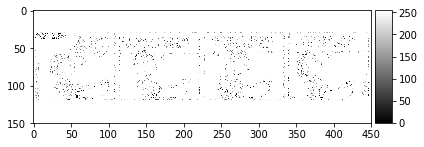

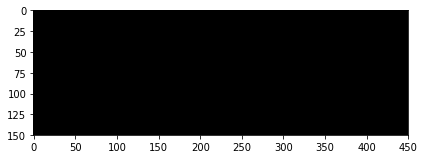

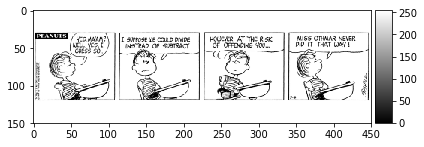

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


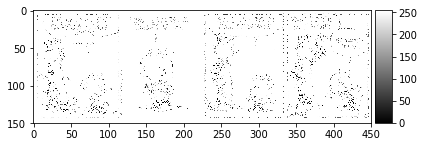

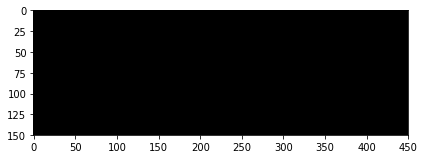

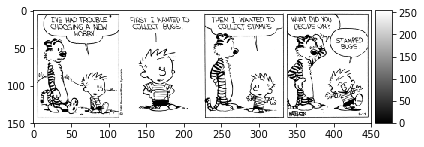

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


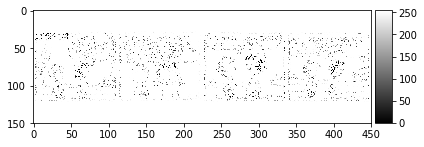

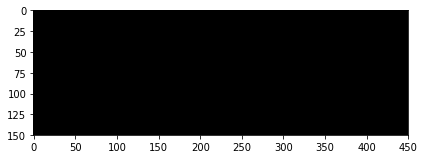

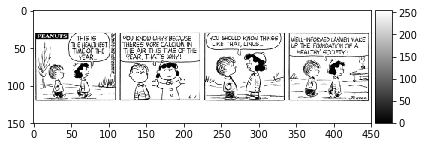

step  0 / 7367 d_loss:  3.814639981669643e-08 g_loss:  [409.5719, 4.085719, 0.99999964]
step  1 / 7367 d_loss:  1.2653674730245257e-07 g_loss:  [356.59872, 3.5559874, 0.99999774]
step  2 / 7367 d_loss:  4.414635057514715e-08 g_loss:  [255.48236, 2.5448236, 0.99999344]
step  3 / 7367 d_loss:  1.9213133839457441e-07 g_loss:  [232.8206, 2.318206, 1.0000014]
step  4 / 7367 d_loss:  7.132060630965498e-08 g_loss:  [196.67897, 1.9567896, 1.0000117]
step  5 / 7367 d_loss:  5.130228686311966e-08 g_loss:  [299.07196, 2.9807196, 1.00001]
step  6 / 7367 d_loss:  3.0970034003985347e-07 g_loss:  [262.98395, 2.6198394, 0.99999297]
step  7 / 7367 d_loss:  8.839484699763034e-09 g_loss:  [269.20905, 2.6820908, 0.9999846]
step  8 / 7367 d_loss:  4.1518833882037143e-07 g_loss:  [304.56815, 3.0356815, 0.9999969]
step  9 / 7367 d_loss:  1.357368883958543e-08 g_loss:  [232.63339, 2.3163338, 1.0000105]
step  10 / 7367 d_loss:  2.060600650111155e-07 g_loss:  [197.42412, 1.964241, 1.0000081]
step  11 / 7367 d_l

step  93 / 7367 d_loss:  2.972090573649666e-09 g_loss:  [303.79, 3.0279002, 1.0000014]
step  94 / 7367 d_loss:  7.626809406247048e-09 g_loss:  [292.04294, 2.9104292, 0.9999957]
step  95 / 7367 d_loss:  2.862349468557568e-08 g_loss:  [269.21658, 2.6821659, 0.9999964]
step  96 / 7367 d_loss:  6.529614626771263e-10 g_loss:  [222.31242, 2.2131243, 0.9999995]
step  97 / 7367 d_loss:  7.084127506828963e-09 g_loss:  [321.27203, 3.2027204, 1.0000012]
step  98 / 7367 d_loss:  1.9030201858782902e-09 g_loss:  [261.46262, 2.6046262, 1.0000007]
step  99 / 7367 d_loss:  1.596428655936677e-09 g_loss:  [265.451, 2.6445098, 0.99999917]
step  100 / 7367 d_loss:  2.121669240295887e-08 g_loss:  [439.61188, 4.386119, 1.000001]
step  101 / 7367 d_loss:  2.601548532155107e-09 g_loss:  [280.05682, 2.7905684, 1.0000036]
step  102 / 7367 d_loss:  2.600357618121052e-08 g_loss:  [274.67188, 2.7367187, 1.0000002]
step  103 / 7367 d_loss:  3.480910438363738e-12 g_loss:  [409.5719, 4.085719, 0.9999975]
step  104 / 7

step  184 / 7367 d_loss:  3.3828959633552813e-09 g_loss:  [257.75153, 2.5675151, 1.0000002]
step  185 / 7367 d_loss:  2.5622191035523656e-09 g_loss:  [285.08188, 2.8408186, 0.9999999]
step  186 / 7367 d_loss:  5.5464921544512436e-09 g_loss:  [267.9819, 2.669819, 0.9999981]
step  187 / 7367 d_loss:  2.934114062824733e-10 g_loss:  [138.62852, 1.3762852, 0.999998]
step  188 / 7367 d_loss:  3.0485287627612934e-09 g_loss:  [286.03992, 2.850399, 1.0000002]
step  189 / 7367 d_loss:  1.6679878589442865e-09 g_loss:  [189.23735, 1.8823736, 1.0000007]
step  190 / 7367 d_loss:  2.482037908535517e-09 g_loss:  [140.75546, 1.3975546, 1.0000017]
step  191 / 7367 d_loss:  1.856700571067904e-08 g_loss:  [328.52542, 3.2752542, 0.9999989]
step  192 / 7367 d_loss:  5.5527468040272865e-11 g_loss:  [357.23022, 3.5623024, 0.99999726]
step  193 / 7367 d_loss:  8.778917504059791e-08 g_loss:  [120.60968, 1.1960968, 1.0000031]
step  194 / 7367 d_loss:  5.08830799716975e-09 g_loss:  [311.00186, 3.1000185, 1.000004

step  274 / 7367 d_loss:  2.6714431555774354e-08 g_loss:  [127.94855, 1.2694855, 0.99999905]
step  275 / 7367 d_loss:  6.060940638263901e-11 g_loss:  [294.5265, 2.9352648, 0.9999976]
step  276 / 7367 d_loss:  1.812193417549679e-08 g_loss:  [135.11133, 1.3411132, 1.0000007]
step  277 / 7367 d_loss:  1.7125914908433515e-08 g_loss:  [285.72162, 2.8472161, 0.99999976]
step  278 / 7367 d_loss:  1.9650721938546667e-08 g_loss:  [157.59901, 1.5659901, 1.0000021]
step  279 / 7367 d_loss:  1.6401702396251494e-07 g_loss:  [246.46783, 2.4546783, 0.9999938]
step  280 / 7367 d_loss:  3.073592438340711e-07 g_loss:  [170.06099, 1.6906099, 1.0000033]
step  281 / 7367 d_loss:  1.200068666662446e-08 g_loss:  [153.19995, 1.5219994, 1.0000114]
step  282 / 7367 d_loss:  2.0349409624031978e-07 g_loss:  [233.65343, 2.3265343, 0.99999964]
step  283 / 7367 d_loss:  1.344525770718974e-07 g_loss:  [262.9079, 2.619079, 0.99999905]
step  284 / 7367 d_loss:  2.441714173073706e-07 g_loss:  [205.3947, 2.0439472, 0.999

step  364 / 7367 d_loss:  4.861777647136023e-11 g_loss:  [190.23805, 1.8923806, 0.99999774]
step  365 / 7367 d_loss:  1.1352617512727647e-08 g_loss:  [312.9149, 3.119149, 0.99999976]
step  366 / 7367 d_loss:  1.253751769070277e-09 g_loss:  [283.36435, 2.8236434, 1.0000026]
step  367 / 7367 d_loss:  8.913644933272735e-09 g_loss:  [210.48146, 2.0948145, 1.000001]
step  368 / 7367 d_loss:  5.334648989219204e-08 g_loss:  [328.06705, 3.2706704, 0.9999932]
step  369 / 7367 d_loss:  1.7178821565266844e-07 g_loss:  [109.96255, 1.0896255, 1.0000017]
step  370 / 7367 d_loss:  4.002432607563833e-09 g_loss:  [235.20116, 2.3420115, 1.0000088]
step  371 / 7367 d_loss:  1.0835449160140342e-07 g_loss:  [242.2908, 2.412908, 1.0000007]
step  372 / 7367 d_loss:  1.1338116223669203e-08 g_loss:  [292.47955, 2.9147954, 0.9999912]
step  373 / 7367 d_loss:  6.701849031287566e-08 g_loss:  [236.25467, 2.3525467, 0.9999958]
step  374 / 7367 d_loss:  2.4767558670646395e-08 g_loss:  [243.54694, 2.4254694, 1.000006

step  457 / 7367 d_loss:  1.69907676816905e-09 g_loss:  [337.64163, 3.3664162, 1.0000002]
step  458 / 7367 d_loss:  1.239007646480772e-10 g_loss:  [201.67288, 2.006729, 1.0000007]
step  459 / 7367 d_loss:  2.3250918967931966e-09 g_loss:  [293.15274, 2.9215274, 1.0000019]
step  460 / 7367 d_loss:  6.188380363703061e-10 g_loss:  [186.8022, 1.858022, 1.000001]
step  461 / 7367 d_loss:  1.6576781058930123e-09 g_loss:  [329.50095, 3.2850094, 0.9999981]
step  462 / 7367 d_loss:  7.329810092215894e-10 g_loss:  [251.46442, 2.5046442, 0.9999981]
step  463 / 7367 d_loss:  9.313336768457248e-10 g_loss:  [275.31125, 2.7431126, 1.0]
step  464 / 7367 d_loss:  6.205101321654638e-09 g_loss:  [250.21463, 2.4921463, 1.0]
step  465 / 7367 d_loss:  6.1588805166934435e-09 g_loss:  [221.43732, 2.2043731, 1.0000017]
step  466 / 7367 d_loss:  2.108998531369366e-10 g_loss:  [248.96057, 2.4796057, 1.0000021]
step  467 / 7367 d_loss:  5.001779879165724e-09 g_loss:  [314.38846, 3.1338847, 0.99999905]
step  468 / 

step  550 / 7367 d_loss:  3.1294076219268163e-09 g_loss:  [184.85469, 1.8385469, 0.99999523]
step  551 / 7367 d_loss:  2.925557796018552e-09 g_loss:  [380.2518, 3.7925181, 0.9999951]
step  552 / 7367 d_loss:  1.578299020366103e-07 g_loss:  [541.1075, 5.401075, 1.0000098]
step  553 / 7367 d_loss:  3.979350182703456e-08 g_loss:  [193.769, 1.9276898, 1.0000081]
step  554 / 7367 d_loss:  8.233224235709713e-08 g_loss:  [260.32736, 2.5932736, 0.9999918]
step  555 / 7367 d_loss:  5.5124996123367964e-08 g_loss:  [248.46716, 2.4746718, 0.99999225]
step  556 / 7367 d_loss:  3.1784757936748065e-08 g_loss:  [280.87756, 2.7987757, 1.000004]
step  557 / 7367 d_loss:  5.634842992208178e-08 g_loss:  [335.43277, 3.3443277, 1.0000038]
step  558 / 7367 d_loss:  6.312056655133347e-09 g_loss:  [284.9756, 2.839756, 0.9999982]
step  559 / 7367 d_loss:  3.029938611120997e-08 g_loss:  [151.16687, 1.5016687, 0.99999976]
step  560 / 7367 d_loss:  6.9646168832093736e-09 g_loss:  [181.04823, 1.8004823, 1.0000033]


step  642 / 7367 d_loss:  2.753596906046596e-09 g_loss:  [170.06468, 1.6906468, 1.0000014]
step  643 / 7367 d_loss:  6.453213075019448e-09 g_loss:  [254.02625, 2.5302625, 0.99999857]
step  644 / 7367 d_loss:  4.290041211163498e-09 g_loss:  [204.15318, 2.0315318, 0.99999905]
step  645 / 7367 d_loss:  2.4399877673886294e-09 g_loss:  [333.25772, 3.3225772, 1.0000014]
step  646 / 7367 d_loss:  7.212449748550398e-09 g_loss:  [296.03677, 2.9503677, 1.0]
step  647 / 7367 d_loss:  1.0260238214598871e-09 g_loss:  [317.23062, 3.162306, 1.0]
step  648 / 7367 d_loss:  1.0946654693810842e-09 g_loss:  [341.5333, 3.4053328, 0.9999988]
step  649 / 7367 d_loss:  4.581651502633122e-09 g_loss:  [366.07925, 3.6507926, 1.0000007]
step  650 / 7367 d_loss:  7.254608025419884e-10 g_loss:  [261.95566, 2.6095564, 1.000001]
step  651 / 7367 d_loss:  6.240246079869394e-07 g_loss:  [218.91287, 2.1791284, 1.0000291]
step  652 / 7367 d_loss:  3.2180639664147748e-06 g_loss:  [232.30608, 2.313061, 0.9999721]
step  653

step  734 / 7367 d_loss:  6.517602013644819e-09 g_loss:  [244.98578, 2.439858, 0.9999807]
step  735 / 7367 d_loss:  4.4225348005966225e-07 g_loss:  [160.4746, 1.5947455, 1.0000405]
step  736 / 7367 d_loss:  1.0943325889911648e-07 g_loss:  [265.84833, 2.6484826, 1.0000556]
step  737 / 7367 d_loss:  5.048800062468217e-07 g_loss:  [252.0207, 2.5102072, 0.9999907]
step  738 / 7367 d_loss:  1.294978488886045e-07 g_loss:  [176.45634, 1.754564, 0.99993813]
step  739 / 7367 d_loss:  1.3118581776438987e-08 g_loss:  [259.01535, 2.5801537, 0.9999634]
step  740 / 7367 d_loss:  1.1850050896100583e-06 g_loss:  [287.12335, 2.8612328, 1.0000517]
step  741 / 7367 d_loss:  7.126393342105075e-08 g_loss:  [250.9364, 2.4993634, 1.0000622]
step  742 / 7367 d_loss:  7.55379403472034e-07 g_loss:  [178.38808, 1.773881, 0.9999825]
step  743 / 7367 d_loss:  7.711306038160615e-10 g_loss:  [196.21046, 1.9521053, 0.99993694]
step  744 / 7367 d_loss:  3.638329530986084e-07 g_loss:  [267.76465, 2.6676466, 0.99998236]

step  825 / 7367 d_loss:  5.655032442319907e-09 g_loss:  [298.0711, 2.9707115, 0.9999708]
step  826 / 7367 d_loss:  1.2517622849372856e-07 g_loss:  [298.1318, 2.971318, 1.0000091]
step  827 / 7367 d_loss:  2.1108221837096153e-09 g_loss:  [309.54248, 3.0854244, 1.0000343]
step  828 / 7367 d_loss:  1.430970684168642e-07 g_loss:  [187.66252, 1.8666251, 1.0000196]
step  829 / 7367 d_loss:  1.7534161900201184e-09 g_loss:  [345.4429, 3.4444292, 0.99999213]
step  830 / 7367 d_loss:  1.2035125784848333e-08 g_loss:  [256.43384, 2.5543387, 0.9999733]
step  831 / 7367 d_loss:  3.231264429359726e-07 g_loss:  [118.33356, 1.1733357, 0.99999213]
step  832 / 7367 d_loss:  1.2560176232412346e-09 g_loss:  [394.15082, 3.9315083, 1.0000141]
step  833 / 7367 d_loss:  1.8534960588567628e-07 g_loss:  [250.73982, 2.4973981, 1.0000107]
step  834 / 7367 d_loss:  3.7687154730292605e-08 g_loss:  [247.822, 2.46822, 0.9999951]
step  835 / 7367 d_loss:  1.0680837903009888e-07 g_loss:  [98.90268, 0.97902685, 0.999994

step  917 / 7367 d_loss:  2.477600276051817e-07 g_loss:  [271.11157, 2.7011158, 1.0000124]
step  918 / 7367 d_loss:  1.442809344220919e-10 g_loss:  [275.32803, 2.74328, 1.0000207]
step  919 / 7367 d_loss:  1.6451481599233375e-07 g_loss:  [148.47404, 1.4747405, 1.0]
step  920 / 7367 d_loss:  2.304665969177222e-08 g_loss:  [134.80447, 1.3380449, 0.99997914]
step  921 / 7367 d_loss:  9.087160890430823e-08 g_loss:  [118.13919, 1.1713921, 0.99998724]
step  922 / 7367 d_loss:  4.44802559229629e-08 g_loss:  [178.64243, 1.776424, 1.0000095]
step  923 / 7367 d_loss:  5.271691705388548e-08 g_loss:  [267.4487, 2.664487, 1.0000141]
step  924 / 7367 d_loss:  2.325153225513077e-08 g_loss:  [225.77756, 2.2477756, 1.0000019]
step  925 / 7367 d_loss:  1.0198935918026564e-08 g_loss:  [441.19977, 4.4019976, 0.99999344]
step  926 / 7367 d_loss:  2.3413106120528937e-08 g_loss:  [212.85901, 2.11859, 0.9999956]
step  927 / 7367 d_loss:  1.1749260453441934e-09 g_loss:  [404.8365, 4.038365, 1.0000005]
step  92

step  1009 / 7367 d_loss:  2.0488595708911816e-08 g_loss:  [227.27835, 2.2627833, 1.0000076]
step  1010 / 7367 d_loss:  3.0970547015840566e-08 g_loss:  [338.60117, 3.3760116, 1.000004]
step  1011 / 7367 d_loss:  1.1541838595974241e-08 g_loss:  [175.62306, 1.7462306, 0.99999475]
step  1012 / 7367 d_loss:  1.4905314316138174e-08 g_loss:  [163.08597, 1.6208597, 0.999995]
step  1013 / 7367 d_loss:  1.253106507448365e-08 g_loss:  [184.13037, 1.8313037, 1.0000036]
step  1014 / 7367 d_loss:  5.791617851969022e-09 g_loss:  [203.39528, 2.0239527, 1.0000045]
step  1015 / 7367 d_loss:  1.1111845665823239e-08 g_loss:  [342.5686, 3.4156861, 0.99999857]
step  1016 / 7367 d_loss:  1.6733714414129963e-09 g_loss:  [129.61684, 1.2861683, 0.99999547]
step  1017 / 7367 d_loss:  8.41236857951344e-09 g_loss:  [139.21915, 1.3821914, 0.9999999]
step  1018 / 7367 d_loss:  1.3682666111236585e-10 g_loss:  [319.8787, 3.188787, 1.0000031]
step  1019 / 7367 d_loss:  1.3089256345466538e-09 g_loss:  [358.573, 3.57572

step  1101 / 7367 d_loss:  2.9082664054769225e-10 g_loss:  [244.02287, 2.4302287, 1.0000052]
step  1102 / 7367 d_loss:  3.586469121685809e-09 g_loss:  [167.49158, 1.6649158, 1.0000036]
step  1103 / 7367 d_loss:  7.126807588520023e-09 g_loss:  [296.4877, 2.9548771, 0.99999595]
step  1104 / 7367 d_loss:  2.312903202295047e-09 g_loss:  [371.08328, 3.7008328, 0.99999535]
step  1105 / 7367 d_loss:  1.337521648991924e-08 g_loss:  [271.8518, 2.708518, 1.0000029]
step  1106 / 7367 d_loss:  4.6246606544286806e-09 g_loss:  [228.3065, 2.273065, 1.0000036]
step  1107 / 7367 d_loss:  7.901190812731329e-09 g_loss:  [233.59106, 2.3259106, 0.9999976]
step  1108 / 7367 d_loss:  3.667807169094317e-09 g_loss:  [310.93445, 3.0993445, 0.9999937]
step  1109 / 7367 d_loss:  3.6904306277563137e-09 g_loss:  [322.9595, 3.219595, 0.999995]
step  1110 / 7367 d_loss:  3.01415695957985e-07 g_loss:  [248.19821, 2.471982, 1.0000169]
step  1111 / 7367 d_loss:  2.2303956015434778e-08 g_loss:  [255.72046, 2.5472045, 1.0

step  1191 / 7367 d_loss:  1.8045385274945147e-07 g_loss:  [140.58424, 1.3958426, 0.9999883]
step  1192 / 7367 d_loss:  4.7745682962840874e-08 g_loss:  [195.82632, 1.9482634, 0.9999851]
step  1193 / 7367 d_loss:  9.938979417256633e-08 g_loss:  [550.651, 5.49651, 1.0000081]
step  1194 / 7367 d_loss:  4.278179233097035e-08 g_loss:  [202.0877, 2.010877, 1.0000122]
step  1195 / 7367 d_loss:  6.146020581354605e-08 g_loss:  [254.75897, 2.5375898, 0.9999944]
step  1196 / 7367 d_loss:  3.6884625131961e-08 g_loss:  [187.82465, 1.8682466, 0.99999213]
step  1197 / 7367 d_loss:  3.811270232745301e-08 g_loss:  [201.24812, 2.0024812, 1.0000052]
step  1198 / 7367 d_loss:  3.11623082893675e-08 g_loss:  [209.94637, 2.0894637, 1.0000043]
step  1199 / 7367 d_loss:  2.401731080681202e-08 g_loss:  [137.98404, 1.3698404, 0.99999416]
step  1200 / 7367 d_loss:  2.931353471069542e-08 g_loss:  [306.9283, 3.059283, 0.9999974]
step  1201 / 7367 d_loss:  5.170420536160236e-09 g_loss:  [322.67145, 3.2167146, 1.0000

step  1283 / 7367 d_loss:  7.2542254321572575e-12 g_loss:  [462.65057, 4.6165056, 1.0000007]
step  1284 / 7367 d_loss:  6.1640137438701e-10 g_loss:  [499.86176, 4.9886174, 0.9999987]
step  1285 / 7367 d_loss:  8.040908217044063e-12 g_loss:  [221.69858, 2.2069857, 0.9999989]
step  1286 / 7367 d_loss:  3.8908556931893656e-10 g_loss:  [153.20322, 1.5220321, 1.0000005]
step  1287 / 7367 d_loss:  7.197426682425956e-11 g_loss:  [342.2707, 3.4127069, 1.0000014]
step  1288 / 7367 d_loss:  5.631359267788127e-10 g_loss:  [356.3643, 3.553643, 0.99999964]
step  1289 / 7367 d_loss:  1.1770573404845663e-09 g_loss:  [108.60059, 1.0760059, 0.99999964]
step  1290 / 7367 d_loss:  1.1281332118473486e-10 g_loss:  [235.63884, 2.3463883, 0.99999976]
step  1291 / 7367 d_loss:  2.0726982630225876e-11 g_loss:  [372.84772, 3.7184772, 0.99999976]
step  1292 / 7367 d_loss:  6.414616060546052e-11 g_loss:  [247.479, 2.46479, 0.9999994]
step  1293 / 7367 d_loss:  4.2999620530892457e-10 g_loss:  [293.79556, 2.9279556

step  1374 / 7367 d_loss:  5.179884854378258e-10 g_loss:  [415.8796, 4.148796, 0.9999982]
step  1375 / 7367 d_loss:  1.3453830272069922e-09 g_loss:  [357.68155, 3.5668154, 0.9999987]
step  1376 / 7367 d_loss:  4.1787753812805306e-10 g_loss:  [284.4703, 2.834703, 1.0000005]
step  1377 / 7367 d_loss:  3.209353893751654e-10 g_loss:  [292.25784, 2.9125783, 1.0000005]
step  1378 / 7367 d_loss:  3.9578998412004296e-10 g_loss:  [205.43538, 2.0443537, 1.0000007]
step  1379 / 7367 d_loss:  4.9602780216595477e-11 g_loss:  [265.37088, 2.6437087, 1.0]
step  1380 / 7367 d_loss:  6.413498204738133e-11 g_loss:  [205.6808, 2.046808, 0.9999995]
step  1381 / 7367 d_loss:  3.004974741260824e-11 g_loss:  [252.56242, 2.5156243, 0.9999995]
step  1382 / 7367 d_loss:  2.8249531186519405e-11 g_loss:  [209.78458, 2.0878458, 0.9999995]
step  1383 / 7367 d_loss:  2.5625628355396834e-11 g_loss:  [506.90533, 5.0590534, 0.9999999]
step  1384 / 7367 d_loss:  2.785920938386255e-10 g_loss:  [312.00183, 3.1100183, 1.000

step  1465 / 7367 d_loss:  1.8476221441687812e-07 g_loss:  [286.2869, 2.8528686, 1.0000217]
step  1466 / 7367 d_loss:  5.698921512475863e-08 g_loss:  [356.1517, 3.551517, 1.000006]
step  1467 / 7367 d_loss:  8.443872445695888e-08 g_loss:  [254.71307, 2.537131, 0.99997485]
step  1468 / 7367 d_loss:  7.084636877152661e-08 g_loss:  [232.94711, 2.3194711, 0.99999416]
step  1469 / 7367 d_loss:  2.743884941480701e-08 g_loss:  [291.3732, 2.9037316, 1.0000236]
step  1470 / 7367 d_loss:  6.32295922287085e-08 g_loss:  [162.15694, 1.6115694, 1.0000057]
step  1471 / 7367 d_loss:  5.40922240332975e-09 g_loss:  [331.6741, 3.3067412, 0.99998057]
step  1472 / 7367 d_loss:  4.953191634626819e-08 g_loss:  [216.83226, 2.1583226, 0.99999523]
step  1473 / 7367 d_loss:  1.918543275636342e-11 g_loss:  [564.14545, 5.6314545, 1.0000141]
step  1474 / 7367 d_loss:  3.326651309976114e-08 g_loss:  [291.6018, 2.906018, 1.0000029]
step  1475 / 7367 d_loss:  6.912546091086824e-10 g_loss:  [187.59735, 1.8659736, 0.999

step  1555 / 7367 d_loss:  3.3926543352436056e-08 g_loss:  [255.33134, 2.5433135, 1.000001]
step  1556 / 7367 d_loss:  2.778511865031419e-09 g_loss:  [230.82907, 2.2982907, 1.0000043]
step  1557 / 7367 d_loss:  1.7625984227720437e-08 g_loss:  [249.99681, 2.489968, 0.99999607]
step  1558 / 7367 d_loss:  1.0199653566189681e-08 g_loss:  [205.61934, 2.0461934, 0.99999964]
step  1559 / 7367 d_loss:  7.643985888705629e-09 g_loss:  [248.78311, 2.4778311, 1.000006]
step  1560 / 7367 d_loss:  2.4555911082302373e-08 g_loss:  [316.90903, 3.1590903, 0.9999968]
step  1561 / 7367 d_loss:  7.911940547167262e-11 g_loss:  [195.15363, 1.9415362, 0.99999475]
step  1562 / 7367 d_loss:  1.6265643054680368e-08 g_loss:  [372.79404, 3.7179403, 1.0000057]
step  1563 / 7367 d_loss:  3.6198364306017083e-09 g_loss:  [242.07997, 2.4107997, 1.0000036]
step  1564 / 7367 d_loss:  3.068637255410067e-08 g_loss:  [304.20874, 3.0320873, 0.99999094]
step  1565 / 7367 d_loss:  8.595174705305908e-08 g_loss:  [270.52866, 2.6

step  1645 / 7367 d_loss:  8.723112898678664e-09 g_loss:  [327.56018, 3.2656019, 1.0000021]
step  1646 / 7367 d_loss:  1.1377540021229038e-09 g_loss:  [305.90787, 3.0490787, 1.0000005]
step  1647 / 7367 d_loss:  2.9758802089219216e-09 g_loss:  [167.48257, 1.6648257, 0.99999666]
step  1648 / 7367 d_loss:  3.3148290778939327e-09 g_loss:  [272.44473, 2.7144473, 1.0000012]
step  1649 / 7367 d_loss:  1.0800372401975622e-10 g_loss:  [607.95575, 6.0695577, 1.0000031]
step  1650 / 7367 d_loss:  2.8335944701751714e-09 g_loss:  [182.45514, 1.8145514, 0.9999976]
step  1651 / 7367 d_loss:  7.665715284765895e-10 g_loss:  [181.4795, 1.8047951, 0.99999845]
step  1652 / 7367 d_loss:  5.814885795096814e-10 g_loss:  [245.14449, 2.4414449, 1.0000029]
step  1653 / 7367 d_loss:  1.3735212966992094e-09 g_loss:  [242.73207, 2.4173207, 1.0000002]
step  1654 / 7367 d_loss:  6.9120334456052035e-12 g_loss:  [328.5802, 3.275802, 0.99999774]
step  1655 / 7367 d_loss:  8.024950703955369e-10 g_loss:  [258.25232, 2.5

step  1735 / 7367 d_loss:  1.9368191495061637e-09 g_loss:  [318.63242, 3.1763241, 0.9999993]
step  1736 / 7367 d_loss:  5.618280285446531e-10 g_loss:  [252.94405, 2.5194404, 0.9999981]
step  1737 / 7367 d_loss:  3.791859881641102e-10 g_loss:  [241.42943, 2.4042943, 1.0000014]
step  1738 / 7367 d_loss:  1.650871439551338e-09 g_loss:  [194.99709, 1.9399709, 1.0]
step  1739 / 7367 d_loss:  4.0927575217786227e-10 g_loss:  [188.77823, 1.8777823, 1.0000002]
step  1740 / 7367 d_loss:  2.5391710956057523e-10 g_loss:  [286.17136, 2.8517137, 1.000001]
step  1741 / 7367 d_loss:  8.409397622699544e-10 g_loss:  [305.83057, 3.0483057, 0.99999857]
step  1742 / 7367 d_loss:  8.11451600357671e-12 g_loss:  [314.65485, 3.1365485, 1.0]
step  1743 / 7367 d_loss:  1.2601115706445398e-09 g_loss:  [260.03854, 2.5903854, 1.0000029]
step  1744 / 7367 d_loss:  1.423143713985553e-09 g_loss:  [150.24673, 1.4924674, 0.9999988]
step  1745 / 7367 d_loss:  5.775798242457775e-12 g_loss:  [236.46443, 2.3546443, 0.999998

step  1825 / 7367 d_loss:  1.3728405079405093e-08 g_loss:  [201.92087, 2.0092087, 0.99999547]
step  1826 / 7367 d_loss:  1.8016599323544824e-10 g_loss:  [271.65826, 2.7065828, 0.9999974]
step  1827 / 7367 d_loss:  1.002683447381969e-07 g_loss:  [383.50314, 3.8250313, 1.0000155]
step  1828 / 7367 d_loss:  1.4350148092034942e-07 g_loss:  [136.7891, 1.3578911, 0.9999862]
step  1829 / 7367 d_loss:  5.259686020053778e-09 g_loss:  [168.59772, 1.6759771, 0.99999344]
step  1830 / 7367 d_loss:  5.9592295542643114e-08 g_loss:  [300.16806, 2.9916801, 1.000021]
step  1831 / 7367 d_loss:  7.29368068164149e-08 g_loss:  [175.3994, 1.7439941, 0.9999912]
step  1832 / 7367 d_loss:  1.4808243520292308e-09 g_loss:  [222.2042, 2.212042, 0.99998677]
step  1833 / 7367 d_loss:  3.467664200229592e-08 g_loss:  [213.32242, 2.123224, 1.0000169]
step  1834 / 7367 d_loss:  3.779495827416213e-08 g_loss:  [269.64337, 2.6864338, 1.0000005]
step  1835 / 7367 d_loss:  4.2162909275056393e-10 g_loss:  [309.82315, 3.088231

step  1916 / 7367 d_loss:  3.337182266638372e-11 g_loss:  [317.11908, 3.1611907, 1.0000002]
step  1917 / 7367 d_loss:  5.765597374529641e-11 g_loss:  [307.89685, 3.0689685, 1.000001]
step  1918 / 7367 d_loss:  2.4009350063636248e-11 g_loss:  [155.33679, 1.5433679, 0.9999995]
step  1919 / 7367 d_loss:  6.270539643082884e-13 g_loss:  [247.69519, 2.4669518, 0.9999994]
step  1920 / 7367 d_loss:  7.819496786187763e-12 g_loss:  [295.00946, 2.9400947, 1.000001]
step  1921 / 7367 d_loss:  4.472550801937203e-13 g_loss:  [246.8141, 2.458141, 1.0]
step  1922 / 7367 d_loss:  5.554674054053521e-09 g_loss:  [574.41113, 5.7341113, 0.9999969]
step  1923 / 7367 d_loss:  1.7116031925112907e-09 g_loss:  [196.39273, 1.9539273, 0.9999999]
step  1924 / 7367 d_loss:  2.2513563635584433e-07 g_loss:  [239.5001, 2.385001, 1.0000176]
step  1925 / 7367 d_loss:  3.6781298717869504e-07 g_loss:  [274.31198, 2.73312, 0.99997306]
step  1926 / 7367 d_loss:  3.4590588171568015e-08 g_loss:  [200.72804, 1.9972804, 1.00000

step  2008 / 7367 d_loss:  4.8647471467822e-11 g_loss:  [258.0607, 2.570607, 1.0000062]
step  2009 / 7367 d_loss:  7.615827968265876e-09 g_loss:  [355.8031, 3.548031, 0.9999914]
step  2010 / 7367 d_loss:  8.69726957120065e-09 g_loss:  [204.23961, 2.032396, 1.0000036]
step  2011 / 7367 d_loss:  1.0818624884834094e-09 g_loss:  [225.52542, 2.2452543, 1.0000038]
step  2012 / 7367 d_loss:  1.5718611967585616e-09 g_loss:  [187.16032, 1.8616033, 0.9999939]
step  2013 / 7367 d_loss:  5.051892681962045e-09 g_loss:  [630.49713, 6.2949715, 1.0000024]
step  2014 / 7367 d_loss:  2.2771309282632046e-09 g_loss:  [158.90152, 1.5790153, 1.0000017]
step  2015 / 7367 d_loss:  1.7433193777449674e-11 g_loss:  [177.00417, 1.7600417, 0.999997]
step  2016 / 7367 d_loss:  1.8412041891124886e-09 g_loss:  [575.79395, 5.7479396, 1.0000014]
step  2017 / 7367 d_loss:  1.978095021115678e-09 g_loss:  [252.0438, 2.510438, 0.99999976]
step  2018 / 7367 d_loss:  2.0589377425217492e-10 g_loss:  [354.23633, 3.5323634, 0.9

step  2099 / 7367 d_loss:  3.42459449687027e-10 g_loss:  [172.95377, 1.7195377, 0.9999989]
step  2100 / 7367 d_loss:  3.5335279147119536e-10 g_loss:  [313.52274, 3.1252275, 1.0000007]
step  2101 / 7367 d_loss:  1.382975400865405e-10 g_loss:  [319.59167, 3.1859167, 1.0000002]
step  2102 / 7367 d_loss:  6.83385336167075e-12 g_loss:  [240.4913, 2.394913, 0.9999993]
step  2103 / 7367 d_loss:  3.0052044186490434e-11 g_loss:  [350.77197, 3.4977198, 0.99999976]
step  2104 / 7367 d_loss:  1.0666204031117843e-10 g_loss:  [163.87321, 1.6287322, 1.0]
step  2105 / 7367 d_loss:  1.129350502004911e-10 g_loss:  [449.1822, 4.481822, 1.0000005]
step  2106 / 7367 d_loss:  4.435241410249979e-11 g_loss:  [271.48962, 2.7048962, 0.99999964]
step  2107 / 7367 d_loss:  4.749811655102576e-13 g_loss:  [204.84274, 2.0384274, 0.9999995]
step  2108 / 7367 d_loss:  4.8214943322577586e-12 g_loss:  [297.19437, 2.9619436, 1.0000007]
step  2109 / 7367 d_loss:  5.574447153877671e-13 g_loss:  [250.40236, 2.4940236, 0.999

step  2190 / 7367 d_loss:  2.6283222709366783e-08 g_loss:  [367.48376, 3.6648376, 0.99999166]
step  2191 / 7367 d_loss:  1.349695799568451e-09 g_loss:  [130.67805, 1.2967803, 1.0000203]
step  2192 / 7367 d_loss:  3.446951524210817e-08 g_loss:  [233.14851, 2.3214853, 0.99998033]
step  2193 / 7367 d_loss:  5.772748679078177e-08 g_loss:  [254.98904, 2.5398903, 1.0000098]
step  2194 / 7367 d_loss:  3.4965882633741785e-08 g_loss:  [351.53607, 3.5053608, 1.0000012]
step  2195 / 7367 d_loss:  4.1445304965748164e-09 g_loss:  [321.9351, 3.2093508, 0.99999213]
step  2196 / 7367 d_loss:  3.8200793639475705e-09 g_loss:  [273.93152, 2.7293153, 1.0000088]
step  2197 / 7367 d_loss:  1.887071654493866e-08 g_loss:  [185.04057, 1.8404057, 0.9999938]
step  2198 / 7367 d_loss:  1.9307742959995267e-08 g_loss:  [220.49722, 2.1949723, 1.0000021]
step  2199 / 7367 d_loss:  5.996165786115171e-09 g_loss:  [305.96793, 3.0496793, 1.000001]
step  2200 / 7367 d_loss:  9.2163096598874e-11 g_loss:  [292.1249, 2.91124

step  2281 / 7367 d_loss:  9.007163348506708e-10 g_loss:  [155.3945, 1.543945, 1.0000029]
step  2282 / 7367 d_loss:  8.962425246394901e-10 g_loss:  [337.4533, 3.3645332, 0.999998]
step  2283 / 7367 d_loss:  1.2138654525983839e-09 g_loss:  [175.95076, 1.7495077, 1.000001]
step  2284 / 7367 d_loss:  1.4916636814632511e-09 g_loss:  [214.97102, 2.1397102, 0.99999976]
step  2285 / 7367 d_loss:  1.212167921593732e-09 g_loss:  [144.28943, 1.4328943, 1.0]
step  2286 / 7367 d_loss:  6.632179250232184e-10 g_loss:  [220.34589, 2.1934588, 1.0]
step  2287 / 7367 d_loss:  3.049795138654332e-10 g_loss:  [307.89685, 3.0689685, 1.0000002]
step  2288 / 7367 d_loss:  6.385278972231845e-10 g_loss:  [146.85745, 1.4585745, 0.9999995]
step  2289 / 7367 d_loss:  2.4591215730396243e-09 g_loss:  [192.62192, 1.9162191, 1.0000019]
step  2290 / 7367 d_loss:  4.653285312627986e-09 g_loss:  [450.69415, 4.4969416, 0.9999969]
step  2291 / 7367 d_loss:  5.063139685290707e-09 g_loss:  [129.362, 1.28362, 1.0000029]
step 

step  2373 / 7367 d_loss:  9.288873457080626e-07 g_loss:  [111.9707, 1.1097071, 0.99998856]
step  2374 / 7367 d_loss:  9.919040167005733e-07 g_loss:  [108.89807, 1.0789806, 1.0000181]
step  2375 / 7367 d_loss:  7.06425510088593e-07 g_loss:  [324.85165, 3.2385168, 0.99997485]
step  2376 / 7367 d_loss:  2.9444845495163463e-07 g_loss:  [295.6149, 2.9461486, 1.0000291]
step  2377 / 7367 d_loss:  3.461198616605543e-08 g_loss:  [187.97064, 1.8697067, 0.9999702]
step  2378 / 7367 d_loss:  2.013991462490594e-08 g_loss:  [174.5994, 1.7359936, 1.000027]
step  2379 / 7367 d_loss:  1.402158318342117e-07 g_loss:  [284.50153, 2.8350155, 0.99997973]
step  2380 / 7367 d_loss:  2.0600465688858094e-07 g_loss:  [366.76752, 3.657675, 1.0000112]
step  2381 / 7367 d_loss:  1.3026226497458993e-07 g_loss:  [142.18553, 1.4118553, 0.999997]
step  2382 / 7367 d_loss:  3.4236915524843425e-08 g_loss:  [282.5457, 2.8154569, 0.9999949]
step  2383 / 7367 d_loss:  2.6653983464797193e-09 g_loss:  [302.25256, 3.0125256,

step  2463 / 7367 d_loss:  1.4485189581137092e-07 g_loss:  [358.00116, 3.5700135, 0.9998193]
step  2464 / 7367 d_loss:  4.992705271433806e-08 g_loss:  [201.83867, 2.0083842, 1.0002458]
step  2465 / 7367 d_loss:  3.257501601794388e-09 g_loss:  [311.88748, 3.1088772, 0.99976707]
step  2466 / 7367 d_loss:  1.9188584943208298e-08 g_loss:  [216.004, 2.1500382, 1.0001619]
step  2467 / 7367 d_loss:  5.409316727877922e-08 g_loss:  [173.66548, 1.7266554, 0.99993706]
step  2468 / 7367 d_loss:  6.41748201246628e-08 g_loss:  [268.92432, 2.6792436, 0.9999671]
step  2469 / 7367 d_loss:  4.336405723393e-08 g_loss:  [189.26747, 1.8826736, 1.0001023]
step  2470 / 7367 d_loss:  1.3745970584011502e-08 g_loss:  [205.71165, 2.047118, 0.9998684]
step  2471 / 7367 d_loss:  7.614227581775879e-10 g_loss:  [143.31961, 1.4231949, 1.0001233]
step  2472 / 7367 d_loss:  1.1568126012662105e-08 g_loss:  [231.94841, 2.309485, 0.9999138]
step  2473 / 7367 d_loss:  3.0191735334028635e-08 g_loss:  [307.1969, 3.0619688, 1

step  2553 / 7367 d_loss:  1.658341375332384e-08 g_loss:  [310.854, 3.0985403, 0.9999707]
step  2554 / 7367 d_loss:  2.357436557076653e-08 g_loss:  [243.04474, 2.420447, 1.0000336]
step  2555 / 7367 d_loss:  3.039954776795639e-08 g_loss:  [326.1476, 3.2514763, 0.99996114]
step  2556 / 7367 d_loss:  3.6786012458378536e-08 g_loss:  [501.07068, 5.000706, 1.0000458]
step  2557 / 7367 d_loss:  4.311530688028142e-08 g_loss:  [267.69647, 2.6669652, 0.9999465]
step  2558 / 7367 d_loss:  4.988344670664446e-08 g_loss:  [415.85745, 4.148574, 1.0000637]
step  2559 / 7367 d_loss:  5.7809394604646513e-08 g_loss:  [184.47185, 1.8347193, 0.9999254]
step  2560 / 7367 d_loss:  6.823643161624204e-08 g_loss:  [229.85472, 2.2885463, 1.0000885]
step  2561 / 7367 d_loss:  8.250770378026573e-08 g_loss:  [145.743, 1.4474311, 0.9998957]
step  2562 / 7367 d_loss:  1.027629963346044e-07 g_loss:  [327.25098, 3.2625086, 1.0001247]
step  2563 / 7367 d_loss:  1.3303386481311463e-07 g_loss:  [327.68066, 3.2668083, 0.9

step  2644 / 7367 d_loss:  1.026465246134478e-09 g_loss:  [281.10236, 2.801024, 0.9999559]
step  2645 / 7367 d_loss:  1.9830590645142365e-06 g_loss:  [268.1455, 2.6714544, 1.0000474]
step  2646 / 7367 d_loss:  2.1590542473859387e-06 g_loss:  [168.43304, 1.6743295, 1.0000942]
step  2647 / 7367 d_loss:  1.2130540198995732e-06 g_loss:  [262.85278, 2.618527, 1.0000951]
step  2648 / 7367 d_loss:  1.639822215793174e-07 g_loss:  [258.13193, 2.5713186, 1.0000727]
step  2649 / 7367 d_loss:  1.4549221987181227e-06 g_loss:  [388.47803, 3.8747797, 1.0000463]
step  2650 / 7367 d_loss:  2.2335754579216882e-07 g_loss:  [155.23763, 1.5423762, 1.0000162]
step  2651 / 7367 d_loss:  3.395657017790654e-07 g_loss:  [193.64795, 1.9264797, 0.9999821]
step  2652 / 7367 d_loss:  6.556252856171341e-07 g_loss:  [379.4661, 3.7846615, 0.9999511]
step  2653 / 7367 d_loss:  1.6067239982930914e-08 g_loss:  [222.22037, 2.2122042, 0.99993885]
step  2654 / 7367 d_loss:  3.2388584259024356e-07 g_loss:  [166.50063, 1.6550

step  2735 / 7367 d_loss:  1.4051130259318256e-09 g_loss:  [242.4668, 2.4146686, 0.9999418]
step  2736 / 7367 d_loss:  1.9695481356940547e-10 g_loss:  [298.57224, 2.9757223, 0.9999882]
step  2737 / 7367 d_loss:  2.4080958382910467e-07 g_loss:  [272.84937, 2.7184935, 1.0000246]
step  2738 / 7367 d_loss:  1.1169026947754901e-07 g_loss:  [398.4503, 3.9745023, 1.0000515]
step  2739 / 7367 d_loss:  3.066424980602278e-08 g_loss:  [296.21017, 2.952101, 1.0000648]
step  2740 / 7367 d_loss:  7.110571687007905e-08 g_loss:  [185.08003, 1.8407997, 1.0000618]
step  2741 / 7367 d_loss:  7.62546914501172e-09 g_loss:  [225.43056, 2.2443051, 1.000046]
step  2742 / 7367 d_loss:  5.991627194390503e-09 g_loss:  [272.5941, 2.7159405, 1.0000255]
step  2743 / 7367 d_loss:  5.786714041278174e-08 g_loss:  [647.64886, 6.466489, 1.0000055]
step  2744 / 7367 d_loss:  8.62092730535835e-10 g_loss:  [164.13506, 1.6313506, 0.9999882]
step  2745 / 7367 d_loss:  2.2497346208183444e-08 g_loss:  [209.89339, 2.0889342, 0.

step  2824 / 7367 d_loss:  8.669396578397937e-08 g_loss:  [300.87482, 2.998748, 1.0000021]
step  2825 / 7367 d_loss:  1.0466504107853325e-07 g_loss:  [251.03586, 2.5003586, 1.000001]
step  2826 / 7367 d_loss:  2.2336376304110672e-08 g_loss:  [296.3618, 2.9536178, 1.0000012]
step  2827 / 7367 d_loss:  6.562233068052592e-08 g_loss:  [151.16687, 1.5016687, 0.9999993]
step  2828 / 7367 d_loss:  2.3309057461951e-10 g_loss:  [395.54037, 3.9454038, 0.9999974]
step  2829 / 7367 d_loss:  4.241306044150406e-07 g_loss:  [231.0637, 2.300637, 1.0000017]
step  2830 / 7367 d_loss:  1.1916901030417648e-06 g_loss:  [280.40887, 2.7940888, 0.9999962]
step  2831 / 7367 d_loss:  1.8823644154508656e-07 g_loss:  [257.43677, 2.5643675, 0.9999958]
step  2832 / 7367 d_loss:  3.599024012146401e-07 g_loss:  [229.09167, 2.2809167, 1.000001]
step  2833 / 7367 d_loss:  2.4072692623999803e-12 g_loss:  [174.36371, 1.7336371, 1.0000052]
step  2834 / 7367 d_loss:  2.3562085971207125e-07 g_loss:  [151.94595, 1.5094595, 1

step  2916 / 7367 d_loss:  5.427670313196131e-09 g_loss:  [248.98701, 2.47987, 0.9999999]
step  2917 / 7367 d_loss:  1.058681253773841e-09 g_loss:  [281.6356, 2.806356, 1.0000002]
step  2918 / 7367 d_loss:  5.670775515831394e-10 g_loss:  [219.04149, 2.180415, 1.0000005]
step  2919 / 7367 d_loss:  5.46499379083798e-09 g_loss:  [277.3632, 2.7636318, 0.9999999]
step  2920 / 7367 d_loss:  2.133966781059371e-08 g_loss:  [686.51276, 6.855128, 1.0000007]
step  2921 / 7367 d_loss:  6.231755111940629e-09 g_loss:  [192.79317, 1.9179317, 1.0000007]
step  2922 / 7367 d_loss:  6.08617733988126e-09 g_loss:  [212.5673, 2.115673, 1.0]
step  2923 / 7367 d_loss:  1.8192458650645449e-09 g_loss:  [114.60815, 1.1360815, 0.9999999]
step  2924 / 7367 d_loss:  2.1572150732396267e-09 g_loss:  [261.10834, 2.6010833, 1.0]
step  2925 / 7367 d_loss:  3.1896512098228413e-09 g_loss:  [286.72244, 2.8572245, 1.0000007]
step  2926 / 7367 d_loss:  7.589521011652778e-09 g_loss:  [197.879, 1.96879, 1.0000005]
step  2927 /

step  3008 / 7367 d_loss:  1.8539377322213113e-07 g_loss:  [208.0786, 2.070786, 1.0000017]
step  3009 / 7367 d_loss:  7.525940048935809e-08 g_loss:  [302.25256, 3.0125256, 0.99999595]
step  3010 / 7367 d_loss:  8.884426705435544e-08 g_loss:  [245.88577, 2.4488578, 0.9999951]
step  3011 / 7367 d_loss:  1.6672498759362497e-07 g_loss:  [259.67154, 2.5867155, 0.9999995]
step  3012 / 7367 d_loss:  1.1796724486146104e-08 g_loss:  [275.16513, 2.7416513, 1.0000019]
step  3013 / 7367 d_loss:  1.2456514753012016e-07 g_loss:  [264.84634, 2.6384635, 1.0000002]
step  3014 / 7367 d_loss:  6.609985447880717e-09 g_loss:  [254.45341, 2.5345342, 0.9999981]
step  3015 / 7367 d_loss:  5.2917570769750455e-08 g_loss:  [262.2295, 2.612295, 0.9999987]
step  3016 / 7367 d_loss:  3.3767832974263e-08 g_loss:  [256.37424, 2.5537424, 1.000001]
step  3017 / 7367 d_loss:  7.056132567129225e-09 g_loss:  [104.12403, 1.0312403, 1.0000021]
step  3018 / 7367 d_loss:  4.338493653222031e-08 g_loss:  [151.83269, 1.5083269, 

step  3098 / 7367 d_loss:  1.6068773334154685e-07 g_loss:  [153.38321, 1.5238321, 0.99999976]
step  3099 / 7367 d_loss:  1.5281459653238016e-08 g_loss:  [324.92004, 3.2392006, 0.99999714]
step  3100 / 7367 d_loss:  8.286583863537089e-08 g_loss:  [348.7393, 3.477393, 0.99999857]
step  3101 / 7367 d_loss:  3.6839740147343036e-08 g_loss:  [272.59406, 2.7159405, 1.0000019]
step  3102 / 7367 d_loss:  1.7075985070391653e-09 g_loss:  [262.40005, 2.6140006, 1.0000048]
step  3103 / 7367 d_loss:  2.485163008714153e-07 g_loss:  [206.88045, 2.0588045, 1.000001]
step  3104 / 7367 d_loss:  3.151708671822462e-09 g_loss:  [196.74445, 1.9574444, 0.9999976]
step  3105 / 7367 d_loss:  1.755814196258143e-07 g_loss:  [202.67384, 2.0167384, 0.9999993]
step  3106 / 7367 d_loss:  2.24371152768299e-08 g_loss:  [188.817, 1.87817, 1.0000024]
step  3107 / 7367 d_loss:  3.034401174772938e-08 g_loss:  [400.07953, 3.9907954, 1.0000029]
step  3108 / 7367 d_loss:  1.379365812681499e-07 g_loss:  [350.34872, 3.4934871, 

step  3190 / 7367 d_loss:  2.8138384067233346e-08 g_loss:  [350.18744, 3.4918745, 0.99999905]
step  3191 / 7367 d_loss:  7.567454218815328e-09 g_loss:  [336.2204, 3.352204, 1.0000005]
step  3192 / 7367 d_loss:  5.922912826861193e-09 g_loss:  [216.25014, 2.1525013, 1.0000007]
step  3193 / 7367 d_loss:  1.9332803802285525e-08 g_loss:  [196.60825, 1.9560825, 0.9999994]
step  3194 / 7367 d_loss:  2.2363313423312547e-09 g_loss:  [275.8269, 2.748269, 0.9999988]
step  3195 / 7367 d_loss:  1.7336153845803892e-08 g_loss:  [260.91467, 2.5991468, 1.0]
step  3196 / 7367 d_loss:  2.7159474669247174e-10 g_loss:  [182.71597, 1.8171597, 1.0000007]
step  3197 / 7367 d_loss:  1.2017427941657388e-08 g_loss:  [278.07834, 2.7707834, 1.0]
step  3198 / 7367 d_loss:  5.236523020757389e-13 g_loss:  [284.09442, 2.830944, 0.9999994]
step  3199 / 7367 d_loss:  5.742630371230462e-09 g_loss:  [397.49045, 3.9649045, 0.99999976]
step  3200 / 7367 d_loss:  4.989803015220673e-10 g_loss:  [328.83862, 3.278386, 1.0000005

step  3281 / 7367 d_loss:  1.155745846248557e-10 g_loss:  [183.39156, 1.8239156, 1.000001]
step  3282 / 7367 d_loss:  1.0471982392346035e-08 g_loss:  [175.02692, 1.7402692, 1.0]
step  3283 / 7367 d_loss:  4.512409335077905e-10 g_loss:  [225.41382, 2.2441382, 0.9999994]
step  3284 / 7367 d_loss:  6.092742310670474e-09 g_loss:  [95.033424, 0.94033426, 1.0]
step  3285 / 7367 d_loss:  3.735523002035279e-11 g_loss:  [192.32507, 1.9132507, 1.0000005]
step  3286 / 7367 d_loss:  3.980836993378034e-09 g_loss:  [218.55542, 2.1755543, 1.0]
step  3287 / 7367 d_loss:  4.09816625079884e-12 g_loss:  [303.67767, 3.0267768, 0.99999964]
step  3288 / 7367 d_loss:  2.5750415133529714e-09 g_loss:  [244.35483, 2.4335482, 0.9999999]
step  3289 / 7367 d_loss:  7.276029778680027e-10 g_loss:  [283.52545, 2.8252544, 1.0000005]
step  3290 / 7367 d_loss:  1.0780052406289542e-09 g_loss:  [288.95575, 2.8795576, 1.0000005]
step  3291 / 7367 d_loss:  6.205101765743848e-09 g_loss:  [322.8489, 3.218489, 0.99999964]
step

step  3373 / 7367 d_loss:  1.0197831024072457e-08 g_loss:  [164.3516, 1.633516, 0.9999995]
step  3374 / 7367 d_loss:  2.445003088880071e-10 g_loss:  [196.02068, 1.9502068, 1.0000002]
step  3375 / 7367 d_loss:  6.740748403899488e-09 g_loss:  [194.06403, 1.9306402, 0.99999976]
step  3376 / 7367 d_loss:  4.664825123401606e-11 g_loss:  [288.106, 2.87106, 0.9999994]
step  3377 / 7367 d_loss:  6.079587944185505e-09 g_loss:  [234.66168, 2.3366168, 1.0]
step  3378 / 7367 d_loss:  3.565299444563408e-10 g_loss:  [210.06885, 2.0906885, 1.0000005]
step  3379 / 7367 d_loss:  3.3291800427548424e-09 g_loss:  [192.5306, 1.915306, 0.9999999]
step  3380 / 7367 d_loss:  1.6202153507727246e-10 g_loss:  [149.60576, 1.4860576, 0.9999995]
step  3381 / 7367 d_loss:  3.817668847716504e-09 g_loss:  [180.58072, 1.7958071, 1.0000002]
step  3382 / 7367 d_loss:  5.751264464670669e-10 g_loss:  [212.47173, 2.1147172, 1.0000005]
step  3383 / 7367 d_loss:  2.965210743610669e-09 g_loss:  [211.69409, 2.106941, 0.9999999]

step  3464 / 7367 d_loss:  2.965702350365973e-08 g_loss:  [273.24954, 2.7224956, 1.000001]
step  3465 / 7367 d_loss:  2.3860430076183547e-08 g_loss:  [248.57101, 2.4757102, 0.9999994]
step  3466 / 7367 d_loss:  4.5072105769872195e-11 g_loss:  [736.83966, 7.3583965, 0.99999833]
step  3467 / 7367 d_loss:  1.8167298776461394e-08 g_loss:  [434.41837, 4.3341837, 0.9999995]
step  3468 / 7367 d_loss:  1.8845560528779615e-11 g_loss:  [204.40497, 2.0340497, 1.0000005]
step  3469 / 7367 d_loss:  1.1805817656806994e-08 g_loss:  [187.17851, 1.8617852, 0.9999995]
step  3470 / 7367 d_loss:  1.2955871098174754e-10 g_loss:  [224.42448, 2.2342448, 0.9999989]
step  3471 / 7367 d_loss:  7.567474646918981e-09 g_loss:  [182.91875, 1.8191874, 1.0]
step  3472 / 7367 d_loss:  2.5651675228388626e-10 g_loss:  [231.41148, 2.3041148, 1.0000005]
step  3473 / 7367 d_loss:  4.725396074434229e-09 g_loss:  [219.9526, 2.189526, 0.99999976]
step  3474 / 7367 d_loss:  3.2238600677914064e-10 g_loss:  [311.11417, 3.1011417

step  3556 / 7367 d_loss:  2.276650334920305e-08 g_loss:  [166.61609, 1.6561608, 1.0000002]
step  3557 / 7367 d_loss:  2.3922891445593564e-11 g_loss:  [245.61215, 2.4461215, 1.0000007]
step  3558 / 7367 d_loss:  5.546306525161526e-09 g_loss:  [199.0038, 1.9800379, 0.9999999]
step  3559 / 7367 d_loss:  3.4518854441500935e-09 g_loss:  [234.22516, 2.3322515, 1.0]
step  3560 / 7367 d_loss:  6.280959086168991e-11 g_loss:  [254.59871, 2.5359871, 1.0000002]
step  3561 / 7367 d_loss:  3.745101118113325e-09 g_loss:  [201.60518, 2.0060518, 0.99999964]
step  3562 / 7367 d_loss:  1.1255487653016871e-09 g_loss:  [261.67374, 2.6067374, 0.99999964]
step  3563 / 7367 d_loss:  2.4067787762760418e-09 g_loss:  [226.38799, 2.2538798, 1.0000005]
step  3564 / 7367 d_loss:  5.182105411449811e-09 g_loss:  [210.76343, 2.0976343, 1.0000002]
step  3565 / 7367 d_loss:  1.4633810829778326e-10 g_loss:  [312.9149, 3.119149, 0.9999993]
step  3566 / 7367 d_loss:  4.4908277097022165e-09 g_loss:  [184.01123, 1.8301123, 

step  3648 / 7367 d_loss:  7.185423922528855e-10 g_loss:  [517.3936, 5.163936, 0.99999976]
step  3649 / 7367 d_loss:  1.2969038287735657e-08 g_loss:  [303.82068, 3.0282068, 1.0000021]
step  3650 / 7367 d_loss:  8.310793475629907e-08 g_loss:  [339.15607, 3.3815606, 0.99999857]
step  3651 / 7367 d_loss:  1.6503271638157457e-08 g_loss:  [238.17809, 2.3717809, 0.9999981]
step  3652 / 7367 d_loss:  3.778407631216396e-08 g_loss:  [280.76123, 2.7976124, 1.0000014]
step  3653 / 7367 d_loss:  4.622124905040437e-08 g_loss:  [324.66763, 3.2366762, 1.0000002]
step  3654 / 7367 d_loss:  4.240330309102092e-09 g_loss:  [182.59747, 1.8159747, 0.999998]
step  3655 / 7367 d_loss:  4.986026169717661e-08 g_loss:  [197.57625, 1.9657625, 1.0000005]
step  3656 / 7367 d_loss:  2.8472006974311626e-09 g_loss:  [157.00127, 1.5600127, 1.0000014]
step  3657 / 7367 d_loss:  2.4714282176319102e-08 g_loss:  [332.0677, 3.3106768, 0.99999917]
step  3658 / 7367 d_loss:  1.2436887075750747e-08 g_loss:  [243.8399, 2.42839

step  3739 / 7367 d_loss:  5.062685772827535e-07 g_loss:  [116.57166, 1.1557167, 1.0000005]
step  3740 / 7367 d_loss:  4.458837921106351e-08 g_loss:  [289.52393, 2.8852391, 1.000005]
step  3741 / 7367 d_loss:  1.9850112664698827e-07 g_loss:  [170.487, 1.69487, 0.999998]
step  3742 / 7367 d_loss:  1.896265189316182e-07 g_loss:  [268.05753, 2.6705754, 1.000001]
step  3743 / 7367 d_loss:  9.811264689574273e-09 g_loss:  [330.9772, 3.299772, 1.0000045]
step  3744 / 7367 d_loss:  1.7035779364960035e-07 g_loss:  [495.0839, 4.940839, 0.999998]
step  3745 / 7367 d_loss:  2.9080437613515642e-08 g_loss:  [169.79494, 1.6879493, 0.99999654]
step  3746 / 7367 d_loss:  5.303377292875666e-08 g_loss:  [202.19534, 2.0119534, 1.0000012]
step  3747 / 7367 d_loss:  7.733122941999682e-08 g_loss:  [181.02525, 1.8002526, 0.99999917]
step  3748 / 7367 d_loss:  2.903713935964447e-10 g_loss:  [284.74066, 2.8374066, 0.999998]
step  3749 / 7367 d_loss:  5.562700167160983e-08 g_loss:  [190.05354, 1.8905355, 1.00000

step  3829 / 7367 d_loss:  3.442160185357368e-12 g_loss:  [166.32915, 1.6532915, 1.0000002]
step  3830 / 7367 d_loss:  5.511132661339957e-10 g_loss:  [154.45415, 1.5345415, 0.9999999]
step  3831 / 7367 d_loss:  3.9239758664599833e-10 g_loss:  [262.2295, 2.612295, 1.0]
step  3832 / 7367 d_loss:  1.9960758740333873e-11 g_loss:  [339.91226, 3.3891227, 1.0000002]
step  3833 / 7367 d_loss:  3.9742312218926656e-10 g_loss:  [465.25424, 4.6425424, 1.0]
step  3834 / 7367 d_loss:  8.854036392946796e-10 g_loss:  [265.3269, 2.643269, 1.0000002]
step  3835 / 7367 d_loss:  1.5198953207118393e-09 g_loss:  [452.88177, 4.518818, 0.99999976]
step  3836 / 7367 d_loss:  4.1269698769497154e-10 g_loss:  [415.8796, 4.148796, 0.99999976]
step  3837 / 7367 d_loss:  2.5113428003820104e-10 g_loss:  [177.65674, 1.7665673, 1.0000002]
step  3838 / 7367 d_loss:  6.246542172405611e-10 g_loss:  [255.32256, 2.5432255, 0.9999999]
step  3839 / 7367 d_loss:  9.129199132762444e-14 g_loss:  [236.32668, 2.3532667, 0.99999976

step  3922 / 7367 d_loss:  1.2924931525049033e-07 g_loss:  [295.9923, 2.949923, 0.9999968]
step  3923 / 7367 d_loss:  1.4127510894468287e-07 g_loss:  [264.62152, 2.6362152, 1.000001]
step  3924 / 7367 d_loss:  3.6993230700943514e-09 g_loss:  [280.48245, 2.7948246, 1.0000029]
step  3925 / 7367 d_loss:  5.7027378375096305e-08 g_loss:  [263.1941, 2.6219409, 0.99999785]
step  3926 / 7367 d_loss:  6.648895833905044e-08 g_loss:  [341.46518, 3.4046519, 1.0000005]
step  3927 / 7367 d_loss:  1.681933814445813e-09 g_loss:  [302.89737, 3.0189736, 1.0000014]
step  3928 / 7367 d_loss:  2.8393316142683034e-08 g_loss:  [264.9068, 2.6390681, 0.999998]
step  3929 / 7367 d_loss:  3.511322788085636e-08 g_loss:  [209.78458, 2.0878458, 1.0]
step  3930 / 7367 d_loss:  1.322987941421161e-09 g_loss:  [247.56445, 2.4656446, 1.0000007]
step  3931 / 7367 d_loss:  1.3966489298411489e-08 g_loss:  [256.0531, 2.5505311, 0.99999845]
step  3932 / 7367 d_loss:  1.9274301266136717e-08 g_loss:  [339.15607, 3.3815606, 1.0

step  4012 / 7367 d_loss:  4.551120764972882e-13 g_loss:  [141.68431, 1.4068431, 0.9999999]
step  4013 / 7367 d_loss:  2.986057234810602e-10 g_loss:  [155.94177, 1.5494177, 1.0000002]
step  4014 / 7367 d_loss:  3.565223671841977e-10 g_loss:  [174.16858, 1.7316858, 1.0]
step  4015 / 7367 d_loss:  6.14550701993899e-11 g_loss:  [261.79605, 2.6079605, 1.0]
step  4016 / 7367 d_loss:  4.322983637727873e-11 g_loss:  [373.1256, 3.721256, 1.0000002]
step  4017 / 7367 d_loss:  1.7625920167851916e-10 g_loss:  [254.64337, 2.5364337, 1.0]
step  4018 / 7367 d_loss:  6.685506315218248e-11 g_loss:  [216.43893, 2.1543894, 1.0]
step  4019 / 7367 d_loss:  7.983902428065903e-11 g_loss:  [285.35553, 2.8435552, 1.0000002]
step  4020 / 7367 d_loss:  8.335130363690268e-10 g_loss:  [246.65637, 2.4565637, 0.99999964]
step  4021 / 7367 d_loss:  9.674859802188962e-10 g_loss:  [241.52293, 2.4052293, 1.0000002]
step  4022 / 7367 d_loss:  1.4836493145153895e-10 g_loss:  [253.42407, 2.5242407, 1.0]
step  4023 / 7367 

step  4103 / 7367 d_loss:  5.910025535627028e-08 g_loss:  [183.16121, 1.8216121, 1.0000067]
step  4104 / 7367 d_loss:  2.6817755838237645e-07 g_loss:  [268.49997, 2.6749997, 0.99999607]
step  4105 / 7367 d_loss:  1.761472532280095e-07 g_loss:  [196.74445, 1.9574444, 1.0]
step  4106 / 7367 d_loss:  2.0837442882282176e-09 g_loss:  [233.94466, 2.3294466, 1.0000024]
step  4107 / 7367 d_loss:  8.403404905266143e-08 g_loss:  [219.12845, 2.1812844, 0.9999957]
step  4108 / 7367 d_loss:  1.2605725885350694e-07 g_loss:  [236.2075, 2.352075, 1.0000017]
step  4109 / 7367 d_loss:  2.322697234546922e-08 g_loss:  [221.17128, 2.2017128, 1.0000014]
step  4110 / 7367 d_loss:  1.4795304537074117e-08 g_loss:  [192.79317, 1.9179317, 0.99999774]
step  4111 / 7367 d_loss:  6.688071607641177e-08 g_loss:  [316.085, 3.15085, 1.0000024]
step  4112 / 7367 d_loss:  3.571610562858041e-08 g_loss:  [361.62247, 3.6062248, 1.0000002]
step  4113 / 7367 d_loss:  1.1567660891664833e-12 g_loss:  [369.2016, 3.6820161, 0.999

step  4193 / 7367 d_loss:  1.101463226182986e-10 g_loss:  [292.73074, 2.9173074, 1.0000005]
step  4194 / 7367 d_loss:  1.3291152622940672e-09 g_loss:  [272.67267, 2.7167268, 0.9999995]
step  4195 / 7367 d_loss:  2.9194933137688395e-09 g_loss:  [257.58224, 2.5658224, 1.0000002]
step  4196 / 7367 d_loss:  1.4420484806265677e-09 g_loss:  [266.8266, 2.658266, 0.99999976]
step  4197 / 7367 d_loss:  1.6372517924745367e-11 g_loss:  [385.4973, 3.844973, 0.99999976]
step  4198 / 7367 d_loss:  6.740508706748471e-10 g_loss:  [187.68716, 1.8668717, 1.0000005]
step  4199 / 7367 d_loss:  1.4388494840034127e-09 g_loss:  [293.0604, 2.920604, 0.99999976]
step  4200 / 7367 d_loss:  8.803912598942532e-10 g_loss:  [132.4906, 1.314906, 1.0000002]
step  4201 / 7367 d_loss:  7.32045257745284e-11 g_loss:  [333.608, 3.32608, 1.0]
step  4202 / 7367 d_loss:  1.7626008985693886e-10 g_loss:  [195.19482, 1.9419482, 0.9999995]
step  4203 / 7367 d_loss:  7.230553933368356e-10 g_loss:  [223.94128, 2.2294128, 1.0]
step

step  4284 / 7367 d_loss:  1.3562963374624815e-07 g_loss:  [148.2412, 1.472412, 1.0000036]
step  4285 / 7367 d_loss:  1.2713690011878498e-07 g_loss:  [234.45459, 2.3345459, 0.99999845]
step  4286 / 7367 d_loss:  4.472924430842795e-08 g_loss:  [276.6865, 2.756865, 1.000001]
step  4287 / 7367 d_loss:  2.5973215245223e-10 g_loss:  [122.317245, 1.2131724, 1.0000019]
step  4288 / 7367 d_loss:  2.154959943823087e-08 g_loss:  [276.95215, 2.7595215, 0.99999726]
step  4289 / 7367 d_loss:  5.107213496557961e-08 g_loss:  [175.18361, 1.7418361, 1.0000019]
step  4290 / 7367 d_loss:  4.440892098500626e-08 g_loss:  [169.58424, 1.6858424, 0.9999981]
step  4291 / 7367 d_loss:  1.581721775778533e-08 g_loss:  [259.3056, 2.583056, 1.0]
step  4292 / 7367 d_loss:  1.1397204291441199e-09 g_loss:  [182.32556, 1.8132555, 1.0000002]
step  4293 / 7367 d_loss:  3.486085031756403e-10 g_loss:  [195.27487, 1.9427487, 0.99999964]
step  4294 / 7367 d_loss:  1.6166983307641658e-09 g_loss:  [288.84845, 2.8784845, 1.0000

step  4375 / 7367 d_loss:  3.6940350778280617e-10 g_loss:  [194.50432, 1.9350432, 1.0]
step  4376 / 7367 d_loss:  6.41274988666396e-09 g_loss:  [290.50534, 2.8950534, 0.99999857]
step  4377 / 7367 d_loss:  1.8053826877917345e-08 g_loss:  [131.99234, 1.3099234, 1.0000026]
step  4378 / 7367 d_loss:  2.7018451476124028e-08 g_loss:  [177.70348, 1.7670348, 0.99999905]
step  4379 / 7367 d_loss:  4.306952305910272e-08 g_loss:  [201.17387, 2.0017388, 1.0000031]
step  4380 / 7367 d_loss:  8.445003629731218e-08 g_loss:  [246.79866, 2.4579866, 0.99999547]
step  4381 / 7367 d_loss:  1.1345965589271145e-07 g_loss:  [248.78311, 2.4778311, 1.0000026]
step  4382 / 7367 d_loss:  8.851493760175799e-08 g_loss:  [185.52599, 1.8452599, 0.99999726]
step  4383 / 7367 d_loss:  3.696937156405511e-08 g_loss:  [146.80571, 1.458057, 1.000001]
step  4384 / 7367 d_loss:  3.5020297772803133e-09 g_loss:  [351.53607, 3.5053608, 1.0000017]
step  4385 / 7367 d_loss:  4.028854583282282e-09 g_loss:  [228.26143, 2.2726142,

step  4465 / 7367 d_loss:  8.031296516719522e-08 g_loss:  [510.37524, 5.0937524, 0.9999964]
step  4466 / 7367 d_loss:  8.995019840085661e-08 g_loss:  [376.70074, 3.7570074, 1.0000033]
step  4467 / 7367 d_loss:  9.814282009301678e-08 g_loss:  [216.83226, 2.1583226, 0.99999595]
step  4468 / 7367 d_loss:  1.0757533175365097e-07 g_loss:  [196.31227, 1.9531227, 1.0000038]
step  4469 / 7367 d_loss:  1.0488295743016351e-07 g_loss:  [258.65652, 2.5765653, 0.99999654]
step  4470 / 7367 d_loss:  8.252573024947196e-08 g_loss:  [167.48257, 1.6648257, 1.0000026]
step  4471 / 7367 d_loss:  5.926312951487489e-08 g_loss:  [142.66, 1.4166001, 0.9999976]
step  4472 / 7367 d_loss:  4.3842309338515406e-08 g_loss:  [401.66833, 4.0066833, 1.0000019]
step  4473 / 7367 d_loss:  3.356676359089761e-08 g_loss:  [142.79369, 1.4179368, 0.9999981]
step  4474 / 7367 d_loss:  2.676956434299882e-08 g_loss:  [202.30865, 2.0130866, 1.0000019]
step  4475 / 7367 d_loss:  2.4740787196719793e-08 g_loss:  [316.90903, 3.15909

step  4557 / 7367 d_loss:  1.3926804154351657e-10 g_loss:  [155.19574, 1.5419574, 0.99999976]
step  4558 / 7367 d_loss:  3.163407313877542e-10 g_loss:  [232.3061, 2.313061, 1.0000002]
step  4559 / 7367 d_loss:  6.267645291657686e-10 g_loss:  [161.90276, 1.6090275, 0.9999995]
step  4560 / 7367 d_loss:  3.0020950170239757e-09 g_loss:  [284.5031, 2.8350313, 1.0000014]
step  4561 / 7367 d_loss:  1.1442318204046842e-08 g_loss:  [283.85287, 2.8285286, 0.9999981]
step  4562 / 7367 d_loss:  1.6158216098460798e-08 g_loss:  [209.98795, 2.0898795, 1.0000012]
step  4563 / 7367 d_loss:  9.291023950197541e-09 g_loss:  [278.6304, 2.776304, 0.9999993]
step  4564 / 7367 d_loss:  1.4905011669341661e-09 g_loss:  [369.71695, 3.6871696, 0.99999976]
step  4565 / 7367 d_loss:  3.6293101857154397e-10 g_loss:  [296.75247, 2.9575248, 1.0000007]
step  4566 / 7367 d_loss:  3.07639425045636e-09 g_loss:  [164.25719, 1.6325718, 0.99999917]
step  4567 / 7367 d_loss:  4.278718268579951e-09 g_loss:  [178.43385, 1.77433

step  4648 / 7367 d_loss:  2.0541146561470214e-10 g_loss:  [452.29138, 4.5129137, 0.9999982]
step  4649 / 7367 d_loss:  2.89246493423434e-09 g_loss:  [187.82466, 1.8682466, 0.99999964]
step  4650 / 7367 d_loss:  2.398597542807579e-09 g_loss:  [220.15677, 2.1915677, 0.99999964]
step  4651 / 7367 d_loss:  1.529905646613372e-09 g_loss:  [292.0485, 2.9104848, 0.9999993]
step  4652 / 7367 d_loss:  1.469379196095133e-08 g_loss:  [164.80585, 1.6380585, 1.0000038]
step  4653 / 7367 d_loss:  7.191806705719728e-09 g_loss:  [286.72244, 2.8572245, 0.9999999]
step  4654 / 7367 d_loss:  6.604779501095948e-10 g_loss:  [263.18063, 2.6218064, 0.9999962]
step  4655 / 7367 d_loss:  6.427045118329033e-09 g_loss:  [260.0222, 2.590222, 1.0000007]
step  4656 / 7367 d_loss:  1.0516761905776661e-09 g_loss:  [341.11542, 3.4011543, 1.0000031]
step  4657 / 7367 d_loss:  2.1499109159606178e-09 g_loss:  [213.59732, 2.1259732, 0.9999995]
step  4658 / 7367 d_loss:  3.76590936213006e-09 g_loss:  [153.97264, 1.5297264,

step  4738 / 7367 d_loss:  3.342796262018055e-08 g_loss:  [141.68431, 1.4068431, 1.0000033]
step  4739 / 7367 d_loss:  9.996509398035869e-09 g_loss:  [227.28236, 2.2628236, 1.0000017]
step  4740 / 7367 d_loss:  4.13163636636682e-09 g_loss:  [225.3119, 2.243119, 0.99999607]
step  4741 / 7367 d_loss:  2.218550498866989e-08 g_loss:  [260.47284, 2.5947285, 1.0000017]
step  4742 / 7367 d_loss:  7.752571917762907e-09 g_loss:  [309.7851, 3.0878508, 1.000001]
step  4743 / 7367 d_loss:  1.6474348552009133e-09 g_loss:  [179.4481, 1.784481, 0.9999976]
step  4744 / 7367 d_loss:  1.2063690491004309e-08 g_loss:  [161.48288, 1.6048288, 1.0000012]
step  4745 / 7367 d_loss:  4.836203437719178e-09 g_loss:  [249.28575, 2.4828575, 1.0000002]
step  4746 / 7367 d_loss:  4.693505029074174e-10 g_loss:  [241.71915, 2.4071915, 0.99999857]
step  4747 / 7367 d_loss:  3.7969001276394465e-09 g_loss:  [254.3731, 2.533731, 1.000001]
step  4748 / 7367 d_loss:  3.535668979814943e-10 g_loss:  [232.94711, 2.3194711, 1.00

step  4830 / 7367 d_loss:  6.741652214259375e-08 g_loss:  [176.62668, 1.7562687, 0.9998019]
step  4831 / 7367 d_loss:  3.3919768327450583e-08 g_loss:  [280.1504, 2.7915044, 0.999946]
step  4832 / 7367 d_loss:  3.6674658865365473e-09 g_loss:  [357.1906, 3.5619051, 1.0000985]
step  4833 / 7367 d_loss:  3.2441864306065327e-08 g_loss:  [164.35175, 1.633516, 1.0001552]
step  4834 / 7367 d_loss:  5.277082770760444e-09 g_loss:  [261.78912, 2.6078904, 1.0001016]
step  4835 / 7367 d_loss:  1.399435500815116e-08 g_loss:  [189.37045, 1.8837045, 0.9999949]
step  4836 / 7367 d_loss:  1.0822312823677294e-08 g_loss:  [504.66928, 5.0366936, 0.9999093]
step  4837 / 7367 d_loss:  3.728675146419391e-09 g_loss:  [167.83542, 1.6683552, 0.9998976]
step  4838 / 7367 d_loss:  1.3828184819431044e-08 g_loss:  [228.4431, 2.2744315, 0.99995685]
step  4839 / 7367 d_loss:  8.531668704847561e-10 g_loss:  [202.07167, 2.0107164, 1.0000317]
step  4840 / 7367 d_loss:  6.472591351780466e-09 g_loss:  [280.5225, 2.7952244,

step  4919 / 7367 d_loss:  7.407253178826068e-06 g_loss:  [164.83409, 1.6383476, 0.99933434]
step  4920 / 7367 d_loss:  9.583872042639996e-07 g_loss:  [383.50287, 3.8250313, 0.99976444]
step  4921 / 7367 d_loss:  1.1106911188107915e-05 g_loss:  [238.19684, 2.371965, 1.0003483]
step  4922 / 7367 d_loss:  1.0171913345402572e-05 g_loss:  [310.85464, 3.0985403, 1.0006212]
step  4923 / 7367 d_loss:  1.2699084663836402e-06 g_loss:  [276.08694, 2.7508655, 1.000401]
step  4924 / 7367 d_loss:  1.6235702560152276e-06 g_loss:  [249.2569, 2.48257, 0.9999013]
step  4925 / 7367 d_loss:  5.72480576011003e-06 g_loss:  [271.21692, 2.7021742, 0.9995262]
step  4926 / 7367 d_loss:  3.1464678613701835e-06 g_loss:  [189.46892, 1.8846937, 0.99954337]
step  4927 / 7367 d_loss:  1.0472761459823232e-05 g_loss:  [361.77853, 3.6077871, 0.9998313]
step  4928 / 7367 d_loss:  1.1277091971351183e-06 g_loss:  [240.26387, 2.392637, 1.0001636]
step  4929 / 7367 d_loss:  9.99004214463639e-07 g_loss:  [289.28674, 2.882864

step  5010 / 7367 d_loss:  1.4241190001484938e-05 g_loss:  [230.01884, 2.290111, 1.0077435]
step  5011 / 7367 d_loss:  5.139733730175067e-06 g_loss:  [183.9615, 1.8295743, 1.0040787]
step  5012 / 7367 d_loss:  7.855011290303082e-07 g_loss:  [270.58847, 2.695888, 0.9996496]
step  5013 / 7367 d_loss:  1.5288196664187126e-06 g_loss:  [190.94324, 1.8994709, 0.99613565]
step  5014 / 7367 d_loss:  5.990716999804135e-06 g_loss:  [297.34024, 2.963457, 0.9945448]
step  5015 / 7367 d_loss:  4.307676590542542e-06 g_loss:  [239.6774, 2.3868237, 0.99502623]
step  5016 / 7367 d_loss:  2.39784162658907e-06 g_loss:  [321.98337, 3.2098632, 0.9970302]
step  5017 / 7367 d_loss:  3.0939734187995782e-06 g_loss:  [315.31235, 3.1431274, 0.9996045]
step  5018 / 7367 d_loss:  1.6443307231384097e-06 g_loss:  [245.22202, 2.442202, 1.0018045]
step  5019 / 7367 d_loss:  1.411833750353253e-06 g_loss:  [178.45076, 1.7744776, 1.0030035]
step  5020 / 7367 d_loss:  2.81412030744832e-06 g_loss:  [292.67676, 2.9167378, 1

step  5100 / 7367 d_loss:  3.7709830280618917e-07 g_loss:  [209.20442, 2.0820441, 1.0000136]
step  5101 / 7367 d_loss:  9.293540159660552e-08 g_loss:  [316.0358, 3.150358, 0.9999958]
step  5102 / 7367 d_loss:  1.5326914137858694e-07 g_loss:  [335.78406, 3.3478408, 0.9999784]
step  5103 / 7367 d_loss:  5.937770310993074e-07 g_loss:  [237.47638, 2.364764, 0.99998116]
step  5104 / 7367 d_loss:  5.722318974221707e-07 g_loss:  [275.53745, 2.7453744, 0.99999964]
step  5105 / 7367 d_loss:  5.335751396273736e-08 g_loss:  [311.9557, 3.1095564, 1.0000176]
step  5106 / 7367 d_loss:  1.2414889738465718e-07 g_loss:  [339.9123, 3.3891227, 1.0000219]
step  5107 / 7367 d_loss:  3.4240773061355867e-07 g_loss:  [231.4641, 2.3046408, 1.00001]
step  5108 / 7367 d_loss:  1.408950396353248e-07 g_loss:  [167.70998, 1.6671, 0.9999919]
step  5109 / 7367 d_loss:  2.621862948970488e-09 g_loss:  [506.02536, 5.050254, 0.9999808]
step  5110 / 7367 d_loss:  1.3081917416002398e-07 g_loss:  [248.571, 2.4757102, 0.9999

step  5191 / 7367 d_loss:  6.120796314235122e-08 g_loss:  [192.40431, 1.9140432, 1.0000019]
step  5192 / 7367 d_loss:  1.0736274091982523e-08 g_loss:  [256.46875, 2.5546875, 1.0000076]
step  5193 / 7367 d_loss:  3.432090522892395e-08 g_loss:  [351.92422, 3.5092423, 1.0000074]
step  5194 / 7367 d_loss:  2.3720792441395133e-08 g_loss:  [168.69199, 1.6769199, 1.0000021]
step  5195 / 7367 d_loss:  5.372118749846777e-09 g_loss:  [376.90552, 3.7590551, 0.9999962]
step  5196 / 7367 d_loss:  2.15390238977875e-09 g_loss:  [170.06468, 1.6906468, 0.99999344]
step  5197 / 7367 d_loss:  1.1865672000510585e-08 g_loss:  [192.20107, 1.9120107, 0.9999956]
step  5198 / 7367 d_loss:  6.305859390209889e-09 g_loss:  [187.33746, 1.8633747, 0.9999999]
step  5199 / 7367 d_loss:  1.0149808077342115e-11 g_loss:  [303.37494, 3.0237494, 1.0000038]
step  5200 / 7367 d_loss:  4.58968330008247e-09 g_loss:  [456.21335, 4.5521336, 1.0000043]
step  5201 / 7367 d_loss:  4.943832898618439e-09 g_loss:  [341.11542, 3.40115

step  5283 / 7367 d_loss:  8.24242505359507e-08 g_loss:  [201.24814, 2.0024812, 1.000011]
step  5284 / 7367 d_loss:  6.701892374394447e-08 g_loss:  [301.81232, 3.0081232, 1.0000026]
step  5285 / 7367 d_loss:  8.193906664288875e-10 g_loss:  [272.84933, 2.7184935, 0.99999404]
step  5286 / 7367 d_loss:  3.276084825643011e-08 g_loss:  [242.5722, 2.4157221, 0.99999225]
step  5287 / 7367 d_loss:  4.223807792413936e-08 g_loss:  [518.9126, 5.179126, 0.9999974]
step  5288 / 7367 d_loss:  3.683483740246629e-09 g_loss:  [289.17508, 2.8817508, 1.0000033]
step  5289 / 7367 d_loss:  1.1176289227421421e-08 g_loss:  [203.1461, 2.021461, 1.0000052]
step  5290 / 7367 d_loss:  2.4189535707819232e-08 g_loss:  [194.50339, 1.9350338, 1.0000024]
step  5291 / 7367 d_loss:  5.001660863257484e-09 g_loss:  [309.70438, 3.0870438, 0.99999845]
step  5292 / 7367 d_loss:  3.0495939107311187e-09 g_loss:  [270.92825, 2.6992824, 0.9999963]
step  5293 / 7367 d_loss:  1.2702688678700724e-08 g_loss:  [276.33505, 2.7533505,

step  5375 / 7367 d_loss:  1.0866384458907419e-09 g_loss:  [336.00742, 3.350074, 0.99999845]
step  5376 / 7367 d_loss:  4.477557213888872e-10 g_loss:  [196.53986, 1.9553986, 0.9999995]
step  5377 / 7367 d_loss:  4.8361325361012675e-11 g_loss:  [141.40524, 1.4040525, 1.0000002]
step  5378 / 7367 d_loss:  5.590746754435827e-10 g_loss:  [258.42715, 2.5742717, 1.0000002]
step  5379 / 7367 d_loss:  3.940695825210838e-10 g_loss:  [131.99234, 1.3099234, 1.0]
step  5380 / 7367 d_loss:  5.133915167987446e-11 g_loss:  [261.0573, 2.600573, 0.99999976]
step  5381 / 7367 d_loss:  3.890652244820103e-10 g_loss:  [221.8251, 2.208251, 1.0]
step  5382 / 7367 d_loss:  1.5564136091050784e-10 g_loss:  [233.14853, 2.3214853, 1.0000005]
step  5383 / 7367 d_loss:  1.8159128714612116e-11 g_loss:  [109.166466, 1.0816647, 1.0000007]
step  5384 / 7367 d_loss:  2.0539125955565396e-10 g_loss:  [284.5588, 2.835588, 1.0000005]
step  5385 / 7367 d_loss:  9.153822838614545e-11 g_loss:  [206.29909, 2.052991, 1.0]
step  

step  5466 / 7367 d_loss:  8.676682983210782e-11 g_loss:  [285.0652, 2.8406518, 0.9999999]
step  5467 / 7367 d_loss:  3.383144459023768e-11 g_loss:  [137.044, 1.36044, 0.99999976]
step  5468 / 7367 d_loss:  3.683959387545954e-11 g_loss:  [179.18355, 1.7818354, 0.99999976]
step  5469 / 7367 d_loss:  1.372847668879018e-10 g_loss:  [287.33618, 2.8633618, 1.0]
step  5470 / 7367 d_loss:  3.501712808606783e-13 g_loss:  [272.84933, 2.7184935, 1.0000002]
step  5471 / 7367 d_loss:  8.67644844859683e-11 g_loss:  [197.04132, 1.9604132, 1.0000002]
step  5472 / 7367 d_loss:  7.105573074372984e-11 g_loss:  [191.31615, 1.9031615, 1.0]
step  5473 / 7367 d_loss:  2.8692759973525384e-14 g_loss:  [233.65343, 2.3265343, 0.9999999]
step  5474 / 7367 d_loss:  4.7778205003456975e-11 g_loss:  [321.9529, 3.2095292, 0.9999999]
step  5475 / 7367 d_loss:  3.996809133655077e-11 g_loss:  [286.0411, 2.8504112, 1.0]
step  5476 / 7367 d_loss:  3.4920720828890417e-13 g_loss:  [247.69519, 2.4669518, 1.0000002]
step  547

step  5558 / 7367 d_loss:  1.0290149843328322e-09 g_loss:  [310.1763, 3.091763, 1.000001]
step  5559 / 7367 d_loss:  3.526572811551887e-09 g_loss:  [452.88177, 4.518818, 0.9999988]
step  5560 / 7367 d_loss:  3.763588884986291e-10 g_loss:  [193.60698, 1.9260697, 0.9999975]
step  5561 / 7367 d_loss:  1.1094228868913092e-09 g_loss:  [252.94995, 2.5194995, 0.9999982]
step  5562 / 7367 d_loss:  1.6991100748597887e-09 g_loss:  [318.63242, 3.1763241, 1.0000005]
step  5563 / 7367 d_loss:  1.949132522049979e-11 g_loss:  [295.4123, 2.944123, 1.0000021]
step  5564 / 7367 d_loss:  9.036152937014208e-10 g_loss:  [265.32663, 2.6432662, 1.0000017]
step  5565 / 7367 d_loss:  7.075278141144281e-10 g_loss:  [274.20944, 2.7320945, 1.0000002]
step  5566 / 7367 d_loss:  1.9264694006704275e-11 g_loss:  [144.28943, 1.4328943, 0.9999989]
step  5567 / 7367 d_loss:  6.185181256057604e-10 g_loss:  [452.29138, 4.5129137, 0.9999989]
step  5568 / 7367 d_loss:  1.9351020785762785e-10 g_loss:  [303.2473, 3.022473, 0.

step  5649 / 7367 d_loss:  1.670911586870716e-08 g_loss:  [275.8269, 2.748269, 0.99999344]
step  5650 / 7367 d_loss:  3.798116310349542e-08 g_loss:  [361.62247, 3.6062248, 1.0000031]
step  5651 / 7367 d_loss:  1.0389504812025052e-09 g_loss:  [623.96936, 6.2296934, 1.0000095]
step  5652 / 7367 d_loss:  1.8383369493335522e-08 g_loss:  [150.24673, 1.4924674, 1.0000064]
step  5653 / 7367 d_loss:  1.4652642654766623e-08 g_loss:  [120.50859, 1.1950859, 0.99999785]
step  5654 / 7367 d_loss:  6.608094071935966e-10 g_loss:  [296.4238, 2.954238, 0.9999926]
step  5655 / 7367 d_loss:  1.3440689450305854e-08 g_loss:  [237.28056, 2.3628056, 0.9999951]
step  5656 / 7367 d_loss:  3.5923153340888803e-09 g_loss:  [267.6075, 2.666075, 1.0000017]
step  5657 / 7367 d_loss:  2.7510598243907225e-09 g_loss:  [194.50339, 1.9350338, 1.0000043]
step  5658 / 7367 d_loss:  7.178697636334164e-09 g_loss:  [256.62726, 2.5562725, 1.0000026]
step  5659 / 7367 d_loss:  2.7026370030824864e-10 g_loss:  [562.64966, 5.61649

step  5739 / 7367 d_loss:  5.184438656158363e-09 g_loss:  [164.25682, 1.6325718, 0.99962884]
step  5740 / 7367 d_loss:  9.988318083742342e-08 g_loss:  [182.3507, 1.8135183, 0.99886423]
step  5741 / 7367 d_loss:  2.3357868883522315e-07 g_loss:  [365.37396, 3.6437519, 0.99876714]
step  5742 / 7367 d_loss:  1.5896497984613234e-07 g_loss:  [258.7438, 2.5774453, 0.9992572]
step  5743 / 7367 d_loss:  2.0910183806677196e-08 g_loss:  [271.94446, 2.7094445, 0.9999975]
step  5744 / 7367 d_loss:  1.6949128323062723e-08 g_loss:  [455.79144, 4.5479083, 1.000599]
step  5745 / 7367 d_loss:  8.333081069622494e-08 g_loss:  [221.18755, 2.2018673, 1.0008093]
step  5746 / 7367 d_loss:  8.142581719994268e-08 g_loss:  [414.9679, 4.1396728, 1.000605]
step  5747 / 7367 d_loss:  2.2848938741049096e-08 g_loss:  [305.08835, 3.0408819, 1.0001593]
step  5748 / 7367 d_loss:  1.9084074764919023e-08 g_loss:  [302.83356, 3.0183384, 0.9997257]
step  5749 / 7367 d_loss:  3.530362846504431e-08 g_loss:  [191.51665, 1.9051

step  5830 / 7367 d_loss:  5.81265979793244e-10 g_loss:  [256.9281, 2.559281, 0.9999989]
step  5831 / 7367 d_loss:  4.6159618349861375e-09 g_loss:  [162.75735, 1.6175735, 1.0]
step  5832 / 7367 d_loss:  6.481110648159927e-10 g_loss:  [164.7039, 1.6370391, 1.0000012]
step  5833 / 7367 d_loss:  1.943817329319586e-09 g_loss:  [227.31042, 2.2631042, 1.0000012]
step  5834 / 7367 d_loss:  1.5463941238635925e-09 g_loss:  [117.385994, 1.16386, 1.0000005]
step  5835 / 7367 d_loss:  1.9213701810127937e-11 g_loss:  [200.41199, 1.9941199, 0.99999976]
step  5836 / 7367 d_loss:  1.30769284290011e-09 g_loss:  [341.11542, 3.4011543, 1.0]
step  5837 / 7367 d_loss:  3.376784685205081e-10 g_loss:  [241.0445, 2.400445, 1.0000002]
step  5838 / 7367 d_loss:  2.471613469445799e-10 g_loss:  [311.62354, 3.1062355, 1.0000002]
step  5839 / 7367 d_loss:  6.872442059879802e-10 g_loss:  [528.1982, 5.2719817, 0.99999976]
step  5840 / 7367 d_loss:  1.8866359863256577e-11 g_loss:  [159.91595, 1.5891596, 0.9999994]
ste

step  5921 / 7367 d_loss:  5.910099520889389e-09 g_loss:  [286.29324, 2.8529325, 1.0000002]
step  5922 / 7367 d_loss:  1.866217319568264e-10 g_loss:  [297.30334, 2.9630334, 1.0000014]
step  5923 / 7367 d_loss:  4.966126176952912e-09 g_loss:  [322.67145, 3.2167146, 1.0000007]
step  5924 / 7367 d_loss:  8.408284624117357e-10 g_loss:  [202.19438, 2.0119438, 0.9999993]
step  5925 / 7367 d_loss:  1.3916244823164448e-09 g_loss:  [131.22556, 1.3022555, 0.9999975]
step  5926 / 7367 d_loss:  2.0510812603902195e-08 g_loss:  [231.46408, 2.3046408, 0.9999999]
step  5927 / 7367 d_loss:  2.390721398626283e-09 g_loss:  [336.1891, 3.3518908, 1.0000031]
step  5928 / 7367 d_loss:  8.037590149001517e-09 g_loss:  [260.32736, 2.5932736, 1.0000021]
step  5929 / 7367 d_loss:  8.036476373263213e-09 g_loss:  [232.65898, 2.3165898, 0.9999987]
step  5930 / 7367 d_loss:  4.885271631671628e-10 g_loss:  [202.30865, 2.0130866, 0.999997]
step  5931 / 7367 d_loss:  7.3209758255643465e-09 g_loss:  [175.52165, 1.7452165

step  6012 / 7367 d_loss:  9.57378065713499e-10 g_loss:  [280.79153, 2.7979152, 0.9999994]
step  6013 / 7367 d_loss:  7.321808159765908e-10 g_loss:  [212.96837, 2.1196837, 1.0000012]
step  6014 / 7367 d_loss:  6.22819074092007e-10 g_loss:  [286.26672, 2.852667, 1.0000014]
step  6015 / 7367 d_loss:  2.4217541749749216e-07 g_loss:  [247.11298, 2.4611297, 1.0000103]
step  6016 / 7367 d_loss:  4.990956199435459e-07 g_loss:  [341.62073, 3.4062073, 0.9999975]
step  6017 / 7367 d_loss:  8.718519239891975e-08 g_loss:  [142.4219, 1.4142193, 0.99998295]
step  6018 / 7367 d_loss:  1.9201506518129463e-07 g_loss:  [172.25229, 1.7125231, 0.9999906]
step  6019 / 7367 d_loss:  1.922787475905352e-07 g_loss:  [220.64888, 2.1964886, 1.0000107]
step  6020 / 7367 d_loss:  2.4408016940924426e-08 g_loss:  [308.74033, 3.077403, 1.0000176]
step  6021 / 7367 d_loss:  1.8158490888708911e-07 g_loss:  [176.18613, 1.7518613, 1.0000038]
step  6022 / 7367 d_loss:  4.364657968380925e-09 g_loss:  [114.61501, 1.1361502,

step  6105 / 7367 d_loss:  1.620109463251751e-10 g_loss:  [160.779, 1.59779, 1.0]
step  6106 / 7367 d_loss:  2.1107811679077493e-11 g_loss:  [191.51715, 1.9051715, 0.99999976]
step  6107 / 7367 d_loss:  7.538858426414663e-11 g_loss:  [308.43735, 3.0743735, 0.99999976]
step  6108 / 7367 d_loss:  4.547640042318335e-11 g_loss:  [374.2038, 3.732038, 1.0000002]
step  6109 / 7367 d_loss:  1.1098923863306354e-11 g_loss:  [235.83942, 2.3483942, 1.0000002]
step  6110 / 7367 d_loss:  8.676778739946656e-11 g_loss:  [129.47072, 1.2847072, 1.0000002]
step  6111 / 7367 d_loss:  7.276030472569417e-12 g_loss:  [151.39514, 1.5039514, 1.0]
step  6112 / 7367 d_loss:  2.820153832683303e-11 g_loss:  [171.49869, 1.7049868, 1.0]
step  6113 / 7367 d_loss:  3.001184438744531e-07 g_loss:  [322.9595, 3.219595, 0.9999883]
step  6114 / 7367 d_loss:  6.588007295249554e-07 g_loss:  [274.18668, 2.7318668, 1.0000038]
step  6115 / 7367 d_loss:  6.866231672120193e-08 g_loss:  [194.75342, 1.937534, 1.0000191]
step  6116 

step  6197 / 7367 d_loss:  4.110443985183565e-09 g_loss:  [193.5053, 1.9250529, 0.9999999]
step  6198 / 7367 d_loss:  7.063075013746811e-09 g_loss:  [183.62402, 1.8262402, 0.99999857]
step  6199 / 7367 d_loss:  2.558042000444516e-09 g_loss:  [276.08655, 2.7508655, 1.0]
step  6200 / 7367 d_loss:  2.372592140115204e-12 g_loss:  [214.75381, 2.1375382, 1.0000012]
step  6201 / 7367 d_loss:  5.896970467489382e-09 g_loss:  [279.28766, 2.7828765, 0.99999964]
step  6202 / 7367 d_loss:  2.6489552218400547e-10 g_loss:  [222.54703, 2.2154703, 0.9999981]
step  6203 / 7367 d_loss:  3.324676756122358e-09 g_loss:  [209.93062, 2.089306, 0.9999993]
step  6204 / 7367 d_loss:  1.295626272934669e-09 g_loss:  [281.9493, 2.809493, 1.0000017]
step  6205 / 7367 d_loss:  2.345436067585638e-09 g_loss:  [149.0488, 1.480488, 1.0000014]
step  6206 / 7367 d_loss:  1.4008035842394406e-09 g_loss:  [203.88684, 2.0288684, 0.99999917]
step  6207 / 7367 d_loss:  8.40966796200604e-10 g_loss:  [174.87099, 1.7387098, 0.99999

step  6290 / 7367 d_loss:  5.133705266446853e-11 g_loss:  [222.05748, 2.2105749, 1.0]
step  6291 / 7367 d_loss:  3.382943924989945e-11 g_loss:  [288.7465, 2.8774648, 1.0000002]
step  6292 / 7367 d_loss:  2.431975627825711e-11 g_loss:  [206.10847, 2.0510848, 1.0000002]
step  6293 / 7367 d_loss:  3.0021270192026606e-11 g_loss:  [131.33975, 1.3033975, 1.0]
step  6294 / 7367 d_loss:  1.0262301425312259e-11 g_loss:  [292.65222, 2.9165223, 0.9999999]
step  6295 / 7367 d_loss:  2.4734757644861993e-11 g_loss:  [315.2926, 3.142926, 1.0]
step  6296 / 7367 d_loss:  3.284487699178884e-12 g_loss:  [222.54703, 2.2154703, 1.0]
step  6297 / 7367 d_loss:  2.0337571904338603e-11 g_loss:  [156.72234, 1.5572233, 0.9999999]
step  6298 / 7367 d_loss:  1.0243095434347982e-12 g_loss:  [205.6808, 2.046808, 1.0]
step  6299 / 7367 d_loss:  1.503531327218255e-11 g_loss:  [256.2224, 2.552224, 1.0]
step  6300 / 7367 d_loss:  3.495259637276149e-13 g_loss:  [199.0038, 1.9800379, 1.0000002]
step  6301 / 7367 d_loss:  

step  6381 / 7367 d_loss:  6.184424083954809e-10 g_loss:  [170.54599, 1.69546, 1.0000012]
step  6382 / 7367 d_loss:  1.9887698154974487e-09 g_loss:  [204.45142, 2.0345142, 1.0000017]
step  6383 / 7367 d_loss:  6.289965770456263e-10 g_loss:  [313.33124, 3.1233125, 1.0000002]
step  6384 / 7367 d_loss:  1.1198870719653087e-09 g_loss:  [196.58635, 1.9558635, 1.0]
step  6385 / 7367 d_loss:  5.690991566886794e-10 g_loss:  [208.41501, 2.07415, 1.0000005]
step  6386 / 7367 d_loss:  6.037662592106585e-10 g_loss:  [221.68134, 2.2068133, 1.0]
step  6387 / 7367 d_loss:  4.859015967362268e-10 g_loss:  [193.96475, 1.9296474, 0.9999993]
step  6388 / 7367 d_loss:  3.194157160990585e-10 g_loss:  [455.79083, 4.5479083, 0.9999993]
step  6389 / 7367 d_loss:  3.533709991287992e-10 g_loss:  [330.18427, 3.2918427, 0.9999999]
step  6390 / 7367 d_loss:  1.9935281203586896e-10 g_loss:  [166.61609, 1.6561608, 1.0]
step  6391 / 7367 d_loss:  1.535426924492711e-10 g_loss:  [400.3225, 3.993225, 0.99999976]
step  63

step  6473 / 7367 d_loss:  1.603578554665308e-11 g_loss:  [256.97003, 2.5597003, 1.0000002]
step  6474 / 7367 d_loss:  1.7738101265596384e-10 g_loss:  [304.58102, 3.0358102, 1.0]
step  6475 / 7367 d_loss:  1.27606036848249e-10 g_loss:  [235.68352, 2.3468351, 0.9999993]
step  6476 / 7367 d_loss:  1.5100585226690555e-09 g_loss:  [248.57101, 2.4757102, 1.0000005]
step  6477 / 7367 d_loss:  2.523592446124212e-11 g_loss:  [241.91064, 2.4091065, 1.000001]
step  6478 / 7367 d_loss:  1.6371081157373624e-09 g_loss:  [402.2153, 4.012153, 0.99999964]
step  6479 / 7367 d_loss:  5.18016129991139e-10 g_loss:  [274.0933, 2.730933, 0.9999995]
step  6480 / 7367 d_loss:  5.852675011297492e-10 g_loss:  [467.218, 4.66218, 1.0000002]
step  6481 / 7367 d_loss:  3.9575656640700174e-10 g_loss:  [307.10092, 3.0610092, 1.0000002]
step  6482 / 7367 d_loss:  1.2894829648502082e-09 g_loss:  [163.88446, 1.6288446, 0.99999905]
step  6483 / 7367 d_loss:  2.507097862647356e-09 g_loss:  [385.83173, 3.8483171, 0.9999997

step  6563 / 7367 d_loss:  5.961309170743334e-07 g_loss:  [274.31503, 2.73312, 1.0030359]
step  6564 / 7367 d_loss:  2.0958486857125536e-06 g_loss:  [244.27208, 2.4326801, 1.0040721]
step  6565 / 7367 d_loss:  2.234275143564446e-06 g_loss:  [254.47939, 2.534763, 1.0030861]
step  6566 / 7367 d_loss:  6.201198630151339e-07 g_loss:  [242.11678, 2.4111588, 1.0008981]
step  6567 / 7367 d_loss:  1.2325448039973708e-07 g_loss:  [265.1731, 2.641744, 0.99871725]
step  6568 / 7367 d_loss:  6.002333066135179e-07 g_loss:  [300.6888, 2.996913, 0.997527]
step  6569 / 7367 d_loss:  1.2296803788558464e-06 g_loss:  [197.55003, 1.9655236, 0.9976848]
step  6570 / 7367 d_loss:  4.7681541559541074e-07 g_loss:  [412.11383, 4.11115, 0.9988543]
step  6571 / 7367 d_loss:  2.2438298685756308e-07 g_loss:  [112.96182, 1.1196151, 1.0003128]
step  6572 / 7367 d_loss:  1.2362167467472318e-07 g_loss:  [267.80228, 2.6680093, 1.0013561]
step  6573 / 7367 d_loss:  4.1162769548463984e-07 g_loss:  [248.74751, 2.4774592, 1

step  6654 / 7367 d_loss:  3.705042672663694e-08 g_loss:  [153.19994, 1.5219994, 0.99999905]
step  6655 / 7367 d_loss:  2.1290508911420147e-08 g_loss:  [342.01904, 3.4101903, 0.9999993]
step  6656 / 7367 d_loss:  2.06557473347857e-08 g_loss:  [204.45425, 2.0345426, 1.0000024]
step  6657 / 7367 d_loss:  1.7115498351927272e-08 g_loss:  [203.83763, 2.0283763, 1.0000014]
step  6658 / 7367 d_loss:  1.0987102783133196e-08 g_loss:  [240.98654, 2.3998654, 0.99999845]
step  6659 / 7367 d_loss:  1.32974973254818e-08 g_loss:  [324.06717, 3.2306716, 0.9999988]
step  6660 / 7367 d_loss:  5.552587278856436e-09 g_loss:  [565.74963, 5.647496, 1.0000007]
step  6661 / 7367 d_loss:  1.0121307347787933e-08 g_loss:  [193.14891, 1.9214891, 1.0000002]
step  6662 / 7367 d_loss:  6.761591286874591e-09 g_loss:  [247.27736, 2.4627736, 0.99999833]
step  6663 / 7367 d_loss:  2.1487801760144976e-08 g_loss:  [222.74135, 2.2174134, 0.9999995]
step  6664 / 7367 d_loss:  7.095585785599212e-10 g_loss:  [119.037224, 1.18

step  6745 / 7367 d_loss:  1.3142320565151522e-10 g_loss:  [120.50859, 1.1950859, 1.0]
step  6746 / 7367 d_loss:  5.179872156202414e-12 g_loss:  [265.37088, 2.6437087, 1.0]
step  6747 / 7367 d_loss:  9.153393321081893e-11 g_loss:  [145.08665, 1.4408666, 1.0]
step  6748 / 7367 d_loss:  5.937091096530622e-16 g_loss:  [155.73999, 1.5473999, 0.9999999]
step  6749 / 7367 d_loss:  6.01407257327935e-11 g_loss:  [175.8518, 1.7485181, 1.0]
step  6750 / 7367 d_loss:  2.3021862194383402e-12 g_loss:  [233.5809, 2.325809, 1.0]
step  6751 / 7367 d_loss:  3.6324727947789626e-11 g_loss:  [187.22021, 1.8622022, 1.0]
step  6752 / 7367 d_loss:  5.5710991375690355e-12 g_loss:  [149.50652, 1.4850651, 0.9999999]
step  6753 / 7367 d_loss:  2.0719523319279176e-11 g_loss:  [311.28134, 3.1028135, 1.0]
step  6754 / 7367 d_loss:  8.213889637898042e-12 g_loss:  [395.214, 3.9421399, 1.0]
step  6755 / 7367 d_loss:  1.0260289146080126e-11 g_loss:  [471.40625, 4.7040625, 1.0]
step  6756 / 7367 d_loss:  8.7043983132417

step  6840 / 7367 d_loss:  1.2008211265623903e-12 g_loss:  [242.52036, 2.4152036, 1.0]
step  6841 / 7367 d_loss:  1.7763741866350102e-13 g_loss:  [280.51367, 2.7951367, 1.0]
step  6842 / 7367 d_loss:  1.1102269277529775e-12 g_loss:  [269.63678, 2.6863678, 1.0]
step  6843 / 7367 d_loss:  2.8423444153879984e-14 g_loss:  [480.74554, 4.7974553, 1.0]
step  6844 / 7367 d_loss:  6.395578511231292e-14 g_loss:  [131.4665, 1.3046651, 1.0]
step  6845 / 7367 d_loss:  5.755400496465501e-13 g_loss:  [225.49731, 2.2449732, 1.0]
step  6846 / 7367 d_loss:  1.1102269277529775e-12 g_loss:  [399.1413, 3.981413, 1.0]
step  6847 / 7367 d_loss:  4.336808689942018e-19 g_loss:  [147.09389, 1.4609389, 1.0]
step  6848 / 7367 d_loss:  5.755396159656812e-13 g_loss:  [392.24335, 3.9124334, 1.0]
step  6849 / 7367 d_loss:  1.1369074084943698e-13 g_loss:  [245.08994, 2.4408994, 1.0]
step  6850 / 7367 d_loss:  1.1368727140248502e-13 g_loss:  [222.31242, 2.2131243, 1.0]
step  6851 / 7367 d_loss:  6.394927989927801e-14 g

step  6933 / 7367 d_loss:  7.233920129579019e-09 g_loss:  [182.11795, 1.8111795, 0.9999993]
step  6934 / 7367 d_loss:  1.3552645117265172e-10 g_loss:  [233.20288, 2.3220289, 0.9999982]
step  6935 / 7367 d_loss:  5.691767945847914e-09 g_loss:  [150.2684, 1.492684, 0.99999964]
step  6936 / 7367 d_loss:  1.1086243034696963e-09 g_loss:  [198.035, 1.97035, 1.0]
step  6937 / 7367 d_loss:  1.7834749233003322e-09 g_loss:  [355.3781, 3.5437813, 0.99999964]
step  6938 / 7367 d_loss:  2.617989602882176e-09 g_loss:  [199.06926, 1.9806926, 1.0000005]
step  6939 / 7367 d_loss:  2.3155966727417265e-11 g_loss:  [270.92926, 2.6992927, 1.000001]
step  6940 / 7367 d_loss:  1.9510395521393775e-09 g_loss:  [148.5006, 1.475006, 1.0000002]
step  6941 / 7367 d_loss:  4.65667948645887e-10 g_loss:  [242.6857, 2.416857, 1.0]
step  6942 / 7367 d_loss:  5.451980533699441e-10 g_loss:  [132.94923, 1.3194923, 1.0000007]
step  6943 / 7367 d_loss:  9.674990808505868e-10 g_loss:  [289.945, 2.88945, 0.99999976]
step  694

step  7026 / 7367 d_loss:  2.8200551582813205e-07 g_loss:  [324.92007, 3.2392006, 1.0000253]
step  7027 / 7367 d_loss:  5.927044526288228e-07 g_loss:  [516.7246, 5.157246, 1.0000002]
step  7028 / 7367 d_loss:  6.856384349163136e-09 g_loss:  [144.84213, 1.4384215, 0.99997795]
step  7029 / 7367 d_loss:  3.237954899759643e-07 g_loss:  [199.60078, 1.986008, 0.9999876]
step  7030 / 7367 d_loss:  1.9846355314712127e-07 g_loss:  [303.75403, 3.0275402, 1.0000136]
step  7031 / 7367 d_loss:  2.742617155604421e-08 g_loss:  [186.69232, 1.8569231, 1.0000217]
step  7032 / 7367 d_loss:  2.2173848890361114e-07 g_loss:  [170.06468, 1.6906468, 1.0000021]
step  7033 / 7367 d_loss:  3.161799355666517e-08 g_loss:  [345.1671, 3.4416714, 0.99998164]
step  7034 / 7367 d_loss:  6.984708988966304e-08 g_loss:  [263.38016, 2.623802, 0.99998367]
step  7035 / 7367 d_loss:  1.014249306763304e-07 g_loss:  [237.69844, 2.3669844, 1.0000036]
step  7036 / 7367 d_loss:  3.9125678391593866e-11 g_loss:  [393.92892, 3.929288

step  7120 / 7367 d_loss:  4.4409354665875256e-14 g_loss:  [191.84258, 1.9084257, 1.0]
step  7121 / 7367 d_loss:  4.167673151034279e-16 g_loss:  [436.68033, 4.3568034, 1.0]
step  7122 / 7367 d_loss:  2.1495001958915516e-13 g_loss:  [247.11296, 2.4611297, 1.0]
step  7123 / 7367 d_loss:  3.481936960980647e-13 g_loss:  [300.17227, 2.9917226, 1.0]
step  7124 / 7367 d_loss:  1.7763741866350102e-13 g_loss:  [186.62947, 1.8562948, 1.0]
step  7125 / 7367 d_loss:  1.7763741866350102e-13 g_loss:  [210.19394, 2.0919394, 1.0]
step  7126 / 7367 d_loss:  2.5579711959711204e-13 g_loss:  [232.25945, 2.3125944, 1.0]
step  7127 / 7367 d_loss:  2.8442959792984723e-14 g_loss:  [205.43538, 2.0443537, 1.0]
step  7128 / 7367 d_loss:  1.7765129645130884e-13 g_loss:  [294.20038, 2.9320037, 1.0]
step  7129 / 7367 d_loss:  2.8838476745507435e-14 g_loss:  [193.96475, 1.9296474, 1.0]
step  7130 / 7367 d_loss:  2.8425612558224955e-14 g_loss:  [251.87883, 2.5087883, 1.0]
step  7131 / 7367 d_loss:  4.441282411282721e

step  7217 / 7367 d_loss:  4.440892098500626e-14 g_loss:  [305.4565, 3.0445652, 1.0]
step  7218 / 7367 d_loss:  2.8423444153879984e-14 g_loss:  [231.43797, 2.3043797, 1.0]
step  7219 / 7367 d_loss:  2.8422143111273e-14 g_loss:  [263.7376, 2.627376, 1.0]
step  7220 / 7367 d_loss:  7.107162081076979e-15 g_loss:  [110.65231, 1.0965232, 1.0]
step  7221 / 7367 d_loss:  4.441585987891017e-14 g_loss:  [271.72238, 2.707224, 1.0]
step  7222 / 7367 d_loss:  4.441065570848224e-14 g_loss:  [333.69772, 3.3269773, 1.0]
step  7223 / 7367 d_loss:  7.105861038469996e-15 g_loss:  [202.71, 2.0171, 1.0]
step  7224 / 7367 d_loss:  2.8422143111273e-14 g_loss:  [212.85901, 2.11859, 1.0]
step  7225 / 7367 d_loss:  7.105861038469996e-15 g_loss:  [256.52533, 2.5552533, 1.0]
step  7226 / 7367 d_loss:  7.112366251504909e-15 g_loss:  [290.53592, 2.8953593, 1.0]
step  7227 / 7367 d_loss:  8.705232715233713e-14 g_loss:  [211.97937, 2.1097937, 1.0]
step  7228 / 7367 d_loss:  4.4409354665875256e-14 g_loss:  [334.15247

step  7311 / 7367 d_loss:  7.315328898194196e-15 g_loss:  [322.63812, 3.216381, 1.0]
step  7312 / 7367 d_loss:  7.334844537298935e-15 g_loss:  [267.9819, 2.669819, 1.0]
step  7313 / 7367 d_loss:  2.710505431213761e-16 g_loss:  [312.21875, 3.1121874, 1.0]
step  7314 / 7367 d_loss:  3.161533534967731e-16 g_loss:  [158.77242, 1.5777242, 1.0]
step  7315 / 7367 d_loss:  3.161533534967731e-16 g_loss:  [298.07114, 2.9707115, 1.0]
step  7316 / 7367 d_loss:  3.161533534967731e-16 g_loss:  [254.39355, 2.5339355, 1.0]
step  7317 / 7367 d_loss:  3.161533534967731e-16 g_loss:  [186.0892, 1.8508921, 0.9999999]
step  7318 / 7367 d_loss:  1.1806961658367143e-14 g_loss:  [148.2412, 1.472412, 0.9999999]
step  7319 / 7367 d_loss:  3.647256108241237e-16 g_loss:  [371.4328, 3.704328, 1.0]
step  7320 / 7367 d_loss:  3.647256108241237e-16 g_loss:  [215.23221, 2.142322, 1.0]
step  7321 / 7367 d_loss:  3.647256108241237e-16 g_loss:  [155.4011, 1.5440109, 1.0]
step  7322 / 7367 d_loss:  3.647256108241237e-16 g_

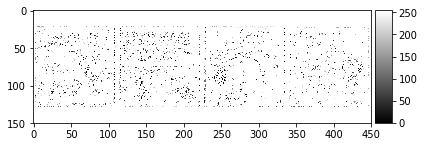

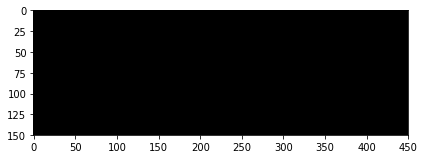

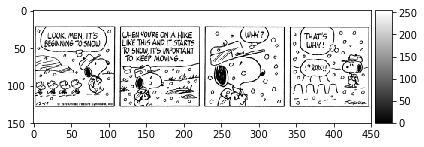

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


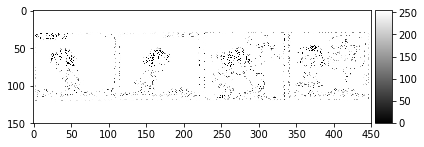

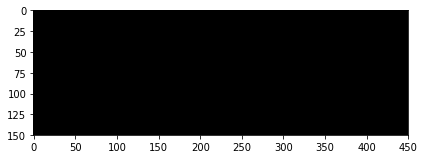

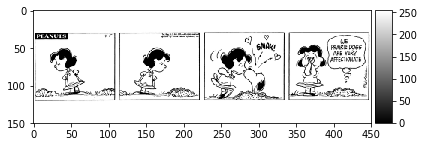

LATENT:  (1, 150, 450, 1)
(1, 150, 450, 1)
image shape: (150, 450)


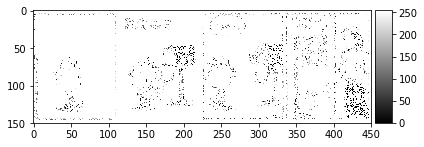

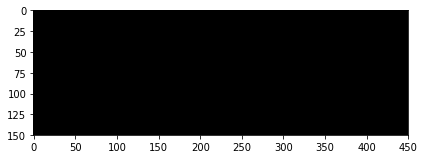

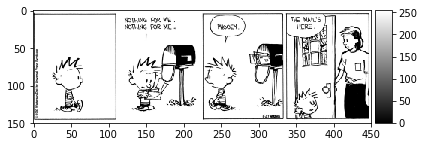

In [18]:
test_gan(g_pixelcnn, discriminator)